クラス情報追加 Dに有利, DもGもポテンシャルアップ特に多様性が上がりそう。  
2週目  
nz=128
T_0=epochs//100→epochs//200 周期を早くした  
dirty_dog追加  
aspect_flg追加  
3週目
③をコピー
3との相違はカーネルのアテンションを追加。

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['all-dogs', 'annotation']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm_notebook as tqdm
from time import time
from PIL import Image
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import random
from torch.nn.utils import spectral_norm
from scipy.stats import truncnorm
import torch as th

batch_size = 32

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
start = time()

In [5]:
class DataGenerator(Dataset):
    '''
    画像、クラス情報(犬がきれいかどうか)、aspect_flag(画像のaspect比が異常かどうか)の情報を吐き出すデータセット
    ---------------------
    base_transform:初めにデータ作成した時点で変換をかける。
    post_transform:train_loader等で呼び出す度に変換をかける。ランダム系はこっち。
    crop_dog:bboc情報を使うかどうか（bool）
    aspect_thre:縦横短い方のクラスに対して、何倍だったら異常とするかのしきい値(float)
    outlier_as_rate:異常なaspect比だった時の減少率
    '''
    def __init__(self, directory, ann_dict,base_transform=None,post_transform=None, n_samples=np.inf, crop_dog=False, aspect_thre=2,outlier_as_rate=0.8):
        self.directory = directory
        self.base_transform = base_transform
        self.post_transform = post_transform
        self.n_samples = n_samples
        self.aspect_thre = aspect_thre
        self.outlier_as_rate = outlier_as_rate

        self.samples ,self.classes, self.as_flgs, self.labels = self._load_subfolders_images(directory, ann_dict, crop_dog)
        if len(self.samples) == 0:
            raise RuntimeError("Found 0 files in subfolders of: {}".format(directory))
    
    def _aspect_flg(self,w,h):
        '''
        aspect比を計算して、正常なら１、異常だったらoutlier_as_rateの値を返す
        '''
        short, long = np.sort((w,h))
        aspect_rate = long / short
        if aspect_rate >= self.aspect_thre: # as比がやばい方
            return self.outlier_as_rate
        else:
            return 1
        
    def _load_subfolders_images(self, root,ann_dict, crop_dog):
        IMG_EXTENSIONS = (
        '.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

        def is_valid_file(x):
            return torchvision.datasets.folder.has_file_allowed_extension(x, IMG_EXTENSIONS)

        imgs = []
        paths = []
        classes = []
        as_flgs = []
        labels = []
        for root, _, fnames in sorted(os.walk(root)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            if is_valid_file(path):
                # Load image
                img = dset.folder.default_loader(path)
                file_name = os.path.splitext(os.path.basename(path))[0]
                annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(file_name.split('_')[0]))
                
                # Get bounding boxes
                if crop_dog:
                    annotation_filename = os.path.join('../input/annotation/Annotation/',
                                                       annotation_dirname, file_name)
                    tree = ET.parse(annotation_filename)
                    root = tree.getroot()
                    objects = root.findall('object')
                    for o in objects:
                        bndbox = o.find('bndbox')
                        xmin = int(bndbox.find('xmin').text)
                        ymin = int(bndbox.find('ymin').text)
                        xmax = int(bndbox.find('xmax').text)
                        ymax = int(bndbox.find('ymax').text)
                        bbox = (xmin, ymin, xmax, ymax)
                        object_img = self.base_transform(img.crop(bbox))
                        labels.append(annotation_dirname.split('-')[1].lower()) #犬種を追加                        
                        imgs.append(object_img)
                        cls = ann_dict[file_name]
                        classes.append(cls)
                        w, h = xmax- xmin,ymax - ymin
                        as_flg = self._aspect_flg(w,h)
                        as_flgs.append(as_flg) 
                else:
                    object_img = self.base_transform(img)
                    imgs.append(object_img)
                    cls = ann_dict[file_name]
                    classes.append(cls)
                    as_flg = self._aspect_flg(np.asarray(img).shape[0], np.asarray(img).shape[1])
                    as_flgs.append(as_flg)
                    labels.append(annotation_dirname.split('-')[1].lower()) #犬種を追加 

        return imgs, classes, as_flgs, labels
            

    def __getitem__(self, index):
        sample = self.samples[index]
        cls = self.classes[index]
        as_flg = self.as_flgs[index]        
        label = self.labels[index]
        
        if self.post_transform is not None:
            sample = self.post_transform(sample)
            
        return np.asarray(sample), cls, as_flg, label
    
    def __len__(self):
        return len(self.samples)


In [6]:
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [7]:
def show_generated_img_all():
    gen_z = torch.randn(32, nz, 1, 1, device=device)
    if use_label:
        dog_label = torch.randint(0, len(encoded_dog_labels), (32, ), device=device)
        gen_images = netG((gen_z, dog_label)).to("cpu").clone().detach()
    else:
        gen_images = netG(gen_z).to("cpu").clone().detach()
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)
    gen_images = (gen_images+1.0)/2.0
    fig = plt.figure(figsize=(25, 16))
    for ii, img in enumerate(gen_images):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow(img)
    #plt.savefig(filename)  

In [8]:
### This is to show one sample image for iteration of chosing
def show_generated_img():
    noise = torch.randn(1, nz, 1, 1, device=device)
    if use_label:
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)        
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
    else:
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    gen_image = ((gen_image+1.0)/2.0)
    plt.imshow(gen_image)
    plt.show()

In [9]:
class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)
        # return the computed values:
        return y


In [10]:
import matplotlib.pyplot as plt
# それぞれlossとdoutをplotする関数
def loss_plot(d_list, g_list, xlabel='epoch',ylabel='RaLS_loss'):
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(d_list,   color="r", label="d_loss")
    plt.plot(g_list,   color="g", label="g_loss")
    plt.legend(loc="best")
    plt.show()
    
def dout_plot(dout_r, dout_f, xlabel='epoch', ylabel='dout(linear)'):
    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(dout_r, color="r", label="dout_r")
    plt.plot(dout_f, color="g", label="dout_f")
    plt.legend(loc="best")
    plt.show()

In [11]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

im_batch_size = 100
n_images=10000

# 画像を指定のフォルダに指定の枚数作成する関数
def create_image(G_model,nz, threshold=1,fold_name='../output_images',n_images=10000, im_batch_size=100):
    if not os.path.exists(fold_name):
        os.mkdir(fold_name)
    for i_batch in range(0, n_images, im_batch_size):
        z = truncated_normal((im_batch_size, nz, 1, 1), threshold=threshold)
        gen_z = torch.from_numpy(z).float().to(device)    
        if use_label:
            dog_label = torch.randint(0, len(encoded_dog_labels), (im_batch_size, ), device=device)            
            gen_images = G_model((gen_z, dog_label))
        else:
            gen_images = G_model(gen_z)
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image((gen_images[i_image, :, :, :] +1.0)/2.0, os.path.join(fold_name, f'image_{i_batch+i_image:05d}.png'))


In [12]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

#パイトーチ本のアテンションクラス
class Self_Attention_book(nn.Module):
    """ Self-AttentionのLayer"""

    def __init__(self, in_dim):
        super(Self_Attention_book, self).__init__()

        # 1×1の畳み込み層によるpointwise convolutionを用意
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map作成時の規格化のソフトマックス
        self.softmax = nn.Softmax(dim=-2)

        # 元の入力xとSelf-Attention Mapであるoを足し算するときの係数
        # output = x +gamma*o
        # 最初はgamma=0で、学習させていく
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 入力変数
        X = x

        # 畳み込みをしてから、サイズを変形する。 B,C',W,H→B,C',N へ
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 転置操作
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C',N

        # かけ算
        S = torch.bmm(proj_query, proj_key)  # bmmはバッチごとの行列かけ算です

        # 規格化
        attention_map_T = self.softmax(S)  # 行i方向の和を1にするソフトマックス関数
        attention_map = attention_map_T.permute(0, 2, 1)  # 転置をとる

        # Self-Attention Mapを計算する
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # サイズ：B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Mapは転置してかけ算

        # Self-Attention MapであるoのテンソルサイズをXにそろえて、出力にする
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out

In [13]:
torch.backends.cudnn.benchmark = True

class Generator(nn.Module):
    def __init__(self, nz, nfeats, nchannels, num_classes=120):
        super(Generator, self).__init__()
        if use_label:
            self.label_emb = nn.Embedding(num_classes, nz)
            self.conv1 = spectral_norm(nn.ConvTranspose2d(nz*2, nfeats * 8, 4, 1, 0, bias=False))     
            self.nz = nz
        else:
            self.conv1 = spectral_norm(nn.ConvTranspose2d(nz, nfeats * 8, 4, 1, 0, bias=False))
        #self.bn1 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 4 x 4          
        
        self.conv2 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 8, 4, 2, 1, bias=False))
        #self.bn2 = nn.BatchNorm2d(nfeats * 8)
        # state size. (nfeats*8) x 8 x 8
        
        self.conv3 = spectral_norm(nn.ConvTranspose2d(nfeats * 8, nfeats * 4, 4, 2, 1, bias=False))
        #self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 16 x 16
        
        self.conv4 = spectral_norm(nn.ConvTranspose2d(nfeats * 4, nfeats * 2, 4, 2, 1, bias=False))
        #self.bn4 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats * 2) x 32 x 32
        
        self.conv5 = spectral_norm(nn.ConvTranspose2d(nfeats * 2, nfeats, 4, 2, 1, bias=False))
        #self.bn5 = nn.BatchNorm2d(nfeats)
        # state size. (nfeats) x 64 x 64
        if use_attention:
            self.self_attn_book = Self_Attn(nfeats)        
        self.conv6 = spectral_norm(nn.ConvTranspose2d(nfeats, nchannels, 3, 1, 1, bias=False))
        # state size. (nchannels) x 64 x 64
        self.pixnorm = PixelwiseNorm()
    def forward(self, inputs):
        if use_label:
            z, labels = inputs
            enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
            enc = F.normalize(enc, p=2, dim=1)
            x = torch.cat((z, enc), 1)
            x = F.leaky_relu(self.conv1(x))
        else:
            x = F.leaky_relu(self.conv1(inputs))
        x = F.leaky_relu(self.conv2(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv4(x))
        x = self.pixnorm(x)
        x = F.leaky_relu(self.conv5(x))
        if use_attention:
            x = self.self_attn_book(x)
        x = self.pixnorm(x)
        x = torch.tanh(self.conv6(x))
        
        return x



class Discriminator(nn.Module):
    def __init__(self, nchannels, nfeats, loss_calc, num_classes=120):
        super(Discriminator, self).__init__()
        if loss_calc == 'bce':
            self.use_sigmoid = True
        else:
            self.use_sigmoid = False
        
        if use_label:
            self.num_classes = num_classes
            self.label_emb = nn.Embedding(num_classes, 64*64)        
            self.conv1 = nn.Conv2d(nchannels + 1, nfeats, 4, 2, 1, bias=False)
        else:       
            # input is (nchannels) x 64 x 64
            self.conv1 = nn.Conv2d(nchannels, nfeats, 4, 2, 1, bias=False)
            # state size. (nfeats) x 32 x 32
        if use_attention:
            self.self_attn_book = Self_Attn(nfeats)
        self.conv2 = spectral_norm(nn.Conv2d(nfeats, nfeats * 2, 4, 2, 1, bias=False))
        self.bn2 = nn.BatchNorm2d(nfeats * 2)
        # state size. (nfeats*2) x 16 x 16
        
        self.conv3 = spectral_norm(nn.Conv2d(nfeats * 2, nfeats * 4, 4, 2, 1, bias=False))
        self.bn3 = nn.BatchNorm2d(nfeats * 4)
        # state size. (nfeats*4) x 8 x 8
       
        self.conv4 = spectral_norm(nn.Conv2d(nfeats * 4, nfeats * 8, 4, 2, 1, bias=False))
        self.bn4 = nn.MaxPool2d(2)
        # state size. (nfeats*8) x 4 x 4
        self.batch_discriminator = MinibatchStdDev()
        self.pixnorm = PixelwiseNorm()
        self.conv5 = spectral_norm(nn.Conv2d(nfeats * 8 +1, 1, 2, 1, 0, bias=False))
        # state size. 1 x 1 x 1
        
    def forward(self, inputs):
        
        if use_label:
            imgs, labels = inputs
            enc = self.label_emb(labels).view((-1, 1, 64, 64))
            enc = F.normalize(enc, p=2, dim=1)
            x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)        
        else:
            x = inputs
        x = F.leaky_relu(self.conv1(x), 0.2)
        if use_attention:
            x = self.self_attn_book(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
       # x = self.pixnorm(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
       # x = self.pixnorm(x)
        x = self.batch_discriminator(x)
        x= self.conv5(x)        
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x.view(-1, 1)


In [14]:
import json
ann_json = '{"n02115641_504": 1, "n02115641_3736": 1, "n02115641_1327": 1, "n02115641_5687": 1, "n02115641_14084": 1, "n02115641_6575": 1, "n02115641_13605": 1, "n02115641_7400": 1, "n02115641_9067": 1, "n02115641_7071": 1, "n02115641_12541": 1, "n02115641_4674": 1, "n02115641_877": 1, "n02115641_6380": 1, "n02115641_1154": 1, "n02115641_136": 1, "n02115641_11604": 1, "n02115641_670": 1, "n02115641_12709": 1, "n02115641_8871": 1, "n02115641_1145": 1, "n02115641_4607": 1, "n02115641_6772": 1, "n02115641_6716": 1, "n02115641_9065": 1, "n02115641_9348": 1, "n02115641_7549": 1, "n02115641_925": 1, "n02115641_726": 1, "n02115641_7679": 1, "n02115641_9675": 1, "n02115641_7620": 1, "n02115641_1560": 1, "n02115641_7013": 1, "n02115641_6974": 1, "n02115641_5798": 1, "n02115641_8474": 1, "n02115641_8463": 1, "n02115641_8168": 1, "n02115641_1513": 1, "n02115641_7355": 1, "n02115641_6309": 1, "n02115641_12922": 1, "n02115641_10021": 1, "n02115641_13839": 1, "n02115641_5492": 1, "n02115641_6707": 1, "n02115641_4818": 1, "n02115641_2440": 1, "n02115641_9302": 1, "n02115641_4970": 1, "n02115641_4563": 1, "n02115641_2788": 1, "n02115641_10286": 1, "n02115641_6509": 1, "n02115641_6747": 1, "n02115641_6577": 1, "n02115641_4692": 1, "n02115641_10992": 1, "n02115641_12981": 1, "n02115641_9455": 1, "n02115641_12634": 1, "n02115641_7106": 1, "n02115641_13565": 1, "n02115641_9110": 1, "n02115641_8150": 1, "n02115641_2096": 1, "n02115641_13253": 1, "n02115641_970": 1, "n02115641_9396": 1, "n02115641_8746": 1, "n02115641_3110": 1, "n02115641_9977": 1, "n02115641_4951": 1, "n02115641_5823": 1, "n02115641_13295": 1, "n02115641_9763": 1, "n02115641_8798": 1, "n02115641_2424": 1, "n02115641_8492": 1, "n02115641_10561": 1, "n02115641_11717": 1, "n02115641_3995": 1, "n02115641_7119": 1, "n02115641_6183": 1, "n02115641_7203": 1, "n02115641_8682": 1, "n02115641_1969": 1, "n02115641_4737": 1, "n02115641_11220": 1, "n02115641_1674": 1, "n02115641_9686": 1, "n02115641_14117": 1, "n02115641_11668": 1, "n02115641_2041": 1, "n02115641_5815": 1, "n02115641_10570": 1, "n02115641_4265": 1, "n02115641_3977": 1, "n02115641_2953": 1, "n02115641_6579": 1, "n02115641_4527": 1, "n02115641_4601": 1, "n02115641_9272": 1, "n02115641_2764": 1, "n02115641_5320": 1, "n02115641_8578": 1, "n02115641_4800": 1, "n02115641_1940": 1, "n02115641_1380": 1, "n02115641_10395": 1, "n02115641_10604": 1, "n02115641_4851": 1, "n02115641_7237": 1, "n02115641_2500": 1, "n02115641_1215": 1, "n02115641_2871": 1, "n02115641_13237": 1, "n02115641_7181": 1, "n02115641_12148": 1, "n02115641_10261": 1, "n02115641_1228": 1, "n02115641_630": 1, "n02115641_6250": 1, "n02115641_266": 1, "n02115641_5033": 1, "n02115641_2701": 1, "n02115641_3494": 1, "n02115641_3360": 1, "n02115641_11699": 1, "n02115641_10506": 1, "n02115641_6627": 1, "n02115641_7898": 1, "n02115641_6639": 1, "n02115641_13269": 1, "n02115641_3214": 0, "n02115641_1574": 0, "n02115641_12836": 0, "n02115641_6228": 0, "n02115641_4677": 0, "n02115641_6490": 0, "n02115641_13450": 0, "n02115641_7158": 0, "n02115641_12544": 0, "n02115641_7109": 0, "n02115641_592": 0, "n02115641_4830": 0, "n02115641_14495": 0, "n02115641_6407": 0, "n02115641_3862": 0, "n02115641_7222": 0, "n02115641_2636": 0, "n02115641_6844": 0, "n02115641_5178": 0, "n02115641_2513": 0, "n02115641_4262": 0, "n02099429_1883": 1, "n02099429_1966": 1, "n02099429_273": 1, "n02099429_745": 1, "n02099429_3026": 1, "n02099429_1662": 1, "n02099429_1239": 1, "n02099429_1165": 1, "n02099429_618": 1, "n02099429_961": 1, "n02099429_2393": 1, "n02099429_448": 1, "n02099429_2186": 1, "n02099429_2776": 1, "n02099429_3023": 1, "n02099429_2570": 1, "n02099429_1150": 1, "n02099429_249": 1, "n02099429_2291": 1, "n02099429_841": 1, "n02099429_120": 1, "n02099429_2392": 1, "n02099429_3033": 1, "n02099429_2236": 1, "n02099429_3516": 1, "n02099429_537": 1, "n02099429_3276": 1, "n02099429_738": 1, "n02099429_363": 1, "n02099429_3191": 1, "n02099429_630": 1, "n02099429_833": 1, "n02099429_3024": 1, "n02099429_313": 1, "n02099429_1236": 1, "n02099429_1068": 1, "n02099429_402": 1, "n02099429_282": 1, "n02099429_2119": 1, "n02099429_1304": 1, "n02099429_1701": 1, "n02099429_1654": 1, "n02099429_68": 1, "n02099429_16": 1, "n02099429_355": 1, "n02099429_1359": 1, "n02099429_1412": 1, "n02099429_1465": 1, "n02099429_907": 1, "n02099429_2915": 1, "n02099429_1472": 1, "n02099429_458": 1, "n02099429_3077": 1, "n02099429_1954": 1, "n02099429_1504": 1, "n02099429_2991": 1, "n02099429_248": 1, "n02099429_2934": 1, "n02099429_2699": 1, "n02099429_1950": 1, "n02099429_878": 1, "n02099429_583": 1, "n02099429_853": 1, "n02099429_1759": 1, "n02099429_2335": 1, "n02099429_2559": 1, "n02099429_569": 1, "n02099429_708": 1, "n02099429_1793": 1, "n02099429_3103": 1, "n02099429_1377": 1, "n02099429_425": 1, "n02099429_946": 1, "n02099429_2122": 1, "n02099429_3187": 1, "n02099429_198": 1, "n02099429_2263": 1, "n02099429_416": 1, "n02099429_2925": 1, "n02099429_2504": 1, "n02099429_3213": 1, "n02099429_664": 1, "n02099429_1744": 1, "n02099429_1372": 1, "n02099429_3029": 1, "n02099429_2374": 1, "n02099429_1178": 1, "n02099429_896": 1, "n02099429_3234": 1, "n02099429_910": 1, "n02099429_109": 1, "n02099429_1696": 1, "n02099429_121": 1, "n02099429_1234": 1, "n02099429_935": 1, "n02099429_1593": 1, "n02099429_3513": 1, "n02099429_1259": 1, "n02099429_2698": 1, "n02099429_2281": 1, "n02099429_2930": 1, "n02099429_3119": 1, "n02099429_2608": 1, "n02099429_1876": 1, "n02099429_2838": 1, "n02099429_159": 1, "n02099429_1405": 1, "n02099429_915": 1, "n02099429_212": 1, "n02099429_1200": 1, "n02099429_433": 1, "n02099429_1430": 1, "n02099429_1758": 1, "n02099429_2650": 1, "n02099429_3371": 1, "n02099429_2756": 1, "n02099429_2149": 1, "n02099429_411": 1, "n02099429_3249": 1, "n02099429_674": 1, "n02099429_244": 1, "n02099429_3402": 1, "n02099429_258": 1, "n02099429_1122": 1, "n02099429_1328": 1, "n02099429_1468": 1, "n02099429_1342": 1, "n02099429_2227": 0, "n02099429_398": 0, "n02099429_3193": 0, "n02099429_817": 0, "n02099429_1773": 0, "n02099429_1627": 0, "n02099429_1039": 0, "n02099429_2287": 0, "n02099429_227": 0, "n02099429_814": 0, "n02099429_2839": 0, "n02099429_3159": 0, "n02099429_1433": 0, "n02099429_3188": 0, "n02099429_3396": 0, "n02099429_2767": 0, "n02099429_1804": 0, "n02099429_3253": 0, "n02099429_869": 0, "n02099429_2170": 0, "n02099429_2936": 0, "n02099429_3194": 0, "n02099429_2733": 0, "n02099429_2264": 0, "n02092002_2448": 1, "n02092002_5226": 1, "n02092002_12544": 1, "n02092002_2981": 1, "n02092002_5504": 1, "n02092002_4394": 1, "n02092002_4220": 1, "n02092002_1029": 1, "n02092002_854": 1, "n02092002_2184": 1, "n02092002_14858": 1, "n02092002_6955": 1, "n02092002_4337": 1, "n02092002_14917": 1, "n02092002_11105": 1, "n02092002_11428": 1, "n02092002_6729": 1, "n02092002_3500": 1, "n02092002_6380": 1, "n02092002_4218": 1, "n02092002_3988": 1, "n02092002_7165": 1, "n02092002_525": 1, "n02092002_109": 1, "n02092002_817": 1, "n02092002_1147": 1, "n02092002_6302": 1, "n02092002_5335": 1, "n02092002_6041": 1, "n02092002_3968": 1, "n02092002_5222": 1, "n02092002_1646": 1, "n02092002_1438": 1, "n02092002_15165": 1, "n02092002_1962": 1, "n02092002_10911": 1, "n02092002_3856": 1, "n02092002_2723": 1, "n02092002_6915": 1, "n02092002_4169": 1, "n02092002_1601": 1, "n02092002_942": 1, "n02092002_15010": 1, "n02092002_4134": 1, "n02092002_6609": 1, "n02092002_6702": 1, "n02092002_7825": 1, "n02092002_1890": 1, "n02092002_11459": 1, "n02092002_2129": 1, "n02092002_15215": 1, "n02092002_1608": 1, "n02092002_12595": 1, "n02092002_7667": 1, "n02092002_6508": 1, "n02092002_7160": 1, "n02092002_6780": 1, "n02092002_6914": 1, "n02092002_983": 1, "n02092002_6001": 1, "n02092002_6518": 1, "n02092002_14315": 1, "n02092002_6695": 1, "n02092002_1439": 1, "n02092002_9785": 1, "n02092002_5462": 1, "n02092002_4118": 1, "n02092002_7791": 1, "n02092002_5652": 1, "n02092002_9863": 1, "n02092002_5246": 1, "n02092002_7696": 1, "n02092002_6003": 1, "n02092002_7314": 1, "n02092002_2257": 1, "n02092002_6534": 1, "n02092002_6339": 1, "n02092002_4296": 1, "n02092002_11390": 1, "n02092002_6114": 1, "n02092002_3343": 1, "n02092002_2097": 1, "n02092002_7473": 1, "n02092002_7206": 1, "n02092002_3314": 1, "n02092002_7751": 1, "n02092002_228": 1, "n02092002_5008": 1, "n02092002_1339": 1, "n02092002_6698": 1, "n02092002_1130": 1, "n02092002_2851": 1, "n02092002_2590": 1, "n02092002_5915": 1, "n02092002_1253": 1, "n02092002_1551": 1, "n02092002_2217": 1, "n02092002_9224": 1, "n02092002_1828": 1, "n02092002_6907": 1, "n02092002_1451": 1, "n02092002_198": 1, "n02092002_3271": 1, "n02092002_3": 1, "n02092002_2558": 1, "n02092002_662": 1, "n02092002_7537": 1, "n02092002_9071": 1, "n02092002_3301": 1, "n02092002_1242": 1, "n02092002_3861": 1, "n02092002_7181": 1, "n02092002_6007": 1, "n02092002_7835": 1, "n02092002_1937": 1, "n02092002_3400": 1, "n02092002_6723": 1, "n02092002_1730": 1, "n02092002_3494": 1, "n02092002_498": 1, "n02092002_5664": 1, "n02092002_1727": 1, "n02092002_885": 1, "n02092002_2859": 1, "n02092002_86": 1, "n02092002_5916": 1, "n02092002_293": 1, "n02092002_6621": 1, "n02092002_759": 1, "n02092002_2372": 1, "n02092002_700": 1, "n02092002_1592": 1, "n02092002_5437": 1, "n02092002_6625": 1, "n02092002_6895": 1, "n02092002_5202": 1, "n02092002_296": 1, "n02092002_1767": 1, "n02092002_5152": 1, "n02092002_15198": 1, "n02092002_1170": 1, "n02092002_847": 1, "n02092002_348": 1, "n02092002_1698": 1, "n02092002_14369": 1, "n02092002_4338": 1, "n02092002_149": 1, "n02092002_14102": 1, "n02092002_6503": 1, "n02092002_7890": 1, "n02092002_1153": 1, "n02092002_8952": 1, "n02092002_4545": 1, "n02092002_3460": 1, "n02092002_4596": 1, "n02092002_305": 1, "n02092002_2311": 1, "n02092002_6827": 1, "n02092002_4258": 1, "n02092002_692": 1, "n02092002_3485": 1, "n02092002_1086": 1, "n02092002_5557": 1, "n02092002_6180": 1, "n02092002_6953": 1, "n02092002_14567": 1, "n02092002_14825": 1, "n02092002_6735": 1, "n02092002_4230": 1, "n02092002_49": 1, "n02092002_6978": 1, "n02092002_4745": 1, "n02092002_6574": 1, "n02092002_1583": 1, "n02092002_9895": 1, "n02092002_4898": 1, "n02092002_5617": 1, "n02092002_5936": 1, "n02092002_6575": 1, "n02092002_1200": 1, "n02092002_4555": 1, "n02092002_12977": 1, "n02092002_7268": 1, "n02092002_5746": 1, "n02092002_4517": 1, "n02092002_6226": 1, "n02092002_7099": 1, "n02092002_13565": 1, "n02092002_6618": 1, "n02092002_4657": 1, "n02092002_7172": 1, "n02092002_2666": 0, "n02092002_12828": 0, "n02092002_2294": 0, "n02092002_15354": 0, "n02092002_4921": 0, "n02092002_11131": 0, "n02092002_15112": 0, "n02092002_11245": 0, "n02092002_4131": 0, "n02092002_7743": 0, "n02092002_6585": 0, "n02092002_5960": 0, "n02092002_13372": 0, "n02092002_1693": 0, "n02092002_6040": 0, "n02092002_6963": 0, "n02092002_9862": 0, "n02092002_15342": 0, "n02092002_10060": 0, "n02092002_1564": 0, "n02092002_15064": 0, "n02092002_10699": 0, "n02092002_14771": 0, "n02092002_15096": 0, "n02092002_846": 0, "n02092002_7539": 0, "n02092002_9656": 0, "n02092002_120": 0, "n02092002_12414": 0, "n02092002_13380": 0, "n02092002_13159": 0, "n02092002_10693": 0, "n02092002_14540": 0, "n02092002_5668": 0, "n02092002_2008": 0, "n02092002_12394": 0, "n02092002_11088": 0, "n02092002_3867": 0, "n02092002_2269": 0, "n02092002_5377": 0, "n02092002_11087": 0, "n02105855_11529": 1, "n02105855_1013": 1, "n02105855_16556": 1, "n02105855_10112": 1, "n02105855_10636": 1, "n02105855_15911": 1, "n02105855_7763": 1, "n02105855_13955": 1, "n02105855_4541": 1, "n02105855_13876": 1, "n02105855_13457": 1, "n02105855_6234": 1, "n02105855_12556": 1, "n02105855_6417": 1, "n02105855_17300": 1, "n02105855_12990": 1, "n02105855_6980": 1, "n02105855_15506": 1, "n02105855_3399": 1, "n02105855_742": 1, "n02105855_3549": 1, "n02105855_7717": 1, "n02105855_19486": 1, "n02105855_18782": 1, "n02105855_6802": 1, "n02105855_14781": 1, "n02105855_15856": 1, "n02105855_17893": 1, "n02105855_3892": 1, "n02105855_7410": 1, "n02105855_15602": 1, "n02105855_2376": 1, "n02105855_9277": 1, "n02105855_15776": 1, "n02105855_14594": 1, "n02105855_3103": 1, "n02105855_15828": 1, "n02105855_10167": 1, "n02105855_17401": 1, "n02105855_10608": 1, "n02105855_12455": 1, "n02105855_7161": 1, "n02105855_19204": 1, "n02105855_14509": 1, "n02105855_154": 1, "n02105855_14297": 1, "n02105855_15196": 1, "n02105855_14052": 1, "n02105855_14081": 1, "n02105855_7893": 1, "n02105855_3150": 1, "n02105855_2094": 1, "n02105855_18443": 1, "n02105855_17706": 1, "n02105855_3292": 1, "n02105855_15524": 1, "n02105855_4302": 1, "n02105855_8378": 1, "n02105855_13382": 1, "n02105855_12412": 1, "n02105855_5165": 1, "n02105855_1816": 1, "n02105855_12631": 1, "n02105855_9093": 1, "n02105855_18288": 1, "n02105855_17258": 1, "n02105855_19782": 1, "n02105855_15882": 1, "n02105855_13407": 1, "n02105855_12087": 1, "n02105855_16145": 1, "n02105855_10995": 1, "n02105855_9415": 1, "n02105855_2039": 1, "n02105855_13039": 1, "n02105855_3702": 1, "n02105855_18564": 1, "n02105855_10095": 1, "n02105855_7495": 1, "n02105855_15233": 1, "n02105855_10619": 1, "n02105855_3434": 1, "n02105855_16072": 1, "n02105855_5949": 1, "n02105855_1963": 1, "n02105855_142": 1, "n02105855_2172": 1, "n02105855_17107": 1, "n02105855_2853": 1, "n02105855_7708": 1, "n02105855_7527": 1, "n02105855_16948": 1, "n02105855_18496": 1, "n02105855_15961": 1, "n02105855_6281": 1, "n02105855_5012": 1, "n02105855_7560": 1, "n02105855_19002": 1, "n02105855_13090": 1, "n02105855_16567": 1, "n02105855_15263": 1, "n02105855_16893": 1, "n02105855_10729": 1, "n02105855_17096": 1, "n02105855_6557": 1, "n02105855_13611": 1, "n02105855_13311": 1, "n02105855_3255": 1, "n02105855_15067": 1, "n02105855_3498": 1, "n02105855_19944": 1, "n02105855_18141": 1, "n02105855_9079": 1, "n02105855_3168": 1, "n02105855_13256": 1, "n02105855_14868": 1, "n02105855_7896": 1, "n02105855_13348": 1, "n02105855_11876": 1, "n02105855_16951": 1, "n02105855_7846": 1, "n02105855_11445": 1, "n02105855_14653": 1, "n02105855_9903": 1, "n02105855_15724": 0, "n02105855_14126": 0, "n02105855_19926": 0, "n02105855_11668": 0, "n02105855_13071": 0, "n02105855_17517": 0, "n02105855_2433": 0, "n02105855_11166": 0, "n02105855_9293": 0, "n02105855_18293": 0, "n02105855_11061": 0, "n02105855_3672": 0, "n02105855_7607": 0, "n02105855_17070": 0, "n02105855_5719": 0, "n02105855_13482": 0, "n02105855_9689": 0, "n02105855_4048": 0, "n02105855_5880": 0, "n02105855_13586": 0, "n02105855_4897": 0, "n02105855_4281": 0, "n02105855_7612": 0, "n02105855_190": 0, "n02105855_19616": 0, "n02105855_1791": 0, "n02105855_11955": 0, "n02105855_7224": 0, "n02105855_12801": 0, "n02105855_15820": 0, "n02105855_9857": 0, "n02105855_982": 0, "n02102318_7327": 1, "n02102318_518": 1, "n02102318_9488": 1, "n02102318_11615": 1, "n02102318_12238": 1, "n02102318_10360": 1, "n02102318_9670": 1, "n02102318_10019": 1, "n02102318_9452": 1, "n02102318_10058": 1, "n02102318_5690": 1, "n02102318_10157": 1, "n02102318_14892": 1, "n02102318_11865": 1, "n02102318_3121": 1, "n02102318_12613": 1, "n02102318_10930": 1, "n02102318_13800": 1, "n02102318_8534": 1, "n02102318_9254": 1, "n02102318_14794": 1, "n02102318_11141": 1, "n02102318_4782": 1, "n02102318_14073": 1, "n02102318_14111": 1, "n02102318_2226": 1, "n02102318_10218": 1, "n02102318_695": 1, "n02102318_6225": 1, "n02102318_10087": 1, "n02102318_422": 1, "n02102318_9714": 1, "n02102318_9980": 1, "n02102318_20": 1, "n02102318_9307": 1, "n02102318_2971": 1, "n02102318_8784": 1, "n02102318_3511": 1, "n02102318_10178": 1, "n02102318_4217": 1, "n02102318_9755": 1, "n02102318_11228": 1, "n02102318_2030": 1, "n02102318_8406": 1, "n02102318_9216": 1, "n02102318_8250": 1, "n02102318_3504": 1, "n02102318_7039": 1, "n02102318_9495": 1, "n02102318_11648": 1, "n02102318_12877": 1, "n02102318_10697": 1, "n02102318_11605": 1, "n02102318_12846": 1, "n02102318_11443": 1, "n02102318_8666": 1, "n02102318_11445": 1, "n02102318_3696": 1, "n02102318_89": 1, "n02102318_1691": 1, "n02102318_5790": 1, "n02102318_8697": 1, "n02102318_7000": 1, "n02102318_2983": 1, "n02102318_2048": 1, "n02102318_12053": 1, "n02102318_3827": 1, "n02102318_11072": 1, "n02102318_9032": 1, "n02102318_1671": 1, "n02102318_10179": 1, "n02102318_12265": 1, "n02102318_14006": 1, "n02102318_14555": 1, "n02102318_3269": 1, "n02102318_9536": 1, "n02102318_2271": 1, "n02102318_10162": 1, "n02102318_10703": 1, "n02102318_8504": 1, "n02102318_2180": 0, "n02102318_4465": 0, "n02102318_10020": 0, "n02102318_10618": 0, "n02102318_3545": 0, "n02102318_2997": 0, "n02102318_959": 0, "n02102318_14756": 0, "n02102318_2984": 0, "n02102318_8961": 0, "n02102318_10226": 0, "n02102318_7010": 0, "n02102318_10795": 0, "n02102318_10894": 0, "n02102318_5855": 0, "n02102318_6105": 0, "n02102318_9822": 0, "n02102318_1754": 0, "n02102318_4716": 0, "n02102318_239": 0, "n02102318_234": 0, "n02102318_3700": 0, "n02102318_10818": 0, "n02102318_4130": 0, "n02102318_2919": 0, "n02102318_7163": 0, "n02102318_11481": 0, "n02102318_2698": 0, "n02102318_1597": 0, "n02102318_208": 0, "n02102318_9753": 0, "n02102318_10180": 0, "n02102318_6612": 0, "n02102318_11573": 0, "n02102318_8482": 0, "n02102318_11805": 0, "n02102318_11704": 0, "n02102318_10355": 0, "n02102318_10261": 0, "n02102318_10483": 0, "n02102318_5967": 0, "n02102318_7059": 0, "n02102318_3658": 0, "n02102318_10000": 0, "n02102318_7110": 0, "n02102318_9723": 0, "n02102318_9250": 0, "n02102318_11769": 0, "n02102318_8990": 0, "n02102318_3429": 0, "n02102318_5075": 0, "n02102318_8275": 0, "n02102318_10595": 0, "n02102318_6213": 0, "n02102318_11581": 0, "n02102318_12717": 0, "n02102318_12008": 0, "n02102318_10645": 0, "n02102318_1983": 0, "n02102318_9425": 0, "n02102318_873": 0, "n02102318_9378": 0, "n02102318_487": 0, "n02102318_9680": 0, "n02102318_12887": 0, "n02102318_9256": 0, "n02102318_3415": 0, "n02102318_1458": 0, "n02102318_4137": 0, "n02102318_8518": 0, "n02102318_4172": 0, "n02102318_10542": 0, "n02102318_11890": 0, "n02102318_14986": 0, "n02102318_7190": 0, "n02102318_9103": 0, "n02102318_9197": 0, "n02102318_11221": 0, "n02102318_2073": 0, "n02108089_6418": 1, "n02108089_1912": 1, "n02108089_1690": 1, "n02108089_3258": 1, "n02108089_7259": 1, "n02108089_530": 1, "n02108089_1031": 1, "n02108089_122": 1, "n02108089_1003": 1, "n02108089_69": 1, "n02108089_2432": 1, "n02108089_13839": 1, "n02108089_5423": 1, "n02108089_15432": 1, "n02108089_2718": 1, "n02108089_3365": 1, "n02108089_2106": 1, "n02108089_8969": 1, "n02108089_125": 1, "n02108089_1072": 1, "n02108089_15702": 1, "n02108089_5614": 1, "n02108089_7456": 1, "n02108089_2791": 1, "n02108089_5301": 1, "n02108089_12738": 1, "n02108089_2741": 1, "n02108089_2007": 1, "n02108089_1418": 1, "n02108089_2056": 1, "n02108089_1626": 1, "n02108089_11154": 1, "n02108089_3248": 1, "n02108089_836": 1, "n02108089_5043": 1, "n02108089_3547": 1, "n02108089_1859": 1, "n02108089_1355": 1, "n02108089_2723": 1, "n02108089_926": 1, "n02108089_9778": 1, "n02108089_9724": 1, "n02108089_6008": 1, "n02108089_4076": 1, "n02108089_149": 1, "n02108089_11616": 1, "n02108089_1571": 1, "n02108089_2815": 1, "n02108089_7853": 1, "n02108089_10939": 1, "n02108089_5977": 1, "n02108089_14112": 1, "n02108089_12232": 1, "n02108089_1511": 1, "n02108089_13526": 1, "n02108089_4486": 1, "n02108089_922": 1, "n02108089_4681": 1, "n02108089_11875": 1, "n02108089_9045": 1, "n02108089_2355": 1, "n02108089_1654": 1, "n02108089_1775": 1, "n02108089_4865": 1, "n02108089_2740": 1, "n02108089_200": 1, "n02108089_7431": 1, "n02108089_6223": 1, "n02108089_3400": 1, "n02108089_2796": 1, "n02108089_540": 1, "n02108089_6583": 1, "n02108089_931": 1, "n02108089_1560": 1, "n02108089_11001": 1, "n02108089_1410": 1, "n02108089_1159": 1, "n02108089_4440": 1, "n02108089_268": 1, "n02108089_6429": 1, "n02108089_3162": 1, "n02108089_3269": 1, "n02108089_2831": 1, "n02108089_2482": 1, "n02108089_13738": 1, "n02108089_395": 1, "n02108089_2917": 1, "n02108089_1353": 1, "n02108089_3395": 1, "n02108089_10229": 1, "n02108089_522": 1, "n02108089_13898": 1, "n02108089_1675": 1, "n02108089_2526": 1, "n02108089_625": 1, "n02108089_3669": 1, "n02108089_4989": 0, "n02108089_2653": 0, "n02108089_7319": 0, "n02108089_13340": 0, "n02108089_1575": 0, "n02108089_1619": 0, "n02108089_1757": 0, "n02108089_3899": 0, "n02108089_770": 0, "n02108089_1672": 0, "n02108089_4158": 0, "n02108089_1956": 0, "n02108089_2953": 0, "n02108089_5753": 0, "n02108089_12827": 0, "n02108089_11122": 0, "n02108089_2608": 0, "n02108089_3412": 0, "n02108089_4730": 0, "n02108089_10774": 0, "n02108089_11687": 0, "n02108089_6295": 0, "n02108089_4002": 0, "n02108089_3236": 0, "n02108089_1357": 0, "n02108089_14719": 0, "n02108089_14659": 0, "n02108089_1748": 0, "n02108089_5266": 0, "n02108089_1104": 0, "n02108089_3557": 0, "n02108089_995": 0, "n02108089_4042": 0, "n02108089_11807": 0, "n02108089_4119": 0, "n02108089_2360": 0, "n02108089_1": 0, "n02108089_117": 0, "n02108089_3028": 0, "n02108089_1367": 0, "n02108089_11074": 0, "n02108089_14074": 0, "n02108089_2367": 0, "n02108089_9076": 0, "n02108089_2670": 0, "n02108089_849": 0, "n02108089_485": 0, "n02108089_8739": 0, "n02108089_5599": 0, "n02108089_12739": 0, "n02108089_813": 0, "n02108089_11032": 0, "n02108089_959": 0, "n02108089_10901": 0, "n02108089_78": 0, "n02102480_4030": 1, "n02102480_4132": 1, "n02102480_1748": 1, "n02102480_6390": 1, "n02102480_5706": 1, "n02102480_2045": 1, "n02102480_4737": 1, "n02102480_5010": 1, "n02102480_8269": 1, "n02102480_4388": 1, "n02102480_1810": 1, "n02102480_366": 1, "n02102480_7580": 1, "n02102480_4322": 1, "n02102480_3588": 1, "n02102480_5703": 1, "n02102480_7854": 1, "n02102480_4150": 1, "n02102480_5391": 1, "n02102480_4373": 1, "n02102480_7850": 1, "n02102480_6374": 1, "n02102480_5031": 1, "n02102480_4217": 1, "n02102480_7591": 1, "n02102480_6483": 1, "n02102480_8187": 1, "n02102480_5065": 1, "n02102480_7189": 1, "n02102480_147": 1, "n02102480_3762": 1, "n02102480_101": 1, "n02102480_4743": 1, "n02102480_6027": 1, "n02102480_7676": 1, "n02102480_7690": 1, "n02102480_5440": 1, "n02102480_4698": 1, "n02102480_8081": 1, "n02102480_6569": 1, "n02102480_4134": 1, "n02102480_4295": 1, "n02102480_5805": 1, "n02102480_7472": 1, "n02102480_6593": 1, "n02102480_4270": 1, "n02102480_276": 1, "n02102480_6514": 1, "n02102480_6283": 1, "n02102480_2899": 1, "n02102480_6174": 1, "n02102480_7981": 1, "n02102480_2875": 1, "n02102480_4923": 1, "n02102480_5442": 1, "n02102480_8240": 1, "n02102480_8279": 1, "n02102480_5158": 1, "n02102480_6105": 1, "n02102480_4179": 1, "n02102480_4773": 1, "n02102480_8030": 1, "n02102480_5734": 1, "n02102480_4564": 1, "n02102480_1849": 1, "n02102480_3436": 1, "n02102480_2385": 1, "n02102480_582": 1, "n02102480_4570": 1, "n02102480_6167": 1, "n02102480_4365": 1, "n02102480_2192": 1, "n02102480_5234": 1, "n02102480_7313": 1, "n02102480_7723": 1, "n02102480_2622": 1, "n02102480_5906": 1, "n02102480_6842": 1, "n02102480_1649": 1, "n02102480_5021": 1, "n02102480_576": 1, "n02102480_5651": 1, "n02102480_8117": 1, "n02102480_7238": 1, "n02102480_6229": 1, "n02102480_424": 1, "n02102480_633": 1, "n02102480_7929": 1, "n02102480_7831": 1, "n02102480_4244": 1, "n02102480_8002": 1, "n02102480_7449": 1, "n02102480_2041": 1, "n02102480_3771": 1, "n02102480_4544": 1, "n02102480_4380": 1, "n02102480_7629": 1, "n02102480_3685": 1, "n02102480_4640": 1, "n02102480_6998": 1, "n02102480_4670": 1, "n02102480_5452": 1, "n02102480_4392": 1, "n02102480_267": 1, "n02102480_5380": 1, "n02102480_5430": 1, "n02102480_1676": 1, "n02102480_2224": 1, "n02102480_5937": 1, "n02102480_7212": 1, "n02102480_4937": 1, "n02102480_5354": 1, "n02102480_4910": 1, "n02102480_1525": 1, "n02102480_3108": 1, "n02102480_6020": 1, "n02102480_7625": 1, "n02102480_6922": 0, "n02102480_1838": 0, "n02102480_5808": 0, "n02102480_308": 0, "n02102480_2198": 0, "n02102480_2423": 0, "n02102480_6780": 0, "n02102480_842": 0, "n02102480_6651": 0, "n02102480_5514": 0, "n02102480_3717": 0, "n02102480_5733": 0, "n02102480_7417": 0, "n02102480_5792": 0, "n02102480_4769": 0, "n02102480_105": 0, "n02102480_4415": 0, "n02102480_5084": 0, "n02102480_5760": 0, "n02102480_6179": 0, "n02102480_6995": 0, "n02102480_1965": 0, "n02102480_6257": 0, "n02102480_6047": 0, "n02102480_7641": 0, "n02102480_7126": 0, "n02102480_5070": 0, "n02102480_142": 0, "n02102480_6620": 0, "n02102480_2648": 0, "n02102480_7025": 0, "n02102480_5873": 0, "n02102480_7371": 0, "n02102480_41": 0, "n02105251_6394": 1, "n02105251_8848": 1, "n02105251_8859": 1, "n02105251_2406": 1, "n02105251_8560": 1, "n02105251_7579": 1, "n02105251_7056": 1, "n02105251_8629": 1, "n02105251_5175": 1, "n02105251_6387": 1, "n02105251_3746": 1, "n02105251_6907": 1, "n02105251_5706": 1, "n02105251_1588": 1, "n02105251_4996": 1, "n02105251_1725": 1, "n02105251_7647": 1, "n02105251_3718": 1, "n02105251_6138": 1, "n02105251_8027": 1, "n02105251_2439": 1, "n02105251_7627": 1, "n02105251_917": 1, "n02105251_8552": 1, "n02105251_7593": 1, "n02105251_6146": 1, "n02105251_6942": 1, "n02105251_8082": 1, "n02105251_6572": 1, "n02105251_8210": 1, "n02105251_7816": 1, "n02105251_8854": 1, "n02105251_7207": 1, "n02105251_8229": 1, "n02105251_2591": 1, "n02105251_2480": 1, "n02105251_7058": 1, "n02105251_8094": 1, "n02105251_1240": 1, "n02105251_8896": 1, "n02105251_2656": 1, "n02105251_3265": 1, "n02105251_8296": 1, "n02105251_6161": 1, "n02105251_6206": 1, "n02105251_673": 1, "n02105251_5408": 1, "n02105251_5156": 1, "n02105251_8587": 1, "n02105251_7723": 1, "n02105251_7750": 1, "n02105251_6300": 1, "n02105251_6335": 1, "n02105251_7654": 1, "n02105251_8078": 1, "n02105251_3551": 1, "n02105251_6867": 1, "n02105251_7434": 1, "n02105251_8911": 1, "n02105251_6705": 1, "n02105251_6301": 1, "n02105251_5309": 1, "n02105251_6883": 1, "n02105251_5677": 1, "n02105251_8930": 1, "n02105251_7950": 1, "n02105251_5985": 1, "n02105251_1201": 1, "n02105251_4223": 1, "n02105251_6805": 1, "n02105251_8643": 1, "n02105251_866": 1, "n02105251_7797": 1, "n02105251_12": 1, "n02105251_7115": 1, "n02105251_7738": 1, "n02105251_8540": 1, "n02105251_224": 1, "n02105251_5065": 1, "n02105251_7349": 1, "n02105251_853": 1, "n02105251_7044": 1, "n02105251_6580": 1, "n02105251_4659": 1, "n02105251_6366": 1, "n02105251_3729": 1, "n02105251_5303": 1, "n02105251_5471": 1, "n02105251_8345": 1, "n02105251_5556": 1, "n02105251_6667": 1, "n02105251_8570": 1, "n02105251_7233": 1, "n02105251_7294": 1, "n02105251_6995": 1, "n02105251_7805": 1, "n02105251_6984": 1, "n02105251_685": 1, "n02105251_7090": 1, "n02105251_8543": 1, "n02105251_7223": 1, "n02105251_8161": 1, "n02105251_2317": 1, "n02105251_5641": 1, "n02105251_7170": 1, "n02105251_7178": 1, "n02105251_5864": 1, "n02105251_9020": 1, "n02105251_3389": 1, "n02105251_7977": 1, "n02105251_1676": 1, "n02105251_8857": 1, "n02105251_7356": 1, "n02105251_3436": 1, "n02105251_8743": 1, "n02105251_7086": 1, "n02105251_7127": 1, "n02105251_1382": 1, "n02105251_5649": 1, "n02105251_5304": 1, "n02105251_7171": 1, "n02105251_5570": 1, "n02105251_8075": 1, "n02105251_4802": 0, "n02105251_4027": 0, "n02105251_8384": 0, "n02105251_6840": 0, "n02105251_4893": 0, "n02105251_6376": 0, "n02105251_8194": 0, "n02105251_2626": 0, "n02105251_5775": 0, "n02105251_4569": 0, "n02105251_7430": 0, "n02105251_7348": 0, "n02105251_252": 0, "n02105251_5630": 0, "n02105251_3407": 0, "n02105251_5384": 0, "n02105251_7772": 0, "n02105251_7745": 0, "n02105251_8725": 0, "n02105251_8870": 0, "n02105251_5337": 0, "n02105251_5074": 0, "n02105251_7666": 0, "n02105251_7996": 0, "n02105251_7600": 0, "n02105251_2983": 0, "n02105251_8240": 0, "n02105251_6945": 0, "n02105251_8951": 0, "n02094114_1847": 1, "n02094114_382": 1, "n02094114_4518": 1, "n02094114_4501": 1, "n02094114_1136": 1, "n02094114_3288": 1, "n02094114_1540": 1, "n02094114_1907": 1, "n02094114_2158": 1, "n02094114_2739": 1, "n02094114_4127": 1, "n02094114_2923": 1, "n02094114_3970": 1, "n02094114_2454": 1, "n02094114_1267": 1, "n02094114_1641": 1, "n02094114_745": 1, "n02094114_2428": 1, "n02094114_2394": 1, "n02094114_1913": 1, "n02094114_2245": 1, "n02094114_2169": 1, "n02094114_1198": 1, "n02094114_838": 1, "n02094114_515": 1, "n02094114_3187": 1, "n02094114_1020": 1, "n02094114_4294": 1, "n02094114_3864": 1, "n02094114_3177": 1, "n02094114_99": 1, "n02094114_2955": 1, "n02094114_2823": 1, "n02094114_4611": 1, "n02094114_1464": 1, "n02094114_4361": 1, "n02094114_3435": 1, "n02094114_1676": 1, "n02094114_2125": 1, "n02094114_694": 1, "n02094114_876": 1, "n02094114_815": 1, "n02094114_3737": 1, "n02094114_2129": 1, "n02094114_482": 1, "n02094114_1444": 1, "n02094114_3172": 1, "n02094114_2084": 1, "n02094114_1497": 1, "n02094114_1330": 1, "n02094114_3253": 1, "n02094114_563": 1, "n02094114_986": 1, "n02094114_3935": 1, "n02094114_3222": 1, "n02094114_754": 1, "n02094114_3686": 1, "n02094114_3733": 1, "n02094114_3890": 1, "n02094114_1457": 1, "n02094114_1505": 1, "n02094114_1601": 1, "n02094114_1416": 1, "n02094114_1232": 1, "n02094114_3199": 1, "n02094114_1812": 1, "n02094114_4165": 1, "n02094114_3378": 1, "n02094114_3477": 1, "n02094114_1230": 1, "n02094114_2206": 1, "n02094114_2819": 1, "n02094114_1467": 1, "n02094114_4332": 1, "n02094114_1595": 1, "n02094114_680": 1, "n02094114_1832": 1, "n02094114_2040": 1, "n02094114_1076": 1, "n02094114_1743": 1, "n02094114_315": 1, "n02094114_1448": 1, "n02094114_1860": 1, "n02094114_1984": 1, "n02094114_3925": 1, "n02094114_1173": 1, "n02094114_2625": 1, "n02094114_297": 1, "n02094114_1353": 1, "n02094114_566": 1, "n02094114_3920": 1, "n02094114_513": 1, "n02094114_3928": 1, "n02094114_4158": 1, "n02094114_2008": 0, "n02094114_1696": 0, "n02094114_907": 0, "n02094114_3404": 0, "n02094114_2440": 0, "n02094114_550": 0, "n02094114_363": 0, "n02094114_346": 0, "n02094114_1698": 0, "n02094114_3425": 0, "n02094114_3248": 0, "n02094114_2449": 0, "n02094114_1637": 0, "n02094114_1852": 0, "n02094114_981": 0, "n02094114_1826": 0, "n02094114_4506": 0, "n02094114_3409": 0, "n02094114_2165": 0, "n02094114_61": 0, "n02094114_2573": 0, "n02094114_3458": 0, "n02094114_1985": 0, "n02094114_787": 0, "n02094114_1944": 0, "n02094114_1459": 0, "n02094114_4266": 0, "n02094114_1972": 0, "n02094114_192": 0, "n02094114_409": 0, "n02094114_4537": 0, "n02094114_140": 0, "n02094114_2526": 0, "n02094114_1986": 0, "n02094114_348": 0, "n02094114_3036": 0, "n02094114_1610": 0, "n02094114_2414": 0, "n02094114_3667": 0, "n02094114_2537": 0, "n02094114_1179": 0, "n02094114_487": 0, "n02094114_113": 0, "n02094114_4394": 0, "n02094114_2211": 0, "n02094114_2631": 0, "n02094114_4142": 0, "n02094114_252": 0, "n02094114_699": 0, "n02094114_2990": 0, "n02094114_1745": 0, "n02094114_2911": 0, "n02094114_347": 0, "n02094114_1490": 0, "n02094114_3545": 0, "n02094114_4397": 0, "n02094114_2785": 0, "n02094114_3826": 0, "n02094114_1734": 0, "n02094114_161": 0, "n02094114_895": 0, "n02094114_496": 0, "n02094114_445": 0, "n02094114_2779": 0, "n02094114_1519": 0, "n02094114_2706": 0, "n02094114_947": 0, "n02094114_2691": 0, "n02094114_1665": 0, "n02094114_4238": 0, "n02094114_281": 0, "n02094114_1498": 0, "n02094114_4305": 0, "n02094114_3060": 0, "n02094114_4445": 0, "n02094114_3130": 0, "n02094114_1790": 0, "n02094114_4519": 0, "n02091635_1102": 1, "n02091635_426": 1, "n02091635_1083": 1, "n02091635_1043": 1, "n02091635_1302": 1, "n02091635_1192": 1, "n02091635_3393": 1, "n02091635_2114": 1, "n02091635_4698": 1, "n02091635_3615": 1, "n02091635_658": 1, "n02091635_663": 1, "n02091635_1311": 1, "n02091635_2068": 1, "n02091635_4068": 1, "n02091635_1634": 1, "n02091635_4045": 1, "n02091635_2725": 1, "n02091635_971": 1, "n02091635_3479": 1, "n02091635_542": 1, "n02091635_1329": 1, "n02091635_4446": 1, "n02091635_2014": 1, "n02091635_2084": 1, "n02091635_3941": 1, "n02091635_3503": 1, "n02091635_863": 1, "n02091635_2183": 1, "n02091635_3475": 1, "n02091635_1319": 1, "n02091635_938": 1, "n02091635_3521": 1, "n02091635_4718": 1, "n02091635_923": 1, "n02091635_220": 1, "n02091635_1621": 1, "n02091635_4626": 1, "n02091635_3845": 1, "n02091635_1492": 1, "n02091635_2018": 1, "n02091635_1580": 1, "n02091635_3822": 1, "n02091635_1860": 1, "n02091635_1671": 1, "n02091635_699": 1, "n02091635_3703": 1, "n02091635_2586": 1, "n02091635_2011": 1, "n02091635_335": 1, "n02091635_963": 1, "n02091635_1489": 1, "n02091635_4705": 1, "n02091635_1240": 1, "n02091635_2958": 1, "n02091635_1879": 1, "n02091635_1726": 1, "n02091635_2603": 1, "n02091635_1337": 1, "n02091635_4377": 1, "n02091635_2569": 1, "n02091635_1357": 1, "n02091635_2482": 1, "n02091635_215": 1, "n02091635_3661": 1, "n02091635_1808": 1, "n02091635_3199": 1, "n02091635_873": 1, "n02091635_1177": 1, "n02091635_3466": 1, "n02091635_965": 1, "n02091635_1367": 1, "n02091635_4368": 1, "n02091635_1417": 1, "n02091635_1408": 1, "n02091635_2277": 1, "n02091635_2221": 1, "n02091635_4330": 1, "n02091635_3435": 1, "n02091635_386": 1, "n02091635_4003": 1, "n02091635_1568": 1, "n02091635_3900": 1, "n02091635_2305": 1, "n02091635_1151": 1, "n02091635_4175": 1, "n02091635_2112": 1, "n02091635_782": 1, "n02091635_2089": 1, "n02091635_134": 1, "n02091635_4422": 1, "n02091635_2887": 1, "n02091635_3048": 1, "n02091635_1664": 1, "n02091635_3072": 1, "n02091635_1340": 1, "n02091635_2464": 1, "n02091635_2": 1, "n02091635_4325": 1, "n02091635_1766": 1, "n02091635_142": 1, "n02091635_239": 1, "n02091635_4628": 1, "n02091635_3552": 1, "n02091635_1606": 1, "n02091635_920": 1, "n02091635_2766": 1, "n02091635_2761": 1, "n02091635_1333": 1, "n02091635_3990": 1, "n02091635_192": 1, "n02091635_2067": 1, "n02091635_1164": 1, "n02091635_1058": 1, "n02091635_3548": 1, "n02091635_831": 1, "n02091635_2287": 1, "n02091635_979": 1, "n02091635_1840": 1, "n02091635_2584": 1, "n02091635_4697": 1, "n02091635_2120": 1, "n02091635_1372": 1, "n02091635_4632": 1, "n02091635_3409": 1, "n02091635_1147": 1, "n02091635_758": 1, "n02091635_3916": 1, "n02091635_2312": 1, "n02091635_1590": 1, "n02091635_3586": 1, "n02091635_4174": 1, "n02091635_523": 1, "n02091635_1266": 1, "n02091635_436": 1, "n02091635_3118": 1, "n02091635_2948": 1, "n02091635_6": 0, "n02091635_2594": 0, "n02091635_1396": 0, "n02091635_721": 0, "n02091635_2377": 0, "n02091635_1706": 0, "n02091635_2867": 0, "n02091635_3379": 0, "n02091635_452": 0, "n02091635_390": 0, "n02091635_1612": 0, "n02091635_470": 0, "n02091635_554": 0, "n02091635_1234": 0, "n02098105_244": 1, "n02098105_3348": 1, "n02098105_2194": 1, "n02098105_2842": 1, "n02098105_1078": 1, "n02098105_4105": 1, "n02098105_2757": 1, "n02098105_1419": 1, "n02098105_1434": 1, "n02098105_3142": 1, "n02098105_2404": 1, "n02098105_162": 1, "n02098105_3989": 1, "n02098105_1743": 1, "n02098105_1837": 1, "n02098105_1092": 1, "n02098105_2435": 1, "n02098105_408": 1, "n02098105_1190": 1, "n02098105_562": 1, "n02098105_1066": 1, "n02098105_3377": 1, "n02098105_3579": 1, "n02098105_1090": 1, "n02098105_3767": 1, "n02098105_344": 1, "n02098105_1664": 1, "n02098105_4183": 1, "n02098105_1009": 1, "n02098105_1089": 1, "n02098105_2394": 1, "n02098105_91": 1, "n02098105_3869": 1, "n02098105_2399": 1, "n02098105_365": 1, "n02098105_2744": 1, "n02098105_4260": 1, "n02098105_398": 1, "n02098105_3591": 1, "n02098105_1396": 1, "n02098105_2477": 1, "n02098105_1564": 1, "n02098105_4164": 1, "n02098105_474": 1, "n02098105_1789": 1, "n02098105_2103": 1, "n02098105_4120": 1, "n02098105_3359": 1, "n02098105_1234": 1, "n02098105_2456": 1, "n02098105_2004": 1, "n02098105_2550": 1, "n02098105_2872": 1, "n02098105_1615": 1, "n02098105_214": 1, "n02098105_3730": 1, "n02098105_100": 1, "n02098105_2378": 1, "n02098105_2460": 1, "n02098105_257": 1, "n02098105_1791": 1, "n02098105_190": 1, "n02098105_3865": 1, "n02098105_1405": 1, "n02098105_539": 1, "n02098105_2157": 1, "n02098105_911": 1, "n02098105_2074": 1, "n02098105_4174": 1, "n02098105_3245": 1, "n02098105_285": 1, "n02098105_1583": 1, "n02098105_597": 1, "n02098105_3664": 1, "n02098105_2458": 1, "n02098105_3662": 1, "n02098105_3387": 1, "n02098105_3048": 1, "n02098105_1152": 1, "n02098105_1242": 1, "n02098105_1386": 1, "n02098105_3924": 1, "n02098105_1199": 1, "n02098105_1532": 1, "n02098105_2472": 1, "n02098105_1306": 1, "n02098105_97": 1, "n02098105_2256": 1, "n02098105_2031": 1, "n02098105_3663": 1, "n02098105_1777": 1, "n02098105_732": 1, "n02098105_2945": 1, "n02098105_3069": 1, "n02098105_3731": 1, "n02098105_875": 1, "n02098105_82": 1, "n02098105_2462": 1, "n02098105_1204": 1, "n02098105_1213": 1, "n02098105_3136": 1, "n02098105_2942": 1, "n02098105_773": 1, "n02098105_1578": 1, "n02098105_2214": 1, "n02098105_2897": 1, "n02098105_50": 1, "n02098105_2455": 1, "n02098105_1228": 1, "n02098105_2873": 1, "n02098105_719": 0, "n02098105_1062": 0, "n02098105_2846": 0, "n02098105_2725": 0, "n02098105_3700": 0, "n02098105_4005": 0, "n02098105_2297": 0, "n02098105_2066": 0, "n02098105_915": 0, "n02098105_95": 0, "n02098105_3163": 0, "n02098105_1155": 0, "n02098105_3265": 0, "n02098105_707": 0, "n02098105_845": 0, "n02098105_1139": 0, "n02098105_1588": 0, "n02098105_321": 0, "n02098105_555": 0, "n02098105_2078": 0, "n02098105_1355": 0, "n02098105_2639": 0, "n02098105_817": 0, "n02098105_205": 0, "n02098105_1067": 0, "n02098105_1024": 0, "n02098105_1565": 0, "n02098105_838": 0, "n02098105_3374": 0, "n02098105_2138": 0, "n02098105_637": 0, "n02098105_2063": 0, "n02098105_1321": 0, "n02098105_1998": 0, "n02098105_779": 0, "n02098105_2001": 0, "n02098105_3609": 0, "n02098105_1944": 0, "n02098105_1627": 0, "n02098105_2490": 0, "n02098105_2474": 0, "n02098105_196": 0, "n02098105_3855": 0, "n02098105_675": 0, "n02098105_403": 0, "n02098105_2143": 0, "n02113186_2211": 1, "n02113186_748": 1, "n02113186_5242": 1, "n02113186_9063": 1, "n02113186_7353": 1, "n02113186_13002": 1, "n02113186_314": 1, "n02113186_4589": 1, "n02113186_4760": 1, "n02113186_1120": 1, "n02113186_6173": 1, "n02113186_13272": 1, "n02113186_8414": 1, "n02113186_8846": 1, "n02113186_6300": 1, "n02113186_1529": 1, "n02113186_12316": 1, "n02113186_2994": 1, "n02113186_3832": 1, "n02113186_6194": 1, "n02113186_8932": 1, "n02113186_13102": 1, "n02113186_5618": 1, "n02113186_13484": 1, "n02113186_10535": 1, "n02113186_13333": 1, "n02113186_11658": 1, "n02113186_1016": 1, "n02113186_741": 1, "n02113186_9579": 1, "n02113186_7443": 1, "n02113186_7215": 1, "n02113186_9615": 1, "n02113186_7145": 1, "n02113186_2911": 1, "n02113186_12093": 1, "n02113186_7159": 1, "n02113186_13335": 1, "n02113186_6408": 1, "n02113186_4591": 1, "n02113186_6415": 1, "n02113186_6477": 1, "n02113186_10519": 1, "n02113186_7676": 1, "n02113186_4902": 1, "n02113186_13424": 1, "n02113186_6499": 1, "n02113186_9924": 1, "n02113186_11220": 1, "n02113186_2419": 1, "n02113186_2635": 1, "n02113186_7220": 1, "n02113186_10972": 1, "n02113186_377": 1, "n02113186_4563": 1, "n02113186_4628": 1, "n02113186_3457": 1, "n02113186_11446": 1, "n02113186_8812": 1, "n02113186_13256": 1, "n02113186_6418": 1, "n02113186_10475": 1, "n02113186_4536": 1, "n02113186_11073": 1, "n02113186_10891": 1, "n02113186_12499": 1, "n02113186_10505": 1, "n02113186_9895": 1, "n02113186_2413": 1, "n02113186_11037": 1, "n02113186_4976": 1, "n02113186_3118": 1, "n02113186_11704": 1, "n02113186_6949": 1, "n02113186_6608": 1, "n02113186_9000": 1, "n02113186_11222": 1, "n02113186_3178": 1, "n02113186_2431": 1, "n02113186_11017": 1, "n02113186_2433": 1, "n02113186_11334": 1, "n02113186_7231": 1, "n02113186_2499": 1, "n02113186_11685": 1, "n02113186_5833": 1, "n02113186_10416": 1, "n02113186_11559": 1, "n02113186_8678": 1, "n02113186_9207": 1, "n02113186_13533": 1, "n02113186_5340": 1, "n02113186_13413": 0, "n02113186_4924": 0, "n02113186_9902": 0, "n02113186_11741": 0, "n02113186_6992": 0, "n02113186_9807": 0, "n02113186_1612": 0, "n02113186_7308": 0, "n02113186_12729": 0, "n02113186_225": 0, "n02113186_9666": 0, "n02113186_478": 0, "n02113186_4711": 0, "n02113186_9935": 0, "n02113186_10431": 0, "n02113186_3857": 0, "n02113186_10944": 0, "n02113186_612": 0, "n02113186_982": 0, "n02113186_8794": 0, "n02113186_1447": 0, "n02113186_2860": 0, "n02113186_11014": 0, "n02113186_7608": 0, "n02113186_9809": 0, "n02113186_1030": 0, "n02113186_9208": 0, "n02113186_4422": 0, "n02113186_1695": 0, "n02113186_10816": 0, "n02113186_10361": 0, "n02113186_11035": 0, "n02113186_6775": 0, "n02113186_6539": 0, "n02113186_3049": 0, "n02113186_694": 0, "n02113186_11947": 0, "n02113186_9116": 0, "n02113186_9024": 0, "n02113186_5819": 0, "n02113186_11789": 0, "n02113186_12243": 0, "n02113186_7600": 0, "n02113186_50": 0, "n02113186_12513": 0, "n02113186_5841": 0, "n02113186_2982": 0, "n02113186_6058": 0, "n02113186_7480": 0, "n02113186_12793": 0, "n02113186_13169": 0, "n02113186_7114": 0, "n02113186_12419": 0, "n02113186_1594": 0, "n02113186_4859": 0, "n02113186_440": 0, "n02113186_6547": 0, "n02113186_3169": 0, "n02113186_2617": 0, "n02113186_10077": 0, "n02113186_11400": 0, "n02113186_11371": 0, "n02113186_4480": 0, "n02098286_3480": 1, "n02098286_1036": 1, "n02098286_2863": 1, "n02098286_2502": 1, "n02098286_2444": 1, "n02098286_5414": 1, "n02098286_1591": 1, "n02098286_1213": 1, "n02098286_5355": 1, "n02098286_1814": 1, "n02098286_3573": 1, "n02098286_626": 1, "n02098286_4575": 1, "n02098286_1260": 1, "n02098286_749": 1, "n02098286_2699": 1, "n02098286_3021": 1, "n02098286_1551": 1, "n02098286_1637": 1, "n02098286_4821": 1, "n02098286_3124": 1, "n02098286_3701": 1, "n02098286_1255": 1, "n02098286_1009": 1, "n02098286_5106": 1, "n02098286_5979": 1, "n02098286_6516": 1, "n02098286_2359": 1, "n02098286_5672": 1, "n02098286_2413": 1, "n02098286_3329": 1, "n02098286_1796": 1, "n02098286_5319": 1, "n02098286_4708": 1, "n02098286_4106": 1, "n02098286_526": 1, "n02098286_2743": 1, "n02098286_6245": 1, "n02098286_3293": 1, "n02098286_275": 1, "n02098286_5794": 1, "n02098286_4250": 1, "n02098286_830": 1, "n02098286_5930": 1, "n02098286_1261": 1, "n02098286_4231": 1, "n02098286_3704": 1, "n02098286_484": 1, "n02098286_2481": 1, "n02098286_4546": 1, "n02098286_5829": 1, "n02098286_545": 1, "n02098286_4370": 1, "n02098286_5357": 1, "n02098286_5902": 1, "n02098286_1632": 1, "n02098286_1079": 1, "n02098286_5052": 1, "n02098286_4120": 1, "n02098286_5472": 1, "n02098286_680": 1, "n02098286_1089": 1, "n02098286_6216": 1, "n02098286_118": 1, "n02098286_4445": 1, "n02098286_6148": 1, "n02098286_345": 1, "n02098286_4876": 1, "n02098286_141": 1, "n02098286_43": 1, "n02098286_6158": 1, "n02098286_840": 1, "n02098286_302": 1, "n02098286_945": 1, "n02098286_104": 1, "n02098286_617": 1, "n02098286_3462": 1, "n02098286_437": 1, "n02098286_2454": 1, "n02098286_5681": 1, "n02098286_5057": 1, "n02098286_2150": 1, "n02098286_577": 1, "n02098286_4414": 1, "n02098286_5036": 1, "n02098286_1705": 1, "n02098286_3263": 1, "n02098286_6254": 1, "n02098286_4362": 1, "n02098286_3954": 1, "n02098286_1490": 1, "n02098286_4689": 1, "n02098286_2139": 1, "n02098286_6237": 1, "n02098286_4176": 1, "n02098286_3258": 1, "n02098286_6123": 1, "n02098286_751": 1, "n02098286_278": 1, "n02098286_3075": 1, "n02098286_5700": 1, "n02098286_733": 1, "n02098286_6390": 1, "n02098286_1511": 1, "n02098286_1124": 1, "n02098286_1910": 1, "n02098286_2685": 0, "n02098286_5814": 0, "n02098286_5234": 0, "n02098286_3154": 0, "n02098286_4011": 0, "n02098286_47": 0, "n02098286_642": 0, "n02098286_5621": 0, "n02098286_4158": 0, "n02098286_1502": 0, "n02098286_1218": 0, "n02098286_6205": 0, "n02098286_1160": 0, "n02098286_3151": 0, "n02098286_839": 0, "n02098286_768": 0, "n02098286_5080": 0, "n02098286_5353": 0, "n02098286_2299": 0, "n02098286_5015": 0, "n02098286_1989": 0, "n02098286_1639": 0, "n02098286_721": 0, "n02098286_600": 0, "n02098286_5604": 0, "n02098286_4364": 0, "n02098286_1015": 0, "n02098286_4568": 0, "n02098286_5549": 0, "n02098286_321": 0, "n02098286_1304": 0, "n02098286_3424": 0, "n02098286_1254": 0, "n02098286_4734": 0, "n02098286_2958": 0, "n02098286_2904": 0, "n02098286_3995": 0, "n02098286_2257": 0, "n02098286_238": 0, "n02098286_3432": 0, "n02098286_516": 0, "n02098286_2173": 0, "n02098286_758": 0, "n02098286_763": 0, "n02098286_696": 0, "n02098286_92": 0, "n02098286_3290": 0, "n02098286_4154": 0, "n02098286_6041": 0, "n02098286_3476": 0, "n02098286_3307": 0, "n02098286_225": 0, "n02098286_771": 0, "n02098286_5197": 0, "n02098286_3218": 0, "n02098286_3911": 0, "n02098286_1224": 0, "n02098286_1982": 0, "n02098286_2895": 0, "n02098286_4827": 0, "n02098286_260": 0, "n02098286_6129": 0, "n02098286_3212": 0, "n02110806_1841": 1, "n02110806_3974": 1, "n02110806_1674": 1, "n02110806_1826": 1, "n02110806_1667": 1, "n02110806_5692": 1, "n02110806_839": 1, "n02110806_1845": 1, "n02110806_4463": 1, "n02110806_3415": 1, "n02110806_3489": 1, "n02110806_4741": 1, "n02110806_1033": 1, "n02110806_3978": 1, "n02110806_2810": 1, "n02110806_1577": 1, "n02110806_3956": 1, "n02110806_6528": 1, "n02110806_2365": 1, "n02110806_2349": 1, "n02110806_1013": 1, "n02110806_3138": 1, "n02110806_2716": 1, "n02110806_3971": 1, "n02110806_979": 1, "n02110806_3911": 1, "n02110806_3638": 1, "n02110806_3711": 1, "n02110806_6380": 1, "n02110806_4550": 1, "n02110806_2551": 1, "n02110806_6554": 1, "n02110806_4711": 1, "n02110806_3673": 1, "n02110806_1902": 1, "n02110806_1778": 1, "n02110806_4179": 1, "n02110806_2356": 1, "n02110806_3968": 1, "n02110806_5238": 1, "n02110806_4051": 1, "n02110806_469": 1, "n02110806_3929": 1, "n02110806_4058": 1, "n02110806_3827": 1, "n02110806_1916": 1, "n02110806_2208": 1, "n02110806_6323": 1, "n02110806_673": 1, "n02110806_5642": 1, "n02110806_1485": 1, "n02110806_2926": 1, "n02110806_582": 1, "n02110806_1688": 1, "n02110806_5381": 1, "n02110806_3781": 1, "n02110806_3970": 1, "n02110806_1100": 1, "n02110806_4188": 1, "n02110806_5861": 1, "n02110806_6542": 1, "n02110806_4062": 1, "n02110806_2249": 1, "n02110806_5537": 1, "n02110806_5256": 1, "n02110806_2627": 1, "n02110806_5312": 1, "n02110806_6424": 1, "n02110806_1404": 1, "n02110806_4105": 1, "n02110806_1228": 1, "n02110806_3531": 1, "n02110806_376": 1, "n02110806_2957": 1, "n02110806_2006": 1, "n02110806_1236": 1, "n02110806_3995": 1, "n02110806_5114": 1, "n02110806_1019": 1, "n02110806_2100": 1, "n02110806_4142": 1, "n02110806_1514": 1, "n02110806_3981": 1, "n02110806_5744": 1, "n02110806_4400": 1, "n02110806_3006": 1, "n02110806_2997": 1, "n02110806_4302": 1, "n02110806_1369": 1, "n02110806_749": 1, "n02110806_111": 1, "n02110806_1525": 1, "n02110806_518": 1, "n02110806_5663": 1, "n02110806_2580": 1, "n02110806_487": 1, "n02110806_318": 1, "n02110806_5688": 1, "n02110806_4435": 1, "n02110806_4483": 1, "n02110806_1179": 1, "n02110806_1942": 1, "n02110806_6137": 1, "n02110806_4117": 1, "n02110806_4472": 1, "n02110806_4242": 1, "n02110806_6035": 1, "n02110806_1396": 1, "n02110806_4280": 1, "n02110806_6352": 1, "n02110806_6080": 1, "n02110806_3513": 1, "n02110806_4615": 1, "n02110806_4167": 1, "n02110806_6016": 1, "n02110806_4216": 1, "n02110806_18": 1, "n02110806_346": 1, "n02110806_4331": 1, "n02110806_1639": 1, "n02110806_884": 1, "n02110806_4291": 1, "n02110806_4244": 1, "n02110806_4876": 1, "n02110806_6678": 1, "n02110806_5301": 1, "n02110806_3123": 1, "n02110806_4888": 1, "n02110806_2421": 1, "n02110806_1637": 1, "n02110806_581": 1, "n02110806_3702": 1, "n02110806_2860": 1, "n02110806_513": 1, "n02110806_757": 1, "n02110806_4199": 1, "n02110806_17": 1, "n02110806_3171": 1, "n02110806_4322": 1, "n02110806_4024": 1, "n02110806_2497": 1, "n02110806_1259": 1, "n02110806_1035": 1, "n02110806_3135": 1, "n02110806_5389": 1, "n02110806_3880": 1, "n02110806_4150": 1, "n02110806_6066": 1, "n02110806_4289": 1, "n02110806_3056": 1, "n02110806_4012": 1, "n02110806_1214": 1, "n02110806_4198": 1, "n02110806_4853": 1, "n02110806_402": 1, "n02110806_4395": 1, "n02110806_3376": 1, "n02110806_5051": 1, "n02110806_3883": 1, "n02110806_4156": 1, "n02110806_3136": 1, "n02110806_4307": 1, "n02110806_4488": 1, "n02110806_5343": 1, "n02110806_4072": 1, "n02110806_4627": 1, "n02110806_2995": 1, "n02110806_4327": 1, "n02110806_5660": 1, "n02110806_2630": 1, "n02110806_4792": 1, "n02110806_3966": 1, "n02110806_2774": 1, "n02110806_4055": 1, "n02110806_759": 1, "n02110806_1904": 1, "n02110806_4966": 1, "n02110806_761": 1, "n02110806_849": 1, "n02110806_919": 1, "n02110806_3955": 1, "n02110806_4218": 1, "n02110806_4370": 1, "n02110806_1359": 1, "n02110806_5971": 1, "n02110806_3331": 1, "n02110806_4994": 1, "n02110806_762": 1, "n02110806_3751": 1, "n02110806_1102": 1, "n02110806_3093": 1, "n02110806_6156": 1, "n02110806_6282": 1, "n02110806_563": 1, "n02110806_479": 1, "n02110806_2157": 1, "n02110806_3008": 1, "n02110806_4196": 1, "n02110806_3903": 0, "n02110806_3484": 0, "n02110806_4297": 0, "n02110806_2903": 0, "n02110806_238": 0, "n02110806_1382": 0, "n02110806_433": 0, "n02110806_3581": 0, "n02110806_6247": 0, "n02110806_4122": 0, "n02110806_3937": 0, "n02110958_483": 1, "n02110958_12611": 1, "n02110958_15449": 1, "n02110958_14142": 1, "n02110958_12275": 1, "n02110958_6274": 1, "n02110958_12149": 1, "n02110958_12130": 1, "n02110958_7698": 1, "n02110958_11239": 1, "n02110958_15722": 1, "n02110958_15734": 1, "n02110958_13439": 1, "n02110958_12808": 1, "n02110958_12350": 1, "n02110958_237": 1, "n02110958_5976": 1, "n02110958_13023": 1, "n02110958_14449": 1, "n02110958_1639": 1, "n02110958_15120": 1, "n02110958_3795": 1, "n02110958_5069": 1, "n02110958_15015": 1, "n02110958_7915": 1, "n02110958_12807": 1, "n02110958_2777": 1, "n02110958_16433": 1, "n02110958_12589": 1, "n02110958_15014": 1, "n02110958_16330": 1, "n02110958_14536": 1, "n02110958_12080": 1, "n02110958_152": 1, "n02110958_14832": 1, "n02110958_16453": 1, "n02110958_12625": 1, "n02110958_13581": 1, "n02110958_2745": 1, "n02110958_12761": 1, "n02110958_13340": 1, "n02110958_13342": 1, "n02110958_14017": 1, "n02110958_6598": 1, "n02110958_16132": 1, "n02110958_589": 1, "n02110958_8627": 1, "n02110958_13042": 1, "n02110958_15615": 1, "n02110958_13721": 1, "n02110958_13256": 1, "n02110958_15981": 1, "n02110958_15216": 1, "n02110958_771": 1, "n02110958_14768": 1, "n02110958_7027": 1, "n02110958_11359": 1, "n02110958_15364": 1, "n02110958_8075": 1, "n02110958_15527": 1, "n02110958_476": 1, "n02110958_2154": 1, "n02110958_9929": 1, "n02110958_13930": 1, "n02110958_10186": 1, "n02110958_16492": 1, "n02110958_16334": 1, "n02110958_4030": 1, "n02110958_15746": 1, "n02110958_16150": 1, "n02110958_5912": 1, "n02110958_13224": 1, "n02110958_13560": 1, "n02110958_12934": 1, "n02110958_15422": 1, "n02110958_2041": 1, "n02110958_4993": 1, "n02110958_12025": 1, "n02110958_16217": 1, "n02110958_14549": 1, "n02110958_11732": 1, "n02110958_16178": 1, "n02110958_11458": 1, "n02110958_13391": 1, "n02110958_11977": 1, "n02110958_14563": 1, "n02110958_14996": 1, "n02110958_1108": 1, "n02110958_5621": 1, "n02110958_12781": 1, "n02110958_11725": 1, "n02110958_14647": 1, "n02110958_340": 1, "n02110958_14311": 1, "n02110958_15130": 1, "n02110958_11979": 1, "n02110958_4043": 1, "n02110958_9505": 1, "n02110958_326": 1, "n02110958_11825": 1, "n02110958_14654": 1, "n02110958_11632": 1, "n02110958_12432": 1, "n02110958_11194": 1, "n02110958_16426": 1, "n02110958_15351": 1, "n02110958_8887": 1, "n02110958_14594": 1, "n02110958_15129": 1, "n02110958_481": 1, "n02110958_15873": 1, "n02110958_16337": 1, "n02110958_9008": 1, "n02110958_14683": 1, "n02110958_12819": 1, "n02110958_13364": 1, "n02110958_13469": 1, "n02110958_15969": 1, "n02110958_8814": 1, "n02110958_6966": 0, "n02110958_630": 0, "n02110958_12120": 0, "n02110958_10378": 0, "n02110958_3338": 0, "n02110958_13002": 0, "n02110958_12860": 0, "n02110958_11288": 0, "n02110958_11083": 0, "n02110958_1636": 0, "n02110958_12447": 0, "n02110958_11675": 0, "n02110958_10842": 0, "n02110958_16087": 0, "n02110958_15550": 0, "n02110958_13993": 0, "n02110958_8513": 0, "n02110958_11870": 0, "n02110958_14927": 0, "n02110958_11261": 0, "n02110958_13597": 0, "n02110958_13794": 0, "n02110958_13812": 0, "n02110958_15217": 0, "n02110958_12260": 0, "n02110958_6098": 0, "n02110958_15538": 0, "n02110958_4036": 0, "n02110958_13455": 0, "n02110958_16471": 0, "n02110958_5555": 0, "n02110958_2410": 0, "n02110958_14984": 0, "n02110958_15352": 0, "n02110958_14711": 0, "n02110958_15877": 0, "n02110958_25": 0, "n02110958_11209": 0, "n02110958_13276": 0, "n02110958_15663": 0, "n02110958_10": 0, "n02110958_3938": 0, "n02110958_14265": 0, "n02110958_13506": 0, "n02110958_5834": 0, "n02110958_8724": 0, "n02110958_2611": 0, "n02110958_6792": 0, "n02110958_9642": 0, "n02110958_2009": 0, "n02110958_6627": 0, "n02110958_4189": 0, "n02110958_11306": 0, "n02110958_12128": 0, "n02110958_353": 0, "n02110958_10193": 0, "n02110958_15766": 0, "n02110958_12224": 0, "n02110958_11256": 0, "n02110958_1975": 0, "n02110958_11958": 0, "n02110958_13263": 0, "n02110958_16447": 0, "n02110958_16434": 0, "n02110958_7801": 0, "n02110958_15171": 0, "n02110958_14154": 0, "n02110958_8979": 0, "n02110958_13051": 0, "n02110958_5788": 0, "n02110958_16082": 0, "n02110958_15626": 0, "n02110958_8583": 0, "n02110958_7255": 0, "n02110958_14179": 0, "n02110958_3644": 0, "n02110958_13995": 0, "n02110958_15932": 0, "n02110958_14111": 0, "n02110958_2144": 0, "n02110958_609": 0, "n02098413_3899": 1, "n02098413_18647": 1, "n02098413_16009": 1, "n02098413_17364": 1, "n02098413_20398": 1, "n02098413_575": 1, "n02098413_4667": 1, "n02098413_3033": 1, "n02098413_754": 1, "n02098413_2639": 1, "n02098413_5142": 1, "n02098413_49": 1, "n02098413_5474": 1, "n02098413_9259": 1, "n02098413_17895": 1, "n02098413_5201": 1, "n02098413_2490": 1, "n02098413_9550": 1, "n02098413_3095": 1, "n02098413_1107": 1, "n02098413_8685": 1, "n02098413_2400": 1, "n02098413_2441": 1, "n02098413_6348": 1, "n02098413_5382": 1, "n02098413_14565": 1, "n02098413_3152": 1, "n02098413_11519": 1, "n02098413_643": 1, "n02098413_4926": 1, "n02098413_161": 1, "n02098413_4316": 1, "n02098413_2908": 1, "n02098413_2851": 1, "n02098413_8734": 1, "n02098413_5658": 1, "n02098413_4100": 1, "n02098413_5476": 1, "n02098413_17759": 1, "n02098413_2954": 1, "n02098413_5360": 1, "n02098413_7546": 1, "n02098413_1457": 1, "n02098413_3114": 1, "n02098413_18663": 1, "n02098413_1668": 1, "n02098413_7389": 1, "n02098413_333": 1, "n02098413_8273": 1, "n02098413_10590": 1, "n02098413_2169": 1, "n02098413_6737": 1, "n02098413_7979": 1, "n02098413_11048": 1, "n02098413_2199": 1, "n02098413_6162": 1, "n02098413_3411": 1, "n02098413_7910": 1, "n02098413_2402": 1, "n02098413_8297": 1, "n02098413_8575": 1, "n02098413_2974": 1, "n02098413_3428": 1, "n02098413_5409": 1, "n02098413_20830": 1, "n02098413_12117": 1, "n02098413_4238": 1, "n02098413_244": 1, "n02098413_611": 1, "n02098413_2607": 1, "n02098413_17369": 1, "n02098413_6535": 1, "n02098413_18307": 1, "n02098413_18317": 1, "n02098413_16322": 1, "n02098413_14191": 1, "n02098413_4141": 1, "n02098413_11467": 1, "n02098413_21411": 1, "n02098413_16861": 1, "n02098413_1713": 1, "n02098413_20034": 1, "n02098413_1268": 1, "n02098413_18706": 1, "n02098413_7441": 1, "n02098413_20304": 1, "n02098413_14608": 1, "n02098413_1492": 1, "n02098413_20356": 1, "n02098413_1693": 1, "n02098413_18548": 1, "n02098413_20499": 1, "n02098413_1480": 1, "n02098413_1471": 1, "n02098413_3798": 1, "n02098413_13638": 1, "n02098413_342": 1, "n02098413_2582": 1, "n02098413_2911": 1, "n02098413_7571": 1, "n02098413_7267": 1, "n02098413_2047": 1, "n02098413_8379": 1, "n02098413_1137": 1, "n02098413_1522": 1, "n02098413_14785": 1, "n02098413_4033": 1, "n02098413_6923": 1, "n02098413_5802": 1, "n02098413_10966": 1, "n02098413_6837": 1, "n02098413_13083": 1, "n02098413_3007": 1, "n02098413_20657": 1, "n02098413_17946": 1, "n02098413_19649": 1, "n02098413_3470": 1, "n02098413_6354": 0, "n02098413_6039": 0, "n02098413_3561": 0, "n02098413_8771": 0, "n02098413_1473": 0, "n02098413_387": 0, "n02098413_15855": 0, "n02098413_2584": 0, "n02098413_3995": 0, "n02098413_8001": 0, "n02098413_9304": 0, "n02098413_751": 0, "n02098413_12198": 0, "n02098413_8468": 0, "n02098413_14953": 0, "n02098413_21040": 0, "n02098413_8214": 0, "n02098413_7286": 0, "n02098413_1454": 0, "n02098413_4115": 0, "n02098413_4531": 0, "n02098413_1279": 0, "n02098413_1702": 0, "n02098413_1719": 0, "n02098413_9810": 0, "n02098413_3741": 0, "n02098413_2536": 0, "n02098413_1718": 0, "n02098413_2620": 0, "n02098413_20614": 0, "n02098413_7163": 0, "n02098413_5638": 0, "n02098413_932": 0, "n02098413_178": 0, "n02098413_3285": 0, "n02098413_6113": 0, "n02098413_11385": 0, "n02098413_7916": 0, "n02098413_5806": 0, "n02098413_4651": 0, "n02098413_1552": 0, "n02098413_8151": 0, "n02098413_20677": 0, "n02098413_16076": 0, "n02098413_7598": 0, "n02098413_7144": 0, "n02098413_8687": 0, "n02098413_2700": 0, "n02098413_7358": 0, "n02098413_14748": 0, "n02098413_5594": 0, "n02098413_6612": 0, "n02098413_1396": 0, "n02098413_10144": 0, "n02098413_5138": 0, "n02098413_14264": 0, "n02098413_13405": 0, "n02098413_8397": 0, "n02098413_631": 0, "n02098413_4592": 0, "n02098413_2308": 0, "n02098413_1784": 0, "n02098413_624": 0, "n02098413_1355": 0, "n02098413_1655": 0, "n02098413_9008": 0, "n02098413_10285": 0, "n02098413_14328": 0, "n02098413_20774": 0, "n02105056_2200": 1, "n02105056_1613": 1, "n02105056_6381": 1, "n02105056_5757": 1, "n02105056_6790": 1, "n02105056_4356": 1, "n02105056_4334": 1, "n02105056_7305": 1, "n02105056_3394": 1, "n02105056_3714": 1, "n02105056_143": 1, "n02105056_2836": 1, "n02105056_2798": 1, "n02105056_2036": 1, "n02105056_6600": 1, "n02105056_2649": 1, "n02105056_3107": 1, "n02105056_6899": 1, "n02105056_1018": 1, "n02105056_4787": 1, "n02105056_4139": 1, "n02105056_6614": 1, "n02105056_6338": 1, "n02105056_4527": 1, "n02105056_2894": 1, "n02105056_5515": 1, "n02105056_4904": 1, "n02105056_4631": 1, "n02105056_4205": 1, "n02105056_1067": 1, "n02105056_3679": 1, "n02105056_3741": 1, "n02105056_4918": 1, "n02105056_5700": 1, "n02105056_4600": 1, "n02105056_6824": 1, "n02105056_3908": 1, "n02105056_1165": 1, "n02105056_6523": 1, "n02105056_7355": 1, "n02105056_2525": 1, "n02105056_7407": 1, "n02105056_4066": 1, "n02105056_4713": 1, "n02105056_4640": 1, "n02105056_5365": 1, "n02105056_7435": 1, "n02105056_4535": 1, "n02105056_5111": 1, "n02105056_6827": 1, "n02105056_4407": 1, "n02105056_1960": 1, "n02105056_7291": 1, "n02105056_1071": 1, "n02105056_6639": 1, "n02105056_4842": 1, "n02105056_4591": 1, "n02105056_3445": 1, "n02105056_5550": 1, "n02105056_1050": 1, "n02105056_2552": 1, "n02105056_6024": 1, "n02105056_4361": 1, "n02105056_26": 1, "n02105056_3091": 1, "n02105056_6474": 1, "n02105056_5193": 1, "n02105056_537": 1, "n02105056_4533": 1, "n02105056_3538": 1, "n02105056_4601": 1, "n02105056_3640": 1, "n02105056_3348": 1, "n02105056_961": 1, "n02105056_7285": 1, "n02105056_6567": 1, "n02105056_3540": 1, "n02105056_2639": 1, "n02105056_4469": 1, "n02105056_6038": 1, "n02105056_5638": 1, "n02105056_6534": 1, "n02105056_4526": 1, "n02105056_1294": 1, "n02105056_2685": 1, "n02105056_2195": 1, "n02105056_3499": 1, "n02105056_3322": 1, "n02105056_7010": 1, "n02105056_6998": 1, "n02105056_2834": 1, "n02105056_4486": 1, "n02105056_4283": 1, "n02105056_5668": 1, "n02105056_2194": 1, "n02105056_98": 1, "n02105056_5726": 1, "n02105056_7068": 1, "n02105056_785": 1, "n02105056_2556": 1, "n02105056_3471": 1, "n02105056_3541": 1, "n02105056_1910": 1, "n02105056_5212": 1, "n02105056_7314": 0, "n02105056_4770": 0, "n02105056_5145": 0, "n02105056_6684": 0, "n02105056_6596": 0, "n02105056_4846": 0, "n02105056_6778": 0, "n02105056_5869": 0, "n02105056_3294": 0, "n02105056_6127": 0, "n02105056_67": 0, "n02105056_3767": 0, "n02105056_3896": 0, "n02105056_3599": 0, "n02105056_7381": 0, "n02105056_5100": 0, "n02105056_3123": 0, "n02105056_5855": 0, "n02105056_2678": 0, "n02105056_6387": 0, "n02105056_4173": 0, "n02105056_2802": 0, "n02105056_6661": 0, "n02105056_3530": 0, "n02105056_1061": 0, "n02105056_5276": 0, "n02105056_4873": 0, "n02105056_4766": 0, "n02105056_7112": 0, "n02105056_3309": 0, "n02105056_6055": 0, "n02105056_3745": 0, "n02105056_3666": 0, "n02105056_1523": 0, "n02105056_6363": 0, "n02105056_5352": 0, "n02105056_5290": 0, "n02105056_4335": 0, "n02105056_3754": 0, "n02105056_5299": 0, "n02105056_4956": 0, "n02105056_6759": 0, "n02105056_4102": 0, "n02105056_5146": 0, "n02105056_5371": 0, "n02105056_933": 0, "n02089973_3089": 1, "n02089973_3799": 1, "n02089973_809": 1, "n02089973_251": 1, "n02089973_270": 1, "n02089973_263": 1, "n02089973_3156": 1, "n02089973_1748": 1, "n02089973_1132": 1, "n02089973_3401": 1, "n02089973_4307": 1, "n02089973_981": 1, "n02089973_2064": 1, "n02089973_2211": 1, "n02089973_4084": 1, "n02089973_2181": 1, "n02089973_3147": 1, "n02089973_1000": 1, "n02089973_382": 1, "n02089973_3040": 1, "n02089973_4010": 1, "n02089973_2599": 1, "n02089973_1890": 1, "n02089973_1458": 1, "n02089973_973": 1, "n02089973_3647": 1, "n02089973_1312": 1, "n02089973_770": 1, "n02089973_3113": 1, "n02089973_3933": 1, "n02089973_2054": 1, "n02089973_2608": 1, "n02089973_2500": 1, "n02089973_2": 1, "n02089973_99": 1, "n02089973_186": 1, "n02089973_32": 1, "n02089973_957": 1, "n02089973_1249": 1, "n02089973_504": 1, "n02089973_3688": 1, "n02089973_417": 1, "n02089973_1357": 1, "n02089973_3074": 1, "n02089973_3860": 1, "n02089973_4359": 1, "n02089973_1345": 1, "n02089973_1490": 1, "n02089973_2457": 1, "n02089973_612": 1, "n02089973_1255": 1, "n02089973_3726": 1, "n02089973_3433": 1, "n02089973_1957": 1, "n02089973_3120": 1, "n02089973_3159": 1, "n02089973_1763": 1, "n02089973_289": 1, "n02089973_208": 1, "n02089973_1076": 1, "n02089973_2943": 1, "n02089973_319": 1, "n02089973_1352": 1, "n02089973_3119": 1, "n02089973_2249": 1, "n02089973_140": 1, "n02089973_4185": 1, "n02089973_811": 1, "n02089973_1888": 1, "n02089973_3420": 1, "n02089973_3671": 1, "n02089973_1516": 1, "n02089973_1841": 1, "n02089973_1277": 1, "n02089973_48": 1, "n02089973_3454": 1, "n02089973_888": 1, "n02089973_97": 1, "n02089973_4055": 1, "n02089973_2716": 1, "n02089973_2509": 1, "n02089973_2110": 1, "n02089973_2093": 1, "n02089973_437": 1, "n02089973_1701": 1, "n02089973_2331": 1, "n02089973_3136": 1, "n02089973_2133": 1, "n02089973_1877": 1, "n02089973_3604": 1, "n02089973_846": 1, "n02089973_2308": 1, "n02089973_843": 1, "n02089973_1298": 1, "n02089973_2404": 1, "n02089973_529": 1, "n02089973_3160": 1, "n02089973_2756": 1, "n02089973_243": 1, "n02089973_1733": 1, "n02089973_255": 1, "n02089973_1303": 1, "n02089973_1690": 1, "n02089973_3820": 1, "n02089973_3982": 1, "n02089973_3243": 1, "n02089973_2073": 1, "n02089973_2150": 1, "n02089973_3037": 1, "n02089973_2551": 1, "n02089973_3480": 1, "n02089973_2045": 1, "n02089973_3307": 1, "n02089973_2068": 1, "n02089973_1106": 1, "n02089973_2397": 1, "n02089973_1907": 1, "n02089973_3055": 1, "n02089973_1381": 1, "n02089973_533": 1, "n02089973_3323": 1, "n02089973_2791": 1, "n02089973_3651": 1, "n02089973_1260": 1, "n02089973_1577": 1, "n02089973_2905": 1, "n02089973_2810": 1, "n02089973_1803": 1, "n02089973_2415": 1, "n02089973_2603": 1, "n02089973_2322": 1, "n02089973_1078": 1, "n02089973_3265": 1, "n02089973_2476": 1, "n02089973_1623": 1, "n02089973_2497": 1, "n02089973_1232": 0, "n02089973_556": 0, "n02089973_2345": 0, "n02089973_1066": 0, "n02089973_1": 0, "n02089973_2484": 0, "n02089973_2017": 0, "n02089973_569": 0, "n02089973_1324": 0, "n02089973_1030": 0, "n02089973_1375": 0, "n02089973_525": 0, "n02089973_2633": 0, "n02089973_1799": 0, "n02089973_2681": 0, "n02089973_3299": 0, "n02089973_2781": 0, "n02089973_3426": 0, "n02089973_1356": 0, "n02089973_1492": 0, "n02089973_2300": 0, "n02110063_642": 1, "n02110063_16966": 1, "n02110063_4302": 1, "n02110063_8757": 1, "n02110063_13152": 1, "n02110063_1643": 1, "n02110063_1034": 1, "n02110063_18750": 1, "n02110063_16696": 1, "n02110063_8320": 1, "n02110063_11106": 1, "n02110063_5828": 1, "n02110063_4432": 1, "n02110063_12330": 1, "n02110063_9496": 1, "n02110063_12970": 1, "n02110063_10965": 1, "n02110063_18538": 1, "n02110063_11668": 1, "n02110063_11756": 1, "n02110063_12292": 1, "n02110063_12597": 1, "n02110063_18412": 1, "n02110063_14141": 1, "n02110063_17073": 1, "n02110063_1880": 1, "n02110063_17138": 1, "n02110063_798": 1, "n02110063_1058": 1, "n02110063_15332": 1, "n02110063_10025": 1, "n02110063_17485": 1, "n02110063_7325": 1, "n02110063_650": 1, "n02110063_1104": 1, "n02110063_17533": 1, "n02110063_15481": 1, "n02110063_11585": 1, "n02110063_11052": 1, "n02110063_838": 1, "n02110063_14743": 1, "n02110063_13228": 1, "n02110063_17936": 1, "n02110063_15727": 1, "n02110063_6174": 1, "n02110063_17474": 1, "n02110063_9363": 1, "n02110063_17446": 1, "n02110063_13962": 1, "n02110063_18663": 1, "n02110063_2481": 1, "n02110063_15580": 1, "n02110063_11658": 1, "n02110063_8359": 1, "n02110063_16539": 1, "n02110063_13550": 1, "n02110063_15416": 1, "n02110063_6458": 1, "n02110063_1791": 1, "n02110063_14491": 1, "n02110063_7810": 1, "n02110063_16763": 1, "n02110063_13541": 1, "n02110063_16713": 1, "n02110063_11822": 1, "n02110063_10751": 1, "n02110063_13625": 1, "n02110063_8514": 1, "n02110063_17378": 1, "n02110063_12139": 1, "n02110063_10785": 1, "n02110063_5676": 1, "n02110063_13075": 1, "n02110063_11709": 1, "n02110063_11892": 1, "n02110063_12269": 1, "n02110063_97": 1, "n02110063_16752": 1, "n02110063_49": 1, "n02110063_7630": 1, "n02110063_9259": 1, "n02110063_14425": 1, "n02110063_11887": 1, "n02110063_11431": 1, "n02110063_2390": 1, "n02110063_1994": 1, "n02110063_11814": 1, "n02110063_4629": 1, "n02110063_13837": 1, "n02110063_7911": 1, "n02110063_14382": 1, "n02110063_14434": 1, "n02110063_4739": 1, "n02110063_3670": 1, "n02110063_6746": 1, "n02110063_17903": 1, "n02110063_9112": 1, "n02110063_16533": 1, "n02110063_17995": 1, "n02110063_18782": 1, "n02110063_13126": 1, "n02110063_3722": 1, "n02110063_12656": 1, "n02110063_3899": 1, "n02110063_12843": 1, "n02110063_7037": 1, "n02110063_17962": 1, "n02110063_12514": 1, "n02110063_6276": 1, "n02110063_7636": 1, "n02110063_11105": 1, "n02110063_12334": 1, "n02110063_210": 1, "n02110063_13798": 1, "n02110063_13413": 1, "n02110063_19390": 1, "n02110063_17622": 1, "n02110063_6636": 1, "n02110063_6083": 1, "n02110063_10787": 1, "n02110063_17190": 1, "n02110063_15949": 1, "n02110063_5829": 1, "n02110063_14782": 1, "n02110063_2850": 1, "n02110063_15327": 1, "n02110063_18632": 1, "n02110063_6518": 1, "n02110063_15160": 1, "n02110063_17766": 1, "n02110063_566": 1, "n02110063_10768": 1, "n02110063_8019": 1, "n02110063_12449": 1, "n02110063_15110": 1, "n02110063_12634": 1, "n02110063_17548": 1, "n02110063_9703": 1, "n02110063_8007": 1, "n02110063_14922": 1, "n02110063_540": 1, "n02110063_16029": 1, "n02110063_16612": 1, "n02110063_16630": 1, "n02110063_17656": 1, "n02110063_12632": 1, "n02110063_16310": 1, "n02110063_5727": 1, "n02110063_899": 1, "n02110063_14591": 1, "n02110063_11495": 1, "n02110063_14230": 1, "n02110063_938": 0, "n02110063_18180": 0, "n02110063_6508": 0, "n02110063_9360": 0, "n02110063_9861": 0, "n02110063_12447": 0, "n02110063_12326": 0, "n02110063_8977": 0, "n02110063_10589": 0, "n02110063_15163": 0, "n02110063_1581": 0, "n02110063_14327": 0, "n02110063_11838": 0, "n02110063_10567": 0, "n02110063_17917": 0, "n02110063_7198": 0, "n02110063_4873": 0, "n02110063_11034": 0, "n02110063_12694": 0, "n02110063_3853": 0, "n02110063_14381": 0, "n02110063_12294": 0, "n02110063_609": 0, "n02110063_11227": 0, "n02110063_6391": 0, "n02110063_17572": 0, "n02106550_4339": 1, "n02106550_4987": 1, "n02106550_7419": 1, "n02106550_10714": 1, "n02106550_5222": 1, "n02106550_12073": 1, "n02106550_10709": 1, "n02106550_8994": 1, "n02106550_13226": 1, "n02106550_8611": 1, "n02106550_982": 1, "n02106550_12828": 1, "n02106550_1974": 1, "n02106550_4191": 1, "n02106550_2832": 1, "n02106550_10651": 1, "n02106550_5252": 1, "n02106550_4239": 1, "n02106550_7616": 1, "n02106550_4217": 1, "n02106550_9317": 1, "n02106550_7003": 1, "n02106550_5184": 1, "n02106550_3237": 1, "n02106550_9348": 1, "n02106550_4785": 1, "n02106550_4955": 1, "n02106550_8024": 1, "n02106550_10555": 1, "n02106550_10552": 1, "n02106550_6286": 1, "n02106550_6599": 1, "n02106550_6900": 1, "n02106550_4063": 1, "n02106550_3610": 1, "n02106550_12760": 1, "n02106550_8166": 1, "n02106550_12424": 1, "n02106550_5028": 1, "n02106550_8146": 1, "n02106550_3931": 1, "n02106550_7393": 1, "n02106550_8116": 1, "n02106550_208": 1, "n02106550_7608": 1, "n02106550_7430": 1, "n02106550_4129": 1, "n02106550_12129": 1, "n02106550_9432": 1, "n02106550_10478": 1, "n02106550_11415": 1, "n02106550_1388": 1, "n02106550_3930": 1, "n02106550_4254": 1, "n02106550_1567": 1, "n02106550_6978": 1, "n02106550_11002": 1, "n02106550_2197": 1, "n02106550_10375": 1, "n02106550_5133": 1, "n02106550_9084": 1, "n02106550_8887": 1, "n02106550_6310": 1, "n02106550_12409": 1, "n02106550_1366": 1, "n02106550_6926": 1, "n02106550_8383": 1, "n02106550_5271": 1, "n02106550_4920": 1, "n02106550_11564": 1, "n02106550_6074": 1, "n02106550_148": 1, "n02106550_11762": 1, "n02106550_6130": 1, "n02106550_10635": 1, "n02106550_4397": 1, "n02106550_11728": 1, "n02106550_5311": 1, "n02106550_9508": 1, "n02106550_2052": 1, "n02106550_7767": 1, "n02106550_11903": 1, "n02106550_11323": 1, "n02106550_4150": 1, "n02106550_3969": 1, "n02106550_10222": 1, "n02106550_7473": 1, "n02106550_10588": 1, "n02106550_8437": 1, "n02106550_4039": 1, "n02106550_13213": 1, "n02106550_11465": 1, "n02106550_11693": 1, "n02106550_4962": 1, "n02106550_6402": 1, "n02106550_8652": 1, "n02106550_6910": 1, "n02106550_1323": 1, "n02106550_12948": 1, "n02106550_1260": 1, "n02106550_8776": 1, "n02106550_5710": 1, "n02106550_12438": 1, "n02106550_11244": 1, "n02106550_11176": 1, "n02106550_12160": 1, "n02106550_11105": 1, "n02106550_6272": 1, "n02106550_4079": 0, "n02106550_11203": 0, "n02106550_5752": 0, "n02106550_12642": 0, "n02106550_193": 0, "n02106550_2725": 0, "n02106550_11823": 0, "n02106550_3528": 0, "n02106550_4910": 0, "n02106550_11543": 0, "n02106550_2301": 0, "n02106550_1033": 0, "n02106550_11870": 0, "n02106550_3524": 0, "n02106550_6424": 0, "n02106550_3313": 0, "n02106550_1742": 0, "n02106550_3993": 0, "n02106550_4072": 0, "n02106550_1889": 0, "n02106550_8595": 0, "n02106550_11354": 0, "n02106550_107": 0, "n02106550_13034": 0, "n02106550_2862": 0, "n02106550_11097": 0, "n02106550_6192": 0, "n02106550_4138": 0, "n02106550_10706": 0, "n02106550_10481": 0, "n02106550_2082": 0, "n02106550_5754": 0, "n02106550_10952": 0, "n02106550_895": 0, "n02106550_3886": 0, "n02106550_10048": 0, "n02106550_1591": 0, "n02106550_2323": 0, "n02106550_11444": 0, "n02106550_10966": 0, "n02106550_8064": 0, "n02106550_6965": 0, "n02106550_5928": 0, "n02106550_11433": 0, "n02105412_2333": 1, "n02105412_4038": 1, "n02105412_1920": 1, "n02105412_7264": 1, "n02105412_4932": 1, "n02105412_2800": 1, "n02105412_7326": 1, "n02105412_5288": 1, "n02105412_3075": 1, "n02105412_893": 1, "n02105412_7256": 1, "n02105412_511": 1, "n02105412_3218": 1, "n02105412_7370": 1, "n02105412_855": 1, "n02105412_1834": 1, "n02105412_730": 1, "n02105412_2700": 1, "n02105412_7700": 1, "n02105412_2164": 1, "n02105412_123": 1, "n02105412_1106": 1, "n02105412_6169": 1, "n02105412_2301": 1, "n02105412_7504": 1, "n02105412_5263": 1, "n02105412_7634": 1, "n02105412_3078": 1, "n02105412_1159": 1, "n02105412_2085": 1, "n02105412_1464": 1, "n02105412_4556": 1, "n02105412_7211": 1, "n02105412_4061": 1, "n02105412_2803": 1, "n02105412_6154": 1, "n02105412_3905": 1, "n02105412_8166": 1, "n02105412_2391": 1, "n02105412_1222": 1, "n02105412_5395": 1, "n02105412_6166": 1, "n02105412_4629": 1, "n02105412_6070": 1, "n02105412_2451": 1, "n02105412_6009": 1, "n02105412_5135": 1, "n02105412_3812": 1, "n02105412_715": 1, "n02105412_7819": 1, "n02105412_5983": 1, "n02105412_5381": 1, "n02105412_7785": 1, "n02105412_729": 1, "n02105412_6120": 1, "n02105412_417": 1, "n02105412_7810": 1, "n02105412_133": 1, "n02105412_3329": 1, "n02105412_327": 1, "n02105412_1925": 1, "n02105412_5926": 1, "n02105412_3031": 1, "n02105412_1530": 1, "n02105412_3693": 1, "n02105412_1366": 1, "n02105412_43": 1, "n02105412_150": 1, "n02105412_7843": 1, "n02105412_6429": 1, "n02105412_1398": 1, "n02105412_5702": 1, "n02105412_1973": 1, "n02105412_6770": 1, "n02105412_7965": 1, "n02105412_3979": 1, "n02105412_452": 1, "n02105412_251": 1, "n02105412_7866": 1, "n02105412_3628": 1, "n02105412_545": 1, "n02105412_3786": 1, "n02105412_676": 1, "n02105412_4669": 1, "n02105412_2638": 1, "n02105412_7513": 1, "n02105412_2355": 1, "n02105412_3779": 1, "n02105412_3528": 1, "n02105412_6385": 1, "n02105412_3645": 1, "n02105412_7017": 1, "n02105412_3116": 1, "n02105412_7849": 1, "n02105412_5737": 1, "n02105412_3766": 1, "n02105412_4140": 1, "n02105412_2320": 1, "n02105412_652": 1, "n02105412_3065": 1, "n02105412_5138": 1, "n02105412_2599": 1, "n02105412_1201": 1, "n02105412_2650": 1, "n02105412_5961": 1, "n02105412_1217": 1, "n02105412_3084": 1, "n02105412_5175": 1, "n02105412_2589": 1, "n02105412_1757": 1, "n02105412_2183": 1, "n02105412_1078": 1, "n02105412_8018": 1, "n02105412_1211": 1, "n02105412_2496": 1, "n02105412_7026": 1, "n02105412_5373": 1, "n02105412_5156": 1, "n02105412_3335": 1, "n02105412_1371": 0, "n02105412_2915": 0, "n02105412_2067": 0, "n02105412_6431": 0, "n02105412_1968": 0, "n02105412_6873": 0, "n02105412_4873": 0, "n02105412_6476": 0, "n02105412_4778": 0, "n02105412_146": 0, "n02105412_7293": 0, "n02105412_530": 0, "n02105412_4948": 0, "n02105412_216": 0, "n02105412_2249": 0, "n02105412_6741": 0, "n02105412_5282": 0, "n02105412_369": 0, "n02105412_468": 0, "n02105412_7514": 0, "n02105412_1952": 0, "n02105412_3416": 0, "n02105412_1031": 0, "n02105412_1795": 0, "n02105412_2212": 0, "n02105412_2454": 0, "n02105412_7533": 0, "n02105412_1555": 0, "n02105412_2620": 0, "n02105412_4569": 0, "n02105412_2631": 0, "n02105412_2386": 0, "n02105412_6349": 0, "n02105412_4674": 0, "n02088632_1277": 1, "n02088632_2321": 1, "n02088632_2931": 1, "n02088632_2253": 1, "n02088632_2039": 1, "n02088632_4305": 1, "n02088632_3993": 1, "n02088632_401": 1, "n02088632_1750": 1, "n02088632_819": 1, "n02088632_4309": 1, "n02088632_610": 1, "n02088632_4414": 1, "n02088632_3699": 1, "n02088632_4590": 1, "n02088632_1145": 1, "n02088632_4360": 1, "n02088632_1126": 1, "n02088632_744": 1, "n02088632_2055": 1, "n02088632_4208": 1, "n02088632_1118": 1, "n02088632_2904": 1, "n02088632_2507": 1, "n02088632_4024": 1, "n02088632_1576": 1, "n02088632_2207": 1, "n02088632_4334": 1, "n02088632_512": 1, "n02088632_2661": 1, "n02088632_4687": 1, "n02088632_3828": 1, "n02088632_4313": 1, "n02088632_2521": 1, "n02088632_4160": 1, "n02088632_3667": 1, "n02088632_874": 1, "n02088632_1236": 1, "n02088632_2099": 1, "n02088632_108": 1, "n02088632_3640": 1, "n02088632_4584": 1, "n02088632_175": 1, "n02088632_3309": 1, "n02088632_2764": 1, "n02088632_4109": 1, "n02088632_3545": 1, "n02088632_613": 1, "n02088632_369": 1, "n02088632_2145": 1, "n02088632_4431": 1, "n02088632_2870": 1, "n02088632_1592": 1, "n02088632_793": 1, "n02088632_4647": 1, "n02088632_2743": 1, "n02088632_1219": 1, "n02088632_2209": 1, "n02088632_1312": 1, "n02088632_3749": 1, "n02088632_353": 1, "n02088632_3888": 1, "n02088632_2751": 1, "n02088632_3531": 1, "n02088632_2439": 1, "n02088632_2965": 1, "n02088632_4339": 1, "n02088632_3001": 1, "n02088632_2298": 1, "n02088632_2454": 1, "n02088632_4686": 1, "n02088632_301": 1, "n02088632_2837": 1, "n02088632_28": 1, "n02088632_101": 1, "n02088632_562": 1, "n02088632_747": 1, "n02088632_3923": 1, "n02088632_140": 1, "n02088632_1173": 1, "n02088632_679": 1, "n02088632_1176": 1, "n02088632_2165": 1, "n02088632_205": 1, "n02088632_600": 1, "n02088632_3318": 1, "n02088632_4002": 1, "n02088632_2169": 1, "n02088632_3049": 1, "n02088632_2964": 1, "n02088632_1108": 1, "n02088632_70": 1, "n02088632_4633": 1, "n02088632_2239": 1, "n02088632_4648": 1, "n02088632_1367": 1, "n02088632_1073": 1, "n02088632_190": 1, "n02088632_2364": 1, "n02088632_2155": 1, "n02088632_686": 1, "n02088632_4058": 1, "n02088632_982": 1, "n02088632_3585": 1, "n02088632_2174": 1, "n02088632_2891": 1, "n02088632_3346": 1, "n02088632_87": 1, "n02088632_1047": 1, "n02088632_1831": 1, "n02088632_864": 1, "n02088632_3433": 1, "n02088632_926": 1, "n02088632_1209": 1, "n02088632_725": 1, "n02088632_2149": 1, "n02088632_1463": 1, "n02088632_419": 1, "n02088632_1274": 1, "n02088632_3643": 1, "n02088632_1499": 1, "n02088632_2060": 1, "n02088632_1376": 1, "n02088632_3478": 1, "n02088632_1745": 1, "n02088632_171": 1, "n02088632_4332": 1, "n02088632_403": 1, "n02088632_1704": 1, "n02088632_3362": 1, "n02088632_650": 1, "n02088632_916": 1, "n02088632_813": 1, "n02088632_3737": 1, "n02088632_4613": 1, "n02088632_4052": 1, "n02088632_336": 1, "n02088632_152": 1, "n02088632_260": 1, "n02088632_291": 1, "n02088632_597": 1, "n02088632_1541": 1, "n02088632_2526": 1, "n02088632_2709": 1, "n02088632_4389": 1, "n02088632_4188": 1, "n02088632_1765": 0, "n02088632_109": 0, "n02088632_3912": 0, "n02088632_3230": 0, "n02088632_1625": 0, "n02088632_1077": 0, "n02088632_4491": 0, "n02088632_255": 0, "n02088632_349": 0, "n02088632_924": 0, "n02088632_2867": 0, "n02088632_1391": 0, "n02088632_2162": 0, "n02088632_616": 0, "n02088632_2805": 0, "n02088632_4625": 0, "n02088632_3046": 0, "n02088632_1636": 0, "n02088632_3404": 0, "n02088632_4157": 0, "n02088632_4144": 0, "n02088632_2736": 0, "n02088632_4210": 0, "n02088632_834": 0, "n02088632_4250": 0, "n02113624_4045": 1, "n02113624_9550": 1, "n02113624_6230": 1, "n02113624_6683": 1, "n02113624_8943": 1, "n02113624_3061": 1, "n02113624_9105": 1, "n02113624_223": 1, "n02113624_5723": 1, "n02113624_1844": 1, "n02113624_3462": 1, "n02113624_3714": 1, "n02113624_720": 1, "n02113624_1302": 1, "n02113624_764": 1, "n02113624_8936": 1, "n02113624_7997": 1, "n02113624_8304": 1, "n02113624_5278": 1, "n02113624_2508": 1, "n02113624_528": 1, "n02113624_1023": 1, "n02113624_1756": 1, "n02113624_2270": 1, "n02113624_9574": 1, "n02113624_1582": 1, "n02113624_2223": 1, "n02113624_8940": 1, "n02113624_2258": 1, "n02113624_4221": 1, "n02113624_5523": 1, "n02113624_1063": 1, "n02113624_1785": 1, "n02113624_333": 1, "n02113624_942": 1, "n02113624_3297": 1, "n02113624_3103": 1, "n02113624_2784": 1, "n02113624_6456": 1, "n02113624_3093": 1, "n02113624_2019": 1, "n02113624_1929": 1, "n02113624_2785": 1, "n02113624_2727": 1, "n02113624_2240": 1, "n02113624_3624": 1, "n02113624_1879": 1, "n02113624_1220": 1, "n02113624_5442": 1, "n02113624_530": 1, "n02113624_3639": 1, "n02113624_429": 1, "n02113624_1606": 1, "n02113624_681": 1, "n02113624_6248": 1, "n02113624_3887": 1, "n02113624_7102": 1, "n02113624_5367": 1, "n02113624_2308": 1, "n02113624_3341": 1, "n02113624_6652": 1, "n02113624_2305": 1, "n02113624_3864": 1, "n02113624_274": 1, "n02113624_10203": 1, "n02113624_836": 1, "n02113624_6587": 1, "n02113624_6868": 1, "n02113624_70": 1, "n02113624_2908": 1, "n02113624_320": 1, "n02113624_4349": 1, "n02113624_2427": 1, "n02113624_983": 1, "n02113624_253": 1, "n02113624_629": 1, "n02113624_7964": 1, "n02113624_1178": 1, "n02113624_213": 1, "n02113624_2905": 1, "n02113624_4589": 1, "n02113624_1077": 1, "n02113624_7996": 1, "n02113624_2816": 1, "n02113624_9828": 1, "n02113624_8963": 1, "n02113624_1832": 1, "n02113624_479": 1, "n02113624_265": 1, "n02113624_1293": 1, "n02113624_2934": 1, "n02113624_239": 1, "n02113624_2609": 1, "n02113624_5459": 1, "n02113624_5659": 0, "n02113624_1559": 0, "n02113624_2521": 0, "n02113624_1050": 0, "n02113624_3796": 0, "n02113624_3159": 0, "n02113624_2595": 0, "n02113624_3960": 0, "n02113624_367": 0, "n02113624_3344": 0, "n02113624_9199": 0, "n02113624_8880": 0, "n02113624_3165": 0, "n02113624_3808": 0, "n02113624_6921": 0, "n02113624_2311": 0, "n02113624_925": 0, "n02113624_3460": 0, "n02113624_189": 0, "n02113624_2224": 0, "n02113624_5584": 0, "n02113624_8951": 0, "n02113624_2883": 0, "n02113624_876": 0, "n02113624_6684": 0, "n02113624_8890": 0, "n02113624_619": 0, "n02113624_6813": 0, "n02113624_166": 0, "n02113624_4087": 0, "n02113624_288": 0, "n02113624_2242": 0, "n02113624_1008": 0, "n02113624_7504": 0, "n02113624_4112": 0, "n02113624_952": 0, "n02113624_665": 0, "n02113624_300": 0, "n02113624_1801": 0, "n02113624_1596": 0, "n02113624_1461": 0, "n02113624_35": 0, "n02113624_2639": 0, "n02113624_7448": 0, "n02113624_9229": 0, "n02113624_1576": 0, "n02113624_1804": 0, "n02113624_2244": 0, "n02113624_1639": 0, "n02113624_3517": 0, "n02113624_5386": 0, "n02113624_7986": 0, "n02113624_6060": 0, "n02113624_8444": 0, "n02113624_3691": 0, "n02113624_454": 0, "n02113624_7888": 0, "n02113712_237": 1, "n02113712_8788": 1, "n02113712_2653": 1, "n02113712_3120": 1, "n02113712_616": 1, "n02113712_8177": 1, "n02113712_3272": 1, "n02113712_9013": 1, "n02113712_325": 1, "n02113712_3289": 1, "n02113712_10433": 1, "n02113712_9278": 1, "n02113712_1077": 1, "n02113712_163": 1, "n02113712_2605": 1, "n02113712_5289": 1, "n02113712_3079": 1, "n02113712_1778": 1, "n02113712_1897": 1, "n02113712_166": 1, "n02113712_112": 1, "n02113712_9159": 1, "n02113712_1554": 1, "n02113712_326": 1, "n02113712_1558": 1, "n02113712_438": 1, "n02113712_430": 1, "n02113712_3049": 1, "n02113712_2568": 1, "n02113712_1795": 1, "n02113712_1036": 1, "n02113712_2632": 1, "n02113712_8756": 1, "n02113712_2136": 1, "n02113712_3147": 1, "n02113712_6384": 1, "n02113712_5675": 1, "n02113712_8595": 1, "n02113712_3293": 1, "n02113712_478": 1, "n02113712_352": 1, "n02113712_2405": 1, "n02113712_1226": 1, "n02113712_628": 1, "n02113712_2726": 1, "n02113712_566": 1, "n02113712_2894": 1, "n02113712_160": 1, "n02113712_9629": 1, "n02113712_142": 1, "n02113712_936": 1, "n02113712_2502": 1, "n02113712_1805": 1, "n02113712_8008": 1, "n02113712_2045": 1, "n02113712_1136": 1, "n02113712_6173": 1, "n02113712_2249": 1, "n02113712_48": 1, "n02113712_448": 1, "n02113712_1302": 1, "n02113712_2274": 1, "n02113712_3117": 1, "n02113712_2784": 1, "n02113712_212": 1, "n02113712_599": 1, "n02113712_230": 1, "n02113712_1590": 1, "n02113712_109": 1, "n02113712_2732": 1, "n02113712_2021": 1, "n02113712_612": 1, "n02113712_3312": 1, "n02113712_317": 1, "n02113712_8655": 1, "n02113712_459": 1, "n02113712_3327": 1, "n02113712_3790": 1, "n02113712_2150": 1, "n02113712_885": 1, "n02113712_9682": 1, "n02113712_1572": 1, "n02113712_2552": 1, "n02113712_4233": 1, "n02113712_3161": 1, "n02113712_579": 1, "n02113712_2451": 1, "n02113712_1748": 1, "n02113712_1541": 1, "n02113712_2718": 1, "n02113712_3275": 1, "n02113712_2585": 1, "n02113712_580": 1, "n02113712_2379": 1, "n02113712_777": 1, "n02113712_3303": 1, "n02113712_578": 1, "n02113712_9573": 1, "n02113712_5210": 1, "n02113712_322": 1, "n02113712_291": 1, "n02113712_243": 1, "n02113712_211": 1, "n02113712_1252": 1, "n02113712_3795": 1, "n02113712_8487": 1, "n02113712_9752": 1, "n02113712_3212": 1, "n02113712_3138": 1, "n02113712_8708": 1, "n02113712_10525": 1, "n02113712_995": 1, "n02113712_7666": 1, "n02113712_421": 1, "n02113712_3315": 1, "n02113712_6697": 1, "n02113712_3109": 1, "n02113712_5616": 0, "n02113712_2746": 0, "n02113712_1395": 0, "n02113712_1310": 0, "n02113712_3171": 0, "n02113712_3196": 0, "n02113712_587": 0, "n02113712_3157": 0, "n02113712_9546": 0, "n02113712_2596": 0, "n02113712_1331": 0, "n02113712_2699": 0, "n02113712_1546": 0, "n02113712_3155": 0, "n02113712_347": 0, "n02113712_3300": 0, "n02113712_1917": 0, "n02113712_2107": 0, "n02113712_514": 0, "n02113712_1272": 0, "n02113712_584": 0, "n02113712_1147": 0, "n02113712_335": 0, "n02113712_8473": 0, "n02113712_6974": 0, "n02113712_3261": 0, "n02113712_348": 0, "n02113712_1448": 0, "n02113712_4170": 0, "n02113712_919": 0, "n02113712_1088": 0, "n02113712_3203": 0, "n02113712_171": 0, "n02113712_4526": 0, "n02113712_743": 0, "n02113712_3207": 0, "n02113712_574": 0, "n02113712_7710": 0, "n02085936_2832": 1, "n02085936_11653": 1, "n02085936_6464": 1, "n02085936_10130": 1, "n02085936_2741": 1, "n02085936_4916": 1, "n02085936_7574": 1, "n02085936_3863": 1, "n02085936_3994": 1, "n02085936_18640": 1, "n02085936_3391": 1, "n02085936_9812": 1, "n02085936_7004": 1, "n02085936_8447": 1, "n02085936_1739": 1, "n02085936_2760": 1, "n02085936_4797": 1, "n02085936_6656": 1, "n02085936_2465": 1, "n02085936_16565": 1, "n02085936_6071": 1, "n02085936_10397": 1, "n02085936_9086": 1, "n02085936_2905": 1, "n02085936_8900": 1, "n02085936_2693": 1, "n02085936_16190": 1, "n02085936_24464": 1, "n02085936_2154": 1, "n02085936_3326": 1, "n02085936_3348": 1, "n02085936_10447": 1, "n02085936_8867": 1, "n02085936_2627": 1, "n02085936_1244": 1, "n02085936_6942": 1, "n02085936_3239": 1, "n02085936_2135": 1, "n02085936_804": 1, "n02085936_3292": 1, "n02085936_4245": 1, "n02085936_233": 1, "n02085936_2976": 1, "n02085936_7172": 1, "n02085936_1288": 1, "n02085936_7253": 1, "n02085936_6034": 1, "n02085936_137": 1, "n02085936_2167": 1, "n02085936_807": 1, "n02085936_1556": 1, "n02085936_3313": 1, "n02085936_10297": 1, "n02085936_8756": 1, "n02085936_4318": 1, "n02085936_6514": 1, "n02085936_8981": 1, "n02085936_7394": 1, "n02085936_13378": 1, "n02085936_4569": 1, "n02085936_66": 1, "n02085936_3678": 1, "n02085936_4343": 1, "n02085936_14595": 1, "n02085936_24178": 1, "n02085936_5250": 1, "n02085936_37": 1, "n02085936_126": 1, "n02085936_19805": 1, "n02085936_6405": 1, "n02085936_3108": 1, "n02085936_7198": 1, "n02085936_8658": 1, "n02085936_7142": 1, "n02085936_548": 1, "n02085936_9590": 1, "n02085936_8350": 1, "n02085936_1390": 1, "n02085936_16998": 1, "n02085936_4695": 1, "n02085936_6424": 1, "n02085936_10719": 1, "n02085936_5010": 1, "n02085936_13944": 1, "n02085936_7272": 1, "n02085936_4921": 1, "n02085936_5012": 1, "n02085936_10148": 1, "n02085936_4480": 1, "n02085936_16188": 1, "n02085936_8745": 1, "n02085936_3396": 1, "n02085936_352": 1, "n02085936_797": 1, "n02085936_6569": 1, "n02085936_2573": 1, "n02085936_8616": 1, "n02085936_11541": 1, "n02085936_4070": 1, "n02085936_4490": 1, "n02085936_22439": 1, "n02085936_6671": 1, "n02085936_11744": 1, "n02085936_7442": 1, "n02085936_5435": 1, "n02085936_296": 1, "n02085936_10197": 1, "n02085936_3315": 1, "n02085936_4351": 1, "n02085936_10199": 1, "n02085936_10661": 1, "n02085936_7537": 1, "n02085936_19731": 1, "n02085936_5645": 1, "n02085936_9037": 1, "n02085936_10377": 1, "n02085936_10625": 1, "n02085936_18114": 1, "n02085936_8224": 1, "n02085936_2203": 1, "n02085936_3000": 1, "n02085936_5728": 1, "n02085936_5459": 1, "n02085936_16331": 1, "n02085936_2927": 1, "n02085936_4188": 1, "n02085936_771": 1, "n02085936_850": 1, "n02085936_5068": 1, "n02085936_8507": 1, "n02085936_9136": 1, "n02085936_6927": 1, "n02085936_19558": 1, "n02085936_1247": 1, "n02085936_16014": 1, "n02085936_9270": 1, "n02085936_3470": 1, "n02085936_2999": 1, "n02085936_25908": 1, "n02085936_8248": 1, "n02085936_5488": 1, "n02085936_1799": 1, "n02085936_5582": 1, "n02085936_9088": 1, "n02085936_8735": 1, "n02085936_4474": 1, "n02085936_9927": 1, "n02085936_7793": 1, "n02085936_3947": 1, "n02085936_3207": 1, "n02085936_5466": 1, "n02085936_5202": 1, "n02085936_4897": 1, "n02085936_4257": 1, "n02085936_22666": 1, "n02085936_5023": 1, "n02085936_8767": 1, "n02085936_5609": 1, "n02085936_17990": 1, "n02085936_2636": 1, "n02085936_7865": 1, "n02085936_8365": 1, "n02085936_5067": 1, "n02085936_500": 1, "n02085936_5545": 1, "n02085936_19133": 1, "n02085936_6746": 1, "n02085936_1424": 1, "n02085936_719": 1, "n02085936_5766": 0, "n02085936_17059": 0, "n02085936_2422": 0, "n02085936_16355": 0, "n02085936_1549": 0, "n02085936_7515": 0, "n02085936_7345": 0, "n02085936_10307": 0, "n02085936_3451": 0, "n02085936_9481": 0, "n02085936_4924": 0, "n02085936_2020": 0, "n02085936_20102": 0, "n02085936_2536": 0, "n02085936_7755": 0, "n02085936_2318": 0, "n02085936_8449": 0, "n02085936_6921": 0, "n02085936_851": 0, "n02085936_4713": 0, "n02085936_899": 0, "n02085936_13013": 0, "n02085936_3580": 0, "n02085936_21320": 0, "n02085936_20076": 0, "n02085936_1155": 0, "n02085936_9141": 0, "n02085936_2458": 0, "n02085936_4271": 0, "n02085936_9742": 0, "n02085936_3394": 0, "n02085936_1515": 0, "n02085936_5103": 0, "n02085936_7465": 0, "n02085936_461": 0, "n02085936_10273": 0, "n02085936_4929": 0, "n02085936_14432": 0, "n02085936_4608": 0, "n02085936_4396": 0, "n02085936_5596": 0, "n02085936_9310": 0, "n02085936_5404": 0, "n02085936_6650": 0, "n02085936_544": 0, "n02085936_4004": 0, "n02085936_3698": 0, "n02085936_2543": 0, "n02085936_20313": 0, "n02085936_10610": 0, "n02085936_10073": 0, "n02085936_3217": 0, "n02085936_8089": 0, "n02085936_8417": 0, "n02085936_426": 0, "n02085936_6278": 0, "n02085936_4894": 0, "n02085936_4781": 0, "n02085936_420": 0, "n02085936_22167": 0, "n02085936_9367": 0, "n02085936_9632": 0, "n02085936_1325": 0, "n02085936_4506": 0, "n02085936_22127": 0, "n02085936_338": 0, "n02085936_17116": 0, "n02085936_6892": 0, "n02085936_20610": 0, "n02085936_4192": 0, "n02085936_6348": 0, "n02085936_17631": 0, "n02085936_7941": 0, "n02085936_2889": 0, "n02085936_7364": 0, "n02085936_5107": 0, "n02085936_4262": 0, "n02085936_10646": 0, "n02085936_517": 0, "n02085936_5789": 0, "n02085936_6077": 0, "n02085936_7311": 0, "n02085936_3677": 0, "n02110185_9194": 1, "n02110185_2604": 1, "n02110185_10273": 1, "n02110185_4133": 1, "n02110185_11409": 1, "n02110185_14056": 1, "n02110185_632": 1, "n02110185_9461": 1, "n02110185_248": 1, "n02110185_5973": 1, "n02110185_8860": 1, "n02110185_14906": 1, "n02110185_10898": 1, "n02110185_4522": 1, "n02110185_9855": 1, "n02110185_1164": 1, "n02110185_9177": 1, "n02110185_1338": 1, "n02110185_1446": 1, "n02110185_6473": 1, "n02110185_14594": 1, "n02110185_6409": 1, "n02110185_6094": 1, "n02110185_2672": 1, "n02110185_6564": 1, "n02110185_6780": 1, "n02110185_7594": 1, "n02110185_10116": 1, "n02110185_5716": 1, "n02110185_5871": 1, "n02110185_10047": 1, "n02110185_1178": 1, "n02110185_14283": 1, "n02110185_2614": 1, "n02110185_2820": 1, "n02110185_519": 1, "n02110185_10844": 1, "n02110185_1289": 1, "n02110185_13282": 1, "n02110185_10597": 1, "n02110185_1469": 1, "n02110185_7762": 1, "n02110185_8564": 1, "n02110185_1130": 1, "n02110185_2368": 1, "n02110185_13821": 1, "n02110185_56": 1, "n02110185_10175": 1, "n02110185_13197": 1, "n02110185_13127": 1, "n02110185_8966": 1, "n02110185_10171": 1, "n02110185_5143": 1, "n02110185_10875": 1, "n02110185_3302": 1, "n02110185_2593": 1, "n02110185_8154": 1, "n02110185_8360": 1, "n02110185_9712": 1, "n02110185_9975": 1, "n02110185_2736": 1, "n02110185_5495": 1, "n02110185_6775": 1, "n02110185_8327": 1, "n02110185_815": 1, "n02110185_9846": 1, "n02110185_3540": 1, "n02110185_12441": 1, "n02110185_7117": 1, "n02110185_12748": 1, "n02110185_4115": 1, "n02110185_11131": 1, "n02110185_7936": 1, "n02110185_8397": 1, "n02110185_9429": 1, "n02110185_4060": 1, "n02110185_9833": 1, "n02110185_7879": 1, "n02110185_1598": 1, "n02110185_13423": 1, "n02110185_11287": 1, "n02110185_11445": 1, "n02110185_12380": 1, "n02110185_353": 1, "n02110185_7329": 1, "n02110185_12120": 1, "n02110185_5624": 1, "n02110185_13187": 1, "n02110185_6263": 1, "n02110185_13942": 1, "n02110185_9001": 1, "n02110185_1552": 1, "n02110185_11635": 1, "n02110185_2941": 1, "n02110185_3039": 1, "n02110185_7210": 1, "n02110185_4294": 1, "n02110185_184": 1, "n02110185_698": 1, "n02110185_9334": 1, "n02110185_12678": 1, "n02110185_12656": 1, "n02110185_8748": 1, "n02110185_13158": 1, "n02110185_7980": 1, "n02110185_1497": 1, "n02110185_7379": 1, "n02110185_11396": 1, "n02110185_1532": 1, "n02110185_12478": 1, "n02110185_725": 1, "n02110185_9086": 1, "n02110185_15063": 1, "n02110185_8005": 1, "n02110185_1066": 1, "n02110185_9396": 1, "n02110185_6438": 1, "n02110185_6850": 1, "n02110185_6351": 1, "n02110185_8708": 1, "n02110185_4906": 1, "n02110185_13855": 1, "n02110185_1439": 1, "n02110185_388": 1, "n02110185_58": 1, "n02110185_2701": 1, "n02110185_3589": 1, "n02110185_11138": 1, "n02110185_2728": 1, "n02110185_13434": 1, "n02110185_6105": 1, "n02110185_15019": 1, "n02110185_11841": 1, "n02110185_11114": 1, "n02110185_7246": 1, "n02110185_7044": 1, "n02110185_3808": 1, "n02110185_10849": 1, "n02110185_1794": 1, "n02110185_3651": 1, "n02110185_11773": 1, "n02110185_3291": 1, "n02110185_5392": 1, "n02110185_4694": 1, "n02110185_8749": 1, "n02110185_13794": 1, "n02110185_10967": 1, "n02110185_5628": 1, "n02110185_7413": 1, "n02110185_1511": 1, "n02110185_12498": 1, "n02110185_6746": 1, "n02110185_14650": 1, "n02110185_11636": 1, "n02110185_6411": 1, "n02110185_5030": 1, "n02110185_8600": 1, "n02110185_8162": 1, "n02110185_931": 0, "n02110185_1534": 0, "n02110185_4186": 0, "n02110185_4677": 0, "n02110185_14479": 0, "n02110185_10955": 0, "n02110185_8923": 0, "n02110185_14523": 0, "n02110185_14597": 0, "n02110185_11580": 0, "n02110185_10360": 0, "n02110185_1614": 0, "n02110185_11783": 0, "n02110185_14289": 0, "n02110185_14061": 0, "n02110185_120": 0, "n02110185_5172": 0, "n02110185_5622": 0, "n02110185_7888": 0, "n02110185_8216": 0, "n02110185_3328": 0, "n02110185_13704": 0, "n02110185_11626": 0, "n02110185_712": 0, "n02110185_14560": 0, "n02110185_4030": 0, "n02110185_699": 0, "n02110185_10902": 0, "n02110185_14766": 0, "n02110185_2446": 0, "n02110185_7564": 0, "n02110185_5159": 0, "n02110185_3406": 0, "n02110185_1748": 0, "n02112018_7019": 1, "n02112018_12020": 1, "n02112018_7460": 1, "n02112018_2483": 1, "n02112018_2277": 1, "n02112018_3097": 1, "n02112018_13600": 1, "n02112018_5697": 1, "n02112018_6159": 1, "n02112018_3867": 1, "n02112018_5329": 1, "n02112018_6149": 1, "n02112018_2380": 1, "n02112018_354": 1, "n02112018_5367": 1, "n02112018_598": 1, "n02112018_2786": 1, "n02112018_687": 1, "n02112018_7953": 1, "n02112018_7341": 1, "n02112018_13581": 1, "n02112018_725": 1, "n02112018_336": 1, "n02112018_5888": 1, "n02112018_3203": 1, "n02112018_2691": 1, "n02112018_12519": 1, "n02112018_5091": 1, "n02112018_554": 1, "n02112018_12750": 1, "n02112018_1518": 1, "n02112018_653": 1, "n02112018_4583": 1, "n02112018_4815": 1, "n02112018_4586": 1, "n02112018_2336": 1, "n02112018_2590": 1, "n02112018_5812": 1, "n02112018_3737": 1, "n02112018_2782": 1, "n02112018_2991": 1, "n02112018_11557": 1, "n02112018_1705": 1, "n02112018_5540": 1, "n02112018_1146": 1, "n02112018_4936": 1, "n02112018_2931": 1, "n02112018_2255": 1, "n02112018_2790": 1, "n02112018_6214": 1, "n02112018_1621": 1, "n02112018_2846": 1, "n02112018_4206": 1, "n02112018_2728": 1, "n02112018_3090": 1, "n02112018_2207": 1, "n02112018_7880": 1, "n02112018_1612": 1, "n02112018_13691": 1, "n02112018_6208": 1, "n02112018_1954": 1, "n02112018_514": 1, "n02112018_3599": 1, "n02112018_14482": 1, "n02112018_1659": 1, "n02112018_1090": 1, "n02112018_5165": 1, "n02112018_1584": 1, "n02112018_3464": 1, "n02112018_14468": 1, "n02112018_5840": 1, "n02112018_4597": 1, "n02112018_5700": 1, "n02112018_2218": 1, "n02112018_7802": 1, "n02112018_3033": 1, "n02112018_9753": 1, "n02112018_10243": 1, "n02112018_3302": 1, "n02112018_3133": 1, "n02112018_1389": 1, "n02112018_3064": 1, "n02112018_4243": 1, "n02112018_5738": 1, "n02112018_9791": 1, "n02112018_4958": 1, "n02112018_5349": 1, "n02112018_863": 1, "n02112018_150": 1, "n02112018_6121": 1, "n02112018_10158": 1, "n02112018_161": 1, "n02112018_4245": 1, "n02112018_12405": 1, "n02112018_7552": 1, "n02112018_1611": 1, "n02112018_6129": 1, "n02112018_2154": 1, "n02112018_5864": 1, "n02112018_1816": 1, "n02112018_6110": 1, "n02112018_1463": 1, "n02112018_2821": 1, "n02112018_1929": 1, "n02112018_4554": 1, "n02112018_10129": 1, "n02112018_692": 1, "n02112018_7707": 1, "n02112018_5554": 1, "n02112018_4296": 1, "n02112018_5807": 1, "n02112018_1158": 1, "n02112018_8351": 1, "n02112018_3812": 1, "n02112018_888": 1, "n02112018_12493": 1, "n02112018_4840": 1, "n02112018_2288": 1, "n02112018_6113": 1, "n02112018_1348": 1, "n02112018_7103": 1, "n02112018_3126": 1, "n02112018_2896": 1, "n02112018_13930": 1, "n02112018_4373": 1, "n02112018_3532": 1, "n02112018_9263": 1, "n02112018_3917": 1, "n02112018_290": 1, "n02112018_10309": 1, "n02112018_6190": 1, "n02112018_1462": 1, "n02112018_877": 1, "n02112018_1495": 1, "n02112018_11071": 1, "n02112018_9926": 1, "n02112018_10937": 1, "n02112018_1561": 1, "n02112018_6319": 1, "n02112018_4035": 1, "n02112018_2614": 1, "n02112018_4148": 1, "n02112018_9861": 1, "n02112018_4639": 1, "n02112018_919": 1, "n02112018_5089": 1, "n02112018_5778": 1, "n02112018_4813": 1, "n02112018_11105": 1, "n02112018_3539": 1, "n02112018_5515": 1, "n02112018_3504": 1, "n02112018_8745": 1, "n02112018_904": 1, "n02112018_541": 1, "n02112018_5317": 1, "n02112018_4456": 1, "n02112018_3427": 1, "n02112018_12953": 1, "n02112018_249": 1, "n02112018_5560": 1, "n02112018_5959": 1, "n02112018_8246": 1, "n02112018_1339": 1, "n02112018_3494": 1, "n02112018_14394": 1, "n02112018_2711": 1, "n02112018_4928": 1, "n02112018_9376": 1, "n02112018_1577": 1, "n02112018_276": 1, "n02112018_612": 1, "n02112018_6182": 1, "n02112018_5208": 1, "n02112018_12586": 1, "n02112018_14257": 1, "n02112018_2314": 1, "n02112018_627": 1, "n02112018_436": 1, "n02112018_3666": 1, "n02112018_4644": 1, "n02112018_6098": 1, "n02112018_869": 1, "n02112018_1325": 1, "n02112018_6832": 0, "n02112018_11233": 0, "n02112018_1317": 0, "n02112018_12513": 0, "n02112018_6676": 0, "n02112018_7127": 0, "n02112018_1556": 0, "n02112018_494": 0, "n02112018_1380": 0, "n02112018_938": 0, "n02112018_5330": 0, "n02112018_3742": 0, "n02112018_5961": 0, "n02112018_2271": 0, "n02112018_12137": 0, "n02112018_10174": 0, "n02112018_12853": 0, "n02112018_7157": 0, "n02112018_6201": 0, "n02112018_5094": 0, "n02112018_8161": 0, "n02112018_5936": 0, "n02112018_9028": 0, "n02112018_5482": 0, "n02112018_2699": 0, "n02112018_13636": 0, "n02112018_2811": 0, "n02112018_651": 0, "n02112018_5427": 0, "n02112018_5860": 0, "n02112018_883": 0, "n02112018_5814": 0, "n02112018_1486": 0, "n02112018_11641": 0, "n02112018_6227": 0, "n02091032_7147": 1, "n02091032_3965": 1, "n02091032_5942": 1, "n02091032_372": 1, "n02091032_4323": 1, "n02091032_12013": 1, "n02091032_12144": 1, "n02091032_770": 1, "n02091032_651": 1, "n02091032_4012": 1, "n02091032_5383": 1, "n02091032_1680": 1, "n02091032_1170": 1, "n02091032_1100": 1, "n02091032_458": 1, "n02091032_6587": 1, "n02091032_6537": 1, "n02091032_36": 1, "n02091032_490": 1, "n02091032_5134": 1, "n02091032_10079": 1, "n02091032_1636": 1, "n02091032_18": 1, "n02091032_7831": 1, "n02091032_11062": 1, "n02091032_358": 1, "n02091032_10449": 1, "n02091032_5678": 1, "n02091032_551": 1, "n02091032_1358": 1, "n02091032_1481": 1, "n02091032_309": 1, "n02091032_1918": 1, "n02091032_989": 1, "n02091032_5975": 1, "n02091032_1518": 1, "n02091032_102": 1, "n02091032_7838": 1, "n02091032_6979": 1, "n02091032_20": 1, "n02091032_1360": 1, "n02091032_11088": 1, "n02091032_4245": 1, "n02091032_3763": 1, "n02091032_6345": 1, "n02091032_1547": 1, "n02091032_256": 1, "n02091032_904": 1, "n02091032_1396": 1, "n02091032_1684": 1, "n02091032_4210": 1, "n02091032_3050": 1, "n02091032_4087": 1, "n02091032_1743": 1, "n02091032_1690": 1, "n02091032_9517": 1, "n02091032_2687": 1, "n02091032_9018": 1, "n02091032_3886": 1, "n02091032_8298": 1, "n02091032_1158": 1, "n02091032_9613": 1, "n02091032_1574": 1, "n02091032_9980": 1, "n02091032_5": 1, "n02091032_9115": 1, "n02091032_3470": 1, "n02091032_4004": 1, "n02091032_1041": 1, "n02091032_8428": 1, "n02091032_1529": 1, "n02091032_1121": 1, "n02091032_10644": 1, "n02091032_7922": 1, "n02091032_570": 1, "n02091032_10352": 1, "n02091032_9491": 1, "n02091032_347": 1, "n02091032_1034": 1, "n02091032_6728": 1, "n02091032_745": 1, "n02091032_1884": 1, "n02091032_3277": 1, "n02091032_769": 1, "n02091032_5526": 1, "n02091032_9183": 1, "n02091032_8369": 1, "n02091032_1071": 1, "n02091032_212": 1, "n02091032_1441": 1, "n02091032_12113": 1, "n02091032_5435": 1, "n02091032_708": 1, "n02091032_978": 1, "n02091032_7813": 1, "n02091032_1140": 1, "n02091032_378": 1, "n02091032_5093": 1, "n02091032_4971": 1, "n02091032_5872": 1, "n02091032_3875": 1, "n02091032_1933": 1, "n02091032_3564": 1, "n02091032_11119": 1, "n02091032_8411": 1, "n02091032_334": 1, "n02091032_990": 1, "n02091032_9405": 1, "n02091032_10314": 1, "n02091032_1773": 1, "n02091032_6037": 1, "n02091032_4705": 1, "n02091032_8265": 1, "n02091032_10688": 1, "n02091032_1783": 1, "n02091032_10435": 1, "n02091032_1894": 1, "n02091032_9592": 1, "n02091032_135": 1, "n02091032_1248": 1, "n02091032_5431": 1, "n02091032_75": 1, "n02091032_10984": 1, "n02091032_4458": 1, "n02091032_10507": 1, "n02091032_4970": 1, "n02091032_7188": 1, "n02091032_4659": 1, "n02091032_1389": 1, "n02091032_11549": 1, "n02091032_8244": 1, "n02091032_907": 1, "n02091032_1679": 1, "n02091032_10300": 1, "n02091032_6179": 1, "n02091032_1457": 1, "n02091032_55": 1, "n02091032_923": 1, "n02091032_3213": 1, "n02091032_7406": 1, "n02091032_1266": 1, "n02091032_9628": 1, "n02091032_2178": 1, "n02091032_1470": 1, "n02091032_526": 1, "n02091032_11660": 1, "n02091032_1072": 1, "n02091032_4731": 1, "n02091032_5904": 1, "n02091032_722": 1, "n02091032_8855": 1, "n02091032_1635": 1, "n02091032_6817": 1, "n02091032_774": 1, "n02091032_1030": 1, "n02091032_877": 1, "n02091032_870": 1, "n02091032_7548": 1, "n02091032_6223": 1, "n02091032_11843": 1, "n02091032_7499": 1, "n02091032_1649": 1, "n02091032_9131": 1, "n02091032_1400": 1, "n02091032_2472": 1, "n02091032_2180": 1, "n02091032_7200": 1, "n02091032_11998": 1, "n02091032_11626": 1, "n02091032_8150": 1, "n02091032_11812": 1, "n02091032_4653": 0, "n02091032_1564": 0, "n02091032_924": 0, "n02091032_652": 0, "n02091032_9660": 0, "n02091032_561": 0, "n02091032_1228": 0, "n02091032_636": 0, "n02091032_8093": 0, "n02091032_5638": 0, "n02091032_658": 0, "n02107574_854": 1, "n02107574_2994": 1, "n02107574_2574": 1, "n02107574_2370": 1, "n02107574_530": 1, "n02107574_972": 1, "n02107574_2361": 1, "n02107574_2352": 1, "n02107574_1055": 1, "n02107574_1033": 1, "n02107574_3236": 1, "n02107574_2066": 1, "n02107574_1132": 1, "n02107574_15": 1, "n02107574_986": 1, "n02107574_2582": 1, "n02107574_1817": 1, "n02107574_1249": 1, "n02107574_1032": 1, "n02107574_298": 1, "n02107574_330": 1, "n02107574_2276": 1, "n02107574_2579": 1, "n02107574_266": 1, "n02107574_380": 1, "n02107574_2527": 1, "n02107574_1214": 1, "n02107574_656": 1, "n02107574_2377": 1, "n02107574_1467": 1, "n02107574_581": 1, "n02107574_753": 1, "n02107574_1494": 1, "n02107574_2905": 1, "n02107574_2960": 1, "n02107574_743": 1, "n02107574_1491": 1, "n02107574_3001": 1, "n02107574_1825": 1, "n02107574_1315": 1, "n02107574_1041": 1, "n02107574_2651": 1, "n02107574_2386": 1, "n02107574_819": 1, "n02107574_2806": 1, "n02107574_267": 1, "n02107574_2795": 1, "n02107574_417": 1, "n02107574_1531": 1, "n02107574_3289": 1, "n02107574_1083": 1, "n02107574_1472": 1, "n02107574_1019": 1, "n02107574_2164": 1, "n02107574_1920": 1, "n02107574_426": 1, "n02107574_2259": 1, "n02107574_169": 1, "n02107574_1174": 1, "n02107574_835": 1, "n02107574_2523": 1, "n02107574_3132": 1, "n02107574_1441": 1, "n02107574_492": 1, "n02107574_2954": 1, "n02107574_1952": 1, "n02107574_3099": 1, "n02107574_1077": 1, "n02107574_97": 1, "n02107574_2335": 1, "n02107574_2339": 1, "n02107574_431": 1, "n02107574_549": 1, "n02107574_1097": 1, "n02107574_678": 1, "n02107574_445": 1, "n02107574_1706": 1, "n02107574_785": 1, "n02107574_1437": 1, "n02107574_402": 1, "n02107574_888": 1, "n02107574_2650": 1, "n02107574_2356": 1, "n02107574_1661": 1, "n02107574_1499": 1, "n02107574_322": 1, "n02107574_592": 1, "n02107574_1871": 1, "n02107574_3274": 1, "n02107574_2912": 1, "n02107574_1968": 1, "n02107574_1866": 1, "n02107574_481": 1, "n02107574_1010": 1, "n02107574_2290": 1, "n02107574_1390": 1, "n02107574_2477": 1, "n02107574_870": 1, "n02107574_261": 1, "n02107574_2191": 1, "n02107574_2086": 1, "n02107574_976": 1, "n02107574_306": 1, "n02107574_2724": 1, "n02107574_750": 1, "n02107574_627": 1, "n02107574_1954": 1, "n02107574_2283": 1, "n02107574_1953": 1, "n02107574_3270": 1, "n02107574_2665": 1, "n02107574_1459": 1, "n02107574_1669": 1, "n02107574_910": 1, "n02107574_778": 1, "n02107574_1118": 1, "n02107574_1051": 0, "n02107574_225": 0, "n02107574_2100": 0, "n02107574_2383": 0, "n02107574_344": 0, "n02107574_2436": 0, "n02107574_1415": 0, "n02107574_1092": 0, "n02107574_173": 0, "n02107574_140": 0, "n02107574_955": 0, "n02107574_1261": 0, "n02107574_640": 0, "n02107574_1246": 0, "n02107574_599": 0, "n02107574_1180": 0, "n02107574_1007": 0, "n02107574_579": 0, "n02107574_509": 0, "n02107574_926": 0, "n02107574_618": 0, "n02107574_1569": 0, "n02107574_467": 0, "n02107574_2662": 0, "n02107574_534": 0, "n02107574_2773": 0, "n02107574_2005": 0, "n02107574_2998": 0, "n02107574_1387": 0, "n02107574_51": 0, "n02107574_1101": 0, "n02107574_798": 0, "n02107574_497": 0, "n02107574_2222": 0, "n02107574_1126": 0, "n02107574_2033": 0, "n02107574_988": 0, "n02107574_215": 0, "n02107574_1597": 0, "n02107574_2727": 0, "n02107574_1026": 0, "n02107574_1927": 0, "n02107574_2065": 0, "n02107574_2577": 0, "n02107574_3113": 0, "n02107574_1059": 0, "n02107574_1426": 0, "n02107574_2633": 0, "n02107574_2474": 0, "n02107574_434": 0, "n02107574_1028": 0, "n02107574_2325": 0, "n02101388_1524": 1, "n02101388_2522": 1, "n02101388_3023": 1, "n02101388_3280": 1, "n02101388_2529": 1, "n02101388_2142": 1, "n02101388_990": 1, "n02101388_4875": 1, "n02101388_2999": 1, "n02101388_7275": 1, "n02101388_2645": 1, "n02101388_6329": 1, "n02101388_6377": 1, "n02101388_5977": 1, "n02101388_5816": 1, "n02101388_2689": 1, "n02101388_5783": 1, "n02101388_560": 1, "n02101388_758": 1, "n02101388_192": 1, "n02101388_4632": 1, "n02101388_4737": 1, "n02101388_4002": 1, "n02101388_3344": 1, "n02101388_3195": 1, "n02101388_5625": 1, "n02101388_6797": 1, "n02101388_4762": 1, "n02101388_7835": 1, "n02101388_2671": 1, "n02101388_1517": 1, "n02101388_6538": 1, "n02101388_746": 1, "n02101388_2773": 1, "n02101388_4038": 1, "n02101388_9320": 1, "n02101388_5274": 1, "n02101388_6282": 1, "n02101388_3036": 1, "n02101388_5541": 1, "n02101388_2970": 1, "n02101388_4229": 1, "n02101388_9972": 1, "n02101388_2171": 1, "n02101388_1252": 1, "n02101388_1965": 1, "n02101388_6153": 1, "n02101388_6200": 1, "n02101388_1249": 1, "n02101388_4240": 1, "n02101388_3710": 1, "n02101388_5867": 1, "n02101388_1050": 1, "n02101388_6065": 1, "n02101388_6057": 1, "n02101388_10373": 1, "n02101388_1803": 1, "n02101388_2833": 1, "n02101388_6494": 1, "n02101388_1242": 1, "n02101388_149": 1, "n02101388_3536": 1, "n02101388_892": 1, "n02101388_3003": 1, "n02101388_4406": 1, "n02101388_9127": 1, "n02101388_5998": 1, "n02101388_5179": 1, "n02101388_9801": 1, "n02101388_4342": 1, "n02101388_3762": 1, "n02101388_2324": 1, "n02101388_4113": 1, "n02101388_2159": 1, "n02101388_9859": 1, "n02101388_3518": 1, "n02101388_6081": 1, "n02101388_3927": 1, "n02101388_4110": 1, "n02101388_2021": 1, "n02101388_3673": 1, "n02101388_5807": 1, "n02101388_10107": 1, "n02101388_881": 1, "n02101388_3697": 1, "n02101388_5395": 1, "n02101388_3416": 1, "n02101388_1456": 1, "n02101388_4131": 1, "n02101388_197": 1, "n02101388_2064": 1, "n02101388_4358": 1, "n02101388_1222": 1, "n02101388_4422": 1, "n02101388_2888": 0, "n02101388_2177": 0, "n02101388_10290": 0, "n02101388_3294": 0, "n02101388_3365": 0, "n02101388_1842": 0, "n02101388_2565": 0, "n02101388_454": 0, "n02101388_9999": 0, "n02101388_2076": 0, "n02101388_2889": 0, "n02101388_348": 0, "n02101388_9585": 0, "n02101388_10470": 0, "n02101388_5149": 0, "n02101388_7643": 0, "n02101388_7113": 0, "n02101388_4556": 0, "n02101388_9597": 0, "n02101388_2737": 0, "n02101388_2667": 0, "n02101388_5512": 0, "n02101388_10348": 0, "n02101388_10502": 0, "n02101388_9968": 0, "n02101388_1060": 0, "n02101388_9593": 0, "n02101388_5745": 0, "n02101388_3497": 0, "n02101388_74": 0, "n02101388_4879": 0, "n02101388_2429": 0, "n02101388_6564": 0, "n02101388_9691": 0, "n02101388_10527": 0, "n02101388_6077": 0, "n02101388_3098": 0, "n02101388_3064": 0, "n02101388_2862": 0, "n02101388_96": 0, "n02101388_183": 0, "n02101388_733": 0, "n02101388_10017": 0, "n02101388_8691": 0, "n02101388_5801": 0, "n02101388_3320": 0, "n02101388_2597": 0, "n02101388_1262": 0, "n02101388_6143": 0, "n02101388_1941": 0, "n02101388_4628": 0, "n02101388_1445": 0, "n02101388_10509": 0, "n02101388_4808": 0, "n02101388_190": 0, "n02101388_4333": 0, "n02101388_3357": 0, "n02101388_8914": 0, "n02097474_8674": 1, "n02097474_5765": 1, "n02097474_7300": 1, "n02097474_5333": 1, "n02097474_1156": 1, "n02097474_2700": 1, "n02097474_2113": 1, "n02097474_4815": 1, "n02097474_7244": 1, "n02097474_7046": 1, "n02097474_4795": 1, "n02097474_3914": 1, "n02097474_8688": 1, "n02097474_6035": 1, "n02097474_8517": 1, "n02097474_3234": 1, "n02097474_7834": 1, "n02097474_7132": 1, "n02097474_86": 1, "n02097474_8540": 1, "n02097474_40": 1, "n02097474_5572": 1, "n02097474_3055": 1, "n02097474_2859": 1, "n02097474_393": 1, "n02097474_1278": 1, "n02097474_1352": 1, "n02097474_5662": 1, "n02097474_5175": 1, "n02097474_2525": 1, "n02097474_4589": 1, "n02097474_4801": 1, "n02097474_3661": 1, "n02097474_904": 1, "n02097474_1095": 1, "n02097474_8052": 1, "n02097474_494": 1, "n02097474_6021": 1, "n02097474_7343": 1, "n02097474_5841": 1, "n02097474_7374": 1, "n02097474_8583": 1, "n02097474_2763": 1, "n02097474_5523": 1, "n02097474_3343": 1, "n02097474_1070": 1, "n02097474_6916": 1, "n02097474_4959": 1, "n02097474_7572": 1, "n02097474_1774": 1, "n02097474_5140": 1, "n02097474_8796": 1, "n02097474_7598": 1, "n02097474_7595": 1, "n02097474_6102": 1, "n02097474_5656": 1, "n02097474_4673": 1, "n02097474_8666": 1, "n02097474_1614": 1, "n02097474_410": 1, "n02097474_8670": 1, "n02097474_3180": 1, "n02097474_5091": 1, "n02097474_5334": 1, "n02097474_2895": 1, "n02097474_5182": 1, "n02097474_7267": 1, "n02097474_2554": 1, "n02097474_3314": 1, "n02097474_1990": 1, "n02097474_7508": 1, "n02097474_7360": 1, "n02097474_3998": 1, "n02097474_2507": 1, "n02097474_5481": 1, "n02097474_1531": 1, "n02097474_1533": 1, "n02097474_5770": 1, "n02097474_1763": 1, "n02097474_65": 1, "n02097474_3910": 1, "n02097474_6341": 1, "n02097474_3259": 1, "n02097474_2509": 1, "n02097474_4404": 1, "n02097474_2913": 1, "n02097474_85": 1, "n02097474_7766": 1, "n02097474_7140": 1, "n02097474_1732": 1, "n02097474_8589": 1, "n02097474_7814": 1, "n02097474_1741": 1, "n02097474_1661": 1, "n02097474_8746": 1, "n02097474_4085": 1, "n02097474_4266": 1, "n02097474_1023": 1, "n02097474_4907": 1, "n02097474_7609": 1, "n02097474_1582": 1, "n02097474_36": 1, "n02097474_8272": 1, "n02097474_8814": 1, "n02097474_124": 1, "n02097474_7545": 1, "n02097474_569": 1, "n02097474_477": 1, "n02097474_425": 1, "n02097474_2104": 1, "n02097474_4287": 1, "n02097474_6306": 1, "n02097474_7480": 1, "n02097474_5996": 1, "n02097474_756": 1, "n02097474_6051": 1, "n02097474_5342": 1, "n02097474_7227": 1, "n02097474_523": 1, "n02097474_875": 1, "n02097474_5343": 1, "n02097474_1962": 1, "n02097474_2849": 1, "n02097474_32": 1, "n02097474_6290": 1, "n02097474_4889": 1, "n02097474_889": 1, "n02097474_8491": 1, "n02097474_1728": 1, "n02097474_6607": 1, "n02097474_978": 1, "n02097474_5007": 1, "n02097474_2797": 1, "n02097474_5066": 1, "n02097474_2115": 1, "n02097474_7790": 1, "n02097474_4131": 1, "n02097474_4929": 1, "n02097474_1967": 1, "n02097474_529": 1, "n02097474_1859": 1, "n02097474_5851": 1, "n02097474_2941": 1, "n02097474_2318": 1, "n02097474_8532": 1, "n02097474_5782": 1, "n02097474_2348": 1, "n02097474_1830": 1, "n02097474_2012": 1, "n02097474_6280": 1, "n02097474_2598": 1, "n02097474_4106": 1, "n02097474_8609": 1, "n02097474_2404": 1, "n02097474_2083": 0, "n02097474_2928": 0, "n02097474_1980": 0, "n02097474_1747": 0, "n02097474_2652": 0, "n02097474_5786": 0, "n02097474_4772": 0, "n02097474_3147": 0, "n02097474_1341": 0, "n02097474_7413": 0, "n02097474_6671": 0, "n02097474_6298": 0, "n02097474_3816": 0, "n02097474_3355": 0, "n02097474_8811": 0, "n02097474_3991": 0, "n02097474_7443": 0, "n02097474_3962": 0, "n02097474_1328": 0, "n02097474_5700": 0, "n02097474_4875": 0, "n02097474_16": 0, "n02097474_4053": 0, "n02097474_5867": 0, "n02097474_5571": 0, "n02097474_6113": 0, "n02097474_5208": 0, "n02097474_3461": 0, "n02097474_2778": 0, "n02097474_4713": 0, "n02097474_8569": 0, "n02097474_5758": 0, "n02097474_3570": 0, "n02097474_6617": 0, "n02097474_401": 0, "n02097474_5280": 0, "n02097474_120": 0, "n02097474_728": 0, "n02097474_6580": 0, "n02097474_8434": 0, "n02097474_3226": 0, "n02097474_3976": 0, "n02097474_5820": 0, "n02097474_8132": 0, "n02097474_3352": 0, "n02097474_3177": 0, "n02097474_7808": 0, "n02097474_1963": 0, "n02097474_5479": 0, "n02097474_2553": 0, "n02097474_5074": 0, "n02097474_3058": 0, "n02088094_5559": 1, "n02088094_5436": 1, "n02088094_8682": 1, "n02088094_2131": 1, "n02088094_5381": 1, "n02088094_3564": 1, "n02088094_5517": 1, "n02088094_11953": 1, "n02088094_5345": 1, "n02088094_4467": 1, "n02088094_6372": 1, "n02088094_1917": 1, "n02088094_4583": 1, "n02088094_9220": 1, "n02088094_3582": 1, "n02088094_26": 1, "n02088094_3858": 1, "n02088094_12879": 1, "n02088094_8764": 1, "n02088094_10982": 1, "n02088094_5939": 1, "n02088094_1592": 1, "n02088094_12867": 1, "n02088094_3531": 1, "n02088094_791": 1, "n02088094_13909": 1, "n02088094_1128": 1, "n02088094_10822": 1, "n02088094_1841": 1, "n02088094_173": 1, "n02088094_3629": 1, "n02088094_2641": 1, "n02088094_4027": 1, "n02088094_5285": 1, "n02088094_688": 1, "n02088094_11172": 1, "n02088094_7106": 1, "n02088094_8290": 1, "n02088094_515": 1, "n02088094_227": 1, "n02088094_3051": 1, "n02088094_4598": 1, "n02088094_11584": 1, "n02088094_5927": 1, "n02088094_231": 1, "n02088094_1823": 1, "n02088094_8315": 1, "n02088094_12364": 1, "n02088094_9229": 1, "n02088094_1430": 1, "n02088094_1270": 1, "n02088094_11006": 1, "n02088094_5521": 1, "n02088094_294": 1, "n02088094_1145": 1, "n02088094_9523": 1, "n02088094_4434": 1, "n02088094_4517": 1, "n02088094_4049": 1, "n02088094_13502": 1, "n02088094_4497": 1, "n02088094_3749": 1, "n02088094_1150": 1, "n02088094_8362": 1, "n02088094_4870": 1, "n02088094_11432": 1, "n02088094_3850": 1, "n02088094_1459": 1, "n02088094_1254": 1, "n02088094_2732": 1, "n02088094_1186": 1, "n02088094_5150": 1, "n02088094_6485": 1, "n02088094_2545": 1, "n02088094_1357": 1, "n02088094_4837": 1, "n02088094_2879": 1, "n02088094_266": 1, "n02088094_13442": 1, "n02088094_7131": 1, "n02088094_5326": 1, "n02088094_988": 1, "n02088094_1259": 1, "n02088094_908": 1, "n02088094_11182": 1, "n02088094_10263": 1, "n02088094_4352": 1, "n02088094_5413": 1, "n02088094_272": 1, "n02088094_10715": 1, "n02088094_13879": 1, "n02088094_4759": 1, "n02088094_4420": 1, "n02088094_1618": 1, "n02088094_9197": 1, "n02088094_185": 1, "n02088094_3075": 1, "n02088094_7146": 1, "n02088094_4219": 1, "n02088094_3400": 1, "n02088094_5080": 1, "n02088094_1023": 1, "n02088094_4768": 1, "n02088094_5355": 1, "n02088094_115": 1, "n02088094_4426": 1, "n02088094_13742": 1, "n02088094_5504": 1, "n02088094_7229": 1, "n02088094_5855": 1, "n02088094_1335": 1, "n02088094_13145": 1, "n02088094_4635": 1, "n02088094_3374": 1, "n02088094_4314": 1, "n02088094_3233": 1, "n02088094_10832": 1, "n02088094_5488": 1, "n02088094_2173": 1, "n02088094_1924": 1, "n02088094_1611": 1, "n02088094_12563": 1, "n02088094_1907": 1, "n02088094_3613": 1, "n02088094_3588": 1, "n02088094_6690": 1, "n02088094_522": 1, "n02088094_1410": 1, "n02088094_357": 1, "n02088094_4501": 1, "n02088094_12664": 1, "n02088094_2458": 1, "n02088094_4230": 1, "n02088094_8631": 1, "n02088094_2522": 1, "n02088094_1932": 1, "n02088094_8465": 1, "n02088094_93": 1, "n02088094_1475": 1, "n02088094_3080": 1, "n02088094_4511": 1, "n02088094_7636": 1, "n02088094_1222": 1, "n02088094_8063": 1, "n02088094_4521": 1, "n02088094_7683": 1, "n02088094_3500": 1, "n02088094_2822": 1, "n02088094_2062": 1, "n02088094_3596": 1, "n02088094_875": 1, "n02088094_4464": 1, "n02088094_4406": 1, "n02088094_980": 1, "n02088094_1724": 1, "n02088094_1301": 1, "n02088094_2700": 1, "n02088094_899": 1, "n02088094_3620": 1, "n02088094_3057": 1, "n02088094_1370": 1, "n02088094_4114": 1, "n02088094_3593": 1, "n02088094_4586": 1, "n02088094_537": 1, "n02088094_3641": 1, "n02088094_1003": 1, "n02088094_913": 1, "n02088094_342": 1, "n02088094_1661": 1, "n02088094_1882": 1, "n02088094_4450": 1, "n02088094_472": 1, "n02088094_4396": 1, "n02088094_3059": 1, "n02088094_7894": 1, "n02088094_2559": 1, "n02088094_13907": 1, "n02088094_13011": 1, "n02088094_3793": 1, "n02088094_5265": 1, "n02088094_3937": 1, "n02088094_2292": 1, "n02088094_4678": 1, "n02088094_3949": 1, "n02088094_3252": 1, "n02088094_4290": 1, "n02088094_2803": 1, "n02088094_3653": 1, "n02088094_7260": 1, "n02088094_5812": 0, "n02088094_251": 0, "n02088094_2738": 0, "n02088094_907": 0, "n02088094_986": 0, "n02088094_5244": 0, "n02088094_4072": 0, "n02088094_3396": 0, "n02088094_732": 0, "n02088094_649": 0, "n02088094_4143": 0, "n02088094_6035": 0, "n02088094_3989": 0, "n02088094_713": 0, "n02088094_6430": 0, "n02088094_3944": 0, "n02088094_6493": 0, "n02088094_60": 0, "n02088094_1406": 0, "n02088094_1479": 0, "n02088094_3119": 0, "n02088094_3982": 0, "n02088094_11570": 0, "n02088094_2626": 0, "n02088094_4037": 0, "n02088094_3856": 0, "n02088094_4195": 0, "n02088094_1007": 0, "n02088094_305": 0, "n02088094_3836": 0, "n02088094_1126": 0, "n02088094_2798": 0, "n02088094_1534": 0, "n02088094_6241": 0, "n02088094_3920": 0, "n02088094_392": 0, "n02088094_13270": 0, "n02088094_3630": 0, "n02088094_4307": 0, "n02088094_482": 0, "n02088094_4310": 0, "n02088094_1167": 0, "n02088094_2726": 0, "n02088094_1829": 0, "n02088094_3201": 0, "n02088094_890": 0, "n02088094_1234": 0, "n02088094_12945": 0, "n02088094_3159": 0, "n02089867_1295": 1, "n02089867_126": 1, "n02089867_4004": 1, "n02089867_1212": 1, "n02089867_758": 1, "n02089867_2365": 1, "n02089867_3602": 1, "n02089867_3044": 1, "n02089867_2614": 1, "n02089867_3726": 1, "n02089867_2039": 1, "n02089867_655": 1, "n02089867_1412": 1, "n02089867_1381": 1, "n02089867_148": 1, "n02089867_2433": 1, "n02089867_3784": 1, "n02089867_1697": 1, "n02089867_3436": 1, "n02089867_3524": 1, "n02089867_149": 1, "n02089867_1452": 1, "n02089867_2735": 1, "n02089867_3727": 1, "n02089867_2743": 1, "n02089867_2713": 1, "n02089867_1133": 1, "n02089867_3126": 1, "n02089867_2950": 1, "n02089867_348": 1, "n02089867_1921": 1, "n02089867_1987": 1, "n02089867_24": 1, "n02089867_2596": 1, "n02089867_1988": 1, "n02089867_2880": 1, "n02089867_2280": 1, "n02089867_2287": 1, "n02089867_942": 1, "n02089867_2602": 1, "n02089867_142": 1, "n02089867_2191": 1, "n02089867_3253": 1, "n02089867_953": 1, "n02089867_1082": 1, "n02089867_335": 1, "n02089867_3608": 1, "n02089867_1599": 1, "n02089867_1062": 1, "n02089867_671": 1, "n02089867_1786": 1, "n02089867_1931": 1, "n02089867_1079": 1, "n02089867_2677": 1, "n02089867_1790": 1, "n02089867_180": 1, "n02089867_3448": 1, "n02089867_31": 1, "n02089867_1620": 1, "n02089867_880": 1, "n02089867_3072": 1, "n02089867_883": 1, "n02089867_1368": 1, "n02089867_785": 1, "n02089867_2582": 1, "n02089867_2221": 1, "n02089867_145": 1, "n02089867_91": 1, "n02089867_1438": 1, "n02089867_1416": 1, "n02089867_55": 1, "n02089867_1912": 1, "n02089867_1225": 1, "n02089867_2102": 1, "n02089867_2815": 1, "n02089867_2432": 1, "n02089867_1863": 1, "n02089867_2446": 1, "n02089867_1965": 1, "n02089867_2295": 1, "n02089867_1345": 1, "n02089867_3103": 1, "n02089867_3456": 1, "n02089867_1310": 1, "n02089867_1764": 1, "n02089867_1882": 1, "n02089867_1208": 1, "n02089867_857": 1, "n02089867_712": 1, "n02089867_600": 1, "n02089867_454": 1, "n02089867_4001": 1, "n02089867_2063": 1, "n02089867_2319": 1, "n02089867_2267": 1, "n02089867_2387": 1, "n02089867_3953": 1, "n02089867_3449": 1, "n02089867_1787": 1, "n02089867_1824": 1, "n02089867_822": 1, "n02089867_3840": 1, "n02089867_2010": 1, "n02089867_90": 1, "n02089867_3585": 1, "n02089867_42": 1, "n02089867_1430": 1, "n02089867_1504": 1, "n02089867_1471": 1, "n02089867_2325": 1, "n02089867_266": 1, "n02089867_2142": 1, "n02089867_2061": 1, "n02089867_814": 1, "n02089867_3679": 1, "n02089867_2227": 1, "n02089867_743": 1, "n02089867_2653": 1, "n02089867_3335": 1, "n02089867_614": 1, "n02089867_1029": 1, "n02089867_426": 1, "n02089867_2382": 1, "n02089867_724": 1, "n02089867_2388": 1, "n02089867_2479": 1, "n02089867_2567": 1, "n02089867_2688": 1, "n02089867_1048": 1, "n02089867_1918": 1, "n02089867_3892": 0, "n02089867_183": 0, "n02089867_1105": 0, "n02089867_2559": 0, "n02089867_3800": 0, "n02089867_3360": 0, "n02089867_3108": 0, "n02089867_3177": 0, "n02089867_1243": 0, "n02089867_1352": 0, "n02089867_277": 0, "n02089867_347": 0, "n02089867_2472": 0, "n02089867_1546": 0, "n02089867_3928": 0, "n02089867_3133": 0, "n02089867_3023": 0, "n02089867_146": 0, "n02089867_2758": 0, "n02089867_1439": 0, "n02089867_218": 0, "n02089867_1240": 0, "n02089867_3260": 0, "n02100877_1062": 1, "n02100877_602": 1, "n02100877_6998": 1, "n02100877_4406": 1, "n02100877_3056": 1, "n02100877_407": 1, "n02100877_5184": 1, "n02100877_6436": 1, "n02100877_295": 1, "n02100877_2481": 1, "n02100877_1165": 1, "n02100877_2899": 1, "n02100877_6747": 1, "n02100877_2599": 1, "n02100877_4508": 1, "n02100877_916": 1, "n02100877_2142": 1, "n02100877_5404": 1, "n02100877_2939": 1, "n02100877_1020": 1, "n02100877_5686": 1, "n02100877_5861": 1, "n02100877_151": 1, "n02100877_4099": 1, "n02100877_7560": 1, "n02100877_2283": 1, "n02100877_6749": 1, "n02100877_828": 1, "n02100877_237": 1, "n02100877_4371": 1, "n02100877_131": 1, "n02100877_6728": 1, "n02100877_239": 1, "n02100877_2824": 1, "n02100877_3141": 1, "n02100877_6375": 1, "n02100877_7519": 1, "n02100877_185": 1, "n02100877_309": 1, "n02100877_6852": 1, "n02100877_3306": 1, "n02100877_306": 1, "n02100877_6724": 1, "n02100877_427": 1, "n02100877_6917": 1, "n02100877_5998": 1, "n02100877_722": 1, "n02100877_6214": 1, "n02100877_6160": 1, "n02100877_797": 1, "n02100877_1965": 1, "n02100877_3865": 1, "n02100877_18": 1, "n02100877_8595": 1, "n02100877_5925": 1, "n02100877_5231": 1, "n02100877_4639": 1, "n02100877_838": 1, "n02100877_592": 1, "n02100877_1803": 1, "n02100877_6683": 1, "n02100877_5033": 1, "n02100877_3017": 1, "n02100877_4895": 1, "n02100877_5883": 1, "n02100877_511": 1, "n02100877_102": 1, "n02100877_92": 1, "n02100877_370": 1, "n02100877_4332": 1, "n02100877_788": 1, "n02100877_2732": 1, "n02100877_2588": 1, "n02100877_6411": 1, "n02100877_3804": 1, "n02100877_4506": 1, "n02100877_1749": 1, "n02100877_5286": 1, "n02100877_4259": 1, "n02100877_7636": 1, "n02100877_7943": 1, "n02100877_863": 1, "n02100877_4159": 1, "n02100877_4898": 1, "n02100877_8321": 1, "n02100877_1061": 1, "n02100877_4704": 1, "n02100877_7493": 1, "n02100877_2793": 1, "n02100877_2298": 1, "n02100877_2989": 1, "n02100877_4724": 1, "n02100877_3310": 1, "n02100877_229": 1, "n02100877_1542": 1, "n02100877_2952": 1, "n02100877_14": 1, "n02100877_2675": 1, "n02100877_648": 1, "n02100877_5986": 1, "n02100877_6642": 1, "n02100877_356": 1, "n02100877_2971": 1, "n02100877_3936": 1, "n02100877_738": 1, "n02100877_2741": 1, "n02100877_5916": 1, "n02100877_156": 1, "n02100877_585": 1, "n02100877_1201": 1, "n02100877_4764": 1, "n02100877_172": 1, "n02100877_7033": 1, "n02100877_3826": 1, "n02100877_3463": 1, "n02100877_2970": 1, "n02100877_1913": 1, "n02100877_8900": 1, "n02100877_856": 1, "n02100877_384": 1, "n02100877_2832": 0, "n02100877_2443": 0, "n02100877_6030": 0, "n02100877_3006": 0, "n02100877_8507": 0, "n02100877_378": 0, "n02100877_2389": 0, "n02100877_4716": 0, "n02100877_123": 0, "n02100877_1069": 0, "n02100877_4700": 0, "n02100877_5799": 0, "n02100877_3417": 0, "n02100877_6417": 0, "n02100877_6183": 0, "n02100877_1787": 0, "n02100877_6462": 0, "n02100877_5764": 0, "n02100877_5229": 0, "n02100877_2551": 0, "n02100877_71": 0, "n02100877_8800": 0, "n02100877_4699": 0, "n02100877_6453": 0, "n02100877_257": 0, "n02100877_6926": 0, "n02100877_2686": 0, "n02100877_2199": 0, "n02100877_1776": 0, "n02100877_5489": 0, "n02100877_1669": 0, "n02100877_4852": 0, "n02100877_1453": 0, "n02100877_985": 0, "n02100877_3195": 0, "n02100236_2854": 1, "n02100236_308": 1, "n02100236_1272": 1, "n02100236_2591": 1, "n02100236_1329": 1, "n02100236_3134": 1, "n02100236_3289": 1, "n02100236_5836": 1, "n02100236_3649": 1, "n02100236_3025": 1, "n02100236_1741": 1, "n02100236_3871": 1, "n02100236_5597": 1, "n02100236_465": 1, "n02100236_2569": 1, "n02100236_250": 1, "n02100236_2045": 1, "n02100236_3095": 1, "n02100236_1828": 1, "n02100236_5141": 1, "n02100236_3745": 1, "n02100236_5961": 1, "n02100236_873": 1, "n02100236_3686": 1, "n02100236_3283": 1, "n02100236_4084": 1, "n02100236_5538": 1, "n02100236_2003": 1, "n02100236_4556": 1, "n02100236_44": 1, "n02100236_4783": 1, "n02100236_4676": 1, "n02100236_4198": 1, "n02100236_1687": 1, "n02100236_804": 1, "n02100236_1916": 1, "n02100236_1258": 1, "n02100236_3677": 1, "n02100236_3612": 1, "n02100236_4428": 1, "n02100236_5350": 1, "n02100236_521": 1, "n02100236_3504": 1, "n02100236_2901": 1, "n02100236_4047": 1, "n02100236_3705": 1, "n02100236_1673": 1, "n02100236_111": 1, "n02100236_3934": 1, "n02100236_689": 1, "n02100236_1244": 1, "n02100236_4235": 1, "n02100236_3877": 1, "n02100236_1435": 1, "n02100236_1634": 1, "n02100236_619": 1, "n02100236_1448": 1, "n02100236_486": 1, "n02100236_2974": 1, "n02100236_2542": 1, "n02100236_5643": 1, "n02100236_4465": 1, "n02100236_304": 1, "n02100236_185": 1, "n02100236_3836": 1, "n02100236_879": 1, "n02100236_485": 1, "n02100236_396": 1, "n02100236_3460": 1, "n02100236_4083": 1, "n02100236_5146": 1, "n02100236_2119": 1, "n02100236_1941": 1, "n02100236_320": 1, "n02100236_4508": 1, "n02100236_453": 1, "n02100236_1443": 1, "n02100236_2392": 1, "n02100236_3782": 1, "n02100236_965": 1, "n02100236_5735": 1, "n02100236_1245": 1, "n02100236_5244": 1, "n02100236_5671": 1, "n02100236_1802": 1, "n02100236_3714": 1, "n02100236_4490": 1, "n02100236_1553": 1, "n02100236_2423": 1, "n02100236_2893": 1, "n02100236_1164": 1, "n02100236_2314": 1, "n02100236_3215": 1, "n02100236_3492": 1, "n02100236_311": 1, "n02100236_4723": 1, "n02100236_5551": 1, "n02100236_239": 1, "n02100236_3683": 1, "n02100236_3632": 1, "n02100236_5698": 1, "n02100236_4264": 1, "n02100236_156": 1, "n02100236_817": 1, "n02100236_4755": 1, "n02100236_1875": 1, "n02100236_5956": 1, "n02100236_1997": 1, "n02100236_4851": 1, "n02100236_5828": 1, "n02100236_4288": 1, "n02100236_556": 1, "n02100236_3615": 1, "n02100236_922": 1, "n02100236_1054": 1, "n02100236_5834": 1, "n02100236_1529": 1, "n02100236_4566": 1, "n02100236_3183": 1, "n02100236_4379": 1, "n02100236_5505": 1, "n02100236_1838": 1, "n02100236_5853": 1, "n02100236_980": 1, "n02100236_686": 1, "n02100236_1652": 1, "n02100236_334": 1, "n02100236_505": 0, "n02100236_3313": 0, "n02100236_615": 0, "n02100236_4295": 0, "n02100236_5201": 0, "n02100236_295": 0, "n02100236_3200": 0, "n02100236_4181": 0, "n02100236_5647": 0, "n02100236_4463": 0, "n02100236_645": 0, "n02100236_2824": 0, "n02100236_2493": 0, "n02100236_3259": 0, "n02100236_4900": 0, "n02100236_4657": 0, "n02100236_2132": 0, "n02100236_911": 0, "n02100236_5317": 0, "n02100236_3629": 0, "n02100236_5628": 0, "n02100236_2204": 0, "n02100236_3798": 0, "n02100236_2807": 0, "n02100236_2466": 0, "n02092339_669": 1, "n02092339_3165": 1, "n02092339_40": 1, "n02092339_5981": 1, "n02092339_4936": 1, "n02092339_5120": 1, "n02092339_1849": 1, "n02092339_176": 1, "n02092339_6620": 1, "n02092339_7210": 1, "n02092339_6077": 1, "n02092339_511": 1, "n02092339_4965": 1, "n02092339_7224": 1, "n02092339_289": 1, "n02092339_5329": 1, "n02092339_110": 1, "n02092339_8029": 1, "n02092339_7596": 1, "n02092339_235": 1, "n02092339_6530": 1, "n02092339_748": 1, "n02092339_2766": 1, "n02092339_2731": 1, "n02092339_6498": 1, "n02092339_2695": 1, "n02092339_205": 1, "n02092339_5137": 1, "n02092339_3663": 1, "n02092339_3371": 1, "n02092339_727": 1, "n02092339_7812": 1, "n02092339_6341": 1, "n02092339_4644": 1, "n02092339_512": 1, "n02092339_1013": 1, "n02092339_4378": 1, "n02092339_2247": 1, "n02092339_6430": 1, "n02092339_2640": 1, "n02092339_7491": 1, "n02092339_2691": 1, "n02092339_452": 1, "n02092339_1856": 1, "n02092339_7918": 1, "n02092339_5411": 1, "n02092339_747": 1, "n02092339_719": 1, "n02092339_3171": 1, "n02092339_6209": 1, "n02092339_6678": 1, "n02092339_3306": 1, "n02092339_1100": 1, "n02092339_2510": 1, "n02092339_4410": 1, "n02092339_6361": 1, "n02092339_327": 1, "n02092339_2103": 1, "n02092339_93": 1, "n02092339_6509": 1, "n02092339_5845": 1, "n02092339_3409": 1, "n02092339_7614": 1, "n02092339_5313": 1, "n02092339_3354": 1, "n02092339_4214": 1, "n02092339_3212": 1, "n02092339_6548": 1, "n02092339_4208": 1, "n02092339_4527": 1, "n02092339_6410": 1, "n02092339_7432": 1, "n02092339_1509": 1, "n02092339_6124": 1, "n02092339_367": 1, "n02092339_3979": 1, "n02092339_107": 1, "n02092339_392": 1, "n02092339_353": 1, "n02092339_514": 1, "n02092339_3222": 1, "n02092339_1950": 1, "n02092339_1521": 1, "n02092339_49": 1, "n02092339_366": 1, "n02092339_1930": 1, "n02092339_6401": 1, "n02092339_1672": 1, "n02092339_6543": 1, "n02092339_2653": 1, "n02092339_3345": 1, "n02092339_6212": 1, "n02092339_642": 1, "n02092339_2157": 1, "n02092339_437": 1, "n02092339_6114": 1, "n02092339_6269": 1, "n02092339_792": 1, "n02092339_52": 1, "n02092339_258": 1, "n02092339_363": 1, "n02092339_5740": 1, "n02092339_114": 1, "n02092339_1700": 1, "n02092339_7468": 1, "n02092339_707": 1, "n02092339_431": 1, "n02092339_767": 1, "n02092339_3028": 1, "n02092339_6752": 1, "n02092339_4633": 1, "n02092339_5292": 1, "n02092339_4346": 0, "n02092339_821": 0, "n02092339_75": 0, "n02092339_5978": 0, "n02092339_6869": 0, "n02092339_3091": 0, "n02092339_284": 0, "n02092339_120": 0, "n02092339_3618": 0, "n02092339_4650": 0, "n02092339_8024": 0, "n02092339_2273": 0, "n02092339_5818": 0, "n02092339_3804": 0, "n02092339_7499": 0, "n02092339_14": 0, "n02092339_6794": 0, "n02092339_6334": 0, "n02092339_928": 0, "n02092339_298": 0, "n02092339_750": 0, "n02092339_5999": 0, "n02092339_7816": 0, "n02092339_7792": 0, "n02092339_174": 0, "n02092339_4271": 0, "n02092339_7500": 0, "n02092339_2941": 0, "n02092339_2239": 0, "n02092339_3837": 0, "n02092339_1331": 0, "n02092339_2006": 0, "n02092339_4169": 0, "n02092339_439": 0, "n02092339_7403": 0, "n02092339_2752": 0, "n02092339_4906": 0, "n02092339_3698": 0, "n02092339_7959": 0, "n02092339_1796": 0, "n02092339_4003": 0, "n02092339_286": 0, "n02092339_5438": 0, "n02092339_31": 0, "n02092339_2885": 0, "n02092339_7606": 0, "n02092339_272": 0, "n02092339_436": 0, "n02105641_5776": 1, "n02105641_2120": 1, "n02105641_3331": 1, "n02105641_3317": 1, "n02105641_4677": 1, "n02105641_4796": 1, "n02105641_10264": 1, "n02105641_2138": 1, "n02105641_6261": 1, "n02105641_1618": 1, "n02105641_1212": 1, "n02105641_7727": 1, "n02105641_1623": 1, "n02105641_2822": 1, "n02105641_5577": 1, "n02105641_11651": 1, "n02105641_727": 1, "n02105641_9289": 1, "n02105641_8180": 1, "n02105641_10800": 1, "n02105641_8289": 1, "n02105641_5057": 1, "n02105641_8720": 1, "n02105641_678": 1, "n02105641_1500": 1, "n02105641_5049": 1, "n02105641_2607": 1, "n02105641_1740": 1, "n02105641_11695": 1, "n02105641_10151": 1, "n02105641_3543": 1, "n02105641_7219": 1, "n02105641_3540": 1, "n02105641_6270": 1, "n02105641_11387": 1, "n02105641_4443": 1, "n02105641_764": 1, "n02105641_6142": 1, "n02105641_6218": 1, "n02105641_11694": 1, "n02105641_4751": 1, "n02105641_9017": 1, "n02105641_1362": 1, "n02105641_12889": 1, "n02105641_6825": 1, "n02105641_523": 1, "n02105641_1845": 1, "n02105641_11313": 1, "n02105641_10048": 1, "n02105641_8760": 1, "n02105641_4833": 1, "n02105641_9225": 1, "n02105641_9531": 1, "n02105641_9397": 1, "n02105641_6664": 1, "n02105641_2918": 1, "n02105641_11628": 1, "n02105641_6608": 1, "n02105641_2905": 1, "n02105641_1153": 1, "n02105641_8421": 1, "n02105641_309": 1, "n02105641_8372": 1, "n02105641_14263": 1, "n02105641_1921": 1, "n02105641_3724": 1, "n02105641_313": 1, "n02105641_9424": 1, "n02105641_4594": 1, "n02105641_9412": 1, "n02105641_12297": 1, "n02105641_7650": 1, "n02105641_4268": 1, "n02105641_7528": 1, "n02105641_277": 1, "n02105641_5341": 1, "n02105641_9074": 1, "n02105641_8273": 1, "n02105641_7884": 1, "n02105641_169": 1, "n02105641_5998": 1, "n02105641_6363": 1, "n02105641_1045": 1, "n02105641_8046": 1, "n02105641_1763": 1, "n02105641_11253": 1, "n02105641_8576": 1, "n02105641_9780": 1, "n02105641_8610": 1, "n02105641_1815": 1, "n02105641_4975": 1, "n02105641_6875": 1, "n02105641_9950": 1, "n02105641_11847": 1, "n02105641_2586": 1, "n02105641_9319": 1, "n02105641_10380": 1, "n02105641_3800": 1, "n02105641_5017": 1, "n02105641_7191": 1, "n02105641_3585": 1, "n02105641_3602": 1, "n02105641_13952": 1, "n02105641_13779": 1, "n02105641_7030": 0, "n02105641_10280": 0, "n02105641_8701": 0, "n02105641_3364": 0, "n02105641_285": 0, "n02105641_6730": 0, "n02105641_4997": 0, "n02105641_5980": 0, "n02105641_8146": 0, "n02105641_7898": 0, "n02105641_1019": 0, "n02105641_6735": 0, "n02105641_4577": 0, "n02105641_7060": 0, "n02105641_6534": 0, "n02105641_1855": 0, "n02105641_1881": 0, "n02105641_126": 0, "n02105641_2750": 0, "n02105641_7902": 0, "n02105641_24": 0, "n02105641_10672": 0, "n02105641_10397": 0, "n02105641_1673": 0, "n02105641_4733": 0, "n02105641_10100": 0, "n02105641_12816": 0, "n02105641_12610": 0, "n02105641_8556": 0, "n02105641_9982": 0, "n02105641_9502": 0, "n02105641_8359": 0, "n02105641_1966": 0, "n02105641_3499": 0, "n02105641_1411": 0, "n02105641_10188": 0, "n02105641_13807": 0, "n02105641_4805": 0, "n02105641_1647": 0, "n02105641_1589": 0, "n02105641_5982": 0, "n02105641_9648": 0, "n02105641_2052": 0, "n02105641_918": 0, "n02105641_4660": 0, "n02105641_3723": 0, "n02105641_1109": 0, "n02105641_4150": 0, "n02105641_5305": 0, "n02105641_3531": 0, "n02105641_534": 0, "n02105641_6453": 0, "n02105641_1295": 0, "n02105641_1505": 0, "n02105641_7603": 0, "n02105641_6272": 0, "n02105641_2606": 0, "n02105641_12614": 0, "n02105641_6350": 0, "n02105641_696": 0, "n02105641_10051": 0, "n02105641_7945": 0, "n02105641_9320": 0, "n02105641_2018": 0, "n02105641_8517": 0, "n02096585_5943": 1, "n02096585_670": 1, "n02096585_2450": 1, "n02096585_454": 1, "n02096585_2671": 1, "n02096585_5260": 1, "n02096585_12374": 1, "n02096585_6238": 1, "n02096585_7859": 1, "n02096585_12485": 1, "n02096585_4103": 1, "n02096585_342": 1, "n02096585_353": 1, "n02096585_7933": 1, "n02096585_9834": 1, "n02096585_5043": 1, "n02096585_1559": 1, "n02096585_1583": 1, "n02096585_7887": 1, "n02096585_1775": 1, "n02096585_4662": 1, "n02096585_2513": 1, "n02096585_2821": 1, "n02096585_12825": 1, "n02096585_2354": 1, "n02096585_5171": 1, "n02096585_3697": 1, "n02096585_11427": 1, "n02096585_904": 1, "n02096585_12844": 1, "n02096585_1311": 1, "n02096585_2725": 1, "n02096585_9122": 1, "n02096585_9725": 1, "n02096585_1172": 1, "n02096585_11476": 1, "n02096585_1313": 1, "n02096585_2493": 1, "n02096585_8120": 1, "n02096585_11180": 1, "n02096585_8323": 1, "n02096585_1260": 1, "n02096585_10604": 1, "n02096585_2082": 1, "n02096585_1924": 1, "n02096585_1947": 1, "n02096585_9534": 1, "n02096585_11417": 1, "n02096585_2374": 1, "n02096585_5855": 1, "n02096585_4534": 1, "n02096585_9681": 1, "n02096585_3105": 1, "n02096585_4575": 1, "n02096585_1952": 1, "n02096585_1586": 1, "n02096585_4774": 1, "n02096585_6855": 1, "n02096585_1571": 1, "n02096585_8396": 1, "n02096585_956": 1, "n02096585_237": 1, "n02096585_2042": 1, "n02096585_11817": 1, "n02096585_1307": 1, "n02096585_10596": 1, "n02096585_6653": 1, "n02096585_11808": 1, "n02096585_1069": 1, "n02096585_4321": 1, "n02096585_2108": 1, "n02096585_1143": 1, "n02096585_8148": 1, "n02096585_5599": 1, "n02096585_994": 1, "n02096585_341": 1, "n02096585_1963": 1, "n02096585_1449": 1, "n02096585_1856": 1, "n02096585_11836": 1, "n02096585_12880": 1, "n02096585_3681": 1, "n02096585_12716": 1, "n02096585_9153": 1, "n02096585_1624": 0, "n02096585_1403": 0, "n02096585_10846": 0, "n02096585_772": 0, "n02096585_1525": 0, "n02096585_8203": 0, "n02096585_1992": 0, "n02096585_1179": 0, "n02096585_10380": 0, "n02096585_32": 0, "n02096585_6766": 0, "n02096585_4418": 0, "n02096585_10452": 0, "n02096585_9343": 0, "n02096585_2583": 0, "n02096585_554": 0, "n02096585_942": 0, "n02096585_2008": 0, "n02096585_1562": 0, "n02096585_8971": 0, "n02096585_6028": 0, "n02096585_11776": 0, "n02096585_6567": 0, "n02096585_19": 0, "n02096585_2260": 0, "n02096585_296": 0, "n02096585_664": 0, "n02096585_12776": 0, "n02096585_11731": 0, "n02096585_2800": 0, "n02096585_2431": 0, "n02096585_210": 0, "n02096585_2419": 0, "n02096585_318": 0, "n02096585_3738": 0, "n02096585_1737": 0, "n02096585_2180": 0, "n02096585_1450": 0, "n02096585_1207": 0, "n02096585_9511": 0, "n02096585_12362": 0, "n02096585_7101": 0, "n02096585_6874": 0, "n02096585_2809": 0, "n02096585_12168": 0, "n02096585_2828": 0, "n02096585_1668": 0, "n02096585_1572": 0, "n02096585_1761": 0, "n02096585_145": 0, "n02096585_507": 0, "n02096585_6940": 0, "n02096585_10768": 0, "n02096585_1753": 0, "n02096585_12352": 0, "n02096585_3861": 0, "n02096585_2947": 0, "n02096585_414": 0, "n02096585_1692": 0, "n02096585_311": 0, "n02096585_8065": 0, "n02096585_1295": 0, "n02096585_11614": 0, "n02096585_10734": 0, "n02096585_5104": 0, "n02096585_2177": 0, "n02096585_169": 0, "n02096585_1645": 0, "n02096585_12464": 0, "n02096585_7542": 0, "n02096585_1756": 0, "n02096585_10823": 0, "n02096585_2696": 0, "n02096585_2098": 0, "n02096585_2727": 0, "n02096585_4983": 0, "n02096585_2900": 0, "n02096585_2560": 0, "n02096585_9912": 0, "n02096585_4136": 0, "n02096585_9909": 0, "n02096585_1532": 0, "n02096585_1976": 0, "n02096585_2379": 0, "n02096585_976": 0, "n02096585_7314": 0, "n02096585_1568": 0, "n02096585_4451": 0, "n02096585_865": 0, "n02096585_657": 0, "n02096585_6367": 0, "n02096585_12372": 0, "n02096585_1970": 0, "n02096585_1281": 0, "n02096585_1439": 0, "n02096585_2394": 0, "n02096585_1347": 0, "n02096585_5980": 0, "n02112706_377": 1, "n02112706_967": 1, "n02112706_2161": 1, "n02112706_1430": 1, "n02112706_1995": 1, "n02112706_2191": 1, "n02112706_2133": 1, "n02112706_1561": 1, "n02112706_237": 1, "n02112706_1764": 1, "n02112706_539": 1, "n02112706_107": 1, "n02112706_735": 1, "n02112706_2087": 1, "n02112706_292": 1, "n02112706_2456": 1, "n02112706_62": 1, "n02112706_1453": 1, "n02112706_678": 1, "n02112706_1379": 1, "n02112706_2149": 1, "n02112706_1368": 1, "n02112706_2550": 1, "n02112706_2070": 1, "n02112706_235": 1, "n02112706_1237": 1, "n02112706_1172": 1, "n02112706_31": 1, "n02112706_2391": 1, "n02112706_231": 1, "n02112706_793": 1, "n02112706_1569": 1, "n02112706_1409": 1, "n02112706_442": 1, "n02112706_420": 1, "n02112706_2074": 1, "n02112706_1041": 1, "n02112706_37": 1, "n02112706_286": 1, "n02112706_1922": 1, "n02112706_1644": 1, "n02112706_1814": 1, "n02112706_1882": 1, "n02112706_600": 1, "n02112706_977": 1, "n02112706_602": 1, "n02112706_1541": 1, "n02112706_898": 1, "n02112706_346": 1, "n02112706_1102": 1, "n02112706_449": 1, "n02112706_549": 1, "n02112706_1202": 1, "n02112706_2156": 1, "n02112706_835": 1, "n02112706_1080": 1, "n02112706_363": 1, "n02112706_1712": 1, "n02112706_1833": 1, "n02112706_1087": 1, "n02112706_2123": 1, "n02112706_1336": 1, "n02112706_762": 1, "n02112706_1418": 1, "n02112706_643": 1, "n02112706_1554": 1, "n02112706_1558": 1, "n02112706_68": 1, "n02112706_781": 1, "n02112706_2137": 1, "n02112706_16": 1, "n02112706_2188": 1, "n02112706_1114": 1, "n02112706_473": 1, "n02112706_2448": 1, "n02112706_350": 1, "n02112706_475": 1, "n02112706_1057": 1, "n02112706_108": 1, "n02112706_1688": 1, "n02112706_605": 1, "n02112706_1568": 1, "n02112706_1230": 1, "n02112706_1518": 1, "n02112706_1306": 1, "n02112706_895": 1, "n02112706_2467": 1, "n02112706_105": 1, "n02112706_362": 1, "n02112706_381": 1, "n02112706_2169": 1, "n02112706_1394": 1, "n02112706_2042": 1, "n02112706_663": 1, "n02112706_726": 1, "n02112706_1731": 1, "n02112706_517": 1, "n02112706_1298": 1, "n02112706_1869": 1, "n02112706_1875": 1, "n02112706_1292": 1, "n02112706_866": 1, "n02112706_1860": 0, "n02112706_1251": 0, "n02112706_1552": 0, "n02112706_1530": 0, "n02112706_1700": 0, "n02112706_220": 0, "n02112706_400": 0, "n02112706_2184": 0, "n02112706_1862": 0, "n02112706_1970": 0, "n02112706_256": 0, "n02112706_1899": 0, "n02112706_106": 0, "n02112706_1586": 0, "n02112706_2027": 0, "n02112706_154": 0, "n02112706_1117": 0, "n02112706_1971": 0, "n02112706_2390": 0, "n02112706_223": 0, "n02112706_1307": 0, "n02112706_204": 0, "n02112706_1546": 0, "n02112706_970": 0, "n02112706_1755": 0, "n02112706_1598": 0, "n02112706_1419": 0, "n02112706_2155": 0, "n02112706_2295": 0, "n02112706_2441": 0, "n02112706_277": 0, "n02112706_1145": 0, "n02112706_1072": 0, "n02112706_360": 0, "n02112706_417": 0, "n02112706_1065": 0, "n02112706_1180": 0, "n02112706_1165": 0, "n02112706_1303": 0, "n02112706_888": 0, "n02112706_607": 0, "n02112706_1684": 0, "n02112706_1925": 0, "n02112706_86": 0, "n02112706_396": 0, "n02112706_637": 0, "n02112706_2269": 0, "n02112706_540": 0, "n02112706_426": 0, "n02112706_1983": 0, "n02112706_1805": 0, "n02107142_9597": 1, "n02107142_6816": 1, "n02107142_3171": 1, "n02107142_2213": 1, "n02107142_473": 1, "n02107142_3556": 1, "n02107142_2418": 1, "n02107142_1306": 1, "n02107142_17564": 1, "n02107142_248": 1, "n02107142_15334": 1, "n02107142_16400": 1, "n02107142_1074": 1, "n02107142_30": 1, "n02107142_1901": 1, "n02107142_5144": 1, "n02107142_4255": 1, "n02107142_5783": 1, "n02107142_7300": 1, "n02107142_2553": 1, "n02107142_16917": 1, "n02107142_15377": 1, "n02107142_15810": 1, "n02107142_7731": 1, "n02107142_4632": 1, "n02107142_4790": 1, "n02107142_9621": 1, "n02107142_12191": 1, "n02107142_10952": 1, "n02107142_18582": 1, "n02107142_16316": 1, "n02107142_5663": 1, "n02107142_17450": 1, "n02107142_6383": 1, "n02107142_7311": 1, "n02107142_3412": 1, "n02107142_7143": 1, "n02107142_13356": 1, "n02107142_1694": 1, "n02107142_4314": 1, "n02107142_5196": 1, "n02107142_8675": 1, "n02107142_18214": 1, "n02107142_278": 1, "n02107142_5284": 1, "n02107142_18610": 1, "n02107142_17899": 1, "n02107142_385": 1, "n02107142_13677": 1, "n02107142_12488": 1, "n02107142_34": 1, "n02107142_18196": 1, "n02107142_4763": 1, "n02107142_7238": 1, "n02107142_5517": 1, "n02107142_3621": 1, "n02107142_11226": 1, "n02107142_11042": 1, "n02107142_8399": 1, "n02107142_17575": 1, "n02107142_14425": 1, "n02107142_10070": 1, "n02107142_4725": 1, "n02107142_3575": 1, "n02107142_6439": 1, "n02107142_3709": 1, "n02107142_8331": 1, "n02107142_3094": 1, "n02107142_18020": 1, "n02107142_4653": 1, "n02107142_2153": 1, "n02107142_534": 1, "n02107142_7703": 1, "n02107142_5766": 1, "n02107142_1251": 1, "n02107142_15936": 1, "n02107142_9379": 1, "n02107142_9772": 1, "n02107142_9090": 1, "n02107142_14066": 1, "n02107142_6395": 1, "n02107142_5181": 1, "n02107142_413": 1, "n02107142_16424": 1, "n02107142_12749": 1, "n02107142_4148": 1, "n02107142_4017": 1, "n02107142_16217": 1, "n02107142_2314": 1, "n02107142_6859": 1, "n02107142_5166": 1, "n02107142_10009": 1, "n02107142_18779": 1, "n02107142_208": 1, "n02107142_2779": 1, "n02107142_607": 1, "n02107142_788": 1, "n02107142_699": 1, "n02107142_16512": 1, "n02107142_7205": 1, "n02107142_11757": 0, "n02107142_971": 0, "n02107142_7459": 0, "n02107142_8568": 0, "n02107142_1193": 0, "n02107142_3073": 0, "n02107142_3227": 0, "n02107142_5296": 0, "n02107142_17147": 0, "n02107142_9362": 0, "n02107142_814": 0, "n02107142_10036": 0, "n02107142_21": 0, "n02107142_17111": 0, "n02107142_790": 0, "n02107142_2654": 0, "n02107142_8437": 0, "n02107142_12076": 0, "n02107142_18413": 0, "n02107142_11717": 0, "n02107142_12739": 0, "n02107142_3488": 0, "n02107142_5395": 0, "n02107142_1073": 0, "n02107142_7102": 0, "n02107142_9282": 0, "n02107142_4462": 0, "n02107142_7402": 0, "n02107142_3033": 0, "n02107142_5570": 0, "n02107142_13483": 0, "n02107142_10647": 0, "n02107142_12182": 0, "n02107142_17788": 0, "n02107142_7206": 0, "n02107142_15003": 0, "n02107142_4013": 0, "n02107142_7841": 0, "n02107142_13011": 0, "n02107142_15436": 0, "n02107142_3741": 0, "n02107142_14813": 0, "n02107142_4663": 0, "n02107142_1886": 0, "n02107142_14636": 0, "n02107142_7237": 0, "n02107142_8834": 0, "n02107142_3236": 0, "n02107142_11493": 0, "n02107142_16429": 0, "n02097047_2190": 1, "n02097047_4440": 1, "n02097047_1913": 1, "n02097047_1523": 1, "n02097047_2178": 1, "n02097047_1482": 1, "n02097047_6627": 1, "n02097047_157": 1, "n02097047_6744": 1, "n02097047_3458": 1, "n02097047_2910": 1, "n02097047_5257": 1, "n02097047_3534": 1, "n02097047_4929": 1, "n02097047_724": 1, "n02097047_1820": 1, "n02097047_5308": 1, "n02097047_1392": 1, "n02097047_1532": 1, "n02097047_2418": 1, "n02097047_2937": 1, "n02097047_1412": 1, "n02097047_255": 1, "n02097047_2470": 1, "n02097047_1626": 1, "n02097047_1601": 1, "n02097047_5869": 1, "n02097047_5205": 1, "n02097047_6328": 1, "n02097047_151": 1, "n02097047_2511": 1, "n02097047_6553": 1, "n02097047_1368": 1, "n02097047_1556": 1, "n02097047_2487": 1, "n02097047_4443": 1, "n02097047_2409": 1, "n02097047_2551": 1, "n02097047_2426": 1, "n02097047_1527": 1, "n02097047_2634": 1, "n02097047_271": 1, "n02097047_2984": 1, "n02097047_2596": 1, "n02097047_1553": 1, "n02097047_4634": 1, "n02097047_2289": 1, "n02097047_5837": 1, "n02097047_328": 1, "n02097047_35": 1, "n02097047_1287": 1, "n02097047_1721": 1, "n02097047_535": 1, "n02097047_2497": 1, "n02097047_5253": 1, "n02097047_2002": 1, "n02097047_1956": 1, "n02097047_1866": 1, "n02097047_1825": 1, "n02097047_1791": 1, "n02097047_5581": 1, "n02097047_1495": 1, "n02097047_1798": 1, "n02097047_5644": 1, "n02097047_4563": 1, "n02097047_3035": 1, "n02097047_1352": 1, "n02097047_2417": 1, "n02097047_4018": 1, "n02097047_6434": 1, "n02097047_2776": 1, "n02097047_6813": 1, "n02097047_509": 1, "n02097047_5030": 1, "n02097047_1418": 1, "n02097047_263": 1, "n02097047_162": 1, "n02097047_728": 1, "n02097047_951": 1, "n02097047_1399": 1, "n02097047_2917": 1, "n02097047_2235": 1, "n02097047_6203": 1, "n02097047_581": 1, "n02097047_4844": 1, "n02097047_1705": 1, "n02097047_1589": 1, "n02097047_1093": 1, "n02097047_37": 1, "n02097047_2146": 1, "n02097047_1260": 1, "n02097047_4400": 1, "n02097047_2605": 1, "n02097047_2565": 1, "n02097047_2649": 1, "n02097047_3978": 1, "n02097047_6567": 1, "n02097047_1921": 1, "n02097047_3074": 1, "n02097047_2439": 1, "n02097047_2663": 1, "n02097047_610": 1, "n02097047_674": 1, "n02097047_1539": 1, "n02097047_1535": 1, "n02097047_2604": 0, "n02097047_2472": 0, "n02097047_946": 0, "n02097047_6534": 0, "n02097047_3093": 0, "n02097047_1936": 0, "n02097047_124": 0, "n02097047_14": 0, "n02097047_752": 0, "n02097047_1327": 0, "n02097047_60": 0, "n02097047_3103": 0, "n02097047_1028": 0, "n02097047_4644": 0, "n02097047_731": 0, "n02097047_2126": 0, "n02097047_1917": 0, "n02097047_6701": 0, "n02097047_3429": 0, "n02097047_2701": 0, "n02097047_232": 0, "n02097047_5046": 0, "n02097047_1487": 0, "n02097047_5806": 0, "n02097047_2463": 0, "n02097047_1443": 0, "n02097047_2769": 0, "n02097047_834": 0, "n02097047_2871": 0, "n02097047_2233": 0, "n02097047_1419": 0, "n02097047_635": 0, "n02097047_5223": 0, "n02097047_6188": 0, "n02097047_73": 0, "n02097047_1115": 0, "n02097047_2466": 0, "n02097047_6936": 0, "n02097047_5989": 0, "n02097047_3233": 0, "n02097047_4274": 0, "n02097047_3579": 0, "n02097047_2865": 0, "n02097047_6836": 0, "n02097047_1545": 0, "n02097047_2589": 0, "n02097047_1394": 0, "n02097047_6884": 0, "n02097047_6503": 0, "n02101556_3540": 1, "n02101556_2003": 1, "n02101556_5831": 1, "n02101556_1745": 1, "n02101556_7927": 1, "n02101556_3878": 1, "n02101556_7295": 1, "n02101556_7923": 1, "n02101556_3997": 1, "n02101556_3333": 1, "n02101556_1991": 1, "n02101556_5023": 1, "n02101556_5387": 1, "n02101556_5833": 1, "n02101556_4994": 1, "n02101556_1355": 1, "n02101556_2928": 1, "n02101556_6603": 1, "n02101556_1469": 1, "n02101556_5753": 1, "n02101556_438": 1, "n02101556_651": 1, "n02101556_5603": 1, "n02101556_444": 1, "n02101556_1116": 1, "n02101556_2580": 1, "n02101556_2694": 1, "n02101556_6883": 1, "n02101556_8191": 1, "n02101556_7628": 1, "n02101556_3140": 1, "n02101556_2894": 1, "n02101556_4222": 1, "n02101556_7650": 1, "n02101556_5903": 1, "n02101556_3122": 1, "n02101556_1018": 1, "n02101556_4226": 1, "n02101556_4499": 1, "n02101556_8168": 1, "n02101556_4875": 1, "n02101556_6170": 1, "n02101556_4712": 1, "n02101556_4514": 1, "n02101556_7605": 1, "n02101556_5007": 1, "n02101556_7078": 1, "n02101556_4017": 1, "n02101556_7939": 1, "n02101556_1819": 1, "n02101556_577": 1, "n02101556_482": 1, "n02101556_3204": 1, "n02101556_5449": 1, "n02101556_823": 1, "n02101556_5940": 1, "n02101556_5156": 1, "n02101556_6842": 1, "n02101556_9": 1, "n02101556_7440": 1, "n02101556_47": 1, "n02101556_5252": 1, "n02101556_8352": 1, "n02101556_2517": 1, "n02101556_7566": 1, "n02101556_4039": 1, "n02101556_129": 1, "n02101556_4965": 1, "n02101556_3736": 1, "n02101556_7351": 1, "n02101556_488": 1, "n02101556_3570": 1, "n02101556_3896": 1, "n02101556_4213": 1, "n02101556_5030": 1, "n02101556_5512": 1, "n02101556_7561": 1, "n02101556_2362": 1, "n02101556_4028": 1, "n02101556_5167": 1, "n02101556_2715": 1, "n02101556_7521": 1, "n02101556_5405": 1, "n02101556_6573": 1, "n02101556_1680": 1, "n02101556_2918": 1, "n02101556_7574": 1, "n02101556_984": 1, "n02101556_4122": 1, "n02101556_4746": 1, "n02101556_3660": 1, "n02101556_4257": 1, "n02101556_4826": 1, "n02101556_2725": 1, "n02101556_6433": 1, "n02101556_4698": 1, "n02101556_8039": 1, "n02101556_5448": 1, "n02101556_3899": 1, "n02101556_2689": 1, "n02101556_8093": 1, "n02101556_2775": 1, "n02101556_3857": 1, "n02101556_7317": 1, "n02101556_7509": 1, "n02101556_2002": 1, "n02101556_7677": 1, "n02101556_2566": 1, "n02101556_1270": 1, "n02101556_2642": 1, "n02101556_5195": 1, "n02101556_7986": 1, "n02101556_5137": 1, "n02101556_5771": 1, "n02101556_7617": 1, "n02101556_6037": 1, "n02101556_4580": 0, "n02101556_5318": 0, "n02101556_374": 0, "n02101556_4386": 0, "n02101556_5249": 0, "n02101556_2677": 0, "n02101556_6154": 0, "n02101556_3556": 0, "n02101556_4281": 0, "n02101556_1665": 0, "n02101556_2698": 0, "n02101556_2604": 0, "n02101556_6983": 0, "n02101556_7528": 0, "n02101556_5182": 0, "n02101556_3707": 0, "n02101556_3901": 0, "n02101556_8148": 0, "n02101556_2668": 0, "n02101556_3909": 0, "n02101556_6054": 0, "n02101556_2623": 0, "n02101556_6228": 0, "n02101556_3708": 0, "n02101556_5291": 0, "n02101556_4112": 0, "n02101556_2023": 0, "n02101556_4106": 0, "n02101556_5694": 0, "n02101556_8243": 0, "n02101556_3690": 0, "n02101556_7987": 0, "n02101556_4241": 0, "n02101556_3100": 0, "n02106166_1244": 1, "n02106166_2006": 1, "n02106166_913": 1, "n02106166_4733": 1, "n02106166_7803": 1, "n02106166_6084": 1, "n02106166_6698": 1, "n02106166_340": 1, "n02106166_1684": 1, "n02106166_1990": 1, "n02106166_943": 1, "n02106166_6415": 1, "n02106166_416": 1, "n02106166_3447": 1, "n02106166_1460": 1, "n02106166_401": 1, "n02106166_361": 1, "n02106166_2996": 1, "n02106166_884": 1, "n02106166_2043": 1, "n02106166_6833": 1, "n02106166_1776": 1, "n02106166_1133": 1, "n02106166_615": 1, "n02106166_1246": 1, "n02106166_75": 1, "n02106166_3296": 1, "n02106166_950": 1, "n02106166_1539": 1, "n02106166_3395": 1, "n02106166_2072": 1, "n02106166_1031": 1, "n02106166_1055": 1, "n02106166_7454": 1, "n02106166_1729": 1, "n02106166_76": 1, "n02106166_5047": 1, "n02106166_402": 1, "n02106166_346": 1, "n02106166_321": 1, "n02106166_18": 1, "n02106166_1452": 1, "n02106166_2000": 1, "n02106166_59": 1, "n02106166_2198": 1, "n02106166_1796": 1, "n02106166_731": 1, "n02106166_2685": 1, "n02106166_6879": 1, "n02106166_117": 1, "n02106166_6569": 1, "n02106166_2458": 1, "n02106166_3996": 1, "n02106166_2345": 1, "n02106166_924": 1, "n02106166_549": 1, "n02106166_476": 1, "n02106166_1845": 1, "n02106166_1975": 1, "n02106166_470": 1, "n02106166_685": 1, "n02106166_3434": 1, "n02106166_5073": 1, "n02106166_3019": 1, "n02106166_7329": 1, "n02106166_3429": 1, "n02106166_459": 1, "n02106166_6437": 1, "n02106166_26": 1, "n02106166_1842": 1, "n02106166_1674": 1, "n02106166_2477": 1, "n02106166_2419": 1, "n02106166_7074": 1, "n02106166_654": 1, "n02106166_135": 1, "n02106166_8068": 1, "n02106166_2596": 1, "n02106166_5869": 1, "n02106166_4412": 1, "n02106166_1854": 0, "n02106166_2660": 0, "n02106166_4753": 0, "n02106166_2111": 0, "n02106166_1936": 0, "n02106166_4107": 0, "n02106166_6512": 0, "n02106166_1983": 0, "n02106166_1056": 0, "n02106166_180": 0, "n02106166_90": 0, "n02106166_2837": 0, "n02106166_7543": 0, "n02106166_243": 0, "n02106166_2961": 0, "n02106166_1663": 0, "n02106166_5097": 0, "n02106166_678": 0, "n02106166_1205": 0, "n02106166_1754": 0, "n02106166_6545": 0, "n02106166_3515": 0, "n02106166_1236": 0, "n02106166_7804": 0, "n02106166_5057": 0, "n02106166_3416": 0, "n02106166_7447": 0, "n02106166_3865": 0, "n02106166_1204": 0, "n02106166_3850": 0, "n02106166_855": 0, "n02106166_8037": 0, "n02106166_4450": 0, "n02106166_6710": 0, "n02106166_355": 0, "n02106166_331": 0, "n02106166_1506": 0, "n02106166_1637": 0, "n02106166_6659": 0, "n02106166_7": 0, "n02106166_4966": 0, "n02106166_2186": 0, "n02106166_5607": 0, "n02106166_3882": 0, "n02106166_739": 0, "n02106166_1059": 0, "n02106166_930": 0, "n02106166_1032": 0, "n02106166_2595": 0, "n02106166_3473": 0, "n02106166_1426": 0, "n02106166_1822": 0, "n02106166_152": 0, "n02106166_1874": 0, "n02106166_6824": 0, "n02106166_324": 0, "n02106166_5": 0, "n02106166_4625": 0, "n02106166_1705": 0, "n02106166_1128": 0, "n02106166_5818": 0, "n02106166_204": 0, "n02106166_3033": 0, "n02106166_1311": 0, "n02106166_1284": 0, "n02106166_4957": 0, "n02106166_7105": 0, "n02106166_7282": 0, "n02106166_1429": 0, "n02106166_3253": 0, "n02097658_2069": 1, "n02097658_1106": 1, "n02097658_4363": 1, "n02097658_10997": 1, "n02097658_3345": 1, "n02097658_2114": 1, "n02097658_4728": 1, "n02097658_9978": 1, "n02097658_1690": 1, "n02097658_1013": 1, "n02097658_2182": 1, "n02097658_6044": 1, "n02097658_727": 1, "n02097658_1793": 1, "n02097658_6726": 1, "n02097658_8653": 1, "n02097658_7162": 1, "n02097658_6202": 1, "n02097658_2048": 1, "n02097658_98": 1, "n02097658_2523": 1, "n02097658_1997": 1, "n02097658_8095": 1, "n02097658_1086": 1, "n02097658_11242": 1, "n02097658_11313": 1, "n02097658_129": 1, "n02097658_2051": 1, "n02097658_9987": 1, "n02097658_8767": 1, "n02097658_552": 1, "n02097658_7425": 1, "n02097658_4778": 1, "n02097658_2143": 1, "n02097658_11363": 1, "n02097658_3407": 1, "n02097658_1917": 1, "n02097658_3396": 1, "n02097658_2535": 1, "n02097658_2087": 1, "n02097658_141": 1, "n02097658_8690": 1, "n02097658_4952": 1, "n02097658_9222": 1, "n02097658_611": 1, "n02097658_11235": 1, "n02097658_4869": 1, "n02097658_4201": 1, "n02097658_5223": 1, "n02097658_633": 1, "n02097658_6605": 1, "n02097658_1098": 1, "n02097658_9407": 1, "n02097658_2041": 1, "n02097658_1065": 1, "n02097658_8018": 1, "n02097658_1227": 1, "n02097658_6784": 1, "n02097658_6678": 1, "n02097658_366": 1, "n02097658_4081": 1, "n02097658_7785": 1, "n02097658_6351": 1, "n02097658_3117": 1, "n02097658_414": 1, "n02097658_6289": 1, "n02097658_1797": 1, "n02097658_1567": 1, "n02097658_5728": 1, "n02097658_329": 1, "n02097658_4420": 1, "n02097658_1616": 1, "n02097658_7893": 1, "n02097658_4992": 1, "n02097658_595": 1, "n02097658_1469": 1, "n02097658_9723": 1, "n02097658_6": 1, "n02097658_1910": 1, "n02097658_8053": 1, "n02097658_292": 1, "n02097658_26": 1, "n02097658_950": 1, "n02097658_9330": 1, "n02097658_9727": 1, "n02097658_1473": 1, "n02097658_9043": 1, "n02097658_1693": 1, "n02097658_983": 1, "n02097658_6672": 1, "n02097658_1789": 1, "n02097658_2824": 1, "n02097658_10654": 1, "n02097658_3140": 1, "n02097658_10020": 1, "n02097658_9327": 1, "n02097658_11118": 1, "n02097658_5548": 1, "n02097658_10854": 1, "n02097658_1307": 1, "n02097658_2012": 1, "n02097658_1137": 1, "n02097658_2665": 1, "n02097658_10559": 1, "n02097658_3484": 1, "n02097658_980": 1, "n02097658_3207": 1, "n02097658_642": 1, "n02097658_1868": 1, "n02097658_953": 1, "n02097658_6357": 1, "n02097658_2766": 1, "n02097658_10567": 1, "n02097658_2054": 1, "n02097658_277": 1, "n02097658_5420": 1, "n02097658_6867": 1, "n02097658_1018": 1, "n02097658_942": 1, "n02097658_2329": 1, "n02097658_641": 1, "n02097658_5535": 1, "n02097658_237": 0, "n02097658_816": 0, "n02097658_7445": 0, "n02097658_427": 0, "n02097658_1198": 0, "n02097658_11020": 0, "n02097658_188": 0, "n02097658_1516": 0, "n02097658_1356": 0, "n02097658_171": 0, "n02097658_2035": 0, "n02097658_349": 0, "n02097658_214": 0, "n02097658_3571": 0, "n02097658_9300": 0, "n02097658_857": 0, "n02097658_8619": 0, "n02097658_1163": 0, "n02097658_7619": 0, "n02097658_5643": 0, "n02097658_6300": 0, "n02097658_9136": 0, "n02097658_646": 0, "n02097658_4890": 0, "n02097658_7474": 0, "n02097658_2173": 0, "n02097658_46": 0, "n02097658_2271": 0, "n02097658_9017": 0, "n02097658_8323": 0, "n02097658_10289": 0, "n02097658_1270": 0, "n02097658_2022": 0, "n02097658_2919": 0, "n02097658_6017": 0, "n02097658_8409": 0, "n02097658_1039": 0, "n02097658_6546": 0, "n02097658_2117": 0, "n02097658_2330": 0, "n02097658_3639": 0, "n02097658_758": 0, "n02097658_1326": 0, "n02097658_955": 0, "n02097658_1503": 0, "n02097658_4402": 0, "n02097658_3947": 0, "n02097658_1100": 0, "n02097658_319": 0, "n02097658_6014": 0, "n02097658_2882": 0, "n02097658_3693": 0, "n02097658_4231": 0, "n02097658_7970": 0, "n02097658_2224": 0, "n02097658_5273": 0, "n02097658_8780": 0, "n02097658_1112": 0, "n02097658_1154": 0, "n02097658_271": 0, "n02097658_422": 0, "n02086910_4505": 1, "n02086910_7426": 1, "n02086910_2909": 1, "n02086910_592": 1, "n02086910_9317": 1, "n02086910_1475": 1, "n02086910_8241": 1, "n02086910_3553": 1, "n02086910_1826": 1, "n02086910_7514": 1, "n02086910_5707": 1, "n02086910_1199": 1, "n02086910_8606": 1, "n02086910_1775": 1, "n02086910_8194": 1, "n02086910_2556": 1, "n02086910_3633": 1, "n02086910_5942": 1, "n02086910_5031": 1, "n02086910_3140": 1, "n02086910_1501": 1, "n02086910_2999": 1, "n02086910_6089": 1, "n02086910_7752": 1, "n02086910_3455": 1, "n02086910_485": 1, "n02086910_4011": 1, "n02086910_1957": 1, "n02086910_4551": 1, "n02086910_4441": 1, "n02086910_2466": 1, "n02086910_7698": 1, "n02086910_4182": 1, "n02086910_9355": 1, "n02086910_685": 1, "n02086910_7837": 1, "n02086910_334": 1, "n02086910_4330": 1, "n02086910_6317": 1, "n02086910_865": 1, "n02086910_9056": 1, "n02086910_5017": 1, "n02086910_5488": 1, "n02086910_2550": 1, "n02086910_336": 1, "n02086910_9408": 1, "n02086910_7999": 1, "n02086910_7280": 1, "n02086910_8866": 1, "n02086910_4623": 1, "n02086910_10204": 1, "n02086910_4388": 1, "n02086910_7868": 1, "n02086910_7842": 1, "n02086910_6306": 1, "n02086910_2410": 1, "n02086910_4609": 1, "n02086910_2691": 1, "n02086910_5408": 1, "n02086910_2474": 1, "n02086910_1409": 1, "n02086910_6293": 1, "n02086910_7609": 1, "n02086910_4790": 1, "n02086910_2016": 1, "n02086910_2724": 1, "n02086910_4542": 1, "n02086910_103": 1, "n02086910_2648": 1, "n02086910_8091": 1, "n02086910_6305": 1, "n02086910_7405": 1, "n02086910_7321": 1, "n02086910_881": 1, "n02086910_9084": 1, "n02086910_1048": 1, "n02086910_2897": 1, "n02086910_5010": 1, "n02086910_2035": 1, "n02086910_7998": 1, "n02086910_8872": 1, "n02086910_6682": 1, "n02086910_4296": 1, "n02086910_2084": 1, "n02086910_8209": 1, "n02086910_2454": 1, "n02086910_2579": 1, "n02086910_9000": 1, "n02086910_4424": 1, "n02086910_1626": 1, "n02086910_1921": 1, "n02086910_4883": 1, "n02086910_3991": 1, "n02086910_8573": 1, "n02086910_26": 1, "n02086910_3338": 1, "n02086910_3866": 1, "n02086910_2670": 1, "n02086910_1449": 1, "n02086910_7301": 1, "n02086910_9883": 1, "n02086910_5023": 1, "n02086910_7909": 1, "n02086910_4210": 1, "n02086910_2188": 1, "n02086910_8590": 1, "n02086910_2698": 1, "n02086910_9710": 1, "n02086910_5530": 1, "n02086910_557": 1, "n02086910_7516": 1, "n02086910_3616": 1, "n02086910_2455": 1, "n02086910_5560": 1, "n02086910_1933": 1, "n02086910_2994": 1, "n02086910_3262": 1, "n02086910_2900": 1, "n02086910_5063": 1, "n02086910_7606": 1, "n02086910_21": 1, "n02086910_4514": 1, "n02086910_2335": 1, "n02086910_10147": 1, "n02086910_2168": 1, "n02086910_9527": 1, "n02086910_2359": 1, "n02086910_4518": 1, "n02086910_2574": 1, "n02086910_3136": 1, "n02086910_5932": 1, "n02086910_933": 1, "n02086910_2240": 1, "n02086910_3020": 1, "n02086910_1659": 1, "n02086910_2671": 1, "n02086910_9579": 1, "n02086910_862": 1, "n02086910_4373": 1, "n02086910_1729": 1, "n02086910_2235": 1, "n02086910_3478": 1, "n02086910_6882": 1, "n02086910_1613": 1, "n02086910_6087": 1, "n02086910_8120": 1, "n02086910_6373": 1, "n02086910_6207": 1, "n02086910_7857": 1, "n02086910_8047": 1, "n02086910_1492": 1, "n02086910_399": 1, "n02086910_4488": 1, "n02086910_9128": 1, "n02086910_8342": 1, "n02086910_2399": 1, "n02086910_5995": 1, "n02086910_984": 1, "n02086910_847": 1, "n02086910_54": 1, "n02086910_695": 1, "n02086910_3117": 1, "n02086910_5547": 1, "n02086910_6931": 1, "n02086910_7766": 1, "n02086910_6483": 1, "n02086910_7412": 1, "n02086910_5037": 1, "n02086910_6509": 1, "n02086910_8354": 1, "n02086910_1052": 1, "n02086910_797": 1, "n02086910_1971": 1, "n02086910_3769": 1, "n02086910_3924": 1, "n02086910_7456": 1, "n02086910_8613": 1, "n02086910_3714": 0, "n02086910_3671": 0, "n02086910_5399": 0, "n02086910_7949": 0, "n02086910_5396": 0, "n02086910_4607": 0, "n02086910_3974": 0, "n02086910_3320": 0, "n02086910_9296": 0, "n02086910_2875": 0, "n02086910_5598": 0, "n02086910_6475": 0, "n02086910_3795": 0, "n02086910_3523": 0, "n02086910_7156": 0, "n02086910_9041": 0, "n02086910_7019": 0, "n02086910_4999": 0, "n02086910_2380": 0, "n02085782_1691": 1, "n02085782_3810": 1, "n02085782_1460": 1, "n02085782_126": 1, "n02085782_3021": 1, "n02085782_3400": 1, "n02085782_1949": 1, "n02085782_1782": 1, "n02085782_4698": 1, "n02085782_3404": 1, "n02085782_2939": 1, "n02085782_572": 1, "n02085782_50": 1, "n02085782_3354": 1, "n02085782_940": 1, "n02085782_806": 1, "n02085782_935": 1, "n02085782_3387": 1, "n02085782_3979": 1, "n02085782_564": 1, "n02085782_593": 1, "n02085782_2": 1, "n02085782_143": 1, "n02085782_1731": 1, "n02085782_230": 1, "n02085782_626": 1, "n02085782_3065": 1, "n02085782_4294": 1, "n02085782_2279": 1, "n02085782_2293": 1, "n02085782_3578": 1, "n02085782_4590": 1, "n02085782_2459": 1, "n02085782_17": 1, "n02085782_749": 1, "n02085782_440": 1, "n02085782_2914": 1, "n02085782_3071": 1, "n02085782_3516": 1, "n02085782_82": 1, "n02085782_38": 1, "n02085782_2922": 1, "n02085782_4798": 1, "n02085782_1764": 1, "n02085782_3420": 1, "n02085782_385": 1, "n02085782_2182": 1, "n02085782_1267": 1, "n02085782_2491": 1, "n02085782_3889": 1, "n02085782_3331": 1, "n02085782_191": 1, "n02085782_1058": 1, "n02085782_697": 1, "n02085782_1964": 1, "n02085782_4365": 1, "n02085782_845": 1, "n02085782_3727": 1, "n02085782_2695": 1, "n02085782_2010": 1, "n02085782_4269": 1, "n02085782_186": 1, "n02085782_1610": 1, "n02085782_1929": 1, "n02085782_3098": 1, "n02085782_3899": 1, "n02085782_1191": 1, "n02085782_1750": 1, "n02085782_2128": 1, "n02085782_3966": 1, "n02085782_313": 1, "n02085782_2796": 1, "n02085782_3121": 1, "n02085782_3781": 1, "n02085782_3744": 1, "n02085782_2250": 1, "n02085782_919": 1, "n02085782_2886": 1, "n02085782_3720": 1, "n02085782_2715": 1, "n02085782_2118": 1, "n02085782_4438": 1, "n02085782_757": 1, "n02085782_2255": 1, "n02085782_1626": 1, "n02085782_1039": 1, "n02085782_4332": 1, "n02085782_754": 1, "n02085782_1836": 1, "n02085782_2635": 1, "n02085782_309": 1, "n02085782_1348": 1, "n02085782_1855": 1, "n02085782_4579": 1, "n02085782_2354": 1, "n02085782_1425": 1, "n02085782_1059": 1, "n02085782_1503": 1, "n02085782_28": 1, "n02085782_1778": 1, "n02085782_2655": 1, "n02085782_3325": 1, "n02085782_2045": 1, "n02085782_2241": 1, "n02085782_1656": 1, "n02085782_4511": 1, "n02085782_4772": 1, "n02085782_80": 1, "n02085782_1350": 1, "n02085782_874": 1, "n02085782_3030": 1, "n02085782_1552": 1, "n02085782_2269": 1, "n02085782_3990": 1, "n02085782_435": 1, "n02085782_1521": 1, "n02085782_4574": 1, "n02085782_3031": 1, "n02085782_1890": 1, "n02085782_2323": 1, "n02085782_3481": 1, "n02085782_4564": 1, "n02085782_4780": 1, "n02085782_2162": 1, "n02085782_1143": 1, "n02085782_2428": 1, "n02085782_866": 1, "n02085782_664": 1, "n02085782_622": 1, "n02085782_3649": 1, "n02085782_4208": 1, "n02085782_1401": 1, "n02085782_3855": 1, "n02085782_1284": 1, "n02085782_3052": 1, "n02085782_1156": 1, "n02085782_3158": 1, "n02085782_1077": 1, "n02085782_810": 1, "n02085782_698": 1, "n02085782_2640": 1, "n02085782_3870": 1, "n02085782_2762": 1, "n02085782_3148": 1, "n02085782_962": 1, "n02085782_172": 1, "n02085782_4616": 1, "n02085782_381": 1, "n02085782_2014": 1, "n02085782_725": 1, "n02085782_2874": 1, "n02085782_676": 1, "n02085782_2074": 1, "n02085782_4458": 1, "n02085782_1528": 1, "n02085782_2978": 1, "n02085782_1600": 1, "n02085782_1434": 1, "n02085782_3499": 1, "n02085782_4042": 1, "n02085782_382": 1, "n02085782_1774": 1, "n02085782_2207": 1, "n02085782_2584": 1, "n02085782_1085": 1, "n02085782_516": 1, "n02085782_267": 1, "n02085782_2100": 1, "n02085782_1353": 1, "n02085782_665": 1, "n02085782_4351": 1, "n02085782_3215": 1, "n02085782_23": 1, "n02085782_1665": 1, "n02085782_4436": 1, "n02085782_1224": 1, "n02085782_3896": 0, "n02085782_2690": 0, "n02085782_2345": 0, "n02085782_1848": 0, "n02085782_1724": 0, "n02085782_668": 0, "n02085782_2549": 0, "n02085782_518": 0, "n02085782_3019": 0, "n02107683_4558": 1, "n02107683_5363": 1, "n02107683_6800": 1, "n02107683_3988": 1, "n02107683_265": 1, "n02107683_4168": 1, "n02107683_3900": 1, "n02107683_6580": 1, "n02107683_3351": 1, "n02107683_6999": 1, "n02107683_3488": 1, "n02107683_3467": 1, "n02107683_3382": 1, "n02107683_2664": 1, "n02107683_2521": 1, "n02107683_4016": 1, "n02107683_5823": 1, "n02107683_5663": 1, "n02107683_4727": 1, "n02107683_1752": 1, "n02107683_1421": 1, "n02107683_5391": 1, "n02107683_3944": 1, "n02107683_2734": 1, "n02107683_4633": 1, "n02107683_160": 1, "n02107683_381": 1, "n02107683_5538": 1, "n02107683_2683": 1, "n02107683_3358": 1, "n02107683_2965": 1, "n02107683_6846": 1, "n02107683_6200": 1, "n02107683_1737": 1, "n02107683_61": 1, "n02107683_1707": 1, "n02107683_1536": 1, "n02107683_215": 1, "n02107683_33": 1, "n02107683_698": 1, "n02107683_1468": 1, "n02107683_2312": 1, "n02107683_5204": 1, "n02107683_6772": 1, "n02107683_1460": 1, "n02107683_1429": 1, "n02107683_5821": 1, "n02107683_1629": 1, "n02107683_4402": 1, "n02107683_6660": 1, "n02107683_4515": 1, "n02107683_3828": 1, "n02107683_1542": 1, "n02107683_5290": 1, "n02107683_3659": 1, "n02107683_3958": 1, "n02107683_4347": 1, "n02107683_2137": 1, "n02107683_4653": 1, "n02107683_3478": 1, "n02107683_2036": 1, "n02107683_4947": 1, "n02107683_1412": 1, "n02107683_3655": 1, "n02107683_4520": 1, "n02107683_1282": 1, "n02107683_5848": 1, "n02107683_2535": 1, "n02107683_3817": 1, "n02107683_2881": 1, "n02107683_2913": 1, "n02107683_6325": 1, "n02107683_6301": 1, "n02107683_2007": 1, "n02107683_1175": 1, "n02107683_4697": 1, "n02107683_2878": 1, "n02107683_2043": 1, "n02107683_5745": 1, "n02107683_4649": 1, "n02107683_5684": 1, "n02107683_6381": 1, "n02107683_2771": 1, "n02107683_2902": 1, "n02107683_4200": 1, "n02107683_20": 1, "n02107683_4907": 1, "n02107683_5333": 1, "n02107683_3908": 1, "n02107683_1747": 1, "n02107683_4386": 1, "n02107683_4924": 1, "n02107683_7038": 1, "n02107683_1244": 1, "n02107683_5840": 1, "n02107683_4810": 1, "n02107683_4487": 1, "n02107683_1375": 1, "n02107683_3297": 1, "n02107683_570": 1, "n02107683_3797": 1, "n02107683_3034": 1, "n02107683_5131": 1, "n02107683_997": 1, "n02107683_2946": 1, "n02107683_6916": 1, "n02107683_2059": 1, "n02107683_3760": 1, "n02107683_4899": 1, "n02107683_2705": 1, "n02107683_5112": 1, "n02107683_825": 1, "n02107683_5960": 1, "n02107683_1255": 1, "n02107683_906": 1, "n02107683_5018": 1, "n02107683_257": 1, "n02107683_4576": 1, "n02107683_4473": 1, "n02107683_34": 1, "n02107683_1317": 1, "n02107683_1958": 1, "n02107683_71": 1, "n02107683_735": 1, "n02107683_5115": 1, "n02107683_1248": 1, "n02107683_3512": 1, "n02107683_3140": 1, "n02107683_522": 1, "n02107683_4494": 0, "n02107683_3568": 0, "n02107683_4043": 0, "n02107683_443": 0, "n02107683_6781": 0, "n02107683_357": 0, "n02107683_7183": 0, "n02107683_1071": 0, "n02107683_4521": 0, "n02107683_2277": 0, "n02107683_4183": 0, "n02107683_3046": 0, "n02107683_3138": 0, "n02107683_6596": 0, "n02107683_7196": 0, "n02107683_4788": 0, "n02107683_3379": 0, "n02107683_4194": 0, "n02107683_5133": 0, "n02107683_2350": 0, "n02107683_5946": 0, "n02107683_6875": 0, "n02107683_1417": 0, "n02107683_241": 0, "n02107683_1400": 0, "n02107683_4061": 0, "n02107683_3694": 0, "n02107683_275": 0, "n02107683_673": 0, "n02107683_3278": 0, "n02107683_333": 0, "n02107683_3952": 0, "n02107683_4807": 0, "n02107683_3291": 0, "n02107683_4260": 0, "n02107683_6998": 0, "n02107683_4364": 0, "n02107683_4884": 0, "n02107683_6151": 0, "n02107683_494": 0, "n02107683_5228": 0, "n02107683_6378": 0, "n02107683_4885": 0, "n02107683_2727": 0, "n02107683_4688": 0, "n02107683_3406": 0, "n02107683_4350": 0, "n02107683_2567": 0, "n02107683_6752": 0, "n02107683_5026": 0, "n02107683_2693": 0, "n02107683_697": 0, "n02107683_5751": 0, "n02107683_4941": 0, "n02107683_6825": 0, "n02107683_2305": 0, "n02107683_4018": 0, "n02107683_6950": 0, "n02107683_5699": 0, "n02107683_1677": 0, "n02107683_5194": 0, "n02107683_2758": 0, "n02107683_454": 0, "n02107683_4695": 0, "n02107683_3204": 0, "n02107683_705": 0, "n02107683_5155": 0, "n02107683_3088": 0, "n02107683_7202": 0, "n02107683_690": 0, "n02107683_4782": 0, "n02107683_1781": 0, "n02107683_3902": 0, "n02107683_6336": 0, "n02107683_7104": 0, "n02107683_1003": 0, "n02107683_5397": 0, "n02107683_1076": 0, "n02107683_4411": 0, "n02107683_6293": 0, "n02107683_342": 0, "n02107683_3931": 0, "n02107683_2360": 0, "n02107683_1224": 0, "n02107683_4410": 0, "n02107683_3609": 0, "n02107683_3987": 0, "n02107683_1977": 0, "n02107683_3166": 0, "n02087394_8044": 1, "n02087394_9698": 1, "n02087394_9695": 1, "n02087394_6506": 1, "n02087394_9272": 1, "n02087394_9678": 1, "n02087394_514": 1, "n02087394_8339": 1, "n02087394_2445": 1, "n02087394_9855": 1, "n02087394_4761": 1, "n02087394_9446": 1, "n02087394_11139": 1, "n02087394_6050": 1, "n02087394_11174": 1, "n02087394_8152": 1, "n02087394_3314": 1, "n02087394_138": 1, "n02087394_5806": 1, "n02087394_9891": 1, "n02087394_9686": 1, "n02087394_10351": 1, "n02087394_2253": 1, "n02087394_9261": 1, "n02087394_1274": 1, "n02087394_9343": 1, "n02087394_6039": 1, "n02087394_11116": 1, "n02087394_36": 1, "n02087394_8266": 1, "n02087394_531": 1, "n02087394_8935": 1, "n02087394_7019": 1, "n02087394_760": 1, "n02087394_16736": 1, "n02087394_7254": 1, "n02087394_9369": 1, "n02087394_831": 1, "n02087394_8573": 1, "n02087394_4602": 1, "n02087394_7467": 1, "n02087394_4741": 1, "n02087394_3477": 1, "n02087394_7495": 1, "n02087394_7507": 1, "n02087394_4603": 1, "n02087394_261": 1, "n02087394_7544": 1, "n02087394_4443": 1, "n02087394_1161": 1, "n02087394_8570": 1, "n02087394_10014": 1, "n02087394_7913": 1, "n02087394_5044": 1, "n02087394_11718": 1, "n02087394_1729": 1, "n02087394_681": 1, "n02087394_3159": 1, "n02087394_7186": 1, "n02087394_1706": 1, "n02087394_9352": 1, "n02087394_5161": 1, "n02087394_2364": 1, "n02087394_7025": 1, "n02087394_4147": 1, "n02087394_1925": 1, "n02087394_7612": 1, "n02087394_10238": 1, "n02087394_1336": 1, "n02087394_9462": 1, "n02087394_4459": 1, "n02087394_9973": 1, "n02087394_7056": 1, "n02087394_9564": 1, "n02087394_8716": 1, "n02087394_7143": 1, "n02087394_8591": 1, "n02087394_1874": 1, "n02087394_7719": 1, "n02087394_9712": 1, "n02087394_7480": 1, "n02087394_9922": 1, "n02087394_2319": 1, "n02087394_6863": 1, "n02087394_3458": 1, "n02087394_11710": 1, "n02087394_8868": 1, "n02087394_3673": 1, "n02087394_1099": 1, "n02087394_1963": 1, "n02087394_7439": 1, "n02087394_10588": 1, "n02087394_6993": 1, "n02087394_8823": 1, "n02087394_9511": 1, "n02087394_889": 1, "n02087394_6495": 1, "n02087394_10418": 1, "n02087394_5578": 1, "n02087394_4681": 1, "n02087394_2324": 1, "n02087394_9126": 1, "n02087394_8993": 1, "n02087394_3677": 1, "n02087394_11442": 1, "n02087394_5859": 1, "n02087394_7219": 1, "n02087394_7771": 1, "n02087394_7008": 1, "n02087394_1743": 1, "n02087394_3450": 1, "n02087394_7875": 1, "n02087394_11713": 1, "n02087394_909": 1, "n02087394_1352": 1, "n02087394_9361": 1, "n02087394_330": 1, "n02087394_10939": 1, "n02087394_3256": 1, "n02087394_8903": 1, "n02087394_11238": 1, "n02087394_7724": 1, "n02087394_5552": 1, "n02087394_3619": 1, "n02087394_3048": 1, "n02087394_7579": 1, "n02087394_11149": 1, "n02087394_3275": 1, "n02087394_101": 1, "n02087394_5945": 1, "n02087394_7644": 1, "n02087394_3015": 1, "n02087394_7459": 1, "n02087394_7449": 1, "n02087394_3795": 1, "n02087394_9313": 1, "n02087394_3072": 1, "n02087394_9189": 1, "n02087394_7263": 1, "n02087394_10683": 1, "n02087394_8742": 1, "n02087394_3515": 1, "n02087394_3663": 1, "n02087394_10591": 1, "n02087394_2990": 1, "n02087394_9128": 1, "n02087394_1964": 1, "n02087394_3311": 1, "n02087394_9040": 1, "n02087394_310": 0, "n02087394_4364": 0, "n02087394_381": 0, "n02087394_2427": 0, "n02087394_9520": 0, "n02087394_2972": 0, "n02087394_7418": 0, "n02087394_1137": 0, "n02087394_4410": 0, "n02087394_11337": 0, "n02087394_6371": 0, "n02087394_5474": 0, "n02087394_8260": 0, "n02087394_6382": 0, "n02087394_11541": 0, "n02087394_8456": 0, "n02087394_1722": 0, "n02087394_4931": 0, "n02087394_6884": 0, "n02087394_8630": 0, "n02087394_7777": 0, "n02087394_3139": 0, "n02087394_613": 0, "n02107312_2958": 1, "n02107312_6051": 1, "n02107312_5407": 1, "n02107312_6706": 1, "n02107312_2453": 1, "n02107312_3823": 1, "n02107312_5059": 1, "n02107312_1586": 1, "n02107312_3624": 1, "n02107312_7029": 1, "n02107312_4049": 1, "n02107312_4456": 1, "n02107312_398": 1, "n02107312_3603": 1, "n02107312_811": 1, "n02107312_5625": 1, "n02107312_2478": 1, "n02107312_4355": 1, "n02107312_254": 1, "n02107312_6275": 1, "n02107312_3456": 1, "n02107312_5431": 1, "n02107312_4269": 1, "n02107312_957": 1, "n02107312_2702": 1, "n02107312_854": 1, "n02107312_843": 1, "n02107312_7578": 1, "n02107312_3994": 1, "n02107312_281": 1, "n02107312_4167": 1, "n02107312_3071": 1, "n02107312_1885": 1, "n02107312_3449": 1, "n02107312_67": 1, "n02107312_3426": 1, "n02107312_5792": 1, "n02107312_7076": 1, "n02107312_1716": 1, "n02107312_5113": 1, "n02107312_7147": 1, "n02107312_5055": 1, "n02107312_7168": 1, "n02107312_1195": 1, "n02107312_7408": 1, "n02107312_6375": 1, "n02107312_6129": 1, "n02107312_2893": 1, "n02107312_744": 1, "n02107312_759": 1, "n02107312_5862": 1, "n02107312_4972": 1, "n02107312_4692": 1, "n02107312_4907": 1, "n02107312_6487": 1, "n02107312_4943": 1, "n02107312_6695": 1, "n02107312_4845": 1, "n02107312_1590": 1, "n02107312_5816": 1, "n02107312_5719": 1, "n02107312_6049": 1, "n02107312_7212": 1, "n02107312_6650": 1, "n02107312_105": 1, "n02107312_5299": 1, "n02107312_6003": 1, "n02107312_3020": 1, "n02107312_3238": 1, "n02107312_471": 1, "n02107312_6186": 1, "n02107312_867": 1, "n02107312_2468": 1, "n02107312_7095": 1, "n02107312_5798": 1, "n02107312_190": 1, "n02107312_5987": 1, "n02107312_7128": 1, "n02107312_6598": 1, "n02107312_711": 1, "n02107312_612": 1, "n02107312_7235": 1, "n02107312_4586": 1, "n02107312_3980": 1, "n02107312_2203": 1, "n02107312_1316": 1, "n02107312_5290": 1, "n02107312_6823": 1, "n02107312_7214": 1, "n02107312_6246": 1, "n02107312_6029": 1, "n02107312_4996": 1, "n02107312_4650": 1, "n02107312_2706": 1, "n02107312_5752": 1, "n02107312_5114": 1, "n02107312_5452": 1, "n02107312_3474": 1, "n02107312_6380": 1, "n02107312_5686": 1, "n02107312_46": 1, "n02107312_5604": 1, "n02107312_6680": 1, "n02107312_4979": 1, "n02107312_7528": 1, "n02107312_4741": 1, "n02107312_4065": 1, "n02107312_3888": 1, "n02107312_7391": 1, "n02107312_6924": 1, "n02107312_27": 1, "n02107312_3592": 1, "n02107312_4929": 1, "n02107312_6926": 1, "n02107312_6080": 1, "n02107312_2716": 1, "n02107312_2300": 1, "n02107312_2295": 1, "n02107312_2948": 1, "n02107312_262": 1, "n02107312_5077": 1, "n02107312_4540": 1, "n02107312_1233": 1, "n02107312_1207": 1, "n02107312_7725": 1, "n02107312_5599": 1, "n02107312_1520": 1, "n02107312_2967": 1, "n02107312_3009": 1, "n02107312_1608": 1, "n02107312_7338": 1, "n02107312_7": 1, "n02107312_5567": 1, "n02107312_3636": 1, "n02107312_4613": 1, "n02107312_1842": 1, "n02107312_1724": 1, "n02107312_6136": 1, "n02107312_2487": 1, "n02107312_3864": 1, "n02107312_3470": 1, "n02107312_3673": 1, "n02107312_6683": 1, "n02107312_4750": 0, "n02107312_6580": 0, "n02107312_2709": 0, "n02107312_2072": 0, "n02107312_496": 0, "n02107312_33": 0, "n02107312_1154": 0, "n02107312_3841": 0, "n02107312_7717": 0, "n02107312_2945": 0, "n02107312_458": 0, "n02107312_5188": 0, "n02107312_579": 0, "n02107312_6541": 0, "n02107312_3667": 0, "n02107312_7703": 0, "n02107312_4234": 0, "n02107312_6151": 0, "n02107312_5281": 0, "n02107312_5474": 0, "n02107312_3227": 0, "n02107312_1794": 0, "n02107312_6617": 0, "n02107312_5287": 0, "n02107312_5385": 0, "n02107312_546": 0, "n02107312_5776": 0, "n02107312_4730": 0, "n02107312_5357": 0, "n02107312_5665": 0, "n02107312_1971": 0, "n02107312_7018": 0, "n02107312_7677": 0, "n02107312_3368": 0, "n02107312_5968": 0, "n02107312_1803": 0, "n02107312_4997": 0, "n02107312_6098": 0, "n02107312_4057": 0, "n02107312_2571": 0, "n02107312_7007": 0, "n02093256_5820": 1, "n02093256_12347": 1, "n02093256_8205": 1, "n02093256_4090": 1, "n02093256_1275": 1, "n02093256_6665": 1, "n02093256_7043": 1, "n02093256_4972": 1, "n02093256_1132": 1, "n02093256_8691": 1, "n02093256_10078": 1, "n02093256_4874": 1, "n02093256_4658": 1, "n02093256_1826": 1, "n02093256_774": 1, "n02093256_5110": 1, "n02093256_5988": 1, "n02093256_7577": 1, "n02093256_2557": 1, "n02093256_14807": 1, "n02093256_3812": 1, "n02093256_11806": 1, "n02093256_5439": 1, "n02093256_13858": 1, "n02093256_6158": 1, "n02093256_1489": 1, "n02093256_2817": 1, "n02093256_12174": 1, "n02093256_1638": 1, "n02093256_4452": 1, "n02093256_4036": 1, "n02093256_225": 1, "n02093256_5711": 1, "n02093256_1602": 1, "n02093256_4678": 1, "n02093256_4007": 1, "n02093256_1939": 1, "n02093256_4022": 1, "n02093256_5808": 1, "n02093256_1745": 1, "n02093256_7830": 1, "n02093256_5646": 1, "n02093256_2763": 1, "n02093256_567": 1, "n02093256_3941": 1, "n02093256_2416": 1, "n02093256_5733": 1, "n02093256_3994": 1, "n02093256_1384": 1, "n02093256_3762": 1, "n02093256_6969": 1, "n02093256_4058": 1, "n02093256_269": 1, "n02093256_8623": 1, "n02093256_4374": 1, "n02093256_3877": 1, "n02093256_1546": 1, "n02093256_12785": 1, "n02093256_13267": 1, "n02093256_14933": 1, "n02093256_5428": 1, "n02093256_4997": 1, "n02093256_3325": 1, "n02093256_5295": 1, "n02093256_5647": 1, "n02093256_1923": 1, "n02093256_3297": 1, "n02093256_9753": 1, "n02093256_2975": 1, "n02093256_11023": 1, "n02093256_264": 1, "n02093256_8615": 1, "n02093256_7075": 1, "n02093256_6028": 1, "n02093256_2737": 1, "n02093256_3906": 1, "n02093256_3799": 1, "n02093256_5936": 1, "n02093256_367": 1, "n02093256_3190": 1, "n02093256_836": 1, "n02093256_1505": 1, "n02093256_2780": 1, "n02093256_5791": 1, "n02093256_2542": 1, "n02093256_4263": 1, "n02093256_759": 1, "n02093256_1272": 1, "n02093256_5600": 1, "n02093256_4888": 1, "n02093256_14522": 1, "n02093256_8541": 1, "n02093256_5139": 1, "n02093256_7454": 1, "n02093256_5734": 1, "n02093256_898": 1, "n02093256_5134": 1, "n02093256_3378": 1, "n02093256_6821": 1, "n02093256_6473": 1, "n02093256_2405": 1, "n02093256_3595": 1, "n02093256_5007": 1, "n02093256_3323": 1, "n02093256_1643": 1, "n02093256_272": 1, "n02093256_3113": 1, "n02093256_2353": 1, "n02093256_2513": 1, "n02093256_1854": 1, "n02093256_1549": 1, "n02093256_6077": 1, "n02093256_1487": 1, "n02093256_5327": 1, "n02093256_5654": 1, "n02093256_1371": 1, "n02093256_6008": 1, "n02093256_6992": 0, "n02093256_417": 0, "n02093256_3353": 0, "n02093256_3529": 0, "n02093256_14914": 0, "n02093256_718": 0, "n02093256_3614": 0, "n02093256_1727": 0, "n02093256_3462": 0, "n02093256_6575": 0, "n02093256_9796": 0, "n02093256_3306": 0, "n02093256_2748": 0, "n02093256_2987": 0, "n02093256_13419": 0, "n02093256_911": 0, "n02093256_4245": 0, "n02093256_291": 0, "n02093256_2711": 0, "n02093256_11569": 0, "n02093256_3872": 0, "n02093256_540": 0, "n02093256_2073": 0, "n02093256_14608": 0, "n02093256_1309": 0, "n02093256_1183": 0, "n02093256_1757": 0, "n02093256_6177": 0, "n02093256_626": 0, "n02093256_5325": 0, "n02093256_1134": 0, "n02093256_6397": 0, "n02093256_11732": 0, "n02093256_11836": 0, "n02093256_5943": 0, "n02093256_11820": 0, "n02093256_3582": 0, "n02093256_2678": 0, "n02099849_3617": 1, "n02099849_938": 1, "n02099849_1349": 1, "n02099849_2020": 1, "n02099849_4767": 1, "n02099849_669": 1, "n02099849_463": 1, "n02099849_1326": 1, "n02099849_3619": 1, "n02099849_1823": 1, "n02099849_3316": 1, "n02099849_4646": 1, "n02099849_3976": 1, "n02099849_130": 1, "n02099849_3812": 1, "n02099849_216": 1, "n02099849_68": 1, "n02099849_2612": 1, "n02099849_2803": 1, "n02099849_3207": 1, "n02099849_693": 1, "n02099849_1776": 1, "n02099849_2416": 1, "n02099849_253": 1, "n02099849_3383": 1, "n02099849_953": 1, "n02099849_4619": 1, "n02099849_3346": 1, "n02099849_1265": 1, "n02099849_1310": 1, "n02099849_3777": 1, "n02099849_4180": 1, "n02099849_1472": 1, "n02099849_562": 1, "n02099849_448": 1, "n02099849_3494": 1, "n02099849_3616": 1, "n02099849_3429": 1, "n02099849_1523": 1, "n02099849_264": 1, "n02099849_110": 1, "n02099849_3403": 1, "n02099849_4406": 1, "n02099849_3326": 1, "n02099849_2935": 1, "n02099849_2130": 1, "n02099849_3940": 1, "n02099849_696": 1, "n02099849_4667": 1, "n02099849_2706": 1, "n02099849_1278": 1, "n02099849_3203": 1, "n02099849_4726": 1, "n02099849_3194": 1, "n02099849_1997": 1, "n02099849_3897": 1, "n02099849_3266": 1, "n02099849_1922": 1, "n02099849_3149": 1, "n02099849_3283": 1, "n02099849_2646": 1, "n02099849_4636": 1, "n02099849_171": 1, "n02099849_1408": 1, "n02099849_3753": 1, "n02099849_2300": 1, "n02099849_2315": 1, "n02099849_4413": 1, "n02099849_4677": 1, "n02099849_1740": 1, "n02099849_4348": 1, "n02099849_1449": 1, "n02099849_1657": 1, "n02099849_3128": 1, "n02099849_2573": 1, "n02099849_2462": 1, "n02099849_3592": 1, "n02099849_263": 1, "n02099849_1115": 1, "n02099849_4457": 1, "n02099849_927": 1, "n02099849_727": 1, "n02099849_3": 1, "n02099849_544": 1, "n02099849_338": 1, "n02099849_1830": 1, "n02099849_1215": 1, "n02099849_3723": 1, "n02099849_3789": 1, "n02099849_920": 1, "n02099849_493": 1, "n02099849_2965": 1, "n02099849_501": 1, "n02099849_3881": 1, "n02099849_2068": 1, "n02099849_1575": 1, "n02099849_2133": 1, "n02099849_1157": 1, "n02099849_2092": 1, "n02099849_3451": 1, "n02099849_2944": 1, "n02099849_2581": 1, "n02099849_2991": 1, "n02099849_1024": 1, "n02099849_3315": 1, "n02099849_1050": 1, "n02099849_1212": 1, "n02099849_1068": 1, "n02099849_43": 1, "n02099849_2482": 1, "n02099849_31": 1, "n02099849_2648": 1, "n02099849_687": 1, "n02099849_541": 1, "n02099849_2847": 1, "n02099849_1837": 1, "n02099849_3289": 1, "n02099849_3826": 1, "n02099849_3007": 1, "n02099849_3565": 1, "n02099849_1536": 1, "n02099849_3680": 1, "n02099849_2": 1, "n02099849_671": 1, "n02099849_2153": 1, "n02099849_2250": 1, "n02099849_3188": 1, "n02099849_1599": 1, "n02099849_3911": 1, "n02099849_4215": 1, "n02099849_590": 0, "n02099849_1728": 0, "n02099849_4278": 0, "n02099849_3645": 0, "n02099849_3810": 0, "n02099849_435": 0, "n02099849_3736": 0, "n02099849_949": 0, "n02099849_4498": 0, "n02099849_1234": 0, "n02099849_3563": 0, "n02099849_4519": 0, "n02099849_3016": 0, "n02099849_415": 0, "n02099849_2375": 0, "n02099849_4113": 0, "n02099849_4419": 0, "n02099849_193": 0, "n02099849_1645": 0, "n02099849_513": 0, "n02099849_977": 0, "n02099849_4322": 0, "n02099849_605": 0, "n02099849_3220": 0, "n02099849_2050": 0, "n02099849_3369": 0, "n02099849_4692": 0, "n02099849_4287": 0, "n02099849_3196": 0, "n02099849_3718": 0, "n02099849_857": 0, "n02099849_410": 0, "n02099849_4310": 0, "n02099849_4549": 0, "n02099849_1987": 0, "n02099849_140": 0, "n02099849_2836": 0, "n02104029_4679": 1, "n02104029_3734": 1, "n02104029_235": 1, "n02104029_31": 1, "n02104029_4091": 1, "n02104029_1612": 1, "n02104029_4814": 1, "n02104029_2417": 1, "n02104029_413": 1, "n02104029_3900": 1, "n02104029_1138": 1, "n02104029_4534": 1, "n02104029_4261": 1, "n02104029_3353": 1, "n02104029_4777": 1, "n02104029_4059": 1, "n02104029_1375": 1, "n02104029_4473": 1, "n02104029_2582": 1, "n02104029_3526": 1, "n02104029_766": 1, "n02104029_3787": 1, "n02104029_3769": 1, "n02104029_1324": 1, "n02104029_685": 1, "n02104029_1150": 1, "n02104029_2659": 1, "n02104029_1369": 1, "n02104029_3758": 1, "n02104029_3570": 1, "n02104029_4317": 1, "n02104029_4492": 1, "n02104029_4431": 1, "n02104029_133": 1, "n02104029_4366": 1, "n02104029_4667": 1, "n02104029_1396": 1, "n02104029_1278": 1, "n02104029_3217": 1, "n02104029_4131": 1, "n02104029_1400": 1, "n02104029_1713": 1, "n02104029_3578": 1, "n02104029_4466": 1, "n02104029_951": 1, "n02104029_4002": 1, "n02104029_409": 1, "n02104029_1646": 1, "n02104029_1423": 1, "n02104029_2246": 1, "n02104029_1218": 1, "n02104029_2323": 1, "n02104029_3991": 1, "n02104029_1794": 1, "n02104029_4666": 1, "n02104029_371": 1, "n02104029_4800": 1, "n02104029_986": 1, "n02104029_690": 1, "n02104029_3942": 1, "n02104029_2931": 1, "n02104029_185": 1, "n02104029_4789": 1, "n02104029_455": 1, "n02104029_2150": 1, "n02104029_4585": 1, "n02104029_3564": 1, "n02104029_157": 1, "n02104029_3397": 1, "n02104029_4340": 1, "n02104029_992": 1, "n02104029_4450": 1, "n02104029_4704": 1, "n02104029_1075": 1, "n02104029_4557": 1, "n02104029_4104": 1, "n02104029_898": 1, "n02104029_4746": 1, "n02104029_1757": 1, "n02104029_1816": 1, "n02104029_1484": 1, "n02104029_1313": 1, "n02104029_593": 1, "n02104029_3166": 1, "n02104029_4415": 1, "n02104029_2540": 1, "n02104029_2964": 1, "n02104029_3491": 1, "n02104029_4456": 1, "n02104029_4571": 1, "n02104029_4696": 1, "n02104029_1107": 1, "n02104029_3427": 1, "n02104029_525": 1, "n02104029_1779": 1, "n02104029_4463": 1, "n02104029_897": 1, "n02104029_170": 1, "n02104029_1988": 1, "n02104029_4392": 1, "n02104029_4709": 1, "n02104029_1268": 1, "n02104029_110": 1, "n02104029_2992": 1, "n02104029_4791": 1, "n02104029_792": 1, "n02104029_4223": 1, "n02104029_2071": 1, "n02104029_4513": 1, "n02104029_2328": 1, "n02104029_4494": 1, "n02104029_4660": 1, "n02104029_2087": 1, "n02104029_1287": 1, "n02104029_4277": 1, "n02104029_2501": 1, "n02104029_1370": 1, "n02104029_1510": 1, "n02104029_1709": 1, "n02104029_3756": 1, "n02104029_2424": 1, "n02104029_1599": 1, "n02104029_3766": 1, "n02104029_3207": 1, "n02104029_852": 1, "n02104029_1791": 0, "n02104029_2861": 0, "n02104029_1781": 0, "n02104029_4079": 0, "n02104029_3505": 0, "n02104029_2656": 0, "n02104029_247": 0, "n02104029_4581": 0, "n02104029_1492": 0, "n02104029_2504": 0, "n02104029_2500": 0, "n02104029_903": 0, "n02104029_1206": 0, "n02104029_662": 0, "n02104029_1435": 0, "n02104029_1289": 0, "n02104029_3493": 0, "n02104029_2769": 0, "n02104029_4815": 0, "n02104029_2467": 0, "n02104029_3378": 0, "n02104029_1214": 0, "n02104029_262": 0, "n02104029_63": 0, "n02104029_4672": 0, "n02109525_7497": 1, "n02109525_15579": 1, "n02109525_1880": 1, "n02109525_2369": 1, "n02109525_5385": 1, "n02109525_5264": 1, "n02109525_368": 1, "n02109525_11444": 1, "n02109525_14774": 1, "n02109525_13410": 1, "n02109525_8704": 1, "n02109525_13154": 1, "n02109525_11465": 1, "n02109525_7579": 1, "n02109525_15029": 1, "n02109525_5498": 1, "n02109525_5013": 1, "n02109525_6019": 1, "n02109525_1972": 1, "n02109525_2575": 1, "n02109525_10374": 1, "n02109525_6215": 1, "n02109525_16981": 1, "n02109525_17182": 1, "n02109525_16215": 1, "n02109525_9522": 1, "n02109525_523": 1, "n02109525_13988": 1, "n02109525_11445": 1, "n02109525_13794": 1, "n02109525_12604": 1, "n02109525_2385": 1, "n02109525_14297": 1, "n02109525_997": 1, "n02109525_12041": 1, "n02109525_10805": 1, "n02109525_10545": 1, "n02109525_10743": 1, "n02109525_6593": 1, "n02109525_7024": 1, "n02109525_6663": 1, "n02109525_13146": 1, "n02109525_12392": 1, "n02109525_1271": 1, "n02109525_393": 1, "n02109525_4308": 1, "n02109525_1575": 1, "n02109525_16485": 1, "n02109525_10792": 1, "n02109525_10908": 1, "n02109525_2840": 1, "n02109525_15376": 1, "n02109525_3346": 1, "n02109525_3360": 1, "n02109525_8211": 1, "n02109525_8545": 1, "n02109525_10332": 1, "n02109525_8312": 1, "n02109525_13230": 1, "n02109525_10446": 1, "n02109525_17025": 1, "n02109525_10146": 1, "n02109525_12875": 1, "n02109525_2681": 1, "n02109525_1864": 1, "n02109525_5966": 1, "n02109525_14676": 1, "n02109525_10992": 1, "n02109525_12736": 1, "n02109525_1502": 1, "n02109525_1624": 1, "n02109525_8822": 1, "n02109525_13804": 1, "n02109525_1741": 1, "n02109525_8096": 1, "n02109525_16487": 1, "n02109525_13655": 1, "n02109525_3667": 1, "n02109525_10297": 1, "n02109525_18685": 1, "n02109525_1843": 1, "n02109525_2810": 0, "n02109525_9130": 0, "n02109525_4021": 0, "n02109525_12610": 0, "n02109525_10321": 0, "n02109525_7121": 0, "n02109525_444": 0, "n02109525_14198": 0, "n02109525_3448": 0, "n02109525_12937": 0, "n02109525_8417": 0, "n02109525_9345": 0, "n02109525_12155": 0, "n02109525_16346": 0, "n02109525_18948": 0, "n02109525_13627": 0, "n02109525_13702": 0, "n02109525_7085": 0, "n02109525_16100": 0, "n02109525_9872": 0, "n02109525_13420": 0, "n02109525_2648": 0, "n02109525_17140": 0, "n02109525_10251": 0, "n02109525_15506": 0, "n02109525_1314": 0, "n02109525_9243": 0, "n02109525_1480": 0, "n02109525_10032": 0, "n02109525_13906": 0, "n02109525_14249": 0, "n02109525_9869": 0, "n02109525_10960": 0, "n02109525_11155": 0, "n02109525_1717": 0, "n02109525_13580": 0, "n02109525_2943": 0, "n02109525_2035": 0, "n02109525_13356": 0, "n02109525_883": 0, "n02109525_11285": 0, "n02109525_7016": 0, "n02109525_1902": 0, "n02109525_7336": 0, "n02109525_2104": 0, "n02109525_7656": 0, "n02109525_18136": 0, "n02109525_3506": 0, "n02109525_9379": 0, "n02109525_751": 0, "n02109525_12641": 0, "n02109525_15746": 0, "n02109525_7109": 0, "n02109525_16284": 0, "n02109525_1100": 0, "n02109525_10215": 0, "n02109525_11732": 0, "n02109525_11452": 0, "n02109525_3388": 0, "n02109525_539": 0, "n02109525_7444": 0, "n02109525_12272": 0, "n02109525_8475": 0, "n02109525_4516": 0, "n02109525_2248": 0, "n02109525_11274": 0, "n02109525_14999": 0, "n02109525_5007": 0, "n02109525_2008": 0, "n02109525_499": 0, "n02109525_2737": 0, "n02109525_6931": 0, "n02109525_18371": 0, "n02109525_7982": 0, "n02109525_6693": 0, "n02109525_11747": 0, "n02109525_950": 0, "n02109525_243": 0, "n02109525_13780": 0, "n02109525_345": 0, "n02109525_370": 0, "n02109525_10063": 0, "n02109525_9426": 0, "n02109525_2770": 0, "n02109525_823": 0, "n02109525_17291": 0, "n02109525_10417": 0, "n02109525_13812": 0, "n02109525_3531": 0, "n02086646_1590": 1, "n02086646_3920": 1, "n02086646_3149": 1, "n02086646_618": 1, "n02086646_1023": 1, "n02086646_3484": 1, "n02086646_422": 1, "n02086646_2105": 1, "n02086646_282": 1, "n02086646_4199": 1, "n02086646_2813": 1, "n02086646_4220": 1, "n02086646_2772": 1, "n02086646_166": 1, "n02086646_1094": 1, "n02086646_2005": 1, "n02086646_1936": 1, "n02086646_4041": 1, "n02086646_1993": 1, "n02086646_2932": 1, "n02086646_1586": 1, "n02086646_2366": 1, "n02086646_3315": 1, "n02086646_4226": 1, "n02086646_1733": 1, "n02086646_2778": 1, "n02086646_4219": 1, "n02086646_2725": 1, "n02086646_1447": 1, "n02086646_3806": 1, "n02086646_3629": 1, "n02086646_4265": 1, "n02086646_3536": 1, "n02086646_851": 1, "n02086646_1747": 1, "n02086646_4077": 1, "n02086646_280": 1, "n02086646_1688": 1, "n02086646_172": 1, "n02086646_1514": 1, "n02086646_981": 1, "n02086646_371": 1, "n02086646_1091": 1, "n02086646_1077": 1, "n02086646_2873": 1, "n02086646_593": 1, "n02086646_3337": 1, "n02086646_3429": 1, "n02086646_2931": 1, "n02086646_471": 1, "n02086646_2731": 1, "n02086646_1234": 1, "n02086646_4213": 1, "n02086646_2160": 1, "n02086646_1674": 1, "n02086646_3856": 1, "n02086646_554": 1, "n02086646_2409": 1, "n02086646_462": 1, "n02086646_1476": 1, "n02086646_2347": 1, "n02086646_421": 1, "n02086646_4298": 1, "n02086646_3": 1, "n02086646_2355": 1, "n02086646_4311": 1, "n02086646_416": 1, "n02086646_602": 1, "n02086646_3827": 1, "n02086646_3989": 1, "n02086646_2498": 1, "n02086646_1605": 1, "n02086646_1246": 1, "n02086646_3052": 1, "n02086646_1002": 1, "n02086646_2613": 1, "n02086646_2252": 1, "n02086646_3832": 1, "n02086646_3471": 1, "n02086646_3815": 1, "n02086646_801": 1, "n02086646_885": 1, "n02086646_2805": 1, "n02086646_3053": 1, "n02086646_1952": 1, "n02086646_2834": 1, "n02086646_669": 1, "n02086646_1461": 1, "n02086646_3522": 1, "n02086646_173": 1, "n02086646_1647": 1, "n02086646_3466": 1, "n02086646_337": 1, "n02086646_3234": 1, "n02086646_3986": 1, "n02086646_1126": 1, "n02086646_414": 1, "n02086646_296": 1, "n02086646_1830": 1, "n02086646_612": 1, "n02086646_1511": 1, "n02086646_1677": 1, "n02086646_2621": 1, "n02086646_45": 1, "n02086646_303": 1, "n02086646_380": 1, "n02086646_3172": 1, "n02086646_1368": 1, "n02086646_3565": 1, "n02086646_3741": 1, "n02086646_127": 1, "n02086646_2903": 1, "n02086646_1930": 1, "n02086646_1621": 1, "n02086646_2155": 1, "n02086646_2959": 1, "n02086646_2011": 1, "n02086646_20": 1, "n02086646_3524": 1, "n02086646_3256": 1, "n02086646_2478": 1, "n02086646_2404": 1, "n02086646_2970": 1, "n02086646_3738": 1, "n02086646_1445": 1, "n02086646_1721": 0, "n02086646_3465": 0, "n02086646_3670": 0, "n02086646_1920": 0, "n02086646_3739": 0, "n02086646_4133": 0, "n02086646_2955": 0, "n02086646_1014": 0, "n02086646_1757": 0, "n02086646_2173": 0, "n02086646_3680": 0, "n02086646_3968": 0, "n02086646_2236": 0, "n02086646_2114": 0, "n02086646_4084": 0, "n02086646_814": 0, "n02086646_3766": 0, "n02086646_32": 0, "n02086646_1845": 0, "n02086646_2641": 0, "n02086646_1908": 0, "n02086646_2871": 0, "n02086646_1959": 0, "n02086646_672": 0, "n02086646_1535": 0, "n02086646_4120": 0, "n02086646_2430": 0, "n02086646_946": 0, "n02086646_637": 0, "n02086646_136": 0, "n02086646_309": 0, "n02086646_4177": 0, "n02086646_1673": 0, "n02086646_118": 0, "n02086646_117": 0, "n02086646_3233": 0, "n02086646_589": 0, "n02086646_4024": 0, "n02086646_3161": 0, "n02086646_4026": 0, "n02086646_4045": 0, "n02086646_3721": 0, "n02086646_567": 0, "n02086646_2171": 0, "n02086646_1342": 0, "n02086646_1150": 0, "n02086646_3917": 0, "n02086646_1182": 0, "n02086646_3893": 0, "n02086646_2815": 0, "n02086646_23": 0, "n02086646_2069": 0, "n02086646_4148": 0, "n02086646_3688": 0, "n02086646_356": 0, "n02086646_1847": 0, "n02086646_2700": 0, "n02086646_326": 0, "n02086646_2891": 0, "n02086646_1825": 0, "n02086646_982": 0, "n02086646_2426": 0, "n02086646_3059": 0, "n02102973_721": 1, "n02102973_2295": 1, "n02102973_3282": 1, "n02102973_3461": 1, "n02102973_479": 1, "n02102973_4459": 1, "n02102973_513": 1, "n02102973_2280": 1, "n02102973_1037": 1, "n02102973_1318": 1, "n02102973_4502": 1, "n02102973_1140": 1, "n02102973_2451": 1, "n02102973_914": 1, "n02102973_2763": 1, "n02102973_2958": 1, "n02102973_3694": 1, "n02102973_4511": 1, "n02102973_487": 1, "n02102973_3326": 1, "n02102973_26": 1, "n02102973_3405": 1, "n02102973_2813": 1, "n02102973_652": 1, "n02102973_480": 1, "n02102973_2209": 1, "n02102973_4464": 1, "n02102973_2745": 1, "n02102973_567": 1, "n02102973_2836": 1, "n02102973_273": 1, "n02102973_2286": 1, "n02102973_2220": 1, "n02102973_4929": 1, "n02102973_2870": 1, "n02102973_2645": 1, "n02102973_3750": 1, "n02102973_23": 1, "n02102973_1142": 1, "n02102973_4169": 1, "n02102973_4304": 1, "n02102973_1977": 1, "n02102973_2904": 1, "n02102973_3642": 1, "n02102973_2269": 1, "n02102973_1643": 1, "n02102973_2642": 1, "n02102973_944": 1, "n02102973_2473": 1, "n02102973_1846": 1, "n02102973_4490": 1, "n02102973_746": 1, "n02102973_4253": 1, "n02102973_2442": 1, "n02102973_1822": 1, "n02102973_3623": 1, "n02102973_3933": 1, "n02102973_3635": 1, "n02102973_1723": 1, "n02102973_879": 1, "n02102973_3344": 1, "n02102973_720": 1, "n02102973_5064": 1, "n02102973_1669": 1, "n02102973_3999": 1, "n02102973_3564": 1, "n02102973_2595": 1, "n02102973_1377": 1, "n02102973_4913": 1, "n02102973_775": 1, "n02102973_634": 1, "n02102973_4048": 1, "n02102973_4566": 1, "n02102973_1409": 1, "n02102973_623": 1, "n02102973_3220": 1, "n02102973_3195": 1, "n02102973_1270": 1, "n02102973_1868": 1, "n02102973_3303": 1, "n02102973_3584": 1, "n02102973_1299": 1, "n02102973_541": 1, "n02102973_4469": 1, "n02102973_2850": 1, "n02102973_2648": 1, "n02102973_220": 1, "n02102973_4328": 1, "n02102973_399": 1, "n02102973_2449": 1, "n02102973_2902": 1, "n02102973_1609": 1, "n02102973_377": 1, "n02102973_911": 1, "n02102973_2579": 1, "n02102973_2805": 1, "n02102973_4513": 1, "n02102973_3840": 1, "n02102973_782": 1, "n02102973_2384": 1, "n02102973_1905": 1, "n02102973_723": 1, "n02102973_4634": 1, "n02102973_3287": 1, "n02102973_158": 1, "n02102973_1254": 1, "n02102973_2224": 1, "n02102973_4794": 1, "n02102973_5052": 1, "n02102973_2153": 1, "n02102973_4287": 1, "n02102973_3844": 1, "n02102973_457": 1, "n02102973_1622": 0, "n02102973_2226": 0, "n02102973_1200": 0, "n02102973_2453": 0, "n02102973_4597": 0, "n02102973_1725": 0, "n02102973_645": 0, "n02102973_1929": 0, "n02102973_4947": 0, "n02102973_4821": 0, "n02102973_1116": 0, "n02102973_3978": 0, "n02102973_3073": 0, "n02102973_27": 0, "n02102973_3814": 0, "n02102973_3792": 0, "n02102973_2535": 0, "n02102973_644": 0, "n02102973_465": 0, "n02102973_3149": 0, "n02102973_1615": 0, "n02102973_4764": 0, "n02102973_4510": 0, "n02102973_3998": 0, "n02102973_3646": 0, "n02102973_2569": 0, "n02102973_2727": 0, "n02102973_526": 0, "n02102973_411": 0, "n02102973_356": 0, "n02102973_99": 0, "n02102973_1714": 0, "n02102973_603": 0, "n02102973_4087": 0, "n02102973_87": 0, "n02102973_1066": 0, "n02102973_450": 0, "n02099712_3980": 1, "n02099712_6345": 1, "n02099712_475": 1, "n02099712_1660": 1, "n02099712_5679": 1, "n02099712_8242": 1, "n02099712_6901": 1, "n02099712_6684": 1, "n02099712_3301": 1, "n02099712_1254": 1, "n02099712_9373": 1, "n02099712_4074": 1, "n02099712_5599": 1, "n02099712_607": 1, "n02099712_7179": 1, "n02099712_3500": 1, "n02099712_4543": 1, "n02099712_4677": 1, "n02099712_5689": 1, "n02099712_6586": 1, "n02099712_3613": 1, "n02099712_3865": 1, "n02099712_6823": 1, "n02099712_357": 1, "n02099712_3753": 1, "n02099712_1828": 1, "n02099712_209": 1, "n02099712_5787": 1, "n02099712_5941": 1, "n02099712_6775": 1, "n02099712_2938": 1, "n02099712_788": 1, "n02099712_5000": 1, "n02099712_2863": 1, "n02099712_1987": 1, "n02099712_5648": 1, "n02099712_7406": 1, "n02099712_4625": 1, "n02099712_328": 1, "n02099712_6897": 1, "n02099712_1150": 1, "n02099712_7533": 1, "n02099712_6455": 1, "n02099712_1866": 1, "n02099712_4845": 1, "n02099712_490": 1, "n02099712_5657": 1, "n02099712_221": 1, "n02099712_6232": 1, "n02099712_7133": 1, "n02099712_5017": 1, "n02099712_7049": 1, "n02099712_619": 1, "n02099712_7968": 1, "n02099712_3503": 1, "n02099712_2228": 1, "n02099712_980": 1, "n02099712_2174": 1, "n02099712_5853": 1, "n02099712_4403": 1, "n02099712_6646": 1, "n02099712_4913": 1, "n02099712_57": 1, "n02099712_1200": 1, "n02099712_3340": 1, "n02099712_7481": 1, "n02099712_4384": 1, "n02099712_5471": 1, "n02099712_2118": 1, "n02099712_5965": 1, "n02099712_6275": 1, "n02099712_854": 1, "n02099712_3698": 1, "n02099712_7164": 1, "n02099712_2897": 1, "n02099712_6644": 1, "n02099712_7142": 1, "n02099712_3868": 1, "n02099712_4160": 1, "n02099712_365": 1, "n02099712_1941": 1, "n02099712_6664": 1, "n02099712_8719": 1, "n02099712_3773": 1, "n02099712_3430": 1, "n02099712_6421": 1, "n02099712_2226": 1, "n02099712_5338": 1, "n02099712_5769": 1, "n02099712_1229": 1, "n02099712_3185": 1, "n02099712_389": 1, "n02099712_3835": 1, "n02099712_4037": 1, "n02099712_7414": 1, "n02099712_511": 1, "n02099712_4759": 1, "n02099712_4508": 1, "n02099712_1414": 1, "n02099712_719": 1, "n02099712_6619": 1, "n02099712_2224": 0, "n02099712_4653": 0, "n02099712_4428": 0, "n02099712_7802": 0, "n02099712_5261": 0, "n02099712_4354": 0, "n02099712_3963": 0, "n02099712_3947": 0, "n02099712_2501": 0, "n02099712_2332": 0, "n02099712_7937": 0, "n02099712_4705": 0, "n02099712_2234": 0, "n02099712_8014": 0, "n02099712_6446": 0, "n02099712_8790": 0, "n02099712_7493": 0, "n02099712_3364": 0, "n02099712_5263": 0, "n02099712_2223": 0, "n02099712_7866": 0, "n02099712_8051": 0, "n02099712_7775": 0, "n02099712_610": 0, "n02099712_7605": 0, "n02099712_3769": 0, "n02099712_2473": 0, "n02099712_7963": 0, "n02099712_129": 0, "n02099712_5844": 0, "n02099712_6426": 0, "n02099712_7815": 0, "n02099712_4965": 0, "n02099712_2120": 0, "n02099712_6318": 0, "n02099712_7497": 0, "n02099712_2668": 0, "n02099712_3988": 0, "n02099712_3197": 0, "n02099712_7608": 0, "n02099712_5343": 0, "n02099712_7664": 0, "n02099712_3502": 0, "n02099712_4177": 0, "n02099712_5008": 0, "n02099712_7683": 0, "n02099712_4960": 0, "n02099712_6404": 0, "n02099712_311": 0, "n02099712_1930": 0, "n02099712_1383": 0, "n02099712_7418": 0, "n02099712_3829": 0, "n02099712_3776": 0, "n02099712_7411": 0, "n02099712_6079": 0, "n02099712_3258": 0, "n02099712_5021": 0, "n02099712_4323": 0, "n02099712_4462": 0, "n02099712_3854": 0, "n02099712_2115": 0, "n02099712_4550": 0, "n02099712_384": 0, "n02099712_3273": 0, "n02099712_7749": 0, "n02099712_6248": 0, "n02099712_1436": 0, "n02099712_6997": 0, "n02099712_4133": 0, "n02100583_13007": 1, "n02100583_3021": 1, "n02100583_9884": 1, "n02100583_220": 1, "n02100583_6155": 1, "n02100583_264": 1, "n02100583_11231": 1, "n02100583_2119": 1, "n02100583_2824": 1, "n02100583_11701": 1, "n02100583_917": 1, "n02100583_9112": 1, "n02100583_11289": 1, "n02100583_12660": 1, "n02100583_1214": 1, "n02100583_14018": 1, "n02100583_6521": 1, "n02100583_18": 1, "n02100583_10787": 1, "n02100583_11163": 1, "n02100583_12308": 1, "n02100583_12468": 1, "n02100583_543": 1, "n02100583_9969": 1, "n02100583_14017": 1, "n02100583_453": 1, "n02100583_2985": 1, "n02100583_66": 1, "n02100583_9922": 1, "n02100583_12614": 1, "n02100583_12663": 1, "n02100583_12047": 1, "n02100583_4473": 1, "n02100583_899": 1, "n02100583_12097": 1, "n02100583_9794": 1, "n02100583_10249": 1, "n02100583_11710": 1, "n02100583_13292": 1, "n02100583_12880": 1, "n02100583_3987": 1, "n02100583_12413": 1, "n02100583_702": 1, "n02100583_12253": 1, "n02100583_6740": 1, "n02100583_12090": 1, "n02100583_9435": 1, "n02100583_5785": 1, "n02100583_12784": 1, "n02100583_10358": 1, "n02100583_2251": 1, "n02100583_14263": 1, "n02100583_12676": 1, "n02100583_6040": 1, "n02100583_13297": 1, "n02100583_9522": 1, "n02100583_3008": 1, "n02100583_3274": 1, "n02100583_1560": 1, "n02100583_7904": 1, "n02100583_1475": 1, "n02100583_12216": 1, "n02100583_6003": 1, "n02100583_11785": 1, "n02100583_13189": 1, "n02100583_12358": 1, "n02100583_11450": 1, "n02100583_2736": 1, "n02100583_12639": 1, "n02100583_14166": 1, "n02100583_11553": 1, "n02100583_2681": 1, "n02100583_2744": 1, "n02100583_11888": 1, "n02100583_2265": 1, "n02100583_3263": 1, "n02100583_12904": 1, "n02100583_4439": 1, "n02100583_81": 1, "n02100583_10367": 1, "n02100583_13798": 1, "n02100583_11665": 1, "n02100583_12793": 1, "n02100583_14267": 1, "n02100583_3132": 1, "n02100583_9799": 1, "n02100583_12466": 1, "n02100583_9956": 1, "n02100583_3944": 1, "n02100583_10834": 1, "n02100583_12240": 1, "n02100583_473": 1, "n02100583_125": 1, "n02100583_3309": 1, "n02100583_7239": 1, "n02100583_1600": 1, "n02100583_11119": 1, "n02100583_854": 1, "n02100583_11143": 1, "n02100583_12": 1, "n02100583_5028": 1, "n02100583_2797": 1, "n02100583_13353": 1, "n02100583_3383": 1, "n02100583_6266": 1, "n02100583_9960": 1, "n02100583_12601": 1, "n02100583_11752": 1, "n02100583_4228": 1, "n02100583_5921": 1, "n02100583_1318": 1, "n02100583_13642": 1, "n02100583_10433": 1, "n02100583_10388": 1, "n02100583_1969": 0, "n02100583_3713": 0, "n02100583_9933": 0, "n02100583_2086": 0, "n02100583_13035": 0, "n02100583_13524": 0, "n02100583_13656": 0, "n02100583_830": 0, "n02100583_12122": 0, "n02100583_11473": 0, "n02100583_3027": 0, "n02100583_10721": 0, "n02100583_1451": 0, "n02100583_7522": 0, "n02100583_14082": 0, "n02100583_14231": 0, "n02100583_10960": 0, "n02100583_4670": 0, "n02100583_11072": 0, "n02100583_7467": 0, "n02100583_13008": 0, "n02100583_2885": 0, "n02100583_6000": 0, "n02100583_5829": 0, "n02100583_7122": 0, "n02100583_10844": 0, "n02100583_1908": 0, "n02100583_10425": 0, "n02100583_5792": 0, "n02100583_9902": 0, "n02100583_2707": 0, "n02100583_9844": 0, "n02100583_216": 0, "n02100583_3748": 0, "n02100583_10698": 0, "n02100583_516": 0, "n02100583_12394": 0, "n02100583_3413": 0, "n02100583_2465": 0, "n02100583_6994": 0, "n02105505_914": 1, "n02105505_4090": 1, "n02105505_4394": 1, "n02105505_3698": 1, "n02105505_2316": 1, "n02105505_2420": 1, "n02105505_1426": 1, "n02105505_3132": 1, "n02105505_4398": 1, "n02105505_2570": 1, "n02105505_3805": 1, "n02105505_3766": 1, "n02105505_3541": 1, "n02105505_2134": 1, "n02105505_2592": 1, "n02105505_317": 1, "n02105505_2699": 1, "n02105505_3050": 1, "n02105505_3806": 1, "n02105505_4302": 1, "n02105505_4105": 1, "n02105505_3957": 1, "n02105505_192": 1, "n02105505_2872": 1, "n02105505_853": 1, "n02105505_3967": 1, "n02105505_3721": 1, "n02105505_296": 1, "n02105505_4028": 1, "n02105505_345": 1, "n02105505_3652": 1, "n02105505_3380": 1, "n02105505_769": 1, "n02105505_2982": 1, "n02105505_3982": 1, "n02105505_3781": 1, "n02105505_4118": 1, "n02105505_4180": 1, "n02105505_2886": 1, "n02105505_4382": 1, "n02105505_4329": 1, "n02105505_2083": 1, "n02105505_441": 1, "n02105505_3744": 1, "n02105505_1024": 1, "n02105505_43": 1, "n02105505_1145": 1, "n02105505_2322": 1, "n02105505_1272": 1, "n02105505_3706": 1, "n02105505_4069": 1, "n02105505_4260": 1, "n02105505_521": 1, "n02105505_1077": 1, "n02105505_3933": 1, "n02105505_2685": 1, "n02105505_4021": 1, "n02105505_2465": 1, "n02105505_475": 1, "n02105505_2382": 1, "n02105505_3913": 1, "n02105505_1988": 1, "n02105505_3787": 1, "n02105505_4031": 1, "n02105505_4353": 1, "n02105505_955": 1, "n02105505_4351": 1, "n02105505_4143": 1, "n02105505_1159": 1, "n02105505_3578": 1, "n02105505_4081": 1, "n02105505_1148": 1, "n02105505_861": 1, "n02105505_3784": 1, "n02105505_1406": 1, "n02105505_4186": 1, "n02105505_1657": 1, "n02105505_2489": 1, "n02105505_4458": 1, "n02105505_3576": 1, "n02105505_4435": 1, "n02105505_3564": 1, "n02105505_4436": 1, "n02105505_3898": 1, "n02105505_3617": 1, "n02105505_572": 1, "n02105505_4138": 1, "n02105505_4290": 1, "n02105505_2155": 1, "n02105505_3887": 1, "n02105505_935": 1, "n02105505_358": 1, "n02105505_4070": 1, "n02105505_1541": 1, "n02105505_561": 1, "n02105505_1360": 1, "n02105505_3705": 1, "n02105505_4282": 1, "n02105505_3679": 1, "n02105505_2069": 1, "n02105505_1018": 1, "n02105505_4256": 1, "n02105505_4325": 1, "n02105505_3002": 1, "n02105505_3833": 1, "n02105505_2873": 1, "n02105505_2270": 1, "n02105505_3904": 1, "n02105505_3647": 1, "n02105505_3603": 1, "n02105505_1225": 1, "n02105505_1293": 1, "n02105505_2043": 1, "n02105505_3409": 1, "n02105505_938": 1, "n02105505_3723": 1, "n02105505_2760": 1, "n02105505_3008": 1, "n02105505_4271": 1, "n02105505_3389": 1, "n02105505_1443": 1, "n02105505_2178": 1, "n02105505_2037": 1, "n02105505_1312": 1, "n02105505_4304": 1, "n02105505_4115": 1, "n02105505_2942": 1, "n02105505_1090": 1, "n02105505_4076": 1, "n02105505_3672": 1, "n02105505_32": 1, "n02105505_3328": 1, "n02105505_2548": 1, "n02105505_4248": 1, "n02105505_3792": 1, "n02105505_2101": 1, "n02105505_2281": 1, "n02105505_3713": 1, "n02105505_3738": 1, "n02105505_2426": 1, "n02105505_3356": 1, "n02105505_3558": 1, "n02105505_3091": 1, "n02105505_3650": 1, "n02105505_4417": 1, "n02105505_3030": 1, "n02105505_3716": 1, "n02105505_1383": 0, "n02105505_4311": 0, "n02105505_2156": 0, "n02105505_2992": 0, "n02105505_515": 0, "n02105505_4383": 0, "n02105505_3444": 0, "n02108422_683": 1, "n02108422_2623": 1, "n02108422_3277": 1, "n02108422_2344": 1, "n02108422_5143": 1, "n02108422_1923": 1, "n02108422_3086": 1, "n02108422_3795": 1, "n02108422_311": 1, "n02108422_5490": 1, "n02108422_4639": 1, "n02108422_612": 1, "n02108422_1507": 1, "n02108422_2441": 1, "n02108422_2209": 1, "n02108422_3398": 1, "n02108422_3976": 1, "n02108422_5444": 1, "n02108422_821": 1, "n02108422_668": 1, "n02108422_5619": 1, "n02108422_3235": 1, "n02108422_3621": 1, "n02108422_1096": 1, "n02108422_3709": 1, "n02108422_3273": 1, "n02108422_1548": 1, "n02108422_2379": 1, "n02108422_628": 1, "n02108422_4637": 1, "n02108422_4099": 1, "n02108422_347": 1, "n02108422_1549": 1, "n02108422_4445": 1, "n02108422_5117": 1, "n02108422_3711": 1, "n02108422_2471": 1, "n02108422_1425": 1, "n02108422_3184": 1, "n02108422_2947": 1, "n02108422_2111": 1, "n02108422_2207": 1, "n02108422_3757": 1, "n02108422_2123": 1, "n02108422_4898": 1, "n02108422_1242": 1, "n02108422_1013": 1, "n02108422_4064": 1, "n02108422_251": 1, "n02108422_3593": 1, "n02108422_4869": 1, "n02108422_2053": 1, "n02108422_5466": 1, "n02108422_3911": 1, "n02108422_4503": 1, "n02108422_4250": 1, "n02108422_5432": 1, "n02108422_4375": 1, "n02108422_3641": 1, "n02108422_4793": 1, "n02108422_5327": 1, "n02108422_647": 1, "n02108422_3177": 1, "n02108422_5609": 1, "n02108422_5260": 1, "n02108422_1869": 1, "n02108422_3985": 1, "n02108422_4976": 1, "n02108422_4102": 1, "n02108422_1442": 1, "n02108422_200": 1, "n02108422_1939": 1, "n02108422_2990": 1, "n02108422_567": 1, "n02108422_1975": 1, "n02108422_3708": 1, "n02108422_3197": 1, "n02108422_1836": 1, "n02108422_2353": 1, "n02108422_4454": 1, "n02108422_3101": 1, "n02108422_3576": 1, "n02108422_4396": 1, "n02108422_3647": 1, "n02108422_822": 1, "n02108422_1879": 1, "n02108422_2443": 1, "n02108422_1166": 1, "n02108422_4039": 1, "n02108422_5563": 1, "n02108422_2046": 1, "n02108422_2203": 1, "n02108422_3970": 1, "n02108422_1701": 1, "n02108422_5234": 1, "n02108422_2338": 1, "n02108422_278": 1, "n02108422_170": 1, "n02108422_568": 1, "n02108422_2867": 1, "n02108422_2404": 1, "n02108422_1445": 0, "n02108422_852": 0, "n02108422_3726": 0, "n02108422_1889": 0, "n02108422_751": 0, "n02108422_4978": 0, "n02108422_3051": 0, "n02108422_4000": 0, "n02108422_5401": 0, "n02108422_4548": 0, "n02108422_747": 0, "n02108422_2094": 0, "n02108422_2052": 0, "n02108422_932": 0, "n02108422_754": 0, "n02108422_1016": 0, "n02108422_5221": 0, "n02108422_2678": 0, "n02108422_844": 0, "n02108422_5106": 0, "n02108422_4520": 0, "n02108422_1017": 0, "n02108422_2082": 0, "n02108422_767": 0, "n02108422_3297": 0, "n02108422_158": 0, "n02108422_3186": 0, "n02108422_4945": 0, "n02108422_1547": 0, "n02108422_2297": 0, "n02108422_1305": 0, "n02108422_964": 0, "n02108422_3379": 0, "n02108422_3440": 0, "n02108422_942": 0, "n02108422_1079": 0, "n02108422_1968": 0, "n02108422_3793": 0, "n02108422_90": 0, "n02108422_3479": 0, "n02108422_5595": 0, "n02108422_5261": 0, "n02108422_4735": 0, "n02108422_1958": 0, "n02108422_2949": 0, "n02108422_3749": 0, "n02108422_207": 0, "n02108422_3169": 0, "n02108422_861": 0, "n02108422_3618": 0, "n02108422_56": 0, "n02108422_734": 0, "n02108422_1546": 0, "n02108422_2290": 0, "n02108422_3958": 0, "n02108551_968": 1, "n02108551_6295": 1, "n02108551_810": 1, "n02108551_8370": 1, "n02108551_2025": 1, "n02108551_2836": 1, "n02108551_4426": 1, "n02108551_2698": 1, "n02108551_3501": 1, "n02108551_246": 1, "n02108551_650": 1, "n02108551_226": 1, "n02108551_4751": 1, "n02108551_4927": 1, "n02108551_340": 1, "n02108551_5547": 1, "n02108551_2111": 1, "n02108551_2326": 1, "n02108551_155": 1, "n02108551_2014": 1, "n02108551_5540": 1, "n02108551_103": 1, "n02108551_4421": 1, "n02108551_1991": 1, "n02108551_3840": 1, "n02108551_4310": 1, "n02108551_4697": 1, "n02108551_1104": 1, "n02108551_902": 1, "n02108551_3222": 1, "n02108551_7788": 1, "n02108551_4820": 1, "n02108551_2550": 1, "n02108551_5216": 1, "n02108551_232": 1, "n02108551_1689": 1, "n02108551_5004": 1, "n02108551_3284": 1, "n02108551_5625": 1, "n02108551_13042": 1, "n02108551_4507": 1, "n02108551_5830": 1, "n02108551_4236": 1, "n02108551_786": 1, "n02108551_1968": 1, "n02108551_2898": 1, "n02108551_369": 1, "n02108551_433": 1, "n02108551_1326": 1, "n02108551_4286": 1, "n02108551_6179": 1, "n02108551_581": 1, "n02108551_6100": 1, "n02108551_9132": 1, "n02108551_1725": 1, "n02108551_4284": 1, "n02108551_9391": 1, "n02108551_4341": 1, "n02108551_239": 1, "n02108551_660": 1, "n02108551_11271": 1, "n02108551_154": 1, "n02108551_1719": 1, "n02108551_3482": 1, "n02108551_598": 1, "n02108551_9622": 1, "n02108551_2667": 1, "n02108551_11671": 1, "n02108551_13756": 1, "n02108551_1155": 1, "n02108551_290": 1, "n02108551_640": 1, "n02108551_832": 1, "n02108551_351": 1, "n02108551_899": 1, "n02108551_2240": 1, "n02108551_4309": 1, "n02108551_1700": 1, "n02108551_728": 1, "n02108551_978": 1, "n02108551_8943": 1, "n02108551_1409": 1, "n02108551_1543": 1, "n02108551_1408": 1, "n02108551_957": 1, "n02108551_634": 1, "n02108551_3814": 1, "n02108551_175": 1, "n02108551_2611": 1, "n02108551_5050": 1, "n02108551_240": 1, "n02108551_4769": 1, "n02108551_3980": 1, "n02108551_2000": 1, "n02108551_4379": 1, "n02108551_4807": 1, "n02108551_4392": 1, "n02108551_1724": 1, "n02108551_146": 1, "n02108551_1091": 1, "n02108551_1815": 1, "n02108551_2596": 1, "n02108551_2850": 1, "n02108551_3662": 1, "n02108551_12438": 1, "n02108551_211": 1, "n02108551_854": 1, "n02108551_1774": 1, "n02108551_4340": 1, "n02108551_658": 1, "n02108551_2778": 1, "n02108551_1553": 1, "n02108551_143": 0, "n02108551_734": 0, "n02108551_227": 0, "n02108551_572": 0, "n02108551_2948": 0, "n02108551_3305": 0, "n02108551_2658": 0, "n02108551_1287": 0, "n02108551_4682": 0, "n02108551_441": 0, "n02108551_3522": 0, "n02108551_9913": 0, "n02108551_1743": 0, "n02108551_7523": 0, "n02108551_1705": 0, "n02108551_1506": 0, "n02108551_1121": 0, "n02108551_4698": 0, "n02108551_4790": 0, "n02108551_5682": 0, "n02108551_4918": 0, "n02108551_1025": 0, "n02108551_262": 0, "n02108551_1380": 0, "n02108551_1240": 0, "n02108551_1451": 0, "n02108551_2514": 0, "n02108551_3147": 0, "n02108551_3737": 0, "n02108551_10182": 0, "n02108551_2301": 0, "n02108551_2861": 0, "n02108551_462": 0, "n02108551_2097": 0, "n02108551_3578": 0, "n02108551_1664": 0, "n02108551_668": 0, "n02108551_2122": 0, "n02108551_2921": 0, "n02108551_1794": 0, "n02097298_11702": 1, "n02097298_3589": 1, "n02097298_4882": 1, "n02097298_7115": 1, "n02097298_1315": 1, "n02097298_2500": 1, "n02097298_8262": 1, "n02097298_8452": 1, "n02097298_9085": 1, "n02097298_2671": 1, "n02097298_8178": 1, "n02097298_7932": 1, "n02097298_4628": 1, "n02097298_2132": 1, "n02097298_6077": 1, "n02097298_3238": 1, "n02097298_8278": 1, "n02097298_39": 1, "n02097298_4640": 1, "n02097298_1410": 1, "n02097298_4092": 1, "n02097298_6110": 1, "n02097298_8911": 1, "n02097298_231": 1, "n02097298_946": 1, "n02097298_6084": 1, "n02097298_8038": 1, "n02097298_2868": 1, "n02097298_4020": 1, "n02097298_6732": 1, "n02097298_8224": 1, "n02097298_14007": 1, "n02097298_3301": 1, "n02097298_508": 1, "n02097298_4162": 1, "n02097298_1152": 1, "n02097298_809": 1, "n02097298_6261": 1, "n02097298_2792": 1, "n02097298_13186": 1, "n02097298_7639": 1, "n02097298_6474": 1, "n02097298_8146": 1, "n02097298_8353": 1, "n02097298_2287": 1, "n02097298_4565": 1, "n02097298_8416": 1, "n02097298_8101": 1, "n02097298_1941": 1, "n02097298_7900": 1, "n02097298_8974": 1, "n02097298_4909": 1, "n02097298_11346": 1, "n02097298_8392": 1, "n02097298_2443": 1, "n02097298_9499": 1, "n02097298_3521": 1, "n02097298_9293": 1, "n02097298_1790": 1, "n02097298_1451": 1, "n02097298_9721": 1, "n02097298_2279": 1, "n02097298_9251": 1, "n02097298_2083": 1, "n02097298_12001": 1, "n02097298_11133": 1, "n02097298_16738": 1, "n02097298_6462": 1, "n02097298_378": 1, "n02097298_825": 1, "n02097298_78": 1, "n02097298_7442": 1, "n02097298_9677": 1, "n02097298_6383": 1, "n02097298_6681": 1, "n02097298_3780": 1, "n02097298_2227": 1, "n02097298_7631": 1, "n02097298_8046": 1, "n02097298_344": 1, "n02097298_7517": 1, "n02097298_3522": 1, "n02097298_8427": 1, "n02097298_4701": 1, "n02097298_6740": 1, "n02097298_91": 1, "n02097298_3611": 1, "n02097298_8558": 1, "n02097298_3342": 1, "n02097298_7629": 1, "n02097298_8858": 1, "n02097298_3516": 1, "n02097298_14092": 1, "n02097298_7262": 1, "n02097298_3641": 1, "n02097298_92": 1, "n02097298_2583": 1, "n02097298_3618": 1, "n02097298_2609": 1, "n02097298_8301": 1, "n02097298_6781": 1, "n02097298_9206": 1, "n02097298_7371": 1, "n02097298_256": 1, "n02097298_998": 1, "n02097298_8552": 1, "n02097298_2722": 1, "n02097298_6276": 1, "n02097298_15004": 1, "n02097298_8191": 1, "n02097298_2976": 1, "n02097298_1327": 0, "n02097298_2492": 0, "n02097298_2998": 0, "n02097298_200": 0, "n02097298_132": 0, "n02097298_3579": 0, "n02097298_10965": 0, "n02097298_9471": 0, "n02097298_7143": 0, "n02097298_432": 0, "n02097298_13452": 0, "n02097298_9756": 0, "n02097298_9217": 0, "n02097298_4126": 0, "n02097298_4872": 0, "n02097298_8322": 0, "n02097298_9651": 0, "n02097298_195": 0, "n02097298_15174": 0, "n02097298_2957": 0, "n02097298_9432": 0, "n02097298_6980": 0, "n02097298_2184": 0, "n02097298_4485": 0, "n02097298_2468": 0, "n02097298_65": 0, "n02097298_161": 0, "n02097298_12063": 0, "n02097298_3968": 0, "n02097298_2135": 0, "n02097298_15251": 0, "n02097298_8918": 0, "n02097298_7694": 0, "n02097298_2863": 0, "n02097298_1007": 0, "n02097298_6863": 0, "n02097298_759": 0, "n02097298_5074": 0, "n02097298_7835": 0, "n02097298_1319": 0, "n02097298_10676": 0, "n02097298_2420": 0, "n02097298_3483": 0, "n02097298_8689": 0, "n02097298_6313": 0, "n02097298_8432": 0, "n02097298_9059": 0, "n02096177_3729": 1, "n02096177_13114": 1, "n02096177_1713": 1, "n02096177_4382": 1, "n02096177_4801": 1, "n02096177_1385": 1, "n02096177_1503": 1, "n02096177_8014": 1, "n02096177_9365": 1, "n02096177_2553": 1, "n02096177_7574": 1, "n02096177_2095": 1, "n02096177_13328": 1, "n02096177_1870": 1, "n02096177_4420": 1, "n02096177_4902": 1, "n02096177_2650": 1, "n02096177_1518": 1, "n02096177_4768": 1, "n02096177_1596": 1, "n02096177_6298": 1, "n02096177_718": 1, "n02096177_152": 1, "n02096177_1220": 1, "n02096177_2842": 1, "n02096177_4916": 1, "n02096177_4825": 1, "n02096177_4082": 1, "n02096177_12360": 1, "n02096177_9630": 1, "n02096177_2383": 1, "n02096177_1450": 1, "n02096177_1123": 1, "n02096177_6700": 1, "n02096177_2400": 1, "n02096177_12882": 1, "n02096177_417": 1, "n02096177_5785": 1, "n02096177_7717": 1, "n02096177_1946": 1, "n02096177_3224": 1, "n02096177_1659": 1, "n02096177_3434": 1, "n02096177_1516": 1, "n02096177_2006": 1, "n02096177_4": 1, "n02096177_308": 1, "n02096177_5150": 1, "n02096177_2463": 1, "n02096177_6751": 1, "n02096177_599": 1, "n02096177_12103": 1, "n02096177_627": 1, "n02096177_911": 1, "n02096177_1913": 1, "n02096177_680": 1, "n02096177_729": 1, "n02096177_9034": 1, "n02096177_11642": 1, "n02096177_9528": 1, "n02096177_1335": 1, "n02096177_11135": 1, "n02096177_9585": 1, "n02096177_4043": 1, "n02096177_13155": 1, "n02096177_11547": 1, "n02096177_244": 1, "n02096177_223": 1, "n02096177_10483": 1, "n02096177_2788": 1, "n02096177_1000": 1, "n02096177_1766": 1, "n02096177_2127": 1, "n02096177_7617": 1, "n02096177_6127": 1, "n02096177_1432": 1, "n02096177_4734": 1, "n02096177_8173": 1, "n02096177_10414": 1, "n02096177_11605": 1, "n02096177_1732": 1, "n02096177_1255": 1, "n02096177_790": 1, "n02096177_3534": 1, "n02096177_2007": 1, "n02096177_8975": 1, "n02096177_2020": 1, "n02096177_9014": 1, "n02096177_1889": 1, "n02096177_737": 1, "n02096177_362": 1, "n02096177_5225": 1, "n02096177_1171": 1, "n02096177_2695": 1, "n02096177_4587": 1, "n02096177_164": 1, "n02096177_2703": 1, "n02096177_4154": 1, "n02096177_2560": 1, "n02096177_424": 1, "n02096177_11295": 1, "n02096177_1667": 1, "n02096177_9880": 1, "n02096177_475": 1, "n02096177_3476": 1, "n02096177_9727": 1, "n02096177_11012": 1, "n02096177_2343": 1, "n02096177_143": 1, "n02096177_7877": 1, "n02096177_2149": 1, "n02096177_580": 1, "n02096177_5279": 1, "n02096177_207": 1, "n02096177_3316": 1, "n02096177_1767": 1, "n02096177_622": 1, "n02096177_1589": 1, "n02096177_1569": 1, "n02096177_9708": 1, "n02096177_2263": 1, "n02096177_579": 1, "n02096177_3475": 1, "n02096177_91": 1, "n02096177_11415": 1, "n02096177_1420": 1, "n02096177_12929": 1, "n02096177_11706": 0, "n02096177_2203": 0, "n02096177_2143": 0, "n02096177_5206": 0, "n02096177_1344": 0, "n02096177_13341": 0, "n02096177_10093": 0, "n02096177_1464": 0, "n02096177_4610": 0, "n02096177_1710": 0, "n02096177_6083": 0, "n02096177_10959": 0, "n02096177_430": 0, "n02096177_571": 0, "n02096177_1434": 0, "n02096177_4505": 0, "n02096177_10031": 0, "n02096177_2982": 0, "n02096177_2958": 0, "n02096177_6555": 0, "n02096177_11224": 0, "n02096177_606": 0, "n02096177_181": 0, "n02096177_5274": 0, "n02096177_10333": 0, "n02096177_2897": 0, "n02096177_4520": 0, "n02096177_99": 0, "n02096177_11780": 0, "n02096177_960": 0, "n02096177_4611": 0, "n02096177_1207": 0, "n02096177_2917": 0, "n02096177_13460": 0, "n02096177_515": 0, "n02096177_3": 0, "n02096177_1405": 0, "n02096177_3203": 0, "n02096177_2687": 0, "n02096177_1362": 0, "n02096177_218": 0, "n02096177_2935": 0, "n02096177_3180": 0, "n02096177_130": 0, "n02096177_11883": 0, "n02096177_8324": 0, "n02096177_470": 0, "n02096177_342": 0, "n02096177_6769": 0, "n02096177_10698": 0, "n02096177_679": 0, "n02096177_133": 0, "n02096177_5255": 0, "n02096177_5147": 0, "n02096177_1390": 0, "n02096177_170": 0, "n02096177_1988": 0, "n02096177_1748": 0, "n02096177_2061": 0, "n02096177_13306": 0, "n02096177_12507": 0, "n02096177_9208": 0, "n02096177_5117": 0, "n02096177_3650": 0, "n02096177_512": 0, "n02096177_7701": 0, "n02096177_1524": 0, "n02096177_2414": 0, "n02096177_2854": 0, "n02096177_2913": 0, "n02111129_3045": 1, "n02111129_2977": 1, "n02111129_2781": 1, "n02111129_5237": 1, "n02111129_1851": 1, "n02111129_164": 1, "n02111129_974": 1, "n02111129_1094": 1, "n02111129_1684": 1, "n02111129_2378": 1, "n02111129_4001": 1, "n02111129_4742": 1, "n02111129_2750": 1, "n02111129_77": 1, "n02111129_1708": 1, "n02111129_3799": 1, "n02111129_686": 1, "n02111129_5303": 1, "n02111129_246": 1, "n02111129_253": 1, "n02111129_856": 1, "n02111129_658": 1, "n02111129_390": 1, "n02111129_294": 1, "n02111129_2063": 1, "n02111129_892": 1, "n02111129_2168": 1, "n02111129_2211": 1, "n02111129_5262": 1, "n02111129_1065": 1, "n02111129_3891": 1, "n02111129_4618": 1, "n02111129_1215": 1, "n02111129_2554": 1, "n02111129_2520": 1, "n02111129_1546": 1, "n02111129_2949": 1, "n02111129_2347": 1, "n02111129_710": 1, "n02111129_2223": 1, "n02111129_2112": 1, "n02111129_3917": 1, "n02111129_754": 1, "n02111129_976": 1, "n02111129_3884": 1, "n02111129_2718": 1, "n02111129_2191": 1, "n02111129_2359": 1, "n02111129_1206": 1, "n02111129_1662": 1, "n02111129_4608": 1, "n02111129_638": 1, "n02111129_4698": 1, "n02111129_2047": 1, "n02111129_2785": 1, "n02111129_3595": 1, "n02111129_3573": 1, "n02111129_4285": 1, "n02111129_4725": 1, "n02111129_844": 1, "n02111129_279": 1, "n02111129_1197": 1, "n02111129_2743": 1, "n02111129_1799": 1, "n02111129_5163": 1, "n02111129_188": 1, "n02111129_2153": 1, "n02111129_2594": 1, "n02111129_1331": 1, "n02111129_2062": 1, "n02111129_4801": 1, "n02111129_2741": 1, "n02111129_1178": 1, "n02111129_38": 1, "n02111129_1832": 1, "n02111129_1737": 1, "n02111129_2072": 1, "n02111129_1583": 1, "n02111129_3797": 1, "n02111129_1480": 1, "n02111129_4677": 1, "n02111129_2138": 1, "n02111129_2384": 1, "n02111129_1482": 1, "n02111129_3892": 1, "n02111129_650": 1, "n02111129_4143": 1, "n02111129_3461": 1, "n02111129_1184": 1, "n02111129_4069": 1, "n02111129_4584": 1, "n02111129_4366": 1, "n02111129_1383": 1, "n02111129_3576": 1, "n02111129_306": 1, "n02111129_489": 1, "n02111129_17": 1, "n02111129_4775": 1, "n02111129_1042": 1, "n02111129_1788": 1, "n02111129_2739": 1, "n02111129_4467": 1, "n02111129_774": 1, "n02111129_237": 1, "n02111129_970": 1, "n02111129_4305": 1, "n02111129_4958": 1, "n02111129_547": 1, "n02111129_4149": 1, "n02111129_3087": 1, "n02111129_545": 1, "n02111129_2881": 1, "n02111129_3828": 1, "n02111129_1497": 1, "n02111129_207": 1, "n02111129_796": 1, "n02111129_2751": 1, "n02111129_4533": 1, "n02111129_1014": 1, "n02111129_2623": 1, "n02111129_2088": 1, "n02111129_605": 1, "n02111129_4400": 1, "n02111129_3180": 1, "n02111129_1447": 1, "n02111129_3675": 1, "n02111129_2700": 1, "n02111129_2476": 1, "n02111129_1325": 1, "n02111129_4423": 1, "n02111129_5300": 1, "n02111129_4135": 1, "n02111129_426": 1, "n02111129_4716": 1, "n02111129_4682": 1, "n02111129_2974": 1, "n02111129_2620": 1, "n02111129_593": 1, "n02111129_716": 1, "n02111129_3367": 1, "n02111129_4435": 1, "n02111129_3301": 1, "n02111129_4981": 1, "n02111129_1380": 1, "n02111129_314": 1, "n02111129_1501": 1, "n02111129_1656": 1, "n02111129_2924": 1, "n02111129_1670": 1, "n02111129_4048": 1, "n02111129_2400": 1, "n02111129_2301": 1, "n02111129_4477": 1, "n02111129_646": 1, "n02111129_819": 1, "n02111129_1390": 1, "n02111129_1940": 1, "n02111129_2012": 1, "n02111129_3966": 1, "n02111129_4878": 1, "n02111129_74": 1, "n02111129_5144": 1, "n02111129_571": 1, "n02111129_3359": 1, "n02111129_5156": 1, "n02111129_4850": 1, "n02111129_1591": 1, "n02111129_372": 1, "n02111129_861": 1, "n02111129_1724": 1, "n02111129_1": 1, "n02111129_4017": 1, "n02111129_1429": 1, "n02111129_3388": 1, "n02111129_187": 1, "n02111129_454": 1, "n02111129_1181": 1, "n02111129_2617": 1, "n02111129_5256": 1, "n02111129_2218": 1, "n02111129_5250": 1, "n02111129_1752": 1, "n02111129_1115": 1, "n02111129_3811": 1, "n02111129_513": 1, "n02111129_4792": 1, "n02111129_4779": 1, "n02111129_2703": 1, "n02111129_2119": 0, "n02111129_1111": 0, "n02111129_4903": 0, "n02111129_1503": 0, "n02111129_3028": 0, "n02111129_1153": 0, "n02111129_2235": 0, "n02111129_1661": 0, "n02111129_1419": 0, "n02111129_4246": 0, "n02111129_2330": 0, "n02111129_3541": 0, "n02111129_1965": 0, "n02111129_3770": 0, "n02111129_367": 0, "n02111129_4442": 0, "n02111129_3499": 0, "n02111129_3498": 0, "n02111129_2954": 0, "n02111129_990": 0, "n02111129_4453": 0, "n02111129_324": 0, "n02096437_612": 1, "n02096437_2291": 1, "n02096437_2783": 1, "n02096437_824": 1, "n02096437_1511": 1, "n02096437_2019": 1, "n02096437_1668": 1, "n02096437_1936": 1, "n02096437_1135": 1, "n02096437_48": 1, "n02096437_1551": 1, "n02096437_290": 1, "n02096437_1171": 1, "n02096437_1650": 1, "n02096437_1015": 1, "n02096437_1793": 1, "n02096437_730": 1, "n02096437_3969": 1, "n02096437_179": 1, "n02096437_429": 1, "n02096437_2310": 1, "n02096437_603": 1, "n02096437_3195": 1, "n02096437_4": 1, "n02096437_473": 1, "n02096437_3860": 1, "n02096437_2117": 1, "n02096437_2580": 1, "n02096437_1207": 1, "n02096437_3241": 1, "n02096437_1656": 1, "n02096437_956": 1, "n02096437_4384": 1, "n02096437_1641": 1, "n02096437_2508": 1, "n02096437_92": 1, "n02096437_2470": 1, "n02096437_926": 1, "n02096437_3776": 1, "n02096437_3848": 1, "n02096437_3451": 1, "n02096437_643": 1, "n02096437_3832": 1, "n02096437_3655": 1, "n02096437_2568": 1, "n02096437_29": 1, "n02096437_2070": 1, "n02096437_3464": 1, "n02096437_4480": 1, "n02096437_3656": 1, "n02096437_3167": 1, "n02096437_2364": 1, "n02096437_960": 1, "n02096437_2067": 1, "n02096437_1143": 1, "n02096437_3431": 1, "n02096437_2711": 1, "n02096437_1653": 1, "n02096437_3603": 1, "n02096437_811": 1, "n02096437_4435": 1, "n02096437_1900": 1, "n02096437_1952": 1, "n02096437_2376": 1, "n02096437_3888": 1, "n02096437_4466": 1, "n02096437_1054": 1, "n02096437_3847": 1, "n02096437_311": 1, "n02096437_470": 1, "n02096437_3319": 1, "n02096437_3974": 1, "n02096437_3731": 1, "n02096437_1267": 1, "n02096437_1760": 1, "n02096437_2055": 1, "n02096437_858": 1, "n02096437_1532": 1, "n02096437_4401": 1, "n02096437_4300": 1, "n02096437_1782": 1, "n02096437_3436": 1, "n02096437_3356": 1, "n02096437_1012": 1, "n02096437_2639": 1, "n02096437_1891": 1, "n02096437_91": 1, "n02096437_929": 1, "n02096437_3992": 1, "n02096437_4432": 1, "n02096437_3112": 1, "n02096437_2900": 1, "n02096437_3985": 1, "n02096437_3925": 1, "n02096437_2940": 1, "n02096437_2890": 1, "n02096437_1678": 1, "n02096437_842": 1, "n02096437_1055": 1, "n02096437_1125": 0, "n02096437_1420": 0, "n02096437_1070": 0, "n02096437_2771": 0, "n02096437_3560": 0, "n02096437_148": 0, "n02096437_1320": 0, "n02096437_514": 0, "n02096437_1521": 0, "n02096437_6": 0, "n02096437_725": 0, "n02096437_482": 0, "n02096437_599": 0, "n02096437_4131": 0, "n02096437_2313": 0, "n02096437_294": 0, "n02096437_2455": 0, "n02096437_3930": 0, "n02096437_4041": 0, "n02096437_1367": 0, "n02096437_1613": 0, "n02096437_1456": 0, "n02096437_806": 0, "n02096437_1424": 0, "n02096437_1963": 0, "n02096437_546": 0, "n02096437_50": 0, "n02096437_967": 0, "n02096437_1006": 0, "n02096437_140": 0, "n02096437_3306": 0, "n02096437_394": 0, "n02096437_137": 0, "n02096437_2309": 0, "n02096437_4392": 0, "n02096437_3349": 0, "n02096437_1926": 0, "n02096437_2617": 0, "n02096437_647": 0, "n02096437_2350": 0, "n02096437_2224": 0, "n02096437_1790": 0, "n02096437_335": 0, "n02096437_2480": 0, "n02096437_3427": 0, "n02096437_2603": 0, "n02096437_4494": 0, "n02096437_1098": 0, "n02096437_2267": 0, "n02096437_287": 0, "n02096437_1385": 0, "n02096437_1614": 0, "n02096437_820": 0, "n02096437_2504": 0, "n02096437_85": 0, "n02096437_1503": 0, "n02096437_835": 0, "n02096437_4276": 0, "n02096437_183": 0, "n02096437_3982": 0, "n02096437_728": 0, "n02096437_3289": 0, "n02096437_3486": 0, "n02096437_536": 0, "n02096437_4184": 0, "n02096437_708": 0, "n02096437_871": 0, "n02096437_702": 0, "n02096437_866": 0, "n02096437_1129": 0, "n02096437_2605": 0, "n02096437_850": 0, "n02096437_930": 0, "n02096437_1605": 0, "n02096437_4416": 0, "n02096437_1219": 0, "n02096437_832": 0, "n02096437_1448": 0, "n02096437_3311": 0, "n02096437_1643": 0, "n02096437_4318": 0, "n02094258_2559": 1, "n02094258_3685": 1, "n02094258_2801": 1, "n02094258_1947": 1, "n02094258_1864": 1, "n02094258_847": 1, "n02094258_2672": 1, "n02094258_3435": 1, "n02094258_2475": 1, "n02094258_739": 1, "n02094258_1664": 1, "n02094258_3555": 1, "n02094258_188": 1, "n02094258_230": 1, "n02094258_3493": 1, "n02094258_554": 1, "n02094258_1862": 1, "n02094258_752": 1, "n02094258_1156": 1, "n02094258_871": 1, "n02094258_3425": 1, "n02094258_3758": 1, "n02094258_2751": 1, "n02094258_897": 1, "n02094258_404": 1, "n02094258_2159": 1, "n02094258_1407": 1, "n02094258_992": 1, "n02094258_130": 1, "n02094258_3153": 1, "n02094258_1368": 1, "n02094258_977": 1, "n02094258_201": 1, "n02094258_166": 1, "n02094258_1665": 1, "n02094258_969": 1, "n02094258_1340": 1, "n02094258_3008": 1, "n02094258_2070": 1, "n02094258_2708": 1, "n02094258_928": 1, "n02094258_645": 1, "n02094258_219": 1, "n02094258_1703": 1, "n02094258_2539": 1, "n02094258_251": 1, "n02094258_50": 1, "n02094258_146": 1, "n02094258_3036": 1, "n02094258_2711": 1, "n02094258_1130": 1, "n02094258_2047": 1, "n02094258_2816": 1, "n02094258_3488": 1, "n02094258_1192": 1, "n02094258_2506": 1, "n02094258_310": 1, "n02094258_3165": 1, "n02094258_3464": 1, "n02094258_3138": 1, "n02094258_866": 1, "n02094258_2908": 1, "n02094258_221": 1, "n02094258_279": 1, "n02094258_2668": 1, "n02094258_3598": 1, "n02094258_1775": 1, "n02094258_1918": 1, "n02094258_2032": 1, "n02094258_2312": 1, "n02094258_792": 1, "n02094258_936": 1, "n02094258_1823": 1, "n02094258_1985": 1, "n02094258_2667": 1, "n02094258_3376": 1, "n02094258_2956": 1, "n02094258_1825": 1, "n02094258_1760": 1, "n02094258_2732": 1, "n02094258_726": 1, "n02094258_2277": 1, "n02094258_530": 1, "n02094258_807": 1, "n02094258_262": 1, "n02094258_1220": 1, "n02094258_1004": 1, "n02094258_1897": 1, "n02094258_1579": 1, "n02094258_2380": 1, "n02094258_1840": 1, "n02094258_1778": 1, "n02094258_880": 1, "n02094258_905": 1, "n02094258_619": 1, "n02094258_1281": 1, "n02094258_2842": 1, "n02094258_2107": 1, "n02094258_1783": 1, "n02094258_1132": 1, "n02094258_3392": 1, "n02094258_366": 1, "n02094258_2633": 1, "n02094258_81": 1, "n02094258_1510": 1, "n02094258_1594": 1, "n02094258_1091": 1, "n02094258_778": 1, "n02094258_95": 1, "n02094258_247": 1, "n02094258_1150": 1, "n02094258_1717": 1, "n02094258_1003": 1, "n02094258_112": 1, "n02094258_1704": 1, "n02094258_1678": 1, "n02094258_3020": 1, "n02094258_3253": 1, "n02094258_2583": 1, "n02094258_2058": 1, "n02094258_69": 1, "n02094258_2359": 1, "n02094258_1219": 1, "n02094258_312": 1, "n02094258_2694": 1, "n02094258_3298": 1, "n02094258_848": 1, "n02094258_322": 0, "n02094258_3315": 0, "n02094258_1996": 0, "n02094258_1641": 0, "n02094258_237": 0, "n02094258_2463": 0, "n02094258_2841": 0, "n02094258_1460": 0, "n02094258_1469": 0, "n02094258_90": 0, "n02094258_1805": 0, "n02094258_1065": 0, "n02094258_990": 0, "n02094258_2981": 0, "n02094258_439": 0, "n02094258_773": 0, "n02094258_2911": 0, "n02094258_1386": 0, "n02094258_1404": 0, "n02094258_125": 0, "n02094258_860": 0, "n02094258_2617": 0, "n02094258_72": 0, "n02094258_3339": 0, "n02094258_1291": 0, "n02094258_1770": 0, "n02094258_1345": 0, "n02094258_2525": 0, "n02094258_2730": 0, "n02094258_3197": 0, "n02094258_1691": 0, "n02094258_52": 0, "n02094258_1036": 0, "n02094258_1408": 0, "n02094258_1278": 0, "n02094258_61": 0, "n02094258_2409": 0, "n02094258_2116": 0, "n02094258_307": 0, "n02094258_1614": 0, "n02094258_3630": 0, "n02094258_257": 0, "n02094258_355": 0, "n02094258_3287": 0, "n02094258_3329": 0, "n02094258_3467": 0, "n02094258_2870": 0, "n02094258_2513": 0, "n02094258_3438": 0, "n02094258_73": 0, "n02094258_2767": 0, "n02094258_3167": 0, "n02094258_1106": 0, "n02094258_648": 0, "n02094258_103": 0, "n02094258_2191": 0, "n02094258_1187": 0, "n02094258_3610": 0, "n02085620_3838": 1, "n02085620_1916": 1, "n02085620_11258": 1, "n02085620_1862": 1, "n02085620_4814": 1, "n02085620_1321": 1, "n02085620_3651": 1, "n02085620_3006": 1, "n02085620_4290": 1, "n02085620_7436": 1, "n02085620_1271": 1, "n02085620_8636": 1, "n02085620_9399": 1, "n02085620_2507": 1, "n02085620_6399": 1, "n02085620_9414": 1, "n02085620_5093": 1, "n02085620_5661": 1, "n02085620_1502": 1, "n02085620_6295": 1, "n02085620_2973": 1, "n02085620_1235": 1, "n02085620_13151": 1, "n02085620_4572": 1, "n02085620_2921": 1, "n02085620_11818": 1, "n02085620_2204": 1, "n02085620_2053": 1, "n02085620_2208": 1, "n02085620_3402": 1, "n02085620_8611": 1, "n02085620_7": 1, "n02085620_500": 1, "n02085620_3033": 1, "n02085620_3677": 1, "n02085620_10976": 1, "n02085620_3045": 1, "n02085620_6931": 1, "n02085620_4207": 1, "n02085620_2815": 1, "n02085620_14516": 1, "n02085620_1346": 1, "n02085620_7292": 1, "n02085620_3877": 1, "n02085620_575": 1, "n02085620_3975": 1, "n02085620_10131": 1, "n02085620_2706": 1, "n02085620_1617": 1, "n02085620_8420": 1, "n02085620_11337": 1, "n02085620_13383": 1, "n02085620_382": 1, "n02085620_8637": 1, "n02085620_2614": 1, "n02085620_3488": 1, "n02085620_14413": 1, "n02085620_4602": 1, "n02085620_242": 1, "n02085620_4441": 1, "n02085620_4998": 1, "n02085620_8491": 1, "n02085620_5713": 1, "n02085620_3485": 1, "n02085620_3423": 1, "n02085620_5771": 1, "n02085620_7440": 1, "n02085620_199": 1, "n02085620_949": 1, "n02085620_11238": 1, "n02085620_1816": 1, "n02085620_2887": 1, "n02085620_11477": 1, "n02085620_275": 1, "n02085620_4159": 1, "n02085620_9351": 1, "n02085620_1298": 1, "n02085620_952": 1, "n02085620_3928": 1, "n02085620_8578": 1, "n02085620_9357": 1, "n02085620_1569": 1, "n02085620_4515": 1, "n02085620_1152": 1, "n02085620_11948": 1, "n02085620_8558": 1, "n02085620_10621": 1, "n02085620_11140": 1, "n02085620_2479": 1, "n02085620_5927": 1, "n02085620_3875": 1, "n02085620_2517": 1, "n02085620_2793": 1, "n02085620_806": 1, "n02085620_2590": 1, "n02085620_2937": 1, "n02085620_735": 1, "n02085620_3880": 1, "n02085620_1492": 1, "n02085620_4016": 1, "n02085620_10074": 0, "n02085620_2903": 0, "n02085620_7700": 0, "n02085620_2693": 0, "n02085620_2188": 0, "n02085620_5312": 0, "n02085620_3093": 0, "n02085620_11696": 0, "n02085620_1765": 0, "n02085620_13964": 0, "n02085620_12101": 0, "n02085620_4875": 0, "n02085620_1073": 0, "n02085620_473": 0, "n02085620_4980": 0, "n02085620_2981": 0, "n02085620_326": 0, "n02085620_712": 0, "n02085620_477": 0, "n02085620_7738": 0, "n02085620_1455": 0, "n02085620_3593": 0, "n02085620_3742": 0, "n02085620_3409": 0, "n02085620_5496": 0, "n02085620_4673": 0, "n02085620_9654": 0, "n02085620_431": 0, "n02085620_368": 0, "n02085620_3208": 0, "n02085620_12718": 0, "n02085620_3681": 0, "n02085620_8585": 0, "n02085620_7613": 0, "n02085620_12334": 0, "n02085620_3110": 0, "n02085620_2650": 0, "n02085620_3826": 0, "n02085620_4951": 0, "n02085620_4700": 0, "n02085620_1205": 0, "n02085620_574": 0, "n02085620_3407": 0, "n02085620_3942": 0, "n02085620_1558": 0, "n02085620_1620": 0, "n02085620_730": 0, "n02085620_14252": 0, "n02085620_4266": 0, "n02085620_3763": 0, "n02085620_588": 0, "n02085620_4919": 0, "n02093754_2281": 1, "n02093754_7014": 1, "n02093754_373": 1, "n02093754_1722": 1, "n02093754_4879": 1, "n02093754_7403": 1, "n02093754_5238": 1, "n02093754_3339": 1, "n02093754_874": 1, "n02093754_5660": 1, "n02093754_3113": 1, "n02093754_6483": 1, "n02093754_4043": 1, "n02093754_7025": 1, "n02093754_6106": 1, "n02093754_476": 1, "n02093754_1100": 1, "n02093754_1111": 1, "n02093754_4859": 1, "n02093754_2189": 1, "n02093754_180": 1, "n02093754_6432": 1, "n02093754_6248": 1, "n02093754_5298": 1, "n02093754_1247": 1, "n02093754_5606": 1, "n02093754_4452": 1, "n02093754_6623": 1, "n02093754_1536": 1, "n02093754_897": 1, "n02093754_5404": 1, "n02093754_5971": 1, "n02093754_234": 1, "n02093754_6221": 1, "n02093754_5266": 1, "n02093754_6646": 1, "n02093754_7552": 1, "n02093754_7440": 1, "n02093754_3152": 1, "n02093754_5891": 1, "n02093754_3176": 1, "n02093754_5391": 1, "n02093754_6082": 1, "n02093754_3749": 1, "n02093754_4721": 1, "n02093754_6098": 1, "n02093754_6061": 1, "n02093754_5297": 1, "n02093754_7923": 1, "n02093754_2847": 1, "n02093754_2425": 1, "n02093754_773": 1, "n02093754_1062": 1, "n02093754_4868": 1, "n02093754_4072": 1, "n02093754_717": 1, "n02093754_4374": 1, "n02093754_875": 1, "n02093754_8093": 1, "n02093754_123": 1, "n02093754_4271": 1, "n02093754_7707": 1, "n02093754_4285": 1, "n02093754_7091": 1, "n02093754_1557": 1, "n02093754_4110": 1, "n02093754_5261": 1, "n02093754_5656": 1, "n02093754_2207": 1, "n02093754_5260": 1, "n02093754_6548": 1, "n02093754_521": 1, "n02093754_7788": 1, "n02093754_6501": 1, "n02093754_6402": 1, "n02093754_2887": 1, "n02093754_2453": 1, "n02093754_2799": 1, "n02093754_5170": 1, "n02093754_4564": 1, "n02093754_1148": 1, "n02093754_1329": 1, "n02093754_1845": 1, "n02093754_7820": 1, "n02093754_3888": 1, "n02093754_815": 1, "n02093754_7908": 1, "n02093754_1861": 1, "n02093754_5195": 1, "n02093754_3634": 1, "n02093754_5522": 1, "n02093754_4213": 1, "n02093754_7701": 1, "n02093754_175": 1, "n02093754_5342": 0, "n02093754_5594": 0, "n02093754_1464": 0, "n02093754_8106": 0, "n02093754_1460": 0, "n02093754_1283": 0, "n02093754_5928": 0, "n02093754_1422": 0, "n02093754_8019": 0, "n02093754_909": 0, "n02093754_1652": 0, "n02093754_4448": 0, "n02093754_7297": 0, "n02093754_4730": 0, "n02093754_6257": 0, "n02093754_7109": 0, "n02093754_5192": 0, "n02093754_4332": 0, "n02093754_1895": 0, "n02093754_115": 0, "n02093754_1954": 0, "n02093754_8047": 0, "n02093754_5029": 0, "n02093754_7028": 0, "n02093754_1833": 0, "n02093754_5175": 0, "n02093754_7575": 0, "n02093754_2276": 0, "n02093754_4669": 0, "n02093754_2959": 0, "n02093754_7532": 0, "n02093754_6817": 0, "n02093754_1310": 0, "n02093754_2457": 0, "n02093754_4418": 0, "n02093754_4354": 0, "n02093754_5662": 0, "n02093754_6453": 0, "n02093754_656": 0, "n02093754_687": 0, "n02093754_5639": 0, "n02093754_1102": 0, "n02093754_6574": 0, "n02093754_6760": 0, "n02093754_7902": 0, "n02093754_5315": 0, "n02093754_785": 0, "n02093754_7726": 0, "n02093754_5975": 0, "n02093754_186": 0, "n02093754_329": 0, "n02093754_1256": 0, "n02093754_2123": 0, "n02093754_7198": 0, "n02093754_6992": 0, "n02093754_218": 0, "n02093754_51": 0, "n02093754_4582": 0, "n02093754_4949": 0, "n02093754_3725": 0, "n02093754_5190": 0, "n02093754_6437": 0, "n02093754_7117": 0, "n02093754_2742": 0, "n02093754_7356": 0, "n02093754_5038": 0, "n02093754_2687": 0, "n02093754_5037": 0, "n02093754_3428": 0, "n02093754_2801": 0, "n02093754_6767": 0, "n02093754_667": 0, "n02093754_367": 0, "n02093754_7390": 0, "n02093754_4697": 0, "n02093754_6089": 0, "n02093754_6189": 0, "n02093754_3442": 0, "n02096294_1386": 1, "n02096294_1926": 1, "n02096294_1850": 1, "n02096294_5774": 1, "n02096294_285": 1, "n02096294_4440": 1, "n02096294_2176": 1, "n02096294_1783": 1, "n02096294_4290": 1, "n02096294_8522": 1, "n02096294_167": 1, "n02096294_1400": 1, "n02096294_7295": 1, "n02096294_2821": 1, "n02096294_2688": 1, "n02096294_3704": 1, "n02096294_1243": 1, "n02096294_2603": 1, "n02096294_5666": 1, "n02096294_3174": 1, "n02096294_5587": 1, "n02096294_6258": 1, "n02096294_720": 1, "n02096294_1586": 1, "n02096294_2934": 1, "n02096294_3472": 1, "n02096294_7732": 1, "n02096294_8721": 1, "n02096294_3800": 1, "n02096294_5602": 1, "n02096294_412": 1, "n02096294_6457": 1, "n02096294_261": 1, "n02096294_6144": 1, "n02096294_989": 1, "n02096294_6299": 1, "n02096294_1150": 1, "n02096294_7456": 1, "n02096294_8778": 1, "n02096294_1805": 1, "n02096294_1754": 1, "n02096294_1470": 1, "n02096294_8594": 1, "n02096294_2432": 1, "n02096294_1553": 1, "n02096294_4142": 1, "n02096294_1564": 1, "n02096294_1375": 1, "n02096294_1954": 1, "n02096294_4324": 1, "n02096294_1955": 1, "n02096294_1803": 1, "n02096294_2206": 1, "n02096294_7605": 1, "n02096294_6131": 1, "n02096294_2118": 1, "n02096294_1629": 1, "n02096294_1133": 1, "n02096294_574": 1, "n02096294_7541": 1, "n02096294_8406": 1, "n02096294_7641": 1, "n02096294_3642": 1, "n02096294_4022": 1, "n02096294_1536": 1, "n02096294_4137": 1, "n02096294_7474": 1, "n02096294_2672": 1, "n02096294_2411": 1, "n02096294_8067": 1, "n02096294_1953": 1, "n02096294_6689": 1, "n02096294_7161": 1, "n02096294_6213": 1, "n02096294_6207": 1, "n02096294_568": 1, "n02096294_2580": 1, "n02096294_671": 1, "n02096294_1147": 1, "n02096294_67": 1, "n02096294_3413": 1, "n02096294_3595": 1, "n02096294_8268": 1, "n02096294_6027": 1, "n02096294_3899": 1, "n02096294_3632": 1, "n02096294_537": 1, "n02096294_2408": 1, "n02096294_590": 1, "n02096294_5552": 1, "n02096294_8487": 1, "n02096294_2750": 1, "n02096294_2175": 1, "n02096294_2215": 1, "n02096294_1111": 1, "n02096294_8476": 1, "n02096294_836": 1, "n02096294_7317": 1, "n02096294_7051": 1, "n02096294_7804": 1, "n02096294_8124": 1, "n02096294_1168": 1, "n02096294_2188": 1, "n02096294_4205": 1, "n02096294_5670": 1, "n02096294_160": 1, "n02096294_493": 1, "n02096294_8706": 1, "n02096294_4420": 1, "n02096294_73": 1, "n02096294_5398": 1, "n02096294_3494": 1, "n02096294_8157": 1, "n02096294_7370": 1, "n02096294_3679": 1, "n02096294_4295": 1, "n02096294_8557": 1, "n02096294_1449": 1, "n02096294_5449": 1, "n02096294_38": 1, "n02096294_1284": 1, "n02096294_1411": 1, "n02096294_2378": 1, "n02096294_7567": 1, "n02096294_5921": 1, "n02096294_4267": 1, "n02096294_8255": 1, "n02096294_1409": 0, "n02096294_2306": 0, "n02096294_3967": 0, "n02096294_6455": 0, "n02096294_6785": 0, "n02096294_5817": 0, "n02096294_5531": 0, "n02096294_7556": 0, "n02096294_4443": 0, "n02096294_1121": 0, "n02096294_1429": 0, "n02096294_7000": 0, "n02096294_6988": 0, "n02096294_3137": 0, "n02096294_7175": 0, "n02096294_2247": 0, "n02096294_4525": 0, "n02096294_4925": 0, "n02096294_6592": 0, "n02096294_4492": 0, "n02096294_7711": 0, "n02096294_1231": 0, "n02096294_8025": 0, "n02096294_7703": 0, "n02096294_1597": 0, "n02096294_250": 0, "n02096294_7097": 0, "n02096294_5734": 0, "n02096294_4201": 0, "n02096294_4583": 0, "n02096294_4435": 0, "n02096294_4535": 0, "n02096294_5466": 0, "n02096294_6905": 0, "n02096294_987": 0, "n02096294_6290": 0, "n02096294_5504": 0, "n02096294_8702": 0, "n02096294_6931": 0, "n02096294_3344": 0, "n02096294_1299": 0, "n02096294_2587": 0, "n02096294_2504": 0, "n02096294_459": 0, "n02096294_3105": 0, "n02096294_5522": 0, "n02096294_5098": 0, "n02096294_5176": 0, "n02096294_8222": 0, "n02096294_3554": 0, "n02096294_484": 0, "n02096294_1455": 0, "n02096294_3533": 0, "n02096294_8531": 0, "n02096294_5844": 0, "n02096294_6995": 0, "n02096294_6450": 0, "n02096294_5861": 0, "n02096294_3866": 0, "n02096294_7692": 0, "n02096294_436": 0, "n02096294_8467": 0, "n02096294_2343": 0, "n02096294_7028": 0, "n02096294_895": 0, "n02096294_1653": 0, "n02096294_3965": 0, "n02096294_472": 0, "n02096294_2920": 0, "n02100735_2851": 1, "n02100735_2428": 1, "n02100735_6303": 1, "n02100735_6848": 1, "n02100735_1204": 1, "n02100735_10133": 1, "n02100735_920": 1, "n02100735_9936": 1, "n02100735_10086": 1, "n02100735_4912": 1, "n02100735_10139": 1, "n02100735_9939": 1, "n02100735_4540": 1, "n02100735_748": 1, "n02100735_4508": 1, "n02100735_5852": 1, "n02100735_523": 1, "n02100735_6132": 1, "n02100735_8454": 1, "n02100735_7874": 1, "n02100735_6803": 1, "n02100735_3458": 1, "n02100735_1388": 1, "n02100735_4813": 1, "n02100735_1680": 1, "n02100735_9974": 1, "n02100735_5713": 1, "n02100735_10097": 1, "n02100735_9951": 1, "n02100735_7827": 1, "n02100735_3546": 1, "n02100735_8326": 1, "n02100735_3567": 1, "n02100735_10175": 1, "n02100735_6733": 1, "n02100735_5988": 1, "n02100735_861": 1, "n02100735_10064": 1, "n02100735_4949": 1, "n02100735_5024": 1, "n02100735_8515": 1, "n02100735_3777": 1, "n02100735_7940": 1, "n02100735_1305": 1, "n02100735_3923": 1, "n02100735_10303": 1, "n02100735_6665": 1, "n02100735_5876": 1, "n02100735_5649": 1, "n02100735_8181": 1, "n02100735_3566": 1, "n02100735_6660": 1, "n02100735_2684": 1, "n02100735_292": 1, "n02100735_2444": 1, "n02100735_5353": 1, "n02100735_2065": 1, "n02100735_4544": 1, "n02100735_993": 1, "n02100735_4208": 1, "n02100735_5435": 1, "n02100735_10257": 1, "n02100735_3583": 1, "n02100735_3847": 1, "n02100735_7731": 1, "n02100735_4870": 1, "n02100735_8253": 1, "n02100735_7054": 1, "n02100735_2051": 1, "n02100735_7013": 1, "n02100735_5010": 1, "n02100735_4051": 1, "n02100735_10211": 1, "n02100735_8318": 1, "n02100735_7078": 1, "n02100735_4035": 1, "n02100735_4040": 1, "n02100735_2375": 1, "n02100735_6358": 1, "n02100735_3595": 1, "n02100735_5821": 1, "n02100735_9914": 1, "n02100735_8272": 1, "n02100735_5978": 1, "n02100735_5967": 1, "n02100735_8736": 1, "n02100735_4706": 1, "n02100735_8071": 1, "n02100735_3709": 1, "n02100735_6658": 1, "n02100735_7863": 1, "n02100735_6821": 1, "n02100735_10038": 1, "n02100735_3": 1, "n02100735_10147": 1, "n02100735_9865": 1, "n02100735_721": 1, "n02100735_10030": 1, "n02100735_10158": 1, "n02100735_1534": 1, "n02100735_2086": 1, "n02100735_3998": 1, "n02100735_6140": 1, "n02100735_10201": 1, "n02100735_4": 1, "n02100735_7154": 0, "n02100735_3599": 0, "n02100735_3194": 0, "n02100735_4172": 0, "n02100735_4531": 0, "n02100735_4875": 0, "n02100735_10105": 0, "n02100735_6469": 0, "n02100735_634": 0, "n02100735_4195": 0, "n02100735_8212": 0, "n02100735_568": 0, "n02100735_4972": 0, "n02100735_5258": 0, "n02100735_7553": 0, "n02100735_7847": 0, "n02100735_8658": 0, "n02100735_216": 0, "n02100735_6886": 0, "n02100735_4857": 0, "n02100735_1103": 0, "n02100735_3185": 0, "n02100735_1117": 0, "n02100735_3111": 0, "n02100735_9861": 0, "n02100735_5054": 0, "n02100735_7838": 0, "n02100735_4057": 0, "n02100735_7679": 0, "n02100735_4943": 0, "n02100735_9958": 0, "n02100735_3942": 0, "n02100735_9111": 0, "n02100735_4735": 0, "n02100735_6707": 0, "n02100735_2464": 0, "n02100735_9872": 0, "n02100735_7450": 0, "n02100735_1609": 0, "n02100735_1467": 0, "n02100735_4333": 0, "n02100735_9979": 0, "n02100735_5234": 0, "n02100735_7075": 0, "n02100735_3348": 0, "n02100735_4079": 0, "n02100735_5207": 0, "n02100735_5265": 0, "n02100735_8630": 0, "n02100735_2145": 0, "n02100735_10114": 0, "n02100735_10188": 0, "n02100735_7575": 0, "n02100735_7525": 0, "n02100735_3899": 0, "n02100735_10107": 0, "n02113023_4611": 1, "n02113023_12759": 1, "n02113023_11397": 1, "n02113023_5022": 1, "n02113023_3687": 1, "n02113023_6801": 1, "n02113023_6567": 1, "n02113023_1258": 1, "n02113023_8891": 1, "n02113023_591": 1, "n02113023_5848": 1, "n02113023_4038": 1, "n02113023_4310": 1, "n02113023_2287": 1, "n02113023_3945": 1, "n02113023_827": 1, "n02113023_1257": 1, "n02113023_1482": 1, "n02113023_4312": 1, "n02113023_9621": 1, "n02113023_1896": 1, "n02113023_6000": 1, "n02113023_219": 1, "n02113023_15462": 1, "n02113023_3022": 1, "n02113023_4080": 1, "n02113023_6508": 1, "n02113023_724": 1, "n02113023_4796": 1, "n02113023_894": 1, "n02113023_710": 1, "n02113023_6161": 1, "n02113023_4782": 1, "n02113023_2482": 1, "n02113023_2330": 1, "n02113023_4128": 1, "n02113023_6519": 1, "n02113023_4544": 1, "n02113023_1976": 1, "n02113023_660": 1, "n02113023_5901": 1, "n02113023_5365": 1, "n02113023_6570": 1, "n02113023_1825": 1, "n02113023_2256": 1, "n02113023_15576": 1, "n02113023_4893": 1, "n02113023_7275": 1, "n02113023_186": 1, "n02113023_3474": 1, "n02113023_5310": 1, "n02113023_231": 1, "n02113023_3509": 1, "n02113023_1373": 1, "n02113023_6702": 1, "n02113023_6341": 1, "n02113023_3563": 1, "n02113023_15926": 1, "n02113023_4726": 1, "n02113023_1380": 1, "n02113023_1151": 1, "n02113023_3601": 1, "n02113023_3471": 1, "n02113023_5122": 1, "n02113023_5295": 1, "n02113023_856": 1, "n02113023_11103": 1, "n02113023_2390": 1, "n02113023_14104": 1, "n02113023_5881": 1, "n02113023_4052": 1, "n02113023_6140": 1, "n02113023_1912": 1, "n02113023_2842": 1, "n02113023_4972": 1, "n02113023_1360": 1, "n02113023_2012": 1, "n02113023_15144": 1, "n02113023_9306": 1, "n02113023_2992": 1, "n02113023_2919": 1, "n02113023_5050": 1, "n02113023_4898": 1, "n02113023_3181": 1, "n02113023_292": 1, "n02113023_10636": 1, "n02113023_3167": 1, "n02113023_265": 1, "n02113023_4269": 1, "n02113023_4391": 1, "n02113023_14516": 1, "n02113023_5032": 1, "n02113023_436": 1, "n02113023_9397": 1, "n02113023_6655": 1, "n02113023_4136": 1, "n02113023_476": 1, "n02113023_2974": 1, "n02113023_3840": 1, "n02113023_6548": 1, "n02113023_209": 1, "n02113023_7914": 1, "n02113023_1823": 1, "n02113023_11091": 1, "n02113023_2970": 1, "n02113023_7243": 1, "n02113023_4881": 1, "n02113023_8021": 1, "n02113023_14398": 1, "n02113023_5006": 1, "n02113023_1354": 1, "n02113023_6383": 1, "n02113023_2971": 1, "n02113023_7254": 1, "n02113023_15998": 1, "n02113023_2567": 1, "n02113023_597": 1, "n02113023_13297": 1, "n02113023_12785": 1, "n02113023_12248": 1, "n02113023_1496": 1, "n02113023_6962": 0, "n02113023_1342": 0, "n02113023_4045": 0, "n02113023_4211": 0, "n02113023_7038": 0, "n02113023_9001": 0, "n02113023_4373": 0, "n02113023_6312": 0, "n02113023_6226": 0, "n02113023_5362": 0, "n02113023_6869": 0, "n02113023_631": 0, "n02113023_1785": 0, "n02113023_1198": 0, "n02113023_10829": 0, "n02113023_6275": 0, "n02113023_5774": 0, "n02113023_3885": 0, "n02113023_4285": 0, "n02113023_6735": 0, "n02113023_1307": 0, "n02113023_6030": 0, "n02113023_5985": 0, "n02113023_1571": 0, "n02113023_2316": 0, "n02113023_4082": 0, "n02113023_3324": 0, "n02113023_14262": 0, "n02113023_2416": 0, "n02113023_3913": 0, "n02113023_5739": 0, "n02113023_3337": 0, "n02113023_3927": 0, "n02113023_13200": 0, "n02113023_1816": 0, "n02113023_3684": 0, "n02113023_1916": 0, "n02113023_12192": 0, "n02113023_6177": 0, "n02113023_7316": 0, "n02113023_187": 0, "n02113023_1144": 0, "n02113023_1136": 0, "n02113023_9839": 0, "n02113023_6269": 0, "n02113023_3495": 0, "n02113023_2054": 0, "n02113023_6015": 0, "n02113023_3473": 0, "n02113023_16112": 0, "n02113023_4256": 0, "n02113023_7292": 0, "n02113023_1774": 0, "n02113023_6826": 0, "n02113023_13896": 0, "n02113023_4024": 0, "n02113023_3998": 0, "n02113023_1616": 0, "n02113023_1659": 0, "n02113023_7062": 0, "n02094433_719": 1, "n02094433_4091": 1, "n02094433_3088": 1, "n02094433_3878": 1, "n02094433_795": 1, "n02094433_2375": 1, "n02094433_2519": 1, "n02094433_2266": 1, "n02094433_2838": 1, "n02094433_3560": 1, "n02094433_2417": 1, "n02094433_2125": 1, "n02094433_7827": 1, "n02094433_2114": 1, "n02094433_3613": 1, "n02094433_3999": 1, "n02094433_225": 1, "n02094433_1525": 1, "n02094433_1765": 1, "n02094433_2748": 1, "n02094433_3642": 1, "n02094433_3766": 1, "n02094433_2229": 1, "n02094433_3202": 1, "n02094433_2006": 1, "n02094433_199": 1, "n02094433_2457": 1, "n02094433_10184": 1, "n02094433_889": 1, "n02094433_1177": 1, "n02094433_3947": 1, "n02094433_5155": 1, "n02094433_1211": 1, "n02094433_2973": 1, "n02094433_96": 1, "n02094433_2609": 1, "n02094433_3812": 1, "n02094433_2564": 1, "n02094433_7464": 1, "n02094433_2782": 1, "n02094433_3905": 1, "n02094433_6672": 1, "n02094433_668": 1, "n02094433_3640": 1, "n02094433_2197": 1, "n02094433_785": 1, "n02094433_7191": 1, "n02094433_3400": 1, "n02094433_3192": 1, "n02094433_2596": 1, "n02094433_1539": 1, "n02094433_2678": 1, "n02094433_1301": 1, "n02094433_4399": 1, "n02094433_478": 1, "n02094433_4248": 1, "n02094433_5176": 1, "n02094433_1483": 1, "n02094433_10126": 1, "n02094433_3043": 1, "n02094433_9618": 1, "n02094433_708": 1, "n02094433_1634": 1, "n02094433_8535": 1, "n02094433_1772": 1, "n02094433_2643": 1, "n02094433_1849": 1, "n02094433_2349": 1, "n02094433_4624": 1, "n02094433_3881": 1, "n02094433_540": 1, "n02094433_2740": 1, "n02094433_7702": 1, "n02094433_3480": 1, "n02094433_2401": 1, "n02094433_4005": 1, "n02094433_259": 1, "n02094433_800": 1, "n02094433_3526": 1, "n02094433_4916": 1, "n02094433_2759": 1, "n02094433_4588": 1, "n02094433_4181": 1, "n02094433_8669": 1, "n02094433_745": 1, "n02094433_1219": 1, "n02094433_2903": 1, "n02094433_9739": 1, "n02094433_2115": 1, "n02094433_3010": 1, "n02094433_10123": 1, "n02094433_7445": 1, "n02094433_716": 1, "n02094433_4990": 1, "n02094433_3983": 1, "n02094433_4198": 1, "n02094433_701": 1, "n02094433_5350": 1, "n02094433_2474": 1, "n02094433_8419": 1, "n02094433_3296": 1, "n02094433_1490": 1, "n02094433_3431": 1, "n02094433_6258": 1, "n02094433_923": 1, "n02094433_126": 1, "n02094433_2901": 1, "n02094433_3198": 1, "n02094433_4028": 1, "n02094433_2022": 1, "n02094433_4710": 1, "n02094433_1210": 1, "n02094433_2223": 0, "n02094433_621": 0, "n02094433_2776": 0, "n02094433_1269": 0, "n02094433_2105": 0, "n02094433_962": 0, "n02094433_1324": 0, "n02094433_3655": 0, "n02094433_1824": 0, "n02094433_8580": 0, "n02094433_2685": 0, "n02094433_515": 0, "n02094433_3848": 0, "n02094433_1770": 0, "n02094433_1312": 0, "n02094433_5500": 0, "n02094433_63": 0, "n02094433_2987": 0, "n02094433_8977": 0, "n02094433_5868": 0, "n02094433_1869": 0, "n02094433_7495": 0, "n02094433_4167": 0, "n02094433_2041": 0, "n02094433_1030": 0, "n02094433_2053": 0, "n02094433_3279": 0, "n02094433_3392": 0, "n02094433_730": 0, "n02094433_967": 0, "n02094433_5356": 0, "n02094433_2537": 0, "n02094433_2882": 0, "n02094433_7394": 0, "n02094433_1868": 0, "n02094433_2483": 0, "n02094433_3604": 0, "n02094433_1376": 0, "n02094433_2340": 0, "n02094433_2127": 0, "n02094433_6328": 0, "n02094433_194": 0, "n02094433_2919": 0, "n02094433_4214": 0, "n02094433_3335": 0, "n02094433_2824": 0, "n02094433_6338": 0, "n02094433_266": 0, "n02094433_2328": 0, "n02094433_5384": 0, "n02094433_3704": 0, "n02094433_3117": 0, "n02102177_2056": 1, "n02102177_1055": 1, "n02102177_3947": 1, "n02102177_210": 1, "n02102177_1471": 1, "n02102177_4294": 1, "n02102177_671": 1, "n02102177_4202": 1, "n02102177_3658": 1, "n02102177_839": 1, "n02102177_248": 1, "n02102177_3289": 1, "n02102177_2628": 1, "n02102177_2532": 1, "n02102177_1423": 1, "n02102177_3603": 1, "n02102177_626": 1, "n02102177_66": 1, "n02102177_1980": 1, "n02102177_818": 1, "n02102177_3974": 1, "n02102177_415": 1, "n02102177_3729": 1, "n02102177_3377": 1, "n02102177_2911": 1, "n02102177_2018": 1, "n02102177_2010": 1, "n02102177_1681": 1, "n02102177_3917": 1, "n02102177_2054": 1, "n02102177_2177": 1, "n02102177_2524": 1, "n02102177_3607": 1, "n02102177_408": 1, "n02102177_1643": 1, "n02102177_3114": 1, "n02102177_2611": 1, "n02102177_1175": 1, "n02102177_4232": 1, "n02102177_2464": 1, "n02102177_922": 1, "n02102177_528": 1, "n02102177_2755": 1, "n02102177_4292": 1, "n02102177_1999": 1, "n02102177_3928": 1, "n02102177_2586": 1, "n02102177_3438": 1, "n02102177_3639": 1, "n02102177_1187": 1, "n02102177_803": 1, "n02102177_2737": 1, "n02102177_1361": 1, "n02102177_1546": 1, "n02102177_2365": 1, "n02102177_2852": 1, "n02102177_1520": 1, "n02102177_2621": 1, "n02102177_3032": 1, "n02102177_4255": 1, "n02102177_1472": 1, "n02102177_881": 1, "n02102177_2412": 1, "n02102177_1386": 1, "n02102177_3374": 1, "n02102177_1798": 1, "n02102177_368": 1, "n02102177_392": 1, "n02102177_616": 1, "n02102177_466": 1, "n02102177_4211": 1, "n02102177_1922": 1, "n02102177_1760": 1, "n02102177_2405": 1, "n02102177_859": 1, "n02102177_3142": 1, "n02102177_2875": 1, "n02102177_2349": 1, "n02102177_1874": 1, "n02102177_2945": 1, "n02102177_656": 1, "n02102177_30": 1, "n02102177_4090": 1, "n02102177_1128": 1, "n02102177_1914": 1, "n02102177_2055": 1, "n02102177_575": 1, "n02102177_2260": 1, "n02102177_1702": 1, "n02102177_1509": 1, "n02102177_3447": 1, "n02102177_3737": 1, "n02102177_2001": 1, "n02102177_2426": 1, "n02102177_4181": 1, "n02102177_3710": 1, "n02102177_24": 1, "n02102177_3875": 1, "n02102177_3524": 1, "n02102177_1567": 1, "n02102177_4311": 1, "n02102177_3916": 1, "n02102177_4332": 1, "n02102177_1160": 1, "n02102177_4102": 1, "n02102177_2766": 1, "n02102177_2891": 1, "n02102177_2388": 1, "n02102177_2631": 0, "n02102177_1039": 0, "n02102177_716": 0, "n02102177_1257": 0, "n02102177_48": 0, "n02102177_47": 0, "n02102177_2910": 0, "n02102177_1241": 0, "n02102177_1242": 0, "n02102177_1022": 0, "n02102177_1833": 0, "n02102177_1763": 0, "n02102177_3995": 0, "n02102177_707": 0, "n02102177_1210": 0, "n02102177_967": 0, "n02102177_964": 0, "n02102177_3388": 0, "n02102177_1998": 0, "n02102177_702": 0, "n02102177_1476": 0, "n02102177_661": 0, "n02102177_2148": 0, "n02102177_3686": 0, "n02102177_555": 0, "n02102177_236": 0, "n02102177_108": 0, "n02102177_4024": 0, "n02102177_715": 0, "n02102177_1028": 0, "n02102177_2447": 0, "n02102177_3371": 0, "n02102177_1707": 0, "n02102177_3187": 0, "n02102177_4225": 0, "n02102177_2666": 0, "n02102177_501": 0, "n02102177_3295": 0, "n02102177_67": 0, "n02102177_3660": 0, "n02102177_453": 0, "n02102177_2677": 0, "n02088364_16635": 1, "n02088364_12972": 1, "n02088364_14369": 1, "n02088364_16165": 1, "n02088364_17530": 1, "n02088364_3171": 1, "n02088364_17534": 1, "n02088364_16881": 1, "n02088364_12710": 1, "n02088364_15787": 1, "n02088364_9825": 1, "n02088364_959": 1, "n02088364_13028": 1, "n02088364_16060": 1, "n02088364_2019": 1, "n02088364_9849": 1, "n02088364_16493": 1, "n02088364_13682": 1, "n02088364_5282": 1, "n02088364_2840": 1, "n02088364_14220": 1, "n02088364_769": 1, "n02088364_5784": 1, "n02088364_15036": 1, "n02088364_17314": 1, "n02088364_14863": 1, "n02088364_18403": 1, "n02088364_13981": 1, "n02088364_16588": 1, "n02088364_12973": 1, "n02088364_14548": 1, "n02088364_5826": 1, "n02088364_17689": 1, "n02088364_10354": 1, "n02088364_4052": 1, "n02088364_4706": 1, "n02088364_5123": 1, "n02088364_6089": 1, "n02088364_2502": 1, "n02088364_852": 1, "n02088364_17553": 1, "n02088364_4237": 1, "n02088364_15315": 1, "n02088364_10296": 1, "n02088364_13630": 1, "n02088364_14892": 1, "n02088364_17258": 1, "n02088364_10362": 1, "n02088364_14079": 1, "n02088364_10575": 1, "n02088364_17473": 1, "n02088364_12869": 1, "n02088364_9318": 1, "n02088364_7324": 1, "n02088364_17406": 1, "n02088364_1384": 1, "n02088364_12102": 1, "n02088364_16519": 1, "n02088364_10206": 1, "n02088364_1507": 1, "n02088364_3758": 1, "n02088364_13484": 1, "n02088364_4493": 1, "n02088364_5716": 1, "n02088364_2000": 1, "n02088364_13128": 1, "n02088364_9895": 1, "n02088364_7247": 1, "n02088364_10798": 1, "n02088364_15877": 1, "n02088364_5147": 1, "n02088364_16210": 1, "n02088364_12756": 1, "n02088364_17479": 1, "n02088364_15111": 1, "n02088364_12713": 1, "n02088364_427": 1, "n02088364_10108": 1, "n02088364_11231": 1, "n02088364_11711": 1, "n02088364_14702": 1, "n02088364_17935": 1, "n02088364_16207": 1, "n02088364_8572": 1, "n02088364_15305": 1, "n02088364_4070": 1, "n02088364_13214": 1, "n02088364_11130": 1, "n02088364_11930": 1, "n02088364_9650": 1, "n02088364_12745": 1, "n02088364_6211": 1, "n02088364_9652": 1, "n02088364_16689": 1, "n02088364_129": 1, "n02088364_14613": 1, "n02088364_10947": 1, "n02088364_12291": 1, "n02088364_6866": 1, "n02088364_16721": 1, "n02088364_12154": 1, "n02088364_6611": 1, "n02088364_9520": 1, "n02088364_13477": 1, "n02088364_12303": 1, "n02088364_8612": 1, "n02088364_13236": 1, "n02088364_14690": 1, "n02088364_2499": 1, "n02088364_12124": 1, "n02088364_8443": 1, "n02088364_16339": 1, "n02088364_6547": 1, "n02088364_2661": 1, "n02088364_16508": 1, "n02088364_14968": 0, "n02088364_16704": 0, "n02088364_5427": 0, "n02088364_11698": 0, "n02088364_7784": 0, "n02088364_3752": 0, "n02088364_12405": 0, "n02088364_11836": 0, "n02088364_14911": 0, "n02088364_17766": 0, "n02088364_14095": 0, "n02088364_2566": 0, "n02088364_13944": 0, "n02088364_4527": 0, "n02088364_11828": 0, "n02088364_12334": 0, "n02088364_11458": 0, "n02088364_12794": 0, "n02088364_12178": 0, "n02088364_16065": 0, "n02088364_7927": 0, "n02088364_8820": 0, "n02088364_14663": 0, "n02088364_8713": 0, "n02088364_13464": 0, "n02088364_13809": 0, "n02088364_17170": 0, "n02088364_13428": 0, "n02088364_2106": 0, "n02088364_11391": 0, "n02088364_1128": 0, "n02088364_8871": 0, "n02088364_16791": 0, "n02088364_2415": 0, "n02088364_11509": 0, "n02088364_17167": 0, "n02088364_4879": 0, "n02088364_11147": 0, "n02088364_15370": 0, "n02088364_17294": 0, "n02088364_17671": 0, "n02088364_12440": 0, "n02088364_11136": 0, "n02088364_12213": 0, "n02088364_639": 0, "n02088364_17474": 0, "n02088364_14055": 0, "n02088364_15690": 0, "n02088364_14779": 0, "n02088364_13627": 0, "n02088364_8477": 0, "n02088364_2360": 0, "n02088364_5572": 0, "n02088364_12397": 0, "n02088364_10585": 0, "n02088364_876": 0, "n02088364_12920": 0, "n02088364_10731": 0, "n02088364_4281": 0, "n02088364_16695": 0, "n02088364_16502": 0, "n02088364_2572": 0, "n02088364_14431": 0, "n02088364_161": 0, "n02088364_13050": 0, "n02088364_4473": 0, "n02088364_13478": 0, "n02088364_12816": 0, "n02088364_4823": 0, "n02088364_15093": 0, "n02088364_16985": 0, "n02088364_2143": 0, "n02088364_5090": 0, "n02088364_15082": 0, "n02088364_14394": 0, "n02088364_2652": 0, "n02088364_6109": 0, "n02088364_13572": 0, "n02088364_6358": 0, "n02088364_12131": 0, "n02112137_11549": 1, "n02112137_7751": 1, "n02112137_3484": 1, "n02112137_12685": 1, "n02112137_517": 1, "n02112137_10605": 1, "n02112137_16162": 1, "n02112137_5240": 1, "n02112137_1374": 1, "n02112137_2998": 1, "n02112137_9708": 1, "n02112137_8492": 1, "n02112137_9591": 1, "n02112137_6282": 1, "n02112137_9866": 1, "n02112137_7991": 1, "n02112137_5742": 1, "n02112137_2220": 1, "n02112137_17733": 1, "n02112137_112": 1, "n02112137_6016": 1, "n02112137_2319": 1, "n02112137_7668": 1, "n02112137_6350": 1, "n02112137_13330": 1, "n02112137_13415": 1, "n02112137_14255": 1, "n02112137_5114": 1, "n02112137_2521": 1, "n02112137_9415": 1, "n02112137_10134": 1, "n02112137_12741": 1, "n02112137_2231": 1, "n02112137_14881": 1, "n02112137_11536": 1, "n02112137_7522": 1, "n02112137_6709": 1, "n02112137_1005": 1, "n02112137_16520": 1, "n02112137_10457": 1, "n02112137_7988": 1, "n02112137_5601": 1, "n02112137_6190": 1, "n02112137_10815": 1, "n02112137_1976": 1, "n02112137_8986": 1, "n02112137_2106": 1, "n02112137_13075": 1, "n02112137_12819": 1, "n02112137_2724": 1, "n02112137_16777": 1, "n02112137_3706": 1, "n02112137_6160": 1, "n02112137_2133": 1, "n02112137_5664": 1, "n02112137_15770": 1, "n02112137_6108": 1, "n02112137_2745": 1, "n02112137_9074": 1, "n02112137_11261": 1, "n02112137_17437": 1, "n02112137_7616": 1, "n02112137_528": 1, "n02112137_16817": 1, "n02112137_5022": 1, "n02112137_9405": 1, "n02112137_11273": 1, "n02112137_8769": 1, "n02112137_12766": 1, "n02112137_16815": 1, "n02112137_1733": 1, "n02112137_8637": 1, "n02112137_7340": 1, "n02112137_11927": 1, "n02112137_3337": 1, "n02112137_11732": 1, "n02112137_7594": 1, "n02112137_13649": 1, "n02112137_2453": 1, "n02112137_16109": 1, "n02112137_18174": 1, "n02112137_8212": 1, "n02112137_7706": 1, "n02112137_15277": 1, "n02112137_9131": 1, "n02112137_9761": 1, "n02112137_16665": 1, "n02112137_2825": 1, "n02112137_10176": 1, "n02112137_10430": 1, "n02112137_8825": 1, "n02112137_2376": 1, "n02112137_11830": 1, "n02112137_5420": 1, "n02112137_2058": 1, "n02112137_6627": 1, "n02112137_6808": 1, "n02112137_6213": 1, "n02112137_13499": 1, "n02112137_15929": 1, "n02112137_5966": 1, "n02112137_8195": 1, "n02112137_5548": 1, "n02112137_9082": 1, "n02112137_4956": 1, "n02112137_1614": 1, "n02112137_7428": 1, "n02112137_14004": 1, "n02112137_2739": 1, "n02112137_11472": 1, "n02112137_4434": 1, "n02112137_3032": 1, "n02112137_2028": 1, "n02112137_2845": 1, "n02112137_2411": 1, "n02112137_2850": 1, "n02112137_1401": 0, "n02112137_3439": 0, "n02112137_8161": 0, "n02112137_8759": 0, "n02112137_5945": 0, "n02112137_11858": 0, "n02112137_8504": 0, "n02112137_9598": 0, "n02112137_7645": 0, "n02112137_9159": 0, "n02112137_5089": 0, "n02112137_1687": 0, "n02112137_7302": 0, "n02112137_7109": 0, "n02112137_13232": 0, "n02112137_1015": 0, "n02112137_10654": 0, "n02112137_3237": 0, "n02112137_6964": 0, "n02112137_3570": 0, "n02112137_2181": 0, "n02112137_1251": 0, "n02112137_1795": 0, "n02112137_1830": 0, "n02112137_4760": 0, "n02112137_16270": 0, "n02112137_2290": 0, "n02112137_15792": 0, "n02112137_3523": 0, "n02112137_6506": 0, "n02112137_2809": 0, "n02112137_8407": 0, "n02112137_9146": 0, "n02112137_3467": 0, "n02112137_8083": 0, "n02112137_10731": 0, "n02112137_14751": 0, "n02112137_4447": 0, "n02112137_8410": 0, "n02112137_6334": 0, "n02112137_1704": 0, "n02112137_6857": 0, "n02112137_11938": 0, "n02112137_12594": 0, "n02112137_6898": 0, "n02112137_9156": 0, "n02112137_16354": 0, "n02112137_1589": 0, "n02112137_161": 0, "n02112137_2757": 0, "n02112137_12579": 0, "n02112137_12792": 0, "n02112137_10762": 0, "n02112137_6164": 0, "n02112137_2250": 0, "n02112137_4650": 0, "n02112137_2947": 0, "n02112137_7798": 0, "n02112137_11550": 0, "n02112137_16533": 0, "n02112137_2475": 0, "n02112137_10677": 0, "n02112137_16830": 0, "n02112137_14369": 0, "n02112137_9212": 0, "n02112137_126": 0, "n02112137_10792": 0, "n02112137_16388": 0, "n02112137_14448": 0, "n02112137_6314": 0, "n02112137_8862": 0, "n02112137_8983": 0, "n02112137_347": 0, "n02112137_2619": 0, "n02112137_6458": 0, "n02112137_2020": 0, "n02112137_9280": 0, "n02112137_2791": 0, "n02112137_8595": 0, "n02112137_2664": 0, "n02095570_4279": 1, "n02095570_5641": 1, "n02095570_5010": 1, "n02095570_5719": 1, "n02095570_1176": 1, "n02095570_6390": 1, "n02095570_1547": 1, "n02095570_393": 1, "n02095570_1148": 1, "n02095570_5159": 1, "n02095570_429": 1, "n02095570_3137": 1, "n02095570_5068": 1, "n02095570_3213": 1, "n02095570_6171": 1, "n02095570_3711": 1, "n02095570_3323": 1, "n02095570_3433": 1, "n02095570_5148": 1, "n02095570_3284": 1, "n02095570_3745": 1, "n02095570_5970": 1, "n02095570_4347": 1, "n02095570_4259": 1, "n02095570_3132": 1, "n02095570_5955": 1, "n02095570_337": 1, "n02095570_3101": 1, "n02095570_2569": 1, "n02095570_4171": 1, "n02095570_1609": 1, "n02095570_4183": 1, "n02095570_6443": 1, "n02095570_2815": 1, "n02095570_532": 1, "n02095570_4511": 1, "n02095570_4407": 1, "n02095570_2521": 1, "n02095570_2884": 1, "n02095570_4724": 1, "n02095570_4436": 1, "n02095570_3021": 1, "n02095570_6471": 1, "n02095570_104": 1, "n02095570_2639": 1, "n02095570_2840": 1, "n02095570_4256": 1, "n02095570_471": 1, "n02095570_3113": 1, "n02095570_2732": 1, "n02095570_2524": 1, "n02095570_3152": 1, "n02095570_3699": 1, "n02095570_3963": 1, "n02095570_6192": 1, "n02095570_585": 1, "n02095570_1816": 1, "n02095570_4237": 1, "n02095570_4650": 1, "n02095570_427": 1, "n02095570_3146": 1, "n02095570_4161": 1, "n02095570_1208": 1, "n02095570_845": 1, "n02095570_2972": 1, "n02095570_5484": 1, "n02095570_2282": 1, "n02095570_4625": 1, "n02095570_4782": 1, "n02095570_3534": 1, "n02095570_1969": 1, "n02095570_3798": 1, "n02095570_889": 1, "n02095570_2127": 1, "n02095570_763": 1, "n02095570_2087": 1, "n02095570_2767": 1, "n02095570_1171": 1, "n02095570_1131": 1, "n02095570_6194": 1, "n02095570_3881": 1, "n02095570_1057": 1, "n02095570_269": 1, "n02095570_5038": 1, "n02095570_373": 1, "n02095570_126": 1, "n02095570_1461": 1, "n02095570_5820": 1, "n02095570_2634": 1, "n02095570_2177": 1, "n02095570_6176": 1, "n02095570_477": 1, "n02095570_3493": 1, "n02095570_563": 1, "n02095570_1445": 1, "n02095570_4626": 1, "n02095570_5404": 1, "n02095570_1283": 1, "n02095570_510": 1, "n02095570_1031": 1, "n02095570_895": 1, "n02095570_2354": 1, "n02095570_6190": 1, "n02095570_1867": 1, "n02095570_2494": 1, "n02095570_5761": 1, "n02095570_5880": 1, "n02095570_3253": 1, "n02095570_2937": 1, "n02095570_1752": 1, "n02095570_2418": 1, "n02095570_1068": 1, "n02095570_916": 1, "n02095570_586": 1, "n02095570_457": 1, "n02095570_324": 1, "n02095570_687": 1, "n02095570_3457": 1, "n02095570_3089": 1, "n02095570_2139": 1, "n02095570_4985": 1, "n02095570_5800": 1, "n02095570_3777": 1, "n02095570_4854": 1, "n02095570_1310": 1, "n02095570_4188": 1, "n02095570_1157": 1, "n02095570_5796": 1, "n02095570_375": 1, "n02095570_1372": 1, "n02095570_3391": 1, "n02095570_434": 1, "n02095570_2230": 1, "n02095570_1947": 1, "n02095570_956": 1, "n02095570_6085": 1, "n02095570_3035": 1, "n02095570_3981": 1, "n02095570_2882": 1, "n02095570_3102": 1, "n02095570_1088": 1, "n02095570_6114": 1, "n02095570_2936": 1, "n02095570_1437": 1, "n02095570_3908": 1, "n02095570_2480": 1, "n02095570_199": 1, "n02095570_1489": 1, "n02095570_6265": 1, "n02095570_5316": 1, "n02095570_2738": 1, "n02095570_774": 1, "n02095570_1765": 1, "n02095570_1575": 1, "n02095570_4846": 1, "n02095570_4560": 1, "n02095570_4042": 1, "n02095570_4762": 1, "n02095570_1590": 1, "n02095570_163": 1, "n02095570_2026": 1, "n02095570_95": 1, "n02095570_5024": 1, "n02095570_1270": 0, "n02095570_1482": 0, "n02095570_2872": 0, "n02095570_4226": 0, "n02095570_284": 0, "n02095570_5074": 0, "n02095570_3142": 0, "n02095570_4656": 0, "n02095570_539": 0, "n02095570_3224": 0, "n02095570_4331": 0, "n02095570_3735": 0, "n02095570_838": 0, "n02095570_3527": 0, "n02095570_201": 0, "n02095570_6339": 0, "n02095570_4343": 0, "n02095570_601": 0, "n02095570_6175": 0, "n02095570_918": 0, "n02095570_1663": 0, "n02095570_862": 0, "n02095570_2748": 0, "n02095570_280": 0, "n02095570_6222": 0, "n02095570_5365": 0, "n02095570_2285": 0, "n02095570_315": 0, "n02095570_1438": 0, "n02095570_6093": 0, "n02095570_2304": 0, "n02095570_1149": 0, "n02095570_816": 0, "n02095570_5276": 0, "n02102040_6335": 1, "n02102040_3974": 1, "n02102040_3767": 1, "n02102040_3867": 1, "n02102040_986": 1, "n02102040_3225": 1, "n02102040_3963": 1, "n02102040_1217": 1, "n02102040_5145": 1, "n02102040_1259": 1, "n02102040_4250": 1, "n02102040_350": 1, "n02102040_6473": 1, "n02102040_95": 1, "n02102040_7056": 1, "n02102040_3668": 1, "n02102040_7011": 1, "n02102040_3562": 1, "n02102040_1249": 1, "n02102040_3610": 1, "n02102040_1487": 1, "n02102040_3462": 1, "n02102040_6763": 1, "n02102040_312": 1, "n02102040_3207": 1, "n02102040_7262": 1, "n02102040_2743": 1, "n02102040_3984": 1, "n02102040_6552": 1, "n02102040_539": 1, "n02102040_841": 1, "n02102040_1147": 1, "n02102040_7555": 1, "n02102040_6313": 1, "n02102040_3621": 1, "n02102040_2036": 1, "n02102040_5308": 1, "n02102040_3640": 1, "n02102040_5429": 1, "n02102040_8463": 1, "n02102040_6566": 1, "n02102040_1519": 1, "n02102040_6109": 1, "n02102040_35": 1, "n02102040_709": 1, "n02102040_113": 1, "n02102040_4037": 1, "n02102040_6846": 1, "n02102040_1244": 1, "n02102040_2635": 1, "n02102040_690": 1, "n02102040_5133": 1, "n02102040_3887": 1, "n02102040_4835": 1, "n02102040_3993": 1, "n02102040_2986": 1, "n02102040_688": 1, "n02102040_2792": 1, "n02102040_2163": 1, "n02102040_735": 1, "n02102040_6890": 1, "n02102040_2959": 1, "n02102040_97": 1, "n02102040_6050": 1, "n02102040_6786": 1, "n02102040_1082": 1, "n02102040_7895": 1, "n02102040_4256": 1, "n02102040_4821": 1, "n02102040_4625": 1, "n02102040_3950": 1, "n02102040_4956": 1, "n02102040_171": 1, "n02102040_228": 1, "n02102040_571": 1, "n02102040_4295": 1, "n02102040_1266": 1, "n02102040_3476": 1, "n02102040_3228": 1, "n02102040_3335": 1, "n02102040_1674": 1, "n02102040_2762": 1, "n02102040_196": 1, "n02102040_661": 1, "n02102040_995": 1, "n02102040_797": 1, "n02102040_1515": 1, "n02102040_6622": 1, "n02102040_5449": 1, "n02102040_5388": 1, "n02102040_3371": 1, "n02102040_5096": 1, "n02102040_639": 1, "n02102040_403": 1, "n02102040_7886": 1, "n02102040_1976": 0, "n02102040_5754": 0, "n02102040_1306": 0, "n02102040_2764": 0, "n02102040_7169": 0, "n02102040_876": 0, "n02102040_265": 0, "n02102040_7091": 0, "n02102040_1055": 0, "n02102040_6843": 0, "n02102040_825": 0, "n02102040_629": 0, "n02102040_3096": 0, "n02102040_1495": 0, "n02102040_3260": 0, "n02102040_7670": 0, "n02102040_3586": 0, "n02102040_4644": 0, "n02102040_988": 0, "n02102040_8210": 0, "n02102040_7328": 0, "n02102040_1289": 0, "n02102040_2481": 0, "n02102040_1300": 0, "n02102040_4738": 0, "n02102040_1153": 0, "n02102040_902": 0, "n02102040_835": 0, "n02102040_702": 0, "n02102040_742": 0, "n02102040_858": 0, "n02102040_251": 0, "n02102040_6400": 0, "n02102040_358": 0, "n02102040_1230": 0, "n02102040_7868": 0, "n02102040_3693": 0, "n02102040_7124": 0, "n02102040_5283": 0, "n02102040_3006": 0, "n02102040_682": 0, "n02102040_1201": 0, "n02102040_1719": 0, "n02102040_7484": 0, "n02102040_1263": 0, "n02102040_1157": 0, "n02102040_3156": 0, "n02102040_3798": 0, "n02102040_535": 0, "n02102040_6248": 0, "n02102040_1579": 0, "n02102040_2836": 0, "n02102040_2099": 0, "n02102040_3157": 0, "n02102040_7195": 0, "n02102040_7659": 0, "n02102040_7596": 0, "n02102040_1276": 0, "n02102040_1983": 0, "n02102040_6603": 0, "n02102040_1178": 0, "n02102040_763": 0, "n02102040_5641": 0, "n02102040_5604": 0, "n02108000_1757": 1, "n02108000_3207": 1, "n02108000_9": 1, "n02108000_2110": 1, "n02108000_2452": 1, "n02108000_755": 1, "n02108000_1462": 1, "n02108000_3457": 1, "n02108000_3002": 1, "n02108000_352": 1, "n02108000_841": 1, "n02108000_2027": 1, "n02108000_2742": 1, "n02108000_364": 1, "n02108000_1246": 1, "n02108000_3305": 1, "n02108000_1302": 1, "n02108000_1122": 1, "n02108000_933": 1, "n02108000_3500": 1, "n02108000_716": 1, "n02108000_3514": 1, "n02108000_3236": 1, "n02108000_976": 1, "n02108000_2498": 1, "n02108000_2536": 1, "n02108000_2369": 1, "n02108000_972": 1, "n02108000_3491": 1, "n02108000_2212": 1, "n02108000_3291": 1, "n02108000_986": 1, "n02108000_2400": 1, "n02108000_2573": 1, "n02108000_1291": 1, "n02108000_3074": 1, "n02108000_1324": 1, "n02108000_2064": 1, "n02108000_1516": 1, "n02108000_1538": 1, "n02108000_620": 1, "n02108000_202": 1, "n02108000_3055": 1, "n02108000_1243": 1, "n02108000_3171": 1, "n02108000_191": 1, "n02108000_987": 1, "n02108000_619": 1, "n02108000_355": 1, "n02108000_2611": 1, "n02108000_1844": 1, "n02108000_1901": 1, "n02108000_1482": 1, "n02108000_777": 1, "n02108000_157": 1, "n02108000_1087": 1, "n02108000_2739": 1, "n02108000_2394": 1, "n02108000_1073": 1, "n02108000_1060": 1, "n02108000_827": 1, "n02108000_2608": 1, "n02108000_811": 1, "n02108000_143": 1, "n02108000_2586": 1, "n02108000_37": 1, "n02108000_3306": 1, "n02108000_995": 1, "n02108000_1468": 1, "n02108000_1533": 1, "n02108000_2166": 1, "n02108000_1995": 1, "n02108000_171": 1, "n02108000_1576": 1, "n02108000_261": 1, "n02108000_1832": 1, "n02108000_944": 1, "n02108000_324": 1, "n02108000_1512": 1, "n02108000_446": 1, "n02108000_2248": 1, "n02108000_66": 1, "n02108000_215": 1, "n02108000_3027": 1, "n02108000_1167": 1, "n02108000_1714": 1, "n02108000_1690": 1, "n02108000_3594": 1, "n02108000_3424": 1, "n02108000_983": 1, "n02108000_1194": 1, "n02108000_2878": 1, "n02108000_2429": 1, "n02108000_3138": 1, "n02108000_1600": 1, "n02108000_487": 1, "n02108000_3205": 1, "n02108000_316": 1, "n02108000_2357": 1, "n02108000_331": 1, "n02108000_3601": 1, "n02108000_654": 1, "n02108000_1547": 1, "n02108000_3682": 1, "n02108000_1111": 1, "n02108000_2172": 1, "n02108000_326": 1, "n02108000_1625": 1, "n02108000_522": 1, "n02108000_1226": 1, "n02108000_1011": 1, "n02108000_306": 1, "n02108000_3249": 1, "n02108000_1904": 1, "n02108000_710": 1, "n02108000_2420": 1, "n02108000_2891": 1, "n02108000_375": 1, "n02108000_2464": 1, "n02108000_99": 1, "n02108000_3113": 1, "n02108000_558": 1, "n02108000_3173": 1, "n02108000_866": 1, "n02108000_3497": 1, "n02108000_3299": 1, "n02108000_3636": 1, "n02108000_1671": 1, "n02108000_2653": 1, "n02108000_3104": 1, "n02108000_689": 1, "n02108000_3296": 1, "n02108000_1921": 1, "n02108000_1343": 1, "n02108000_1750": 1, "n02108000_2635": 1, "n02108000_3635": 1, "n02108000_187": 1, "n02108000_2753": 1, "n02108000_2511": 1, "n02108000_748": 1, "n02108000_2028": 1, "n02108000_1574": 1, "n02108000_970": 1, "n02108000_121": 1, "n02108000_387": 1, "n02108000_2125": 1, "n02108000_877": 1, "n02108000_729": 0, "n02108000_569": 0, "n02108000_2599": 0, "n02108000_148": 0, "n02108000_2734": 0, "n02108000_1044": 0, "n02108000_2065": 0, "n02108000_1948": 0, "n02108000_31": 0, "n02108000_1881": 0, "n02108000_1885": 0, "n02108000_1238": 0, "n02108000_2303": 0, "n02108000_25": 0, "n02108000_320": 0, "n02108000_2987": 0, "n02108000_507": 0, "n02108000_1798": 0, "n02108000_3007": 0, "n02108000_1274": 0, "n02108000_2185": 0, "n02108000_3672": 0, "n02108000_2163": 0, "n02108000_253": 0, "n02108000_1339": 0, "n02108000_599": 0, "n02108000_2399": 0, "n02108000_2644": 0, "n02108000_2802": 0, "n02108000_1112": 0, "n02108000_398": 0, "n02108000_93": 0, "n02108000_3109": 0, "n02108000_2523": 0, "n02108000_204": 0, "n02108000_1114": 0, "n02108000_1195": 0, "n02108000_1172": 0, "n02108000_2937": 0, "n02108000_3576": 0, "n02108000_1891": 0, "n02108000_2550": 0, "n02108000_2792": 0, "n02108000_2457": 0, "n02108000_339": 0, "n02108000_41": 0, "n02108000_1225": 0, "n02108000_2962": 0, "n02108000_1256": 0, "n02108000_2675": 0, "n02108000_1874": 0, "n02108000_918": 0, "n02108000_824": 0, "n02108000_2264": 0, "n02107908_4891": 1, "n02107908_5378": 1, "n02107908_5654": 1, "n02107908_3188": 1, "n02107908_6487": 1, "n02107908_7392": 1, "n02107908_2154": 1, "n02107908_406": 1, "n02107908_599": 1, "n02107908_94": 1, "n02107908_2809": 1, "n02107908_7567": 1, "n02107908_5767": 1, "n02107908_7122": 1, "n02107908_737": 1, "n02107908_4142": 1, "n02107908_180": 1, "n02107908_5851": 1, "n02107908_4159": 1, "n02107908_7711": 1, "n02107908_1855": 1, "n02107908_3119": 1, "n02107908_3254": 1, "n02107908_7700": 1, "n02107908_47": 1, "n02107908_5312": 1, "n02107908_5371": 1, "n02107908_1777": 1, "n02107908_3971": 1, "n02107908_2499": 1, "n02107908_4931": 1, "n02107908_7259": 1, "n02107908_933": 1, "n02107908_4092": 1, "n02107908_2963": 1, "n02107908_4816": 1, "n02107908_3311": 1, "n02107908_6042": 1, "n02107908_1811": 1, "n02107908_2085": 1, "n02107908_4704": 1, "n02107908_2608": 1, "n02107908_6909": 1, "n02107908_2357": 1, "n02107908_4885": 1, "n02107908_3720": 1, "n02107908_4296": 1, "n02107908_4806": 1, "n02107908_7690": 1, "n02107908_2913": 1, "n02107908_3991": 1, "n02107908_5002": 1, "n02107908_2928": 1, "n02107908_895": 1, "n02107908_451": 1, "n02107908_5662": 1, "n02107908_5964": 1, "n02107908_4402": 1, "n02107908_2092": 1, "n02107908_7643": 1, "n02107908_5254": 1, "n02107908_7316": 1, "n02107908_3926": 1, "n02107908_3105": 1, "n02107908_2555": 1, "n02107908_1235": 1, "n02107908_7236": 1, "n02107908_4030": 1, "n02107908_1176": 1, "n02107908_1426": 1, "n02107908_4301": 1, "n02107908_80": 1, "n02107908_91": 1, "n02107908_6008": 1, "n02107908_2468": 1, "n02107908_6019": 1, "n02107908_2227": 1, "n02107908_795": 1, "n02107908_2340": 1, "n02107908_2365": 1, "n02107908_5402": 1, "n02107908_8207": 1, "n02107908_1575": 1, "n02107908_1974": 1, "n02107908_3387": 1, "n02107908_7232": 1, "n02107908_2534": 1, "n02107908_4963": 1, "n02107908_3450": 1, "n02107908_4190": 1, "n02107908_754": 1, "n02107908_3791": 1, "n02107908_7183": 1, "n02107908_1783": 0, "n02107908_2272": 0, "n02107908_314": 0, "n02107908_4669": 0, "n02107908_3155": 0, "n02107908_5534": 0, "n02107908_849": 0, "n02107908_2134": 0, "n02107908_24": 0, "n02107908_3728": 0, "n02107908_1344": 0, "n02107908_6366": 0, "n02107908_3613": 0, "n02107908_4079": 0, "n02107908_585": 0, "n02107908_5017": 0, "n02107908_396": 0, "n02107908_3190": 0, "n02107908_298": 0, "n02107908_5112": 0, "n02107908_6045": 0, "n02107908_6683": 0, "n02107908_2313": 0, "n02107908_2723": 0, "n02107908_6649": 0, "n02107908_7943": 0, "n02107908_691": 0, "n02107908_671": 0, "n02107908_7364": 0, "n02107908_2382": 0, "n02107908_6751": 0, "n02107908_7553": 0, "n02107908_4304": 0, "n02107908_5162": 0, "n02107908_3531": 0, "n02107908_2151": 0, "n02107908_2543": 0, "n02107908_1030": 0, "n02107908_2719": 0, "n02107908_6093": 0, "n02107908_4247": 0, "n02107908_2666": 0, "n02107908_9": 0, "n02107908_2858": 0, "n02107908_4964": 0, "n02107908_4903": 0, "n02107908_6567": 0, "n02107908_1195": 0, "n02107908_7205": 0, "n02107908_4473": 0, "n02107908_7443": 0, "n02107908_4895": 0, "n02107908_2090": 0, "n02107908_392": 0, "n02107908_7267": 0, "n02107908_6804": 0, "n02107908_2899": 0, "n02107908_2294": 0, "n02097209_4148": 1, "n02097209_3275": 1, "n02097209_1247": 1, "n02097209_2276": 1, "n02097209_1760": 1, "n02097209_3936": 1, "n02097209_3815": 1, "n02097209_2867": 1, "n02097209_1186": 1, "n02097209_1831": 1, "n02097209_169": 1, "n02097209_1653": 1, "n02097209_3630": 1, "n02097209_2194": 1, "n02097209_2956": 1, "n02097209_1377": 1, "n02097209_583": 1, "n02097209_1531": 1, "n02097209_1353": 1, "n02097209_4178": 1, "n02097209_3428": 1, "n02097209_2382": 1, "n02097209_4184": 1, "n02097209_1038": 1, "n02097209_548": 1, "n02097209_3589": 1, "n02097209_2992": 1, "n02097209_3874": 1, "n02097209_2998": 1, "n02097209_2205": 1, "n02097209_15": 1, "n02097209_1387": 1, "n02097209_1363": 1, "n02097209_4712": 1, "n02097209_632": 1, "n02097209_2196": 1, "n02097209_1101": 1, "n02097209_193": 1, "n02097209_2505": 1, "n02097209_1963": 1, "n02097209_3202": 1, "n02097209_541": 1, "n02097209_3928": 1, "n02097209_4508": 1, "n02097209_1947": 1, "n02097209_3172": 1, "n02097209_4177": 1, "n02097209_1004": 1, "n02097209_3729": 1, "n02097209_3811": 1, "n02097209_2432": 1, "n02097209_66": 1, "n02097209_4206": 1, "n02097209_3599": 1, "n02097209_3880": 1, "n02097209_2555": 1, "n02097209_3281": 1, "n02097209_746": 1, "n02097209_2477": 1, "n02097209_2084": 1, "n02097209_445": 1, "n02097209_1514": 1, "n02097209_3911": 1, "n02097209_2793": 1, "n02097209_2684": 1, "n02097209_585": 1, "n02097209_367": 1, "n02097209_2845": 1, "n02097209_4183": 1, "n02097209_396": 1, "n02097209_1889": 1, "n02097209_1240": 1, "n02097209_1298": 1, "n02097209_1303": 1, "n02097209_2468": 1, "n02097209_2214": 1, "n02097209_3665": 1, "n02097209_213": 1, "n02097209_2813": 1, "n02097209_384": 1, "n02097209_2087": 1, "n02097209_221": 1, "n02097209_3151": 1, "n02097209_920": 1, "n02097209_675": 1, "n02097209_5027": 1, "n02097209_1133": 1, "n02097209_944": 1, "n02097209_863": 1, "n02097209_1807": 1, "n02097209_2365": 1, "n02097209_49": 1, "n02097209_1560": 1, "n02097209_479": 1, "n02097209_1337": 1, "n02097209_3823": 1, "n02097209_96": 1, "n02097209_3730": 1, "n02097209_3671": 1, "n02097209_1170": 1, "n02097209_46": 1, "n02097209_1364": 1, "n02097209_3447": 1, "n02097209_597": 1, "n02097209_3430": 1, "n02097209_283": 1, "n02097209_2502": 1, "n02097209_3543": 1, "n02097209_2676": 1, "n02097209_3366": 1, "n02097209_226": 1, "n02097209_1": 1, "n02097209_3383": 1, "n02097209_469": 1, "n02097209_2714": 1, "n02097209_3089": 1, "n02097209_2423": 1, "n02097209_3997": 1, "n02097209_2027": 1, "n02097209_3831": 1, "n02097209_2274": 1, "n02097209_3534": 1, "n02097209_388": 1, "n02097209_743": 1, "n02097209_3470": 0, "n02097209_1164": 0, "n02097209_2195": 0, "n02097209_1042": 0, "n02097209_2810": 0, "n02097209_1772": 0, "n02097209_2629": 0, "n02097209_2722": 0, "n02097209_1092": 0, "n02097209_1839": 0, "n02097209_991": 0, "n02097209_2347": 0, "n02097209_3423": 0, "n02097209_2990": 0, "n02097209_3652": 0, "n02097209_8": 0, "n02097209_1954": 0, "n02097209_4024": 0, "n02097209_1491": 0, "n02097209_908": 0, "n02097209_1517": 0, "n02097209_1500": 0, "n02097209_737": 0, "n02097209_2509": 0, "n02097209_1063": 0, "n02097209_1923": 0, "n02097209_2924": 0, "n02097209_1536": 0, "n02097209_3401": 0, "n02097209_2493": 0, "n02097209_3144": 0, "n02113978_147": 1, "n02113978_2606": 1, "n02113978_1954": 1, "n02113978_2276": 1, "n02113978_3866": 1, "n02113978_700": 1, "n02113978_1189": 1, "n02113978_605": 1, "n02113978_1317": 1, "n02113978_1006": 1, "n02113978_1480": 1, "n02113978_3804": 1, "n02113978_1924": 1, "n02113978_3822": 1, "n02113978_773": 1, "n02113978_2054": 1, "n02113978_1999": 1, "n02113978_2996": 1, "n02113978_3474": 1, "n02113978_3921": 1, "n02113978_183": 1, "n02113978_1391": 1, "n02113978_3714": 1, "n02113978_143": 1, "n02113978_3823": 1, "n02113978_3101": 1, "n02113978_1939": 1, "n02113978_3734": 1, "n02113978_2793": 1, "n02113978_1034": 1, "n02113978_1970": 1, "n02113978_1956": 1, "n02113978_2552": 1, "n02113978_216": 1, "n02113978_2709": 1, "n02113978_3723": 1, "n02113978_2546": 1, "n02113978_375": 1, "n02113978_2727": 1, "n02113978_1746": 1, "n02113978_1030": 1, "n02113978_3184": 1, "n02113978_341": 1, "n02113978_2508": 1, "n02113978_632": 1, "n02113978_903": 1, "n02113978_3722": 1, "n02113978_505": 1, "n02113978_471": 1, "n02113978_2425": 1, "n02113978_2286": 1, "n02113978_2798": 1, "n02113978_530": 1, "n02113978_1349": 1, "n02113978_118": 1, "n02113978_2979": 1, "n02113978_2143": 1, "n02113978_1823": 1, "n02113978_2167": 1, "n02113978_937": 1, "n02113978_131": 1, "n02113978_386": 1, "n02113978_870": 1, "n02113978_3640": 1, "n02113978_3746": 1, "n02113978_1653": 1, "n02113978_1957": 1, "n02113978_1994": 1, "n02113978_961": 1, "n02113978_2787": 1, "n02113978_2261": 1, "n02113978_2446": 1, "n02113978_3727": 1, "n02113978_2695": 1, "n02113978_2073": 1, "n02113978_1088": 1, "n02113978_1868": 1, "n02113978_2966": 1, "n02113978_451": 1, "n02113978_3197": 1, "n02113978_1983": 1, "n02113978_3071": 1, "n02113978_3794": 1, "n02113978_838": 1, "n02113978_1325": 1, "n02113978_2003": 1, "n02113978_1069": 1, "n02113978_2474": 1, "n02113978_3249": 1, "n02113978_356": 1, "n02113978_468": 1, "n02113978_697": 1, "n02113978_1891": 1, "n02113978_593": 1, "n02113978_1238": 1, "n02113978_3178": 1, "n02113978_2128": 1, "n02113978_2572": 1, "n02113978_3843": 1, "n02113978_3655": 1, "n02113978_573": 1, "n02113978_1535": 1, "n02113978_1482": 1, "n02113978_2938": 1, "n02113978_2306": 1, "n02113978_2121": 1, "n02113978_839": 1, "n02113978_1551": 1, "n02113978_1595": 1, "n02113978_3318": 1, "n02113978_3743": 1, "n02113978_553": 1, "n02113978_3375": 1, "n02113978_1867": 1, "n02113978_759": 1, "n02113978_1620": 1, "n02113978_304": 1, "n02113978_1478": 1, "n02113978_2441": 1, "n02113978_2804": 1, "n02113978_3134": 1, "n02113978_3864": 1, "n02113978_3670": 1, "n02113978_272": 1, "n02113978_3349": 1, "n02113978_1632": 1, "n02113978_3504": 1, "n02113978_3056": 1, "n02113978_2189": 1, "n02113978_2888": 1, "n02113978_2677": 1, "n02113978_1787": 1, "n02113978_3419": 1, "n02113978_996": 1, "n02113978_2726": 1, "n02113978_2707": 1, "n02113978_3832": 1, "n02113978_1854": 1, "n02113978_2141": 1, "n02113978_153": 0, "n02113978_177": 0, "n02113978_3391": 0, "n02113978_3790": 0, "n02113978_124": 0, "n02113978_2145": 0, "n02113978_857": 0, "n02113978_310": 0, "n02113978_2337": 0, "n02113978_206": 0, "n02113978_1323": 0, "n02113978_3092": 0, "n02113978_3220": 0, "n02113978_3480": 0, "n02113978_737": 0, "n02113978_1773": 0, "n02093647_3219": 1, "n02093647_2156": 1, "n02093647_2477": 1, "n02093647_3607": 1, "n02093647_1818": 1, "n02093647_1120": 1, "n02093647_630": 1, "n02093647_28": 1, "n02093647_3464": 1, "n02093647_2585": 1, "n02093647_3543": 1, "n02093647_502": 1, "n02093647_1591": 1, "n02093647_3335": 1, "n02093647_1174": 1, "n02093647_2665": 1, "n02093647_3594": 1, "n02093647_55": 1, "n02093647_1412": 1, "n02093647_1306": 1, "n02093647_1380": 1, "n02093647_2626": 1, "n02093647_3473": 1, "n02093647_3154": 1, "n02093647_316": 1, "n02093647_2420": 1, "n02093647_2743": 1, "n02093647_1071": 1, "n02093647_65": 1, "n02093647_524": 1, "n02093647_904": 1, "n02093647_684": 1, "n02093647_1278": 1, "n02093647_1980": 1, "n02093647_99": 1, "n02093647_1235": 1, "n02093647_1514": 1, "n02093647_2687": 1, "n02093647_2326": 1, "n02093647_2822": 1, "n02093647_24": 1, "n02093647_3129": 1, "n02093647_1736": 1, "n02093647_2763": 1, "n02093647_3356": 1, "n02093647_21": 1, "n02093647_1433": 1, "n02093647_2349": 1, "n02093647_930": 1, "n02093647_490": 1, "n02093647_1238": 1, "n02093647_2032": 1, "n02093647_721": 1, "n02093647_1338": 1, "n02093647_2909": 1, "n02093647_289": 1, "n02093647_518": 1, "n02093647_1292": 1, "n02093647_2747": 1, "n02093647_2673": 1, "n02093647_541": 1, "n02093647_2388": 1, "n02093647_1161": 1, "n02093647_1659": 1, "n02093647_1791": 1, "n02093647_768": 1, "n02093647_2633": 1, "n02093647_2335": 1, "n02093647_1156": 1, "n02093647_172": 1, "n02093647_3453": 1, "n02093647_3049": 1, "n02093647_1963": 1, "n02093647_1550": 1, "n02093647_1030": 1, "n02093647_2427": 1, "n02093647_722": 1, "n02093647_2108": 1, "n02093647_2354": 1, "n02093647_2941": 1, "n02093647_1428": 1, "n02093647_3192": 1, "n02093647_1915": 1, "n02093647_3582": 1, "n02093647_2756": 1, "n02093647_1564": 1, "n02093647_3215": 1, "n02093647_1556": 1, "n02093647_1201": 1, "n02093647_1037": 1, "n02093647_3114": 1, "n02093647_2698": 1, "n02093647_680": 1, "n02093647_3291": 1, "n02093647_2162": 1, "n02093647_1558": 1, "n02093647_2027": 1, "n02093647_599": 1, "n02093647_3277": 1, "n02093647_3209": 1, "n02093647_2306": 1, "n02093647_3232": 1, "n02093647_1108": 1, "n02093647_1226": 1, "n02093647_252": 1, "n02093647_1766": 1, "n02093647_2531": 1, "n02093647_185": 1, "n02093647_1081": 1, "n02093647_2316": 1, "n02093647_2409": 1, "n02093647_1249": 1, "n02093647_2288": 1, "n02093647_1870": 1, "n02093647_1129": 1, "n02093647_1247": 1, "n02093647_3414": 1, "n02093647_1060": 1, "n02093647_2779": 1, "n02093647_2147": 1, "n02093647_1022": 1, "n02093647_2294": 1, "n02093647_1621": 1, "n02093647_322": 1, "n02093647_1228": 1, "n02093647_2192": 1, "n02093647_2706": 1, "n02093647_1600": 1, "n02093647_2313": 1, "n02093647_2616": 1, "n02093647_254": 1, "n02093647_271": 1, "n02093647_2279": 1, "n02093647_2640": 1, "n02093647_120": 1, "n02093647_655": 1, "n02093647_2488": 1, "n02093647_529": 1, "n02093647_1905": 1, "n02093647_291": 1, "n02093647_3015": 1, "n02093647_3515": 1, "n02093647_3150": 1, "n02093647_1630": 1, "n02093647_2068": 1, "n02093647_3058": 1, "n02093647_201": 1, "n02093647_1575": 1, "n02093647_1759": 1, "n02093647_2343": 1, "n02093647_3166": 1, "n02093647_3169": 1, "n02093647_2376": 1, "n02093647_227": 1, "n02093647_1764": 1, "n02093647_2951": 1, "n02093647_981": 1, "n02093647_3338": 0, "n02093647_79": 0, "n02093647_2321": 0, "n02093647_1263": 0, "n02093647_665": 0, "n02093647_577": 0, "n02093647_3079": 0, "n02093647_2932": 0, "n02093647_1538": 0, "n02093647_3235": 0, "n02093647_1101": 0, "n02093647_2433": 0, "n02093647_642": 0, "n02093647_126": 0, "n02093647_356": 0, "n02093647_239": 0, "n02093647_645": 0, "n02093647_534": 0, "n02093647_933": 0, "n02093647_1346": 0, "n02093647_1495": 0, "n02093647_1393": 0, "n02093647_229": 0, "n02093647_160": 0, "n02093647_562": 0, "n02110627_13553": 1, "n02110627_10848": 1, "n02110627_11365": 1, "n02110627_11942": 1, "n02110627_8856": 1, "n02110627_12913": 1, "n02110627_9634": 1, "n02110627_13567": 1, "n02110627_1844": 1, "n02110627_6310": 1, "n02110627_7680": 1, "n02110627_13014": 1, "n02110627_5522": 1, "n02110627_13420": 1, "n02110627_11811": 1, "n02110627_1446": 1, "n02110627_8519": 1, "n02110627_12272": 1, "n02110627_11875": 1, "n02110627_12676": 1, "n02110627_13939": 1, "n02110627_11835": 1, "n02110627_7065": 1, "n02110627_233": 1, "n02110627_13210": 1, "n02110627_13453": 1, "n02110627_13417": 1, "n02110627_4542": 1, "n02110627_4130": 1, "n02110627_8048": 1, "n02110627_11853": 1, "n02110627_2327": 1, "n02110627_13032": 1, "n02110627_12973": 1, "n02110627_3972": 1, "n02110627_11819": 1, "n02110627_3144": 1, "n02110627_11663": 1, "n02110627_12819": 1, "n02110627_6414": 1, "n02110627_8099": 1, "n02110627_2748": 1, "n02110627_11263": 1, "n02110627_12070": 1, "n02110627_11657": 1, "n02110627_2911": 1, "n02110627_11283": 1, "n02110627_12025": 1, "n02110627_11435": 1, "n02110627_2894": 1, "n02110627_4457": 1, "n02110627_13211": 1, "n02110627_10147": 1, "n02110627_1966": 1, "n02110627_3730": 1, "n02110627_6670": 1, "n02110627_11782": 1, "n02110627_12227": 1, "n02110627_4607": 1, "n02110627_8695": 1, "n02110627_11211": 1, "n02110627_11759": 1, "n02110627_13221": 1, "n02110627_12391": 1, "n02110627_11279": 1, "n02110627_7404": 1, "n02110627_8250": 1, "n02110627_946": 1, "n02110627_13020": 1, "n02110627_12077": 1, "n02110627_3841": 1, "n02110627_11584": 1, "n02110627_11798": 1, "n02110627_4839": 1, "n02110627_13499": 1, "n02110627_12003": 1, "n02110627_10185": 1, "n02110627_10859": 1, "n02110627_5186": 1, "n02110627_8714": 1, "n02110627_11345": 1, "n02110627_3026": 1, "n02110627_641": 1, "n02110627_4275": 1, "n02110627_5361": 1, "n02110627_2157": 1, "n02110627_13782": 1, "n02110627_11858": 1, "n02110627_11783": 1, "n02110627_7694": 1, "n02110627_13665": 1, "n02110627_13590": 1, "n02110627_8033": 1, "n02110627_8154": 1, "n02110627_3246": 1, "n02110627_3032": 1, "n02110627_6991": 1, "n02110627_13654": 1, "n02110627_13060": 1, "n02110627_12893": 1, "n02110627_10986": 1, "n02110627_6069": 1, "n02110627_6811": 0, "n02110627_11422": 0, "n02110627_3561": 0, "n02110627_2416": 0, "n02110627_4433": 0, "n02110627_6869": 0, "n02110627_2997": 0, "n02110627_10787": 0, "n02110627_10225": 0, "n02110627_12431": 0, "n02110627_12997": 0, "n02110627_13662": 0, "n02110627_1581": 0, "n02110627_12512": 0, "n02110627_9822": 0, "n02110627_12556": 0, "n02110627_10437": 0, "n02110627_8621": 0, "n02110627_6796": 0, "n02110627_3409": 0, "n02110627_475": 0, "n02110627_3001": 0, "n02110627_7612": 0, "n02110627_10447": 0, "n02110627_1387": 0, "n02110627_735": 0, "n02110627_12579": 0, "n02110627_11614": 0, "n02110627_6842": 0, "n02110627_13710": 0, "n02110627_10680": 0, "n02110627_5743": 0, "n02110627_11620": 0, "n02110627_8949": 0, "n02110627_12808": 0, "n02110627_10439": 0, "n02110627_4597": 0, "n02110627_8050": 0, "n02110627_2383": 0, "n02110627_7770": 0, "n02110627_8071": 0, "n02110627_6965": 0, "n02110627_3286": 0, "n02110627_12938": 0, "n02110627_11262": 0, "n02110627_1559": 0, "n02110627_7013": 0, "n02110627_4086": 0, "n02093428_19907": 1, "n02093428_10365": 1, "n02093428_11": 1, "n02093428_3380": 1, "n02093428_3098": 1, "n02093428_15784": 1, "n02093428_14706": 1, "n02093428_1746": 1, "n02093428_3353": 1, "n02093428_8135": 1, "n02093428_15872": 1, "n02093428_2645": 1, "n02093428_2519": 1, "n02093428_17557": 1, "n02093428_10908": 1, "n02093428_2574": 1, "n02093428_4997": 1, "n02093428_3549": 1, "n02093428_19906": 1, "n02093428_3667": 1, "n02093428_4619": 1, "n02093428_4468": 1, "n02093428_3556": 1, "n02093428_19652": 1, "n02093428_3001": 1, "n02093428_3481": 1, "n02093428_4768": 1, "n02093428_366": 1, "n02093428_15072": 1, "n02093428_16245": 1, "n02093428_16660": 1, "n02093428_5415": 1, "n02093428_11598": 1, "n02093428_1668": 1, "n02093428_582": 1, "n02093428_5750": 1, "n02093428_12887": 1, "n02093428_8696": 1, "n02093428_640": 1, "n02093428_10807": 1, "n02093428_225": 1, "n02093428_2592": 1, "n02093428_12016": 1, "n02093428_1351": 1, "n02093428_14485": 1, "n02093428_1162": 1, "n02093428_16887": 1, "n02093428_3269": 1, "n02093428_12624": 1, "n02093428_1378": 1, "n02093428_1345": 1, "n02093428_9513": 1, "n02093428_9346": 1, "n02093428_5635": 1, "n02093428_5331": 1, "n02093428_995": 1, "n02093428_5662": 1, "n02093428_2603": 1, "n02093428_1291": 1, "n02093428_6949": 1, "n02093428_4939": 1, "n02093428_3329": 1, "n02093428_5165": 1, "n02093428_1108": 1, "n02093428_592": 1, "n02093428_17280": 1, "n02093428_17332": 1, "n02093428_5326": 1, "n02093428_3305": 1, "n02093428_10761": 1, "n02093428_5617": 1, "n02093428_18993": 1, "n02093428_1641": 1, "n02093428_3355": 1, "n02093428_5146": 1, "n02093428_1482": 1, "n02093428_814": 1, "n02093428_10896": 1, "n02093428_14550": 1, "n02093428_3020": 1, "n02093428_5814": 0, "n02093428_2821": 0, "n02093428_12462": 0, "n02093428_3397": 0, "n02093428_8744": 0, "n02093428_4243": 0, "n02093428_4069": 0, "n02093428_10328": 0, "n02093428_5926": 0, "n02093428_3061": 0, "n02093428_905": 0, "n02093428_3092": 0, "n02093428_11793": 0, "n02093428_2049": 0, "n02093428_16386": 0, "n02093428_416": 0, "n02093428_1070": 0, "n02093428_18881": 0, "n02093428_8454": 0, "n02093428_10575": 0, "n02093428_7164": 0, "n02093428_18916": 0, "n02093428_16682": 0, "n02093428_6314": 0, "n02093428_10929": 0, "n02093428_10381": 0, "n02093428_10947": 0, "n02093428_2576": 0, "n02093428_19443": 0, "n02093428_11926": 0, "n02093428_10164": 0, "n02093428_1925": 0, "n02093428_2199": 0, "n02093428_8456": 0, "n02093428_4552": 0, "n02093428_9797": 0, "n02093428_12219": 0, "n02093428_14612": 0, "n02093428_8582": 0, "n02093428_4514": 0, "n02093428_17796": 0, "n02093428_10245": 0, "n02093428_11916": 0, "n02093428_1278": 0, "n02093428_3800": 0, "n02093428_277": 0, "n02093428_5416": 0, "n02093428_8324": 0, "n02093428_15280": 0, "n02093428_6437": 0, "n02093428_5297": 0, "n02093428_3164": 0, "n02093428_712": 0, "n02093428_11151": 0, "n02093428_7353": 0, "n02093428_9929": 0, "n02093428_164": 0, "n02093428_14990": 0, "n02093428_7689": 0, "n02093428_443": 0, "n02093428_7007": 0, "n02093428_12590": 0, "n02093428_111": 0, "n02093428_632": 0, "n02093428_3657": 0, "n02093428_1767": 0, "n02093428_11160": 0, "n02093428_738": 0, "n02093428_3159": 0, "n02093428_13615": 0, "n02093428_9538": 0, "n02093428_15747": 0, "n02093428_12791": 0, "n02093428_9002": 0, "n02093428_2461": 0, "n02093428_19569": 0, "n02093428_3587": 0, "n02093428_14252": 0, "n02093428_1439": 0, "n02093428_4654": 0, "n02093428_2214": 0, "n02093428_14471": 0, "n02093428_3331": 0, "n02093428_2793": 0, "n02088238_5239": 1, "n02088238_11522": 1, "n02088238_10245": 1, "n02088238_13683": 1, "n02088238_9789": 1, "n02088238_11542": 1, "n02088238_10932": 1, "n02088238_2217": 1, "n02088238_9257": 1, "n02088238_9994": 1, "n02088238_6532": 1, "n02088238_2574": 1, "n02088238_11383": 1, "n02088238_10013": 1, "n02088238_10592": 1, "n02088238_7855": 1, "n02088238_9154": 1, "n02088238_10870": 1, "n02088238_9162": 1, "n02088238_9864": 1, "n02088238_7181": 1, "n02088238_9486": 1, "n02088238_10129": 1, "n02088238_10741": 1, "n02088238_517": 1, "n02088238_9701": 1, "n02088238_11849": 1, "n02088238_6812": 1, "n02088238_9815": 1, "n02088238_10028": 1, "n02088238_6708": 1, "n02088238_9960": 1, "n02088238_9585": 1, "n02088238_490": 1, "n02088238_664": 1, "n02088238_1731": 1, "n02088238_10183": 1, "n02088238_9778": 1, "n02088238_10288": 1, "n02088238_305": 1, "n02088238_2822": 1, "n02088238_4374": 1, "n02088238_9351": 1, "n02088238_10510": 1, "n02088238_3066": 1, "n02088238_7553": 1, "n02088238_7718": 1, "n02088238_2009": 1, "n02088238_7233": 1, "n02088238_9529": 1, "n02088238_6707": 1, "n02088238_13373": 1, "n02088238_3778": 1, "n02088238_9332": 1, "n02088238_6012": 1, "n02088238_9933": 1, "n02088238_13847": 1, "n02088238_7131": 1, "n02088238_12563": 1, "n02088238_13222": 1, "n02088238_9725": 1, "n02088238_10338": 1, "n02088238_6161": 1, "n02088238_9267": 1, "n02088238_10142": 1, "n02088238_9324": 1, "n02088238_9419": 1, "n02088238_10451": 1, "n02088238_11635": 1, "n02088238_600": 1, "n02088238_11917": 1, "n02088238_7487": 1, "n02088238_12469": 1, "n02088238_9015": 1, "n02088238_11281": 1, "n02088238_9590": 1, "n02088238_9900": 1, "n02088238_9626": 1, "n02088238_10049": 1, "n02088238_665": 1, "n02088238_9922": 1, "n02088238_6017": 1, "n02088238_13608": 1, "n02088238_11393": 1, "n02088238_12555": 1, "n02088238_9751": 1, "n02088238_10682": 1, "n02088238_9717": 1, "n02088238_3079": 1, "n02088238_9986": 1, "n02088238_9292": 1, "n02088238_8480": 1, "n02088238_11223": 1, "n02088238_5441": 1, "n02088238_3475": 1, "n02088238_13709": 1, "n02088238_10757": 1, "n02088238_10106": 1, "n02088238_6988": 1, "n02088238_10473": 1, "n02088238_4365": 1, "n02088238_11113": 1, "n02088238_11204": 1, "n02088238_13036": 1, "n02088238_11136": 1, "n02088238_1944": 1, "n02088238_11148": 1, "n02088238_11318": 1, "n02088238_10051": 1, "n02088238_10063": 1, "n02088238_12974": 1, "n02088238_7232": 1, "n02088238_9718": 1, "n02088238_10054": 1, "n02088238_6621": 1, "n02088238_10753": 1, "n02088238_13799": 1, "n02088238_9841": 1, "n02088238_2674": 0, "n02088238_13908": 0, "n02088238_12997": 0, "n02088238_11505": 0, "n02088238_1261": 0, "n02088238_11846": 0, "n02088238_10140": 0, "n02088238_13439": 0, "n02088238_2686": 0, "n02088238_9993": 0, "n02088238_10102": 0, "n02088238_9446": 0, "n02088238_9372": 0, "n02088238_12427": 0, "n02088238_9025": 0, "n02088238_7741": 0, "n02088238_10113": 0, "n02088238_8839": 0, "n02088238_12160": 0, "n02088238_10095": 0, "n02088238_10072": 0, "n02088238_9600": 0, "n02088238_9635": 0, "n02088238_3359": 0, "n02088238_8140": 0, "n02088238_10110": 0, "n02088238_1454": 0, "n02088238_12293": 0, "n02088238_9467": 0, "n02088238_11339": 0, "n02088238_9691": 0, "n02088238_9595": 0, "n02088238_658": 0, "n02088238_9797": 0, "n02088238_9787": 0, "n02088238_12196": 0, "n02088238_13199": 0, "n02088238_2646": 0, "n02088238_3579": 0, "n02088238_4182": 0, "n02088238_11511": 0, "n02088238_13720": 0, "n02088238_11200": 0, "n02088238_657": 0, "n02088238_6035": 0, "n02088238_12966": 0, "n02088238_363": 0, "n02088238_8520": 0, "n02088238_12710": 0, "n02088238_9360": 0, "n02088238_11124": 0, "n02088238_2879": 0, "n02088238_10358": 0, "n02088238_9947": 0, "n02088238_13079": 0, "n02088238_9577": 0, "n02088238_10005": 0, "n02095889_1044": 1, "n02095889_4427": 1, "n02095889_5537": 1, "n02095889_4923": 1, "n02095889_1476": 1, "n02095889_2733": 1, "n02095889_2861": 1, "n02095889_1736": 1, "n02095889_1820": 1, "n02095889_3990": 1, "n02095889_4507": 1, "n02095889_5718": 1, "n02095889_4077": 1, "n02095889_2847": 1, "n02095889_1323": 1, "n02095889_4198": 1, "n02095889_2944": 1, "n02095889_231": 1, "n02095889_1723": 1, "n02095889_353": 1, "n02095889_4159": 1, "n02095889_3904": 1, "n02095889_2897": 1, "n02095889_1175": 1, "n02095889_4725": 1, "n02095889_6436": 1, "n02095889_3788": 1, "n02095889_3493": 1, "n02095889_6458": 1, "n02095889_4762": 1, "n02095889_1290": 1, "n02095889_1445": 1, "n02095889_151": 1, "n02095889_2883": 1, "n02095889_3799": 1, "n02095889_1348": 1, "n02095889_5547": 1, "n02095889_41": 1, "n02095889_4796": 1, "n02095889_5431": 1, "n02095889_371": 1, "n02095889_2363": 1, "n02095889_4039": 1, "n02095889_4522": 1, "n02095889_2977": 1, "n02095889_6445": 1, "n02095889_2019": 1, "n02095889_4680": 1, "n02095889_3047": 1, "n02095889_5212": 1, "n02095889_3964": 1, "n02095889_6519": 1, "n02095889_4826": 1, "n02095889_610": 1, "n02095889_4030": 1, "n02095889_2187": 1, "n02095889_1914": 1, "n02095889_4964": 1, "n02095889_6387": 1, "n02095889_107": 1, "n02095889_3354": 1, "n02095889_2031": 1, "n02095889_760": 1, "n02095889_4774": 1, "n02095889_1208": 1, "n02095889_3694": 1, "n02095889_4343": 1, "n02095889_4165": 1, "n02095889_1120": 1, "n02095889_3110": 1, "n02095889_1313": 1, "n02095889_6485": 1, "n02095889_1544": 1, "n02095889_136": 1, "n02095889_5759": 1, "n02095889_4290": 1, "n02095889_4054": 1, "n02095889_310": 1, "n02095889_2025": 1, "n02095889_3150": 1, "n02095889_6251": 1, "n02095889_4416": 1, "n02095889_471": 1, "n02095889_341": 1, "n02095889_1582": 1, "n02095889_2542": 1, "n02095889_4601": 1, "n02095889_2955": 1, "n02095889_2769": 1, "n02095889_5856": 1, "n02095889_2134": 1, "n02095889_3610": 1, "n02095889_3522": 1, "n02095889_1458": 1, "n02095889_25": 1, "n02095889_5203": 1, "n02095889_660": 1, "n02095889_1677": 1, "n02095889_2319": 1, "n02095889_6382": 1, "n02095889_3497": 1, "n02095889_539": 1, "n02095889_47": 1, "n02095889_3651": 1, "n02095889_431": 1, "n02095889_3159": 1, "n02095889_3642": 1, "n02095889_6307": 1, "n02095889_347": 1, "n02095889_1724": 1, "n02095889_2532": 1, "n02095889_2512": 1, "n02095889_61": 1, "n02095889_3968": 1, "n02095889_2873": 1, "n02095889_2851": 1, "n02095889_1145": 1, "n02095889_682": 1, "n02095889_2299": 1, "n02095889_5611": 1, "n02095889_5781": 1, "n02095889_673": 1, "n02095889_4099": 1, "n02095889_5628": 1, "n02095889_2204": 1, "n02095889_6531": 1, "n02095889_4074": 1, "n02095889_931": 1, "n02095889_2162": 1, "n02095889_5543": 1, "n02095889_6096": 1, "n02095889_6106": 1, "n02095889_4263": 1, "n02095889_662": 1, "n02095889_396": 1, "n02095889_3364": 1, "n02095889_2395": 1, "n02095889_2539": 1, "n02095889_1328": 1, "n02095889_974": 1, "n02095889_5838": 1, "n02095889_588": 1, "n02095889_4814": 1, "n02095889_5011": 1, "n02095889_4649": 1, "n02095889_5899": 1, "n02095889_5221": 1, "n02095889_4789": 1, "n02095889_4969": 1, "n02095889_1019": 1, "n02095889_270": 1, "n02095889_4899": 1, "n02095889_4078": 1, "n02095889_1397": 1, "n02095889_1213": 1, "n02095889_6021": 1, "n02095889_5141": 1, "n02095889_4056": 1, "n02095889_10": 1, "n02095889_1794": 1, "n02095889_2471": 1, "n02095889_4116": 1, "n02095889_3926": 1, "n02095889_2925": 1, "n02095889_293": 1, "n02095889_3972": 1, "n02095889_6583": 1, "n02095889_1916": 1, "n02095889_6442": 1, "n02095889_1003": 1, "n02095889_4432": 1, "n02095889_1241": 0, "n02095889_5255": 0, "n02095889_783": 0, "n02095889_3734": 0, "n02095889_2340": 0, "n02095889_1886": 0, "n02095889_941": 0, "n02095889_199": 0, "n02095889_5554": 0, "n02095889_6045": 0, "n02095889_5241": 0, "n02095889_2138": 0, "n02095889_1255": 0, "n02095889_5958": 0, "n02095889_1854": 0, "n02095889_975": 0, "n02095889_6039": 0, "n02095889_6232": 0, "n02095889_5609": 0, "n02095889_4306": 0, "n02095889_5593": 0, "n02095889_298": 0, "n02095889_784": 0, "n02095889_4034": 0, "n02095889_2074": 0, "n02095889_4951": 0, "n02095889_173": 0, "n02095889_1847": 0, "n02095889_5282": 0, "n02095889_2927": 0, "n02095889_5528": 0, "n02108915_160": 1, "n02108915_1871": 1, "n02108915_971": 1, "n02108915_2681": 1, "n02108915_895": 1, "n02108915_3880": 1, "n02108915_4474": 1, "n02108915_4991": 1, "n02108915_350": 1, "n02108915_2756": 1, "n02108915_3575": 1, "n02108915_4860": 1, "n02108915_7115": 1, "n02108915_618": 1, "n02108915_9457": 1, "n02108915_11207": 1, "n02108915_4477": 1, "n02108915_1866": 1, "n02108915_2835": 1, "n02108915_656": 1, "n02108915_3266": 1, "n02108915_2946": 1, "n02108915_4193": 1, "n02108915_9530": 1, "n02108915_12139": 1, "n02108915_1612": 1, "n02108915_12288": 1, "n02108915_2807": 1, "n02108915_2307": 1, "n02108915_4901": 1, "n02108915_2326": 1, "n02108915_3665": 1, "n02108915_2603": 1, "n02108915_5813": 1, "n02108915_7883": 1, "n02108915_8258": 1, "n02108915_2312": 1, "n02108915_7806": 1, "n02108915_1188": 1, "n02108915_11498": 1, "n02108915_311": 1, "n02108915_4776": 1, "n02108915_977": 1, "n02108915_2380": 1, "n02108915_5669": 1, "n02108915_759": 1, "n02108915_5367": 1, "n02108915_481": 1, "n02108915_9804": 1, "n02108915_4603": 1, "n02108915_3300": 1, "n02108915_341": 1, "n02108915_3557": 1, "n02108915_6008": 1, "n02108915_3702": 1, "n02108915_225": 1, "n02108915_9202": 1, "n02108915_3398": 1, "n02108915_4066": 1, "n02108915_3129": 1, "n02108915_8425": 1, "n02108915_5096": 1, "n02108915_3083": 1, "n02108915_2279": 1, "n02108915_3766": 1, "n02108915_696": 1, "n02108915_3544": 1, "n02108915_1895": 1, "n02108915_644": 1, "n02108915_10564": 1, "n02108915_5087": 1, "n02108915_2899": 1, "n02108915_571": 1, "n02108915_3098": 1, "n02108915_1958": 1, "n02108915_1911": 1, "n02108915_6521": 1, "n02108915_6462": 1, "n02108915_4176": 1, "n02108915_7266": 1, "n02108915_11327": 1, "n02108915_3219": 1, "n02108915_3382": 1, "n02108915_3346": 1, "n02108915_8696": 1, "n02108915_8604": 1, "n02108915_12904": 1, "n02108915_9666": 1, "n02108915_9125": 1, "n02108915_5667": 1, "n02108915_553": 1, "n02108915_11550": 1, "n02108915_1114": 1, "n02108915_110": 1, "n02108915_3464": 1, "n02108915_4214": 1, "n02108915_142": 1, "n02108915_7608": 1, "n02108915_198": 1, "n02108915_1343": 1, "n02108915_5319": 1, "n02108915_3527": 1, "n02108915_4160": 1, "n02108915_12618": 1, "n02108915_12317": 1, "n02108915_653": 0, "n02108915_6142": 0, "n02108915_11653": 0, "n02108915_4731": 0, "n02108915_3140": 0, "n02108915_2514": 0, "n02108915_1839": 0, "n02108915_2391": 0, "n02108915_1119": 0, "n02108915_11220": 0, "n02108915_1752": 0, "n02108915_57": 0, "n02108915_4303": 0, "n02108915_11335": 0, "n02108915_716": 0, "n02108915_5201": 0, "n02108915_9399": 0, "n02108915_2570": 0, "n02108915_623": 0, "n02108915_4372": 0, "n02108915_4500": 0, "n02108915_8923": 0, "n02108915_5458": 0, "n02108915_720": 0, "n02108915_3640": 0, "n02108915_12319": 0, "n02108915_1788": 0, "n02108915_3153": 0, "n02108915_5306": 0, "n02108915_3184": 0, "n02108915_3104": 0, "n02108915_2545": 0, "n02108915_3202": 0, "n02108915_2980": 0, "n02108915_9899": 0, "n02108915_3913": 0, "n02108915_1513": 0, "n02108915_2118": 0, "n02108915_328": 0, "n02108915_6270": 0, "n02108915_2926": 0, "n02108915_3369": 0, "n02108915_2166": 0, "n02108915_3520": 0, "n02108915_12460": 0, "n02108915_5337": 0, "n02108915_1465": 0, "n02108915_10204": 0, "n02108915_3988": 0, "n02108915_4133": 0, "n02108915_1137": 0, "n02108915_5596": 0, "n02108915_38": 0, "n02108915_3258": 0, "n02088466_4749": 1, "n02088466_7230": 1, "n02088466_7344": 1, "n02088466_7434": 1, "n02088466_10309": 1, "n02088466_7803": 1, "n02088466_11623": 1, "n02088466_11936": 1, "n02088466_9214": 1, "n02088466_4385": 1, "n02088466_8184": 1, "n02088466_9023": 1, "n02088466_1671": 1, "n02088466_7800": 1, "n02088466_10545": 1, "n02088466_5898": 1, "n02088466_9877": 1, "n02088466_7178": 1, "n02088466_9116": 1, "n02088466_8105": 1, "n02088466_2986": 1, "n02088466_8754": 1, "n02088466_6160": 1, "n02088466_4825": 1, "n02088466_8772": 1, "n02088466_9110": 1, "n02088466_7046": 1, "n02088466_2934": 1, "n02088466_5212": 1, "n02088466_8842": 1, "n02088466_9359": 1, "n02088466_8518": 1, "n02088466_7868": 1, "n02088466_6972": 1, "n02088466_8807": 1, "n02088466_2862": 1, "n02088466_6789": 1, "n02088466_2908": 1, "n02088466_8201": 1, "n02088466_6901": 1, "n02088466_9245": 1, "n02088466_10831": 1, "n02088466_10331": 1, "n02088466_7195": 1, "n02088466_9287": 1, "n02088466_9191": 1, "n02088466_7607": 1, "n02088466_10408": 1, "n02088466_8320": 1, "n02088466_1262": 1, "n02088466_8515": 1, "n02088466_7502": 1, "n02088466_11827": 1, "n02088466_12003": 1, "n02088466_8032": 1, "n02088466_9029": 1, "n02088466_8926": 1, "n02088466_7409": 1, "n02088466_9792": 1, "n02088466_8289": 1, "n02088466_8233": 1, "n02088466_9237": 1, "n02088466_4054": 1, "n02088466_654": 1, "n02088466_4169": 1, "n02088466_7162": 1, "n02088466_8904": 1, "n02088466_9695": 1, "n02088466_12388": 1, "n02088466_7429": 1, "n02088466_9167": 1, "n02088466_5832": 1, "n02088466_7703": 1, "n02088466_7609": 1, "n02088466_8664": 1, "n02088466_1983": 1, "n02088466_8645": 1, "n02088466_8422": 1, "n02088466_7963": 1, "n02088466_7015": 1, "n02088466_1555": 1, "n02088466_9334": 1, "n02088466_7004": 1, "n02088466_3634": 1, "n02088466_7234": 1, "n02088466_10506": 1, "n02088466_9058": 1, "n02088466_3217": 1, "n02088466_9616": 1, "n02088466_4731": 1, "n02088466_5025": 1, "n02088466_9069": 1, "n02088466_7604": 1, "n02088466_9356": 1, "n02088466_8156": 1, "n02088466_6984": 1, "n02088466_8831": 1, "n02088466_4907": 1, "n02088466_8605": 1, "n02088466_8078": 1, "n02088466_6231": 1, "n02088466_1015": 1, "n02088466_6096": 1, "n02088466_6126": 1, "n02088466_6712": 1, "n02088466_7191": 1, "n02088466_7801": 1, "n02088466_9579": 1, "n02088466_8144": 1, "n02088466_12353": 1, "n02088466_3184": 1, "n02088466_9697": 1, "n02088466_7731": 1, "n02088466_7121": 1, "n02088466_6834": 1, "n02088466_8801": 1, "n02088466_5521": 1, "n02088466_8821": 1, "n02088466_7244": 1, "n02088466_7007": 1, "n02088466_10724": 1, "n02088466_7606": 1, "n02088466_3333": 1, "n02088466_9360": 1, "n02088466_7002": 1, "n02088466_7269": 1, "n02088466_7091": 1, "n02088466_8813": 1, "n02088466_4445": 1, "n02088466_7421": 1, "n02088466_10904": 1, "n02088466_10773": 1, "n02088466_9576": 1, "n02088466_7962": 1, "n02088466_1563": 1, "n02088466_5131": 1, "n02088466_8950": 1, "n02088466_8335": 1, "n02088466_8039": 1, "n02088466_8575": 1, "n02088466_8982": 1, "n02088466_8969": 1, "n02088466_7417": 1, "n02088466_6974": 1, "n02088466_5784": 1, "n02088466_11903": 1, "n02088466_8820": 1, "n02088466_7229": 0, "n02088466_2030": 0, "n02088466_3568": 0, "n02088466_7167": 0, "n02088466_7973": 0, "n02088466_9242": 0, "n02088466_5432": 0, "n02088466_9096": 0, "n02088466_7710": 0, "n02088466_1473": 0, "n02088466_8775": 0, "n02088466_9383": 0, "n02088466_10335": 0, "n02088466_6775": 0, "n02088466_8064": 0, "n02088466_3032": 0, "n02088466_3096": 0, "n02088466_9533": 0, "n02088466_2332": 0, "n02088466_8162": 0, "n02088466_4178": 0, "n02088466_8015": 0, "n02088466_6623": 0, "n02088466_11398": 0, "n02088466_7670": 0, "n02088466_7928": 0, "n02088466_9983": 0, "n02088466_1503": 0, "n02088466_3448": 0, "n02088466_7462": 0, "n02088466_7486": 0, "n02088466_10083": 0, "n02088466_7032": 0, "n02088466_9691": 0, "n02088466_7048": 0, "n02088466_6963": 0, "n02088466_6532": 0, "n02088466_6413": 0, "n02088466_8812": 0, "n02088466_9046": 0, "n02090721_2305": 1, "n02090721_4006": 1, "n02090721_2047": 1, "n02090721_2967": 1, "n02090721_1706": 1, "n02090721_1856": 1, "n02090721_1417": 1, "n02090721_3120": 1, "n02090721_2702": 1, "n02090721_1845": 1, "n02090721_1920": 1, "n02090721_4130": 1, "n02090721_2267": 1, "n02090721_4095": 1, "n02090721_3500": 1, "n02090721_1690": 1, "n02090721_2552": 1, "n02090721_5536": 1, "n02090721_3564": 1, "n02090721_448": 1, "n02090721_6650": 1, "n02090721_1819": 1, "n02090721_4207": 1, "n02090721_2361": 1, "n02090721_2366": 1, "n02090721_1861": 1, "n02090721_2179": 1, "n02090721_2254": 1, "n02090721_1349": 1, "n02090721_6715": 1, "n02090721_5373": 1, "n02090721_6762": 1, "n02090721_6051": 1, "n02090721_1696": 1, "n02090721_1981": 1, "n02090721_3034": 1, "n02090721_348": 1, "n02090721_3417": 1, "n02090721_3302": 1, "n02090721_4200": 1, "n02090721_607": 1, "n02090721_4290": 1, "n02090721_3470": 1, "n02090721_4333": 1, "n02090721_2101": 1, "n02090721_3109": 1, "n02090721_4433": 1, "n02090721_5197": 1, "n02090721_3527": 1, "n02090721_1653": 1, "n02090721_209": 1, "n02090721_957": 1, "n02090721_2116": 1, "n02090721_1728": 1, "n02090721_1954": 1, "n02090721_1452": 1, "n02090721_3129": 1, "n02090721_1127": 1, "n02090721_1979": 1, "n02090721_6219": 1, "n02090721_649": 1, "n02090721_968": 1, "n02090721_3555": 1, "n02090721_4276": 1, "n02090721_1636": 1, "n02090721_471": 1, "n02090721_873": 1, "n02090721_1303": 1, "n02090721_6453": 1, "n02090721_654": 1, "n02090721_552": 1, "n02090721_6232": 1, "n02090721_2083": 1, "n02090721_1782": 1, "n02090721_7155": 1, "n02090721_1774": 1, "n02090721_1235": 1, "n02090721_1907": 1, "n02090721_342": 1, "n02090721_2836": 1, "n02090721_1475": 1, "n02090721_1292": 1, "n02090721_6617": 1, "n02090721_521": 1, "n02090721_771": 1, "n02090721_5722": 1, "n02090721_220": 1, "n02090721_452": 1, "n02090721_1268": 1, "n02090721_537": 1, "n02090721_2235": 1, "n02090721_2651": 1, "n02090721_6212": 1, "n02090721_1534": 1, "n02090721_756": 1, "n02090721_2550": 1, "n02090721_936": 1, "n02090721_1931": 1, "n02090721_5172": 1, "n02090721_2347": 1, "n02090721_2170": 1, "n02090721_4326": 1, "n02090721_1742": 1, "n02090721_3900": 1, "n02090721_5880": 1, "n02090721_2725": 1, "n02090721_4309": 1, "n02090721_1527": 1, "n02090721_3773": 1, "n02090721_6437": 1, "n02090721_503": 1, "n02090721_3763": 1, "n02090721_5049": 1, "n02090721_6337": 1, "n02090721_4073": 1, "n02090721_1002": 1, "n02090721_4849": 1, "n02090721_2934": 1, "n02090721_4304": 1, "n02090721_728": 1, "n02090721_4092": 1, "n02090721_5914": 1, "n02090721_954": 1, "n02090721_363": 1, "n02090721_1222": 1, "n02090721_2536": 1, "n02090721_7104": 1, "n02090721_1650": 1, "n02090721_4015": 1, "n02090721_2540": 1, "n02090721_3999": 1, "n02090721_1085": 1, "n02090721_2351": 1, "n02090721_4341": 1, "n02090721_4188": 1, "n02090721_2021": 1, "n02090721_892": 1, "n02090721_1026": 1, "n02090721_4129": 1, "n02090721_3787": 1, "n02090721_2131": 1, "n02090721_6999": 1, "n02090721_984": 1, "n02090721_175": 1, "n02090721_2945": 1, "n02090721_327": 1, "n02090721_1003": 1, "n02090721_519": 1, "n02090721_2270": 1, "n02090721_6007": 1, "n02090721_1895": 1, "n02090721_2731": 1, "n02090721_465": 1, "n02090721_2340": 1, "n02090721_1835": 1, "n02090721_4089": 1, "n02090721_272": 1, "n02090721_825": 1, "n02090721_768": 1, "n02090721_195": 1, "n02090721_5518": 1, "n02090721_464": 1, "n02090721_4362": 1, "n02090721_1644": 1, "n02090721_3761": 1, "n02090721_4032": 1, "n02090721_1862": 1, "n02090721_550": 1, "n02090721_3136": 1, "n02090721_3811": 1, "n02090721_6279": 1, "n02090721_708": 1, "n02090721_940": 1, "n02090721_1865": 1, "n02090721_1131": 1, "n02090721_311": 1, "n02090721_2442": 1, "n02090721_1918": 1, "n02090721_2143": 1, "n02090721_4302": 1, "n02090721_969": 1, "n02090721_296": 1, "n02090721_3149": 1, "n02090721_2319": 1, "n02090721_309": 1, "n02090721_764": 1, "n02090721_2474": 1, "n02090721_5465": 1, "n02090721_3940": 1, "n02090721_1041": 1, "n02090721_1105": 0, "n02090721_5716": 0, "n02090721_1540": 0, "n02090721_2800": 0, "n02090721_4376": 0, "n02090721_2964": 0, "n02090721_3866": 0, "n02090721_4349": 0, "n02090721_626": 0, "n02090721_2068": 0, "n02090721_3771": 0, "n02090721_1688": 0, "n02090721_2299": 0, "n02090721_847": 0, "n02090721_868": 0, "n02090721_4203": 0, "n02090721_3398": 0, "n02090721_731": 0, "n02090721_1761": 0, "n02090721_943": 0, "n02090721_1234": 0, "n02090721_2461": 0, "n02090721_5759": 0, "n02090721_870": 0, "n02090721_4353": 0, "n02090721_4133": 0, "n02090721_2860": 0, "n02090721_3667": 0, "n02113799_6448": 1, "n02113799_5600": 1, "n02113799_2280": 1, "n02113799_589": 1, "n02113799_1906": 1, "n02113799_6715": 1, "n02113799_5766": 1, "n02113799_1976": 1, "n02113799_5372": 1, "n02113799_1727": 1, "n02113799_4046": 1, "n02113799_3356": 1, "n02113799_3054": 1, "n02113799_254": 1, "n02113799_1474": 1, "n02113799_2650": 1, "n02113799_1980": 1, "n02113799_2600": 1, "n02113799_2729": 1, "n02113799_273": 1, "n02113799_2248": 1, "n02113799_848": 1, "n02113799_6740": 1, "n02113799_815": 1, "n02113799_489": 1, "n02113799_1328": 1, "n02113799_1536": 1, "n02113799_4904": 1, "n02113799_5704": 1, "n02113799_4604": 1, "n02113799_1121": 1, "n02113799_2321": 1, "n02113799_4491": 1, "n02113799_298": 1, "n02113799_6730": 1, "n02113799_4642": 1, "n02113799_911": 1, "n02113799_6704": 1, "n02113799_447": 1, "n02113799_156": 1, "n02113799_1532": 1, "n02113799_936": 1, "n02113799_4248": 1, "n02113799_1183": 1, "n02113799_4499": 1, "n02113799_923": 1, "n02113799_1572": 1, "n02113799_3098": 1, "n02113799_1539": 1, "n02113799_2648": 1, "n02113799_5486": 1, "n02113799_6045": 1, "n02113799_1696": 1, "n02113799_6304": 1, "n02113799_6116": 1, "n02113799_4557": 1, "n02113799_7121": 1, "n02113799_2333": 1, "n02113799_1864": 1, "n02113799_2096": 1, "n02113799_1057": 1, "n02113799_1798": 1, "n02113799_5009": 1, "n02113799_1395": 1, "n02113799_6891": 1, "n02113799_2017": 1, "n02113799_1344": 1, "n02113799_1444": 1, "n02113799_448": 1, "n02113799_1537": 1, "n02113799_3945": 1, "n02113799_1439": 1, "n02113799_7438": 1, "n02113799_4454": 1, "n02113799_3055": 1, "n02113799_961": 1, "n02113799_2292": 1, "n02113799_7299": 1, "n02113799_7258": 1, "n02113799_1793": 1, "n02113799_336": 1, "n02113799_2932": 1, "n02113799_1144": 1, "n02113799_2765": 1, "n02113799_7448": 1, "n02113799_5514": 1, "n02113799_6727": 1, "n02113799_1140": 1, "n02113799_2478": 1, "n02113799_2073": 1, "n02113799_5267": 1, "n02113799_2043": 1, "n02113799_525": 1, "n02113799_153": 1, "n02113799_4761": 1, "n02113799_2325": 1, "n02113799_7726": 1, "n02113799_871": 1, "n02113799_895": 1, "n02113799_4458": 1, "n02113799_6447": 1, "n02113799_2466": 1, "n02113799_300": 1, "n02113799_2139": 1, "n02113799_2037": 1, "n02113799_963": 1, "n02113799_7092": 1, "n02113799_3978": 1, "n02113799_204": 1, "n02113799_4143": 1, "n02113799_2504": 1, "n02113799_639": 1, "n02113799_983": 1, "n02113799_2068": 1, "n02113799_1962": 1, "n02113799_4448": 1, "n02113799_7130": 1, "n02113799_1743": 1, "n02113799_5157": 1, "n02113799_5720": 1, "n02113799_2746": 1, "n02113799_5973": 1, "n02113799_1728": 1, "n02113799_2291": 0, "n02113799_3695": 0, "n02113799_1568": 0, "n02113799_5075": 0, "n02113799_801": 0, "n02113799_6984": 0, "n02113799_6819": 0, "n02113799_4740": 0, "n02113799_1207": 0, "n02113799_4946": 0, "n02113799_2814": 0, "n02113799_2369": 0, "n02113799_283": 0, "n02113799_419": 0, "n02113799_2733": 0, "n02113799_311": 0, "n02113799_1922": 0, "n02113799_2401": 0, "n02113799_1316": 0, "n02113799_5975": 0, "n02113799_253": 0, "n02113799_6382": 0, "n02113799_2187": 0, "n02113799_2426": 0, "n02113799_5976": 0, "n02113799_3278": 0, "n02113799_6634": 0, "n02113799_341": 0, "n02113799_333": 0, "n02113799_1518": 0, "n02113799_5023": 0, "n02113799_1155": 0, "n02113799_7649": 0, "n02113799_5227": 0, "n02113799_5986": 0, "n02113799_1646": 0, "n02090622_8745": 1, "n02090622_7142": 1, "n02090622_431": 1, "n02090622_2518": 1, "n02090622_6777": 1, "n02090622_9883": 1, "n02090622_7172": 1, "n02090622_3763": 1, "n02090622_10355": 1, "n02090622_3586": 1, "n02090622_6080": 1, "n02090622_6372": 1, "n02090622_2055": 1, "n02090622_8057": 1, "n02090622_8674": 1, "n02090622_7905": 1, "n02090622_1842": 1, "n02090622_693": 1, "n02090622_6166": 1, "n02090622_1082": 1, "n02090622_7111": 1, "n02090622_5261": 1, "n02090622_7409": 1, "n02090622_9662": 1, "n02090622_9814": 1, "n02090622_4552": 1, "n02090622_10302": 1, "n02090622_8380": 1, "n02090622_5098": 1, "n02090622_6588": 1, "n02090622_8764": 1, "n02090622_6449": 1, "n02090622_7619": 1, "n02090622_6106": 1, "n02090622_2987": 1, "n02090622_6771": 1, "n02090622_9278": 1, "n02090622_8045": 1, "n02090622_4103": 1, "n02090622_7489": 1, "n02090622_3615": 1, "n02090622_2337": 1, "n02090622_5956": 1, "n02090622_8240": 1, "n02090622_10607": 1, "n02090622_4873": 1, "n02090622_6408": 1, "n02090622_7100": 1, "n02090622_6894": 1, "n02090622_6131": 1, "n02090622_7962": 1, "n02090622_6979": 1, "n02090622_7615": 1, "n02090622_1253": 1, "n02090622_6443": 1, "n02090622_6566": 1, "n02090622_8236": 1, "n02090622_1047": 1, "n02090622_4005": 1, "n02090622_6713": 1, "n02090622_6026": 1, "n02090622_9786": 1, "n02090622_7069": 1, "n02090622_6495": 1, "n02090622_1391": 1, "n02090622_8814": 1, "n02090622_10492": 1, "n02090622_9358": 1, "n02090622_9374": 1, "n02090622_6851": 1, "n02090622_7135": 1, "n02090622_7739": 1, "n02090622_3958": 1, "n02090622_5890": 1, "n02090622_906": 1, "n02090622_7947": 1, "n02090622_10281": 1, "n02090622_6055": 1, "n02090622_6303": 1, "n02090622_8593": 1, "n02090622_7351": 1, "n02090622_4527": 1, "n02090622_82": 1, "n02090622_8469": 1, "n02090622_5057": 1, "n02090622_9708": 1, "n02090622_5556": 1, "n02090622_8543": 1, "n02090622_6293": 1, "n02090622_8145": 1, "n02090622_8303": 1, "n02090622_9415": 1, "n02090622_5025": 1, "n02090622_7677": 1, "n02090622_7494": 1, "n02090622_6639": 1, "n02090622_2968": 1, "n02090622_3210": 1, "n02090622_6565": 1, "n02090622_4797": 1, "n02090622_7858": 1, "n02090622_585": 1, "n02090622_7961": 1, "n02090622_10619": 1, "n02090622_7705": 1, "n02090622_7602": 1, "n02090622_5211": 1, "n02090622_8753": 1, "n02090622_266": 1, "n02090622_6172": 1, "n02090622_7663": 1, "n02090622_3156": 1, "n02090622_7377": 1, "n02090622_5524": 1, "n02090622_6976": 1, "n02090622_5045": 1, "n02090622_8806": 1, "n02090622_8338": 1, "n02090622_4038": 1, "n02090622_7732": 1, "n02090622_6204": 1, "n02090622_391": 1, "n02090622_5602": 1, "n02090622_8634": 1, "n02090622_6123": 1, "n02090622_7232": 1, "n02090622_8610": 1, "n02090622_7292": 1, "n02090622_2688": 1, "n02090622_8009": 1, "n02090622_5885": 1, "n02090622_8703": 1, "n02090622_8509": 1, "n02090622_8849": 1, "n02090622_7307": 1, "n02090622_6094": 1, "n02090622_4394": 1, "n02090622_3300": 1, "n02090622_1086": 0, "n02090622_6971": 0, "n02090622_1786": 0, "n02090622_7174": 0, "n02090622_8221": 0, "n02090622_10343": 0, "n02090622_8025": 0, "n02090622_1726": 0, "n02090622_855": 0, "n02090622_5775": 0, "n02090622_7960": 0, "n02090622_5858": 0, "n02090622_7799": 0, "n02099267_3018": 1, "n02099267_1639": 1, "n02099267_3957": 1, "n02099267_3097": 1, "n02099267_1989": 1, "n02099267_1272": 1, "n02099267_3965": 1, "n02099267_2453": 1, "n02099267_3948": 1, "n02099267_2284": 1, "n02099267_3431": 1, "n02099267_4494": 1, "n02099267_5669": 1, "n02099267_1573": 1, "n02099267_957": 1, "n02099267_913": 1, "n02099267_4303": 1, "n02099267_3405": 1, "n02099267_1470": 1, "n02099267_3611": 1, "n02099267_3900": 1, "n02099267_3605": 1, "n02099267_2786": 1, "n02099267_2427": 1, "n02099267_862": 1, "n02099267_40": 1, "n02099267_921": 1, "n02099267_2792": 1, "n02099267_3843": 1, "n02099267_1184": 1, "n02099267_494": 1, "n02099267_2259": 1, "n02099267_1942": 1, "n02099267_5352": 1, "n02099267_4278": 1, "n02099267_1906": 1, "n02099267_3490": 1, "n02099267_2987": 1, "n02099267_838": 1, "n02099267_1723": 1, "n02099267_2160": 1, "n02099267_1118": 1, "n02099267_3077": 1, "n02099267_720": 1, "n02099267_2121": 1, "n02099267_4048": 1, "n02099267_1018": 1, "n02099267_3609": 1, "n02099267_931": 1, "n02099267_3973": 1, "n02099267_5306": 1, "n02099267_2127": 1, "n02099267_1274": 1, "n02099267_198": 1, "n02099267_3913": 1, "n02099267_353": 1, "n02099267_5540": 1, "n02099267_5415": 1, "n02099267_488": 1, "n02099267_2040": 1, "n02099267_1862": 1, "n02099267_4359": 1, "n02099267_4530": 1, "n02099267_5549": 1, "n02099267_1533": 1, "n02099267_1596": 1, "n02099267_3044": 1, "n02099267_3868": 1, "n02099267_5155": 1, "n02099267_2419": 1, "n02099267_3660": 1, "n02099267_731": 1, "n02099267_4236": 1, "n02099267_2375": 1, "n02099267_3240": 1, "n02099267_5073": 1, "n02099267_1547": 1, "n02099267_3290": 1, "n02099267_1142": 1, "n02099267_4098": 1, "n02099267_2608": 1, "n02099267_2314": 1, "n02099267_3272": 1, "n02099267_4546": 1, "n02099267_5089": 1, "n02099267_1205": 1, "n02099267_3130": 1, "n02099267_3787": 1, "n02099267_808": 1, "n02099267_443": 1, "n02099267_882": 1, "n02099267_375": 1, "n02099267_1909": 1, "n02099267_1753": 1, "n02099267_4812": 1, "n02099267_5551": 1, "n02099267_3255": 1, "n02099267_3768": 1, "n02099267_1943": 1, "n02099267_3433": 1, "n02099267_4331": 1, "n02099267_2269": 1, "n02099267_580": 1, "n02099267_3864": 1, "n02099267_1451": 1, "n02099267_2379": 1, "n02099267_2447": 1, "n02099267_4887": 1, "n02099267_4681": 1, "n02099267_1358": 1, "n02099267_5001": 0, "n02099267_1069": 0, "n02099267_5745": 0, "n02099267_3390": 0, "n02099267_2347": 0, "n02099267_3087": 0, "n02099267_911": 0, "n02099267_4311": 0, "n02099267_3428": 0, "n02099267_3441": 0, "n02099267_693": 0, "n02099267_1860": 0, "n02099267_4562": 0, "n02099267_721": 0, "n02099267_4525": 0, "n02099267_4167": 0, "n02099267_482": 0, "n02099267_3185": 0, "n02099267_730": 0, "n02099267_4506": 0, "n02099267_3092": 0, "n02099267_1961": 0, "n02099267_997": 0, "n02099267_2607": 0, "n02099267_487": 0, "n02099267_5552": 0, "n02099267_5587": 0, "n02099267_2630": 0, "n02099267_2268": 0, "n02099267_706": 0, "n02099267_566": 0, "n02099267_979": 0, "n02099267_1922": 0, "n02099267_4906": 0, "n02099267_5427": 0, "n02099267_3335": 0, "n02099267_3493": 0, "n02099267_3597": 0, "n02099267_1095": 0, "n02099267_3588": 0, "n02099267_1624": 0, "n02099267_3494": 0, "n02095314_3227": 1, "n02095314_3364": 1, "n02095314_547": 1, "n02095314_3451": 1, "n02095314_591": 1, "n02095314_1866": 1, "n02095314_318": 1, "n02095314_3509": 1, "n02095314_1672": 1, "n02095314_1395": 1, "n02095314_80": 1, "n02095314_2932": 1, "n02095314_2354": 1, "n02095314_3321": 1, "n02095314_2864": 1, "n02095314_3039": 1, "n02095314_613": 1, "n02095314_2742": 1, "n02095314_651": 1, "n02095314_1894": 1, "n02095314_2876": 1, "n02095314_1577": 1, "n02095314_3527": 1, "n02095314_2139": 1, "n02095314_2664": 1, "n02095314_1104": 1, "n02095314_2038": 1, "n02095314_3483": 1, "n02095314_1814": 1, "n02095314_1278": 1, "n02095314_448": 1, "n02095314_252": 1, "n02095314_3240": 1, "n02095314_289": 1, "n02095314_1884": 1, "n02095314_1705": 1, "n02095314_3166": 1, "n02095314_157": 1, "n02095314_1582": 1, "n02095314_3242": 1, "n02095314_2699": 1, "n02095314_1583": 1, "n02095314_3512": 1, "n02095314_2205": 1, "n02095314_1100": 1, "n02095314_2230": 1, "n02095314_398": 1, "n02095314_261": 1, "n02095314_928": 1, "n02095314_740": 1, "n02095314_1660": 1, "n02095314_2754": 1, "n02095314_367": 1, "n02095314_807": 1, "n02095314_3091": 1, "n02095314_397": 1, "n02095314_725": 1, "n02095314_2827": 1, "n02095314_594": 1, "n02095314_550": 1, "n02095314_2609": 1, "n02095314_792": 1, "n02095314_1829": 1, "n02095314_3185": 1, "n02095314_1974": 1, "n02095314_2130": 1, "n02095314_2059": 1, "n02095314_1789": 1, "n02095314_2308": 1, "n02095314_1505": 1, "n02095314_3343": 1, "n02095314_2890": 1, "n02095314_1820": 1, "n02095314_481": 1, "n02095314_2314": 1, "n02095314_1945": 1, "n02095314_1080": 1, "n02095314_3495": 1, "n02095314_2841": 1, "n02095314_1665": 1, "n02095314_1533": 1, "n02095314_1116": 1, "n02095314_2964": 1, "n02095314_691": 1, "n02095314_3006": 1, "n02095314_963": 1, "n02095314_662": 1, "n02095314_1282": 1, "n02095314_464": 1, "n02095314_105": 1, "n02095314_956": 1, "n02095314_3295": 1, "n02095314_2683": 1, "n02095314_969": 1, "n02095314_1536": 1, "n02095314_1772": 1, "n02095314_1780": 1, "n02095314_1835": 1, "n02095314_1969": 1, "n02095314_3299": 1, "n02095314_2519": 1, "n02095314_1033": 1, "n02095314_2460": 1, "n02095314_3246": 1, "n02095314_1407": 1, "n02095314_2372": 1, "n02095314_3217": 1, "n02095314_1054": 1, "n02095314_108": 1, "n02095314_2687": 1, "n02095314_942": 1, "n02095314_3395": 1, "n02095314_2338": 1, "n02095314_3054": 1, "n02095314_1177": 1, "n02095314_1717": 1, "n02095314_2196": 1, "n02095314_138": 1, "n02095314_3316": 1, "n02095314_3153": 1, "n02095314_669": 1, "n02095314_2564": 1, "n02095314_2247": 1, "n02095314_3372": 1, "n02095314_2256": 1, "n02095314_2424": 1, "n02095314_663": 1, "n02095314_3189": 1, "n02095314_1782": 1, "n02095314_1043": 1, "n02095314_227": 1, "n02095314_3084": 1, "n02095314_2803": 1, "n02095314_3052": 0, "n02095314_2904": 0, "n02095314_1704": 0, "n02095314_293": 0, "n02095314_1754": 0, "n02095314_2472": 0, "n02095314_2863": 0, "n02095314_493": 0, "n02095314_188": 0, "n02095314_2": 0, "n02095314_1268": 0, "n02095314_2421": 0, "n02095314_777": 0, "n02095314_504": 0, "n02095314_2198": 0, "n02095314_2162": 0, "n02095314_1976": 0, "n02095314_1997": 0, "n02095314_996": 0, "n02095314_2310": 0, "n02095314_1917": 0, "n02095314_401": 0, "n02095314_3472": 0, "n02095314_1212": 0, "n02105162_9368": 1, "n02105162_5954": 1, "n02105162_5759": 1, "n02105162_5667": 1, "n02105162_6093": 1, "n02105162_5927": 1, "n02105162_6220": 1, "n02105162_8950": 1, "n02105162_5519": 1, "n02105162_6116": 1, "n02105162_2830": 1, "n02105162_6275": 1, "n02105162_5661": 1, "n02105162_747": 1, "n02105162_5417": 1, "n02105162_6492": 1, "n02105162_2942": 1, "n02105162_7593": 1, "n02105162_5802": 1, "n02105162_6343": 1, "n02105162_5556": 1, "n02105162_6081": 1, "n02105162_5983": 1, "n02105162_6513": 1, "n02105162_2093": 1, "n02105162_2896": 1, "n02105162_8043": 1, "n02105162_7751": 1, "n02105162_6690": 1, "n02105162_9969": 1, "n02105162_9934": 1, "n02105162_6942": 1, "n02105162_6236": 1, "n02105162_2079": 1, "n02105162_6449": 1, "n02105162_9927": 1, "n02105162_2757": 1, "n02105162_7350": 1, "n02105162_7213": 1, "n02105162_3346": 1, "n02105162_9919": 1, "n02105162_2836": 1, "n02105162_2223": 1, "n02105162_5548": 1, "n02105162_957": 1, "n02105162_6596": 1, "n02105162_9410": 1, "n02105162_6557": 1, "n02105162_2158": 1, "n02105162_5462": 1, "n02105162_6625": 1, "n02105162_6288": 1, "n02105162_893": 1, "n02105162_2714": 1, "n02105162_7112": 1, "n02105162_299": 1, "n02105162_5370": 1, "n02105162_854": 1, "n02105162_5913": 1, "n02105162_10133": 1, "n02105162_7376": 1, "n02105162_7041": 1, "n02105162_4056": 1, "n02105162_5600": 1, "n02105162_909": 1, "n02105162_5423": 1, "n02105162_7621": 1, "n02105162_6340": 1, "n02105162_10488": 1, "n02105162_688": 1, "n02105162_9188": 1, "n02105162_3016": 1, "n02105162_5706": 1, "n02105162_5489": 1, "n02105162_5330": 1, "n02105162_4361": 1, "n02105162_4719": 1, "n02105162_4569": 1, "n02105162_10309": 1, "n02105162_8841": 1, "n02105162_2168": 1, "n02105162_5547": 1, "n02105162_5888": 1, "n02105162_154": 1, "n02105162_5307": 1, "n02105162_6459": 1, "n02105162_8896": 1, "n02105162_6501": 1, "n02105162_8612": 1, "n02105162_1357": 1, "n02105162_5385": 1, "n02105162_7881": 1, "n02105162_10260": 1, "n02105162_5252": 1, "n02105162_10076": 1, "n02105162_7461": 1, "n02105162_575": 1, "n02105162_6547": 1, "n02105162_6314": 1, "n02105162_7790": 1, "n02105162_5299": 1, "n02105162_175": 1, "n02105162_1366": 1, "n02105162_2873": 1, "n02105162_10351": 1, "n02105162_1572": 1, "n02105162_10640": 1, "n02105162_5924": 1, "n02105162_8830": 1, "n02105162_4120": 1, "n02105162_2636": 1, "n02105162_8072": 1, "n02105162_6578": 1, "n02105162_10375": 1, "n02105162_1378": 1, "n02105162_9995": 1, "n02105162_5757": 1, "n02105162_694": 1, "n02105162_7847": 1, "n02105162_6106": 1, "n02105162_4200": 1, "n02105162_5557": 1, "n02105162_5470": 1, "n02105162_6734": 0, "n02105162_6377": 0, "n02105162_7636": 0, "n02105162_6134": 0, "n02105162_5582": 0, "n02105162_5829": 0, "n02105162_5800": 0, "n02105162_5364": 0, "n02105162_9821": 0, "n02105162_6489": 0, "n02105162_6013": 0, "n02105162_824": 0, "n02105162_5785": 0, "n02105162_5731": 0, "n02105162_8242": 0, "n02105162_3595": 0, "n02105162_5327": 0, "n02105162_4738": 0, "n02105162_1757": 0, "n02105162_4426": 0, "n02105162_9557": 0, "n02105162_3925": 0, "n02105162_6301": 0, "n02105162_5186": 0, "n02105162_5328": 0, "n02105162_8631": 0, "n02105162_5680": 0, "n02111889_12976": 1, "n02111889_1772": 1, "n02111889_1739": 1, "n02111889_3960": 1, "n02111889_13657": 1, "n02111889_2410": 1, "n02111889_16090": 1, "n02111889_466": 1, "n02111889_8839": 1, "n02111889_15038": 1, "n02111889_15299": 1, "n02111889_1438": 1, "n02111889_853": 1, "n02111889_1314": 1, "n02111889_16676": 1, "n02111889_6592": 1, "n02111889_691": 1, "n02111889_2366": 1, "n02111889_12811": 1, "n02111889_4073": 1, "n02111889_195": 1, "n02111889_5474": 1, "n02111889_1363": 1, "n02111889_4408": 1, "n02111889_5602": 1, "n02111889_662": 1, "n02111889_6625": 1, "n02111889_4381": 1, "n02111889_13737": 1, "n02111889_5452": 1, "n02111889_16666": 1, "n02111889_13772": 1, "n02111889_1374": 1, "n02111889_8870": 1, "n02111889_15376": 1, "n02111889_5212": 1, "n02111889_1255": 1, "n02111889_4679": 1, "n02111889_2028": 1, "n02111889_1451": 1, "n02111889_17827": 1, "n02111889_2425": 1, "n02111889_5598": 1, "n02111889_3345": 1, "n02111889_14413": 1, "n02111889_6343": 1, "n02111889_2476": 1, "n02111889_3499": 1, "n02111889_899": 1, "n02111889_4740": 1, "n02111889_6041": 1, "n02111889_1019": 1, "n02111889_8240": 1, "n02111889_15388": 1, "n02111889_2650": 1, "n02111889_1762": 1, "n02111889_597": 1, "n02111889_10059": 1, "n02111889_3400": 1, "n02111889_6425": 1, "n02111889_12037": 1, "n02111889_17192": 1, "n02111889_5532": 1, "n02111889_17626": 1, "n02111889_3221": 1, "n02111889_1735": 1, "n02111889_12529": 1, "n02111889_771": 1, "n02111889_6333": 1, "n02111889_2801": 1, "n02111889_13281": 1, "n02111889_4484": 1, "n02111889_6376": 1, "n02111889_2820": 1, "n02111889_5776": 1, "n02111889_3476": 1, "n02111889_13924": 1, "n02111889_789": 1, "n02111889_5680": 1, "n02111889_1020": 1, "n02111889_7042": 1, "n02111889_4194": 1, "n02111889_10206": 1, "n02111889_5075": 1, "n02111889_6622": 1, "n02111889_2789": 1, "n02111889_11502": 1, "n02111889_14064": 1, "n02111889_4754": 1, "n02111889_6183": 1, "n02111889_3253": 1, "n02111889_6545": 1, "n02111889_18": 1, "n02111889_6249": 1, "n02111889_1968": 1, "n02111889_16434": 1, "n02111889_3450": 1, "n02111889_16116": 1, "n02111889_2952": 1, "n02111889_2544": 1, "n02111889_6076": 1, "n02111889_4142": 1, "n02111889_2677": 1, "n02111889_2030": 1, "n02111889_1145": 1, "n02111889_6811": 1, "n02111889_1444": 1, "n02111889_2667": 1, "n02111889_1937": 1, "n02111889_1951": 1, "n02111889_4470": 1, "n02111889_2835": 1, "n02111889_108": 1, "n02111889_6955": 1, "n02111889_3494": 1, "n02111889_1340": 1, "n02111889_7491": 1, "n02111889_3326": 1, "n02111889_1264": 1, "n02111889_10987": 1, "n02111889_5786": 1, "n02111889_11729": 1, "n02111889_7049": 1, "n02111889_8626": 1, "n02111889_4634": 1, "n02111889_16414": 1, "n02111889_6419": 1, "n02111889_1714": 1, "n02111889_7100": 1, "n02111889_16283": 1, "n02111889_6566": 1, "n02111889_774": 1, "n02111889_16334": 1, "n02111889_6781": 1, "n02111889_6595": 1, "n02111889_3048": 1, "n02111889_3918": 1, "n02111889_6859": 1, "n02111889_3471": 1, "n02111889_3399": 1, "n02111889_91": 1, "n02111889_6045": 1, "n02111889_5778": 1, "n02111889_1716": 1, "n02111889_475": 1, "n02111889_2029": 1, "n02111889_4588": 1, "n02111889_464": 1, "n02111889_4159": 1, "n02111889_10084": 1, "n02111889_4967": 1, "n02111889_10734": 1, "n02111889_7002": 1, "n02111889_4027": 1, "n02111889_4368": 1, "n02111889_12073": 1, "n02111889_14746": 1, "n02111889_7083": 1, "n02111889_2083": 1, "n02111889_6631": 1, "n02111889_1995": 1, "n02111889_5463": 1, "n02111889_5679": 1, "n02111889_7207": 1, "n02111889_9533": 1, "n02111889_5145": 1, "n02111889_1918": 1, "n02111889_5965": 1, "n02111889_2947": 1, "n02111889_4950": 1, "n02111889_10324": 1, "n02111889_17383": 1, "n02111889_9001": 1, "n02111889_514": 1, "n02111889_2361": 1, "n02111889_5769": 1, "n02111889_1532": 1, "n02111889_6356": 1, "n02111889_17532": 1, "n02111889_17211": 1, "n02111889_15020": 1, "n02111889_2186": 1, "n02111889_5826": 1, "n02111889_5489": 1, "n02111889_15995": 1, "n02111889_1994": 1, "n02111889_5932": 1, "n02111889_1472": 1, "n02111889_7041": 1, "n02111889_373": 1, "n02111889_17368": 1, "n02111889_6512": 1, "n02111889_1": 1, "n02111889_4353": 1, "n02111889_10950": 1, "n02111889_5738": 1, "n02111889_8613": 1, "n02111889_6950": 1, "n02111889_5267": 1, "n02111889_1402": 1, "n02111889_1485": 1, "n02111889_3988": 1, "n02111889_1421": 1, "n02111889_12171": 1, "n02111889_1984": 1, "n02111889_928": 1, "n02111889_13603": 1, "n02111889_3566": 1, "n02111889_12045": 0, "n02111889_8748": 0, "n02111889_5121": 0, "n02111889_4147": 0, "n02111889_3409": 0, "n02111889_2914": 0, "n02111889_2136": 0, "n02111889_12771": 0, "n02111889_6750": 0, "n02111889_4809": 0, "n02091244_822": 1, "n02091244_169": 1, "n02091244_1856": 1, "n02091244_485": 1, "n02091244_2050": 1, "n02091244_4107": 1, "n02091244_645": 1, "n02091244_4268": 1, "n02091244_5774": 1, "n02091244_1525": 1, "n02091244_3939": 1, "n02091244_3075": 1, "n02091244_5895": 1, "n02091244_142": 1, "n02091244_3921": 1, "n02091244_4394": 1, "n02091244_1025": 1, "n02091244_1238": 1, "n02091244_1635": 1, "n02091244_2760": 1, "n02091244_2132": 1, "n02091244_2512": 1, "n02091244_3315": 1, "n02091244_3289": 1, "n02091244_5038": 1, "n02091244_5400": 1, "n02091244_2542": 1, "n02091244_1072": 1, "n02091244_289": 1, "n02091244_497": 1, "n02091244_4367": 1, "n02091244_589": 1, "n02091244_2742": 1, "n02091244_678": 1, "n02091244_2625": 1, "n02091244_85": 1, "n02091244_3822": 1, "n02091244_226": 1, "n02091244_1917": 1, "n02091244_746": 1, "n02091244_3320": 1, "n02091244_2941": 1, "n02091244_4086": 1, "n02091244_4281": 1, "n02091244_1076": 1, "n02091244_100": 1, "n02091244_3911": 1, "n02091244_596": 1, "n02091244_1037": 1, "n02091244_3346": 1, "n02091244_3240": 1, "n02091244_3383": 1, "n02091244_3161": 1, "n02091244_2902": 1, "n02091244_1948": 1, "n02091244_3278": 1, "n02091244_2275": 1, "n02091244_6041": 1, "n02091244_569": 1, "n02091244_2695": 1, "n02091244_86": 1, "n02091244_387": 1, "n02091244_5491": 1, "n02091244_1690": 1, "n02091244_3631": 1, "n02091244_2062": 1, "n02091244_1438": 1, "n02091244_5571": 1, "n02091244_2934": 1, "n02091244_2709": 1, "n02091244_175": 1, "n02091244_61": 1, "n02091244_2427": 1, "n02091244_2782": 1, "n02091244_4242": 1, "n02091244_1714": 1, "n02091244_1938": 1, "n02091244_5601": 1, "n02091244_4986": 1, "n02091244_3840": 1, "n02091244_2293": 1, "n02091244_966": 1, "n02091244_3157": 1, "n02091244_2464": 1, "n02091244_3707": 1, "n02091244_2407": 1, "n02091244_2601": 1, "n02091244_3438": 1, "n02091244_156": 1, "n02091244_4885": 1, "n02091244_3874": 1, "n02091244_227": 1, "n02091244_2838": 1, "n02091244_4031": 1, "n02091244_3425": 1, "n02091244_3800": 1, "n02091244_110": 1, "n02091244_3042": 1, "n02091244_147": 1, "n02091244_530": 1, "n02091244_25": 1, "n02091244_4110": 1, "n02091244_5639": 1, "n02091244_465": 1, "n02091244_4644": 1, "n02091244_4395": 1, "n02091244_3005": 1, "n02091244_487": 1, "n02091244_5238": 1, "n02091244_1045": 1, "n02091244_4778": 1, "n02091244_4948": 1, "n02091244_1396": 1, "n02091244_440": 1, "n02091244_3369": 1, "n02091244_283": 1, "n02091244_2115": 1, "n02091244_5818": 1, "n02091244_5769": 1, "n02091244_327": 1, "n02091244_5180": 1, "n02091244_5982": 1, "n02091244_4015": 1, "n02091244_5488": 1, "n02091244_1120": 1, "n02091244_879": 1, "n02091244_1030": 1, "n02091244_2198": 1, "n02091244_784": 1, "n02091244_595": 1, "n02091244_756": 1, "n02091244_1371": 1, "n02091244_3373": 1, "n02091244_5989": 1, "n02091244_2653": 1, "n02091244_486": 1, "n02091244_1283": 1, "n02091244_3319": 1, "n02091244_5638": 1, "n02091244_1488": 1, "n02091244_150": 1, "n02091244_3153": 1, "n02091244_1182": 1, "n02091244_4033": 1, "n02091244_1000": 1, "n02091244_5718": 1, "n02091244_716": 1, "n02091244_430": 1, "n02091244_5943": 1, "n02091244_4177": 1, "n02091244_4221": 1, "n02091244_3748": 1, "n02091244_4879": 1, "n02091244_583": 1, "n02091244_3735": 1, "n02091244_4914": 1, "n02091244_1737": 1, "n02091244_443": 1, "n02091244_1252": 1, "n02091244_4669": 1, "n02091244_1265": 1, "n02091244_2207": 1, "n02091244_119": 1, "n02091244_2820": 1, "n02091244_5517": 1, "n02091244_873": 1, "n02091244_2648": 1, "n02091244_2323": 1, "n02091244_3321": 1, "n02091244_3864": 1, "n02091244_177": 1, "n02091244_448": 1, "n02091244_1496": 1, "n02091244_5637": 1, "n02091244_3552": 1, "n02091244_291": 1, "n02091244_2871": 1, "n02091244_2919": 1, "n02091244_2747": 1, "n02091244_4861": 1, "n02091244_939": 1, "n02091244_2993": 1, "n02091244_1340": 1, "n02091244_2118": 0, "n02091244_743": 0, "n02091244_2038": 0, "n02091244_736": 0, "n02091244_1541": 0, "n02086079_10958": 1, "n02086079_1451": 1, "n02086079_5522": 1, "n02086079_14208": 1, "n02086079_6333": 1, "n02086079_16367": 1, "n02086079_207": 1, "n02086079_19863": 1, "n02086079_3174": 1, "n02086079_5125": 1, "n02086079_8229": 1, "n02086079_10627": 1, "n02086079_8595": 1, "n02086079_1020": 1, "n02086079_14359": 1, "n02086079_606": 1, "n02086079_11684": 1, "n02086079_16979": 1, "n02086079_10615": 1, "n02086079_2073": 1, "n02086079_2935": 1, "n02086079_18899": 1, "n02086079_14748": 1, "n02086079_9408": 1, "n02086079_15220": 1, "n02086079_14307": 1, "n02086079_16313": 1, "n02086079_12321": 1, "n02086079_10600": 1, "n02086079_6467": 1, "n02086079_155": 1, "n02086079_17983": 1, "n02086079_19690": 1, "n02086079_10059": 1, "n02086079_17103": 1, "n02086079_16693": 1, "n02086079_8204": 1, "n02086079_17291": 1, "n02086079_22136": 1, "n02086079_11984": 1, "n02086079_7817": 1, "n02086079_186": 1, "n02086079_7769": 1, "n02086079_10613": 1, "n02086079_10159": 1, "n02086079_6096": 1, "n02086079_10932": 1, "n02086079_7944": 1, "n02086079_9151": 1, "n02086079_11089": 1, "n02086079_10294": 1, "n02086079_6620": 1, "n02086079_15871": 1, "n02086079_2209": 1, "n02086079_10373": 1, "n02086079_5106": 1, "n02086079_15979": 1, "n02086079_21987": 1, "n02086079_1591": 1, "n02086079_2933": 1, "n02086079_13897": 1, "n02086079_23100": 1, "n02086079_2358": 1, "n02086079_4355": 1, "n02086079_8826": 1, "n02086079_22412": 1, "n02086079_12125": 1, "n02086079_20762": 1, "n02086079_1759": 1, "n02086079_347": 1, "n02086079_21117": 1, "n02086079_14360": 1, "n02086079_8074": 1, "n02086079_13647": 1, "n02086079_17564": 1, "n02086079_10951": 1, "n02086079_14532": 1, "n02086079_2793": 1, "n02086079_17205": 1, "n02086079_869": 1, "n02086079_2893": 1, "n02086079_3832": 1, "n02086079_13024": 1, "n02086079_4350": 1, "n02086079_380": 1, "n02086079_10721": 1, "n02086079_11511": 1, "n02086079_146": 1, "n02086079_9756": 1, "n02086079_6180": 1, "n02086079_15375": 1, "n02086079_6956": 1, "n02086079_5053": 1, "n02086079_11420": 1, "n02086079_6712": 1, "n02086079_8127": 1, "n02086079_4984": 1, "n02086079_9847": 1, "n02086079_1820": 1, "n02086079_10603": 1, "n02086079_3774": 1, "n02086079_356": 1, "n02086079_16268": 1, "n02086079_7959": 1, "n02086079_7027": 0, "n02086079_3149": 0, "n02086079_499": 0, "n02086079_3493": 0, "n02086079_422": 0, "n02086079_5766": 0, "n02086079_7235": 0, "n02086079_6926": 0, "n02086079_2287": 0, "n02086079_2766": 0, "n02086079_20360": 0, "n02086079_6243": 0, "n02086079_937": 0, "n02086079_5197": 0, "n02086079_8726": 0, "n02086079_5087": 0, "n02086079_952": 0, "n02086079_8902": 0, "n02086079_21103": 0, "n02086079_4456": 0, "n02086079_1877": 0, "n02086079_11679": 0, "n02086079_4412": 0, "n02086079_18764": 0, "n02086079_14929": 0, "n02086079_904": 0, "n02086079_14999": 0, "n02086079_11664": 0, "n02086079_10689": 0, "n02086079_2368": 0, "n02086079_17015": 0, "n02086079_4129": 0, "n02086079_4843": 0, "n02086079_17886": 0, "n02086079_9316": 0, "n02086079_3402": 0, "n02086079_7068": 0, "n02086079_15842": 0, "n02086079_11322": 0, "n02086079_5555": 0, "n02086079_17686": 0, "n02086079_7302": 0, "n02086079_3996": 0, "n02086079_884": 0, "n02086079_5590": 0, "n02093991_467": 1, "n02093991_3783": 1, "n02093991_3918": 1, "n02093991_3830": 1, "n02093991_2101": 1, "n02093991_2923": 1, "n02093991_3695": 1, "n02093991_4766": 1, "n02093991_130": 1, "n02093991_3424": 1, "n02093991_50": 1, "n02093991_2123": 1, "n02093991_281": 1, "n02093991_3935": 1, "n02093991_2056": 1, "n02093991_3464": 1, "n02093991_3952": 1, "n02093991_2451": 1, "n02093991_3673": 1, "n02093991_403": 1, "n02093991_3824": 1, "n02093991_2765": 1, "n02093991_3144": 1, "n02093991_4404": 1, "n02093991_2498": 1, "n02093991_3905": 1, "n02093991_3082": 1, "n02093991_2126": 1, "n02093991_1805": 1, "n02093991_1635": 1, "n02093991_1581": 1, "n02093991_89": 1, "n02093991_168": 1, "n02093991_1978": 1, "n02093991_1321": 1, "n02093991_3022": 1, "n02093991_3536": 1, "n02093991_1529": 1, "n02093991_2322": 1, "n02093991_4791": 1, "n02093991_805": 1, "n02093991_4670": 1, "n02093991_4678": 1, "n02093991_4675": 1, "n02093991_4627": 1, "n02093991_4449": 1, "n02093991_3516": 1, "n02093991_2725": 1, "n02093991_4819": 1, "n02093991_3330": 1, "n02093991_3453": 1, "n02093991_2518": 1, "n02093991_3034": 1, "n02093991_3383": 1, "n02093991_4147": 1, "n02093991_4306": 1, "n02093991_2437": 1, "n02093991_2442": 1, "n02093991_716": 1, "n02093991_2759": 1, "n02093991_1202": 1, "n02093991_1335": 1, "n02093991_122": 1, "n02093991_2762": 1, "n02093991_2995": 1, "n02093991_913": 1, "n02093991_4052": 1, "n02093991_3314": 1, "n02093991_4441": 1, "n02093991_287": 1, "n02093991_4151": 1, "n02093991_592": 1, "n02093991_3838": 1, "n02093991_594": 1, "n02093991_114": 1, "n02093991_1310": 1, "n02093991_1276": 1, "n02093991_373": 1, "n02093991_2874": 1, "n02093991_4396": 1, "n02093991_1282": 1, "n02093991_2502": 1, "n02093991_86": 1, "n02093991_3604": 1, "n02093991_2005": 1, "n02093991_1339": 1, "n02093991_4171": 1, "n02093991_4356": 1, "n02093991_946": 1, "n02093991_1407": 1, "n02093991_4282": 1, "n02093991_4501": 1, "n02093991_3174": 1, "n02093991_3061": 1, "n02093991_4524": 1, "n02093991_2698": 1, "n02093991_756": 1, "n02093991_2533": 1, "n02093991_1038": 1, "n02093991_877": 1, "n02093991_1397": 1, "n02093991_3812": 1, "n02093991_4482": 1, "n02093991_2250": 1, "n02093991_4872": 1, "n02093991_3339": 1, "n02093991_3020": 1, "n02093991_3302": 1, "n02093991_3603": 1, "n02093991_686": 1, "n02093991_837": 0, "n02093991_812": 0, "n02093991_1394": 0, "n02093991_199": 0, "n02093991_4626": 0, "n02093991_1315": 0, "n02093991_4140": 0, "n02093991_180": 0, "n02093991_4490": 0, "n02093991_3403": 0, "n02093991_3735": 0, "n02093991_4169": 0, "n02093991_1179": 0, "n02093991_202": 0, "n02093991_3653": 0, "n02093991_1895": 0, "n02093991_4589": 0, "n02093991_4462": 0, "n02093991_1679": 0, "n02093991_278": 0, "n02093991_3002": 0, "n02093991_4515": 0, "n02093991_4711": 0, "n02093991_75": 0, "n02093991_1243": 0, "n02093991_5001": 0, "n02093991_3623": 0, "n02093991_2716": 0, "n02093991_942": 0, "n02093991_1684": 0, "n02093991_2663": 0, "n02093991_1534": 0, "n02093991_863": 0, "n02093991_118": 0, "n02093991_3243": 0, "n02093991_5067": 0, "n02093991_652": 0, "n02093991_1565": 0, "n02093991_1883": 0, "n02093991_4506": 0, "n02093991_434": 0, "n02093991_3968": 0, "n02093991_4287": 0, "n02093991_2973": 0, "n02093991_3300": 0, "n02093991_1105": 0, "n02093991_3807": 0, "n02093991_247": 0, "n02093991_2822": 0, "n02093991_1026": 0, "n02093991_3234": 0, "n02093991_2989": 0, "n02093991_2850": 0, "n02093991_727": 0, "n02093991_551": 0, "n02093991_1142": 0, "n02093991_2969": 0, "n02093991_3095": 0, "n02093991_4866": 0, "n02097130_1991": 1, "n02097130_4446": 1, "n02097130_5560": 1, "n02097130_700": 1, "n02097130_2728": 1, "n02097130_4888": 1, "n02097130_609": 1, "n02097130_4321": 1, "n02097130_864": 1, "n02097130_4336": 1, "n02097130_2091": 1, "n02097130_4663": 1, "n02097130_5117": 1, "n02097130_2421": 1, "n02097130_4236": 1, "n02097130_4292": 1, "n02097130_3615": 1, "n02097130_1235": 1, "n02097130_2989": 1, "n02097130_3396": 1, "n02097130_3263": 1, "n02097130_5750": 1, "n02097130_5891": 1, "n02097130_1862": 1, "n02097130_1894": 1, "n02097130_3619": 1, "n02097130_4740": 1, "n02097130_1649": 1, "n02097130_5432": 1, "n02097130_5045": 1, "n02097130_1531": 1, "n02097130_1358": 1, "n02097130_1999": 1, "n02097130_6156": 1, "n02097130_1345": 1, "n02097130_1119": 1, "n02097130_3215": 1, "n02097130_32": 1, "n02097130_5281": 1, "n02097130_4511": 1, "n02097130_4649": 1, "n02097130_344": 1, "n02097130_5709": 1, "n02097130_3872": 1, "n02097130_602": 1, "n02097130_1287": 1, "n02097130_1653": 1, "n02097130_243": 1, "n02097130_2586": 1, "n02097130_234": 1, "n02097130_1159": 1, "n02097130_888": 1, "n02097130_2135": 1, "n02097130_6116": 1, "n02097130_1275": 1, "n02097130_582": 1, "n02097130_2416": 1, "n02097130_706": 1, "n02097130_4193": 1, "n02097130_1599": 1, "n02097130_1438": 1, "n02097130_1585": 1, "n02097130_6087": 1, "n02097130_3385": 1, "n02097130_978": 1, "n02097130_5070": 1, "n02097130_2250": 1, "n02097130_1761": 1, "n02097130_3891": 1, "n02097130_1193": 1, "n02097130_5907": 1, "n02097130_5453": 1, "n02097130_4050": 1, "n02097130_857": 1, "n02097130_5609": 1, "n02097130_2487": 1, "n02097130_572": 1, "n02097130_364": 1, "n02097130_3452": 1, "n02097130_5576": 1, "n02097130_2866": 1, "n02097130_5840": 1, "n02097130_1699": 1, "n02097130_1791": 1, "n02097130_925": 1, "n02097130_2471": 1, "n02097130_603": 1, "n02097130_4265": 1, "n02097130_5708": 1, "n02097130_3046": 1, "n02097130_1792": 1, "n02097130_1780": 1, "n02097130_1254": 1, "n02097130_3018": 1, "n02097130_899": 1, "n02097130_6044": 1, "n02097130_5121": 1, "n02097130_589": 1, "n02097130_2164": 1, "n02097130_982": 1, "n02097130_3628": 1, "n02097130_2552": 1, "n02097130_2904": 1, "n02097130_1395": 1, "n02097130_1070": 1, "n02097130_1289": 0, "n02097130_6120": 0, "n02097130_4558": 0, "n02097130_3489": 0, "n02097130_5675": 0, "n02097130_3268": 0, "n02097130_5668": 0, "n02097130_6125": 0, "n02097130_3245": 0, "n02097130_1828": 0, "n02097130_1197": 0, "n02097130_983": 0, "n02097130_3277": 0, "n02097130_2574": 0, "n02097130_4467": 0, "n02097130_2821": 0, "n02097130_4518": 0, "n02097130_4991": 0, "n02097130_3005": 0, "n02097130_878": 0, "n02097130_3674": 0, "n02097130_262": 0, "n02097130_5882": 0, "n02097130_1633": 0, "n02097130_2907": 0, "n02097130_63": 0, "n02097130_1741": 0, "n02097130_3082": 0, "n02097130_1032": 0, "n02097130_1463": 0, "n02097130_4464": 0, "n02097130_4060": 0, "n02097130_977": 0, "n02097130_1978": 0, "n02097130_5765": 0, "n02097130_310": 0, "n02097130_5618": 0, "n02097130_5175": 0, "n02097130_6182": 0, "n02097130_5347": 0, "n02097130_6117": 0, "n02097130_3359": 0, "n02097130_800": 0, "n02097130_1213": 0, "n02097130_448": 0, "n02097130_2942": 0, "n02097130_2149": 0, "n02097130_6056": 0, "n02097130_1822": 0, "n02097130_1823": 0, "n02097130_2751": 0, "n02097130_2969": 0, "n02091831_4283": 1, "n02091831_5369": 1, "n02091831_2838": 1, "n02091831_5692": 1, "n02091831_5745": 1, "n02091831_2232": 1, "n02091831_6114": 1, "n02091831_1400": 1, "n02091831_5436": 1, "n02091831_1696": 1, "n02091831_736": 1, "n02091831_3054": 1, "n02091831_2076": 1, "n02091831_8028": 1, "n02091831_7030": 1, "n02091831_2288": 1, "n02091831_3430": 1, "n02091831_4259": 1, "n02091831_2858": 1, "n02091831_55": 1, "n02091831_4087": 1, "n02091831_11021": 1, "n02091831_4644": 1, "n02091831_4142": 1, "n02091831_11224": 1, "n02091831_13935": 1, "n02091831_1852": 1, "n02091831_1036": 1, "n02091831_6451": 1, "n02091831_11421": 1, "n02091831_6757": 1, "n02091831_5359": 1, "n02091831_725": 1, "n02091831_961": 1, "n02091831_3222": 1, "n02091831_9190": 1, "n02091831_2362": 1, "n02091831_3310": 1, "n02091831_3052": 1, "n02091831_3067": 1, "n02091831_3797": 1, "n02091831_1594": 1, "n02091831_5879": 1, "n02091831_1563": 1, "n02091831_3108": 1, "n02091831_38": 1, "n02091831_3400": 1, "n02091831_7237": 1, "n02091831_3847": 1, "n02091831_2245": 1, "n02091831_1507": 1, "n02091831_4057": 1, "n02091831_7169": 1, "n02091831_4246": 1, "n02091831_801": 1, "n02091831_764": 1, "n02091831_5123": 1, "n02091831_7957": 1, "n02091831_7977": 1, "n02091831_1387": 1, "n02091831_2995": 1, "n02091831_648": 1, "n02091831_4980": 1, "n02091831_566": 1, "n02091831_2338": 1, "n02091831_7287": 1, "n02091831_878": 1, "n02091831_351": 1, "n02091831_8404": 1, "n02091831_1182": 1, "n02091831_151": 1, "n02091831_410": 1, "n02091831_4966": 1, "n02091831_7051": 1, "n02091831_2586": 1, "n02091831_3616": 1, "n02091831_3152": 1, "n02091831_7393": 1, "n02091831_4487": 1, "n02091831_1730": 1, "n02091831_13507": 1, "n02091831_11177": 1, "n02091831_956": 1, "n02091831_6308": 1, "n02091831_10733": 1, "n02091831_9856": 1, "n02091831_699": 1, "n02091831_4667": 1, "n02091831_2779": 1, "n02091831_2638": 1, "n02091831_2592": 1, "n02091831_2606": 1, "n02091831_5654": 1, "n02091831_13354": 1, "n02091831_3042": 1, "n02091831_5216": 1, "n02091831_627": 1, "n02091831_2094": 1, "n02091831_8401": 1, "n02091831_3238": 1, "n02091831_1495": 1, "n02091831_13486": 1, "n02091831_749": 1, "n02091831_7066": 1, "n02091831_3061": 1, "n02091831_573": 1, "n02091831_735": 1, "n02091831_1801": 1, "n02091831_1623": 1, "n02091831_12881": 1, "n02091831_3594": 1, "n02091831_6582": 1, "n02091831_2880": 1, "n02091831_13640": 1, "n02091831_3909": 1, "n02091831_5482": 1, "n02091831_10823": 1, "n02091831_6323": 1, "n02091831_4119": 1, "n02091831_8223": 1, "n02091831_3339": 1, "n02091831_3064": 1, "n02091831_3643": 1, "n02091831_5020": 1, "n02091831_4626": 1, "n02091831_9731": 1, "n02091831_5384": 1, "n02091831_2290": 1, "n02091831_5712": 1, "n02091831_3875": 1, "n02091831_346": 1, "n02091831_10215": 1, "n02091831_13536": 1, "n02091831_8633": 1, "n02091831_7497": 1, "n02091831_843": 1, "n02091831_3433": 1, "n02091831_3180": 1, "n02091831_355": 1, "n02091831_4846": 1, "n02091831_3254": 1, "n02091831_6139": 1, "n02091831_10822": 1, "n02091831_13566": 1, "n02091831_3962": 1, "n02091831_7846": 1, "n02091831_11498": 1, "n02091831_13774": 1, "n02091831_213": 1, "n02091831_1439": 1, "n02091831_3300": 1, "n02091831_1565": 1, "n02091831_8847": 1, "n02091831_6406": 1, "n02091831_10803": 1, "n02091831_7665": 1, "n02091831_304": 1, "n02091831_509": 1, "n02091831_1118": 1, "n02091831_1110": 1, "n02091831_12945": 1, "n02091831_13361": 1, "n02091831_8160": 1, "n02091831_12653": 1, "n02091831_3760": 1, "n02091831_7895": 1, "n02091831_10576": 1, "n02091831_7244": 1, "n02091831_1512": 1, "n02091831_3899": 1, "n02091831_11553": 1, "n02091831_6427": 1, "n02091831_848": 1, "n02091831_3038": 1, "n02091831_2108": 1, "n02091831_10639": 1, "n02091831_2962": 1, "n02091831_256": 1, "n02091831_9263": 1, "n02091831_10290": 1, "n02091831_3675": 1, "n02091831_5596": 1, "n02091831_13767": 1, "n02091831_2344": 1, "n02091831_2911": 1, "n02091831_3334": 1, "n02091831_2315": 1, "n02091831_8843": 1, "n02091831_5244": 1, "n02091831_4463": 1, "n02091831_2391": 1, "n02091831_7769": 1, "n02091831_10593": 0, "n02091831_10722": 0, "n02091831_3242": 0, "n02091831_3846": 0, "n02091831_97": 0, "n02091831_4030": 0, "n02091831_4755": 0, "n02091831_10978": 0, "n02104365_482": 1, "n02104365_6428": 1, "n02104365_7501": 1, "n02104365_6529": 1, "n02104365_2424": 1, "n02104365_6498": 1, "n02104365_9131": 1, "n02104365_2263": 1, "n02104365_1852": 1, "n02104365_6395": 1, "n02104365_6489": 1, "n02104365_7409": 1, "n02104365_8156": 1, "n02104365_740": 1, "n02104365_6354": 1, "n02104365_8998": 1, "n02104365_10634": 1, "n02104365_8119": 1, "n02104365_7892": 1, "n02104365_1837": 1, "n02104365_9552": 1, "n02104365_2435": 1, "n02104365_7768": 1, "n02104365_427": 1, "n02104365_9489": 1, "n02104365_9248": 1, "n02104365_6732": 1, "n02104365_1104": 1, "n02104365_5411": 1, "n02104365_4258": 1, "n02104365_7944": 1, "n02104365_10252": 1, "n02104365_1151": 1, "n02104365_7881": 1, "n02104365_10319": 1, "n02104365_7629": 1, "n02104365_10139": 1, "n02104365_10071": 1, "n02104365_3649": 1, "n02104365_996": 1, "n02104365_3826": 1, "n02104365_1841": 1, "n02104365_6755": 1, "n02104365_9004": 1, "n02104365_5967": 1, "n02104365_9041": 1, "n02104365_9399": 1, "n02104365_9255": 1, "n02104365_725": 1, "n02104365_9143": 1, "n02104365_7641": 1, "n02104365_663": 1, "n02104365_7431": 1, "n02104365_8190": 1, "n02104365_7018": 1, "n02104365_9640": 1, "n02104365_7643": 1, "n02104365_7381": 1, "n02104365_7887": 1, "n02104365_7906": 1, "n02104365_6551": 1, "n02104365_1325": 1, "n02104365_6647": 1, "n02104365_10399": 1, "n02104365_2092": 1, "n02104365_6527": 1, "n02104365_2940": 1, "n02104365_9639": 1, "n02104365_2978": 1, "n02104365_3950": 1, "n02104365_5970": 1, "n02104365_3963": 1, "n02104365_5781": 1, "n02104365_7301": 1, "n02104365_169": 1, "n02104365_9354": 1, "n02104365_9873": 1, "n02104365_10514": 1, "n02104365_1292": 1, "n02104365_7366": 1, "n02104365_8398": 1, "n02104365_8919": 1, "n02104365_9595": 1, "n02104365_6601": 1, "n02104365_8701": 1, "n02104365_2981": 1, "n02104365_8769": 1, "n02104365_7368": 1, "n02104365_6291": 1, "n02104365_6140": 1, "n02104365_8226": 1, "n02104365_2031": 1, "n02104365_7518": 1, "n02104365_6625": 1, "n02104365_6798": 1, "n02104365_7158": 1, "n02104365_481": 1, "n02104365_8161": 1, "n02104365_3383": 1, "n02104365_8630": 1, "n02104365_8706": 0, "n02104365_8525": 0, "n02104365_6930": 0, "n02104365_1822": 0, "n02104365_4107": 0, "n02104365_9337": 0, "n02104365_8466": 0, "n02104365_5551": 0, "n02104365_465": 0, "n02104365_518": 0, "n02104365_9611": 0, "n02104365_999": 0, "n02104365_6927": 0, "n02104365_7927": 0, "n02104365_4190": 0, "n02104365_9712": 0, "n02104365_5740": 0, "n02104365_3587": 0, "n02104365_67": 0, "n02104365_9916": 0, "n02104365_6131": 0, "n02104365_729": 0, "n02104365_9954": 0, "n02104365_8451": 0, "n02104365_7791": 0, "n02104365_10598": 0, "n02104365_10247": 0, "n02104365_10393": 0, "n02104365_9369": 0, "n02104365_675": 0, "n02104365_1158": 0, "n02104365_9238": 0, "n02104365_5670": 0, "n02104365_1166": 0, "n02104365_8334": 0, "n02104365_6693": 0, "n02104365_7859": 0, "n02104365_7956": 0, "n02104365_6575": 0, "n02104365_7377": 0, "n02104365_330": 0, "n02104365_9994": 0, "n02104365_10606": 0, "n02104365_10282": 0, "n02104365_6667": 0, "n02104365_8548": 0, "n02104365_9309": 0, "n02104365_7953": 0, "n02104365_7065": 0, "n02104365_7546": 0, "n02104365_6800": 0, "n02104365_6199": 0, "n02104365_6384": 0, "n02104365_7822": 0, "n02091134_14090": 1, "n02091134_13467": 1, "n02091134_2665": 1, "n02091134_14374": 1, "n02091134_9740": 1, "n02091134_19308": 1, "n02091134_16033": 1, "n02091134_13143": 1, "n02091134_7145": 1, "n02091134_13940": 1, "n02091134_16794": 1, "n02091134_18951": 1, "n02091134_14567": 1, "n02091134_13879": 1, "n02091134_2193": 1, "n02091134_7310": 1, "n02091134_2568": 1, "n02091134_755": 1, "n02091134_10521": 1, "n02091134_16201": 1, "n02091134_17638": 1, "n02091134_16062": 1, "n02091134_13376": 1, "n02091134_18824": 1, "n02091134_12581": 1, "n02091134_14094": 1, "n02091134_16005": 1, "n02091134_12759": 1, "n02091134_12023": 1, "n02091134_16541": 1, "n02091134_738": 1, "n02091134_9806": 1, "n02091134_13109": 1, "n02091134_16109": 1, "n02091134_16336": 1, "n02091134_18435": 1, "n02091134_15398": 1, "n02091134_917": 1, "n02091134_18403": 1, "n02091134_18902": 1, "n02091134_1129": 1, "n02091134_12029": 1, "n02091134_3522": 1, "n02091134_16890": 1, "n02091134_12537": 1, "n02091134_15360": 1, "n02091134_13244": 1, "n02091134_7794": 1, "n02091134_4777": 1, "n02091134_1131": 1, "n02091134_15784": 1, "n02091134_7375": 1, "n02091134_14002": 1, "n02091134_19084": 1, "n02091134_13544": 1, "n02091134_12358": 1, "n02091134_7935": 1, "n02091134_19354": 1, "n02091134_17872": 1, "n02091134_9": 1, "n02091134_15827": 1, "n02091134_17394": 1, "n02091134_16200": 1, "n02091134_9671": 1, "n02091134_12017": 1, "n02091134_17950": 1, "n02091134_15846": 1, "n02091134_18590": 1, "n02091134_14579": 1, "n02091134_682": 1, "n02091134_14506": 1, "n02091134_14209": 1, "n02091134_9793": 1, "n02091134_12341": 1, "n02091134_18069": 1, "n02091134_5630": 1, "n02091134_18905": 1, "n02091134_10618": 1, "n02091134_15713": 1, "n02091134_7796": 1, "n02091134_18392": 1, "n02091134_4002": 1, "n02091134_14297": 1, "n02091134_3472": 1, "n02091134_16337": 1, "n02091134_10918": 1, "n02091134_7862": 1, "n02091134_10242": 1, "n02091134_4470": 1, "n02091134_9433": 1, "n02091134_3685": 1, "n02091134_2664": 1, "n02091134_13356": 1, "n02091134_689": 1, "n02091134_4099": 1, "n02091134_10690": 1, "n02091134_17567": 1, "n02091134_9398": 1, "n02091134_14828": 1, "n02091134_12827": 1, "n02091134_11956": 1, "n02091134_17608": 1, "n02091134_19204": 1, "n02091134_7606": 1, "n02091134_835": 1, "n02091134_13348": 1, "n02091134_16420": 1, "n02091134_4197": 1, "n02091134_2626": 1, "n02091134_13334": 1, "n02091134_12476": 1, "n02091134_17788": 1, "n02091134_10545": 1, "n02091134_11775": 1, "n02091134_4784": 1, "n02091134_3263": 1, "n02091134_7736": 1, "n02091134_7232": 1, "n02091134_125": 1, "n02091134_7748": 1, "n02091134_18140": 1, "n02091134_17054": 1, "n02091134_19166": 1, "n02091134_1268": 1, "n02091134_6057": 1, "n02091134_13401": 1, "n02091134_6616": 1, "n02091134_15245": 1, "n02091134_10395": 1, "n02091134_14646": 1, "n02091134_17467": 1, "n02091134_16086": 1, "n02091134_15865": 1, "n02091134_17108": 1, "n02091134_1425": 1, "n02091134_969": 1, "n02091134_4149": 1, "n02091134_5047": 1, "n02091134_12138": 1, "n02091134_842": 1, "n02091134_19129": 1, "n02091134_14363": 1, "n02091134_15938": 1, "n02091134_20065": 1, "n02091134_11875": 1, "n02091134_14932": 1, "n02091134_11307": 1, "n02091134_7661": 1, "n02091134_14465": 1, "n02091134_12272": 1, "n02091134_4273": 1, "n02091134_12318": 1, "n02091134_524": 1, "n02091134_6699": 1, "n02091134_3562": 1, "n02091134_14047": 1, "n02091134_15038": 1, "n02091134_16904": 1, "n02091134_12142": 1, "n02091134_14842": 1, "n02091134_7567": 1, "n02091134_732": 1, "n02091134_18472": 1, "n02091134_15876": 1, "n02091134_14246": 1, "n02091134_10219": 1, "n02091134_13957": 1, "n02091134_6159": 1, "n02091134_2339": 1, "n02091134_12732": 0, "n02091134_10548": 0, "n02091134_15210": 0, "n02091134_2235": 0, "n02091134_17675": 0, "n02091134_15251": 0, "n02091134_145": 0, "n02091134_11765": 0, "n02091134_39": 0, "n02091134_13743": 0, "n02091134_19124": 0, "n02091134_10107": 0, "n02091134_12375": 0, "n02091134_2349": 0, "n02091134_392": 0, "n02091134_4078": 0, "n02091134_7528": 0, "n02091134_232": 0, "n02087046_1724": 1, "n02087046_2614": 1, "n02087046_693": 1, "n02087046_5383": 1, "n02087046_538": 1, "n02087046_4066": 1, "n02087046_3439": 1, "n02087046_3735": 1, "n02087046_5407": 1, "n02087046_1386": 1, "n02087046_7365": 1, "n02087046_4001": 1, "n02087046_2315": 1, "n02087046_1520": 1, "n02087046_5626": 1, "n02087046_7214": 1, "n02087046_4129": 1, "n02087046_133": 1, "n02087046_5847": 1, "n02087046_178": 1, "n02087046_2199": 1, "n02087046_3651": 1, "n02087046_5887": 1, "n02087046_5849": 1, "n02087046_420": 1, "n02087046_3311": 1, "n02087046_1482": 1, "n02087046_6812": 1, "n02087046_228": 1, "n02087046_7492": 1, "n02087046_6029": 1, "n02087046_5860": 1, "n02087046_2168": 1, "n02087046_2279": 1, "n02087046_6902": 1, "n02087046_4647": 1, "n02087046_3608": 1, "n02087046_6324": 1, "n02087046_7037": 1, "n02087046_4832": 1, "n02087046_1004": 1, "n02087046_5325": 1, "n02087046_4808": 1, "n02087046_4906": 1, "n02087046_3724": 1, "n02087046_8206": 1, "n02087046_6205": 1, "n02087046_2276": 1, "n02087046_2419": 1, "n02087046_6513": 1, "n02087046_2843": 1, "n02087046_5219": 1, "n02087046_5541": 1, "n02087046_217": 1, "n02087046_309": 1, "n02087046_6857": 1, "n02087046_1658": 1, "n02087046_5838": 1, "n02087046_5224": 1, "n02087046_6152": 1, "n02087046_3470": 1, "n02087046_5843": 1, "n02087046_2193": 1, "n02087046_1577": 1, "n02087046_4751": 1, "n02087046_4370": 1, "n02087046_5017": 1, "n02087046_267": 1, "n02087046_8379": 1, "n02087046_3944": 1, "n02087046_4135": 1, "n02087046_5347": 1, "n02087046_4058": 1, "n02087046_4614": 1, "n02087046_357": 1, "n02087046_5890": 1, "n02087046_1792": 1, "n02087046_4506": 1, "n02087046_4426": 1, "n02087046_6986": 1, "n02087046_4455": 1, "n02087046_4235": 1, "n02087046_833": 1, "n02087046_7469": 1, "n02087046_4338": 1, "n02087046_3543": 1, "n02087046_6166": 1, "n02087046_7293": 1, "n02087046_6003": 1, "n02087046_4394": 1, "n02087046_1666": 1, "n02087046_2551": 1, "n02087046_7400": 1, "n02087046_2158": 1, "n02087046_2744": 1, "n02087046_2058": 1, "n02087046_5305": 1, "n02087046_568": 1, "n02087046_1206": 1, "n02087046_6443": 1, "n02087046_7204": 1, "n02087046_81": 1, "n02087046_296": 1, "n02087046_2127": 1, "n02087046_7166": 1, "n02087046_3953": 1, "n02087046_7149": 1, "n02087046_4851": 1, "n02087046_6357": 1, "n02087046_5661": 1, "n02087046_4402": 1, "n02087046_4987": 1, "n02087046_4127": 1, "n02087046_2316": 1, "n02087046_4401": 1, "n02087046_924": 1, "n02087046_7245": 1, "n02087046_2485": 1, "n02087046_5756": 1, "n02087046_4575": 1, "n02087046_7015": 1, "n02087046_430": 1, "n02087046_5203": 1, "n02087046_4155": 1, "n02087046_2752": 1, "n02087046_406": 1, "n02087046_2819": 1, "n02087046_1989": 1, "n02087046_8471": 1, "n02087046_5306": 1, "n02087046_5196": 1, "n02087046_7960": 1, "n02087046_4039": 1, "n02087046_6522": 1, "n02087046_3103": 1, "n02087046_1468": 0, "n02087046_224": 0, "n02087046_4315": 0, "n02087046_336": 0, "n02087046_1703": 0, "n02087046_6211": 0, "n02087046_6179": 0, "n02087046_2957": 0, "n02087046_5499": 0, "n02087046_3490": 0, "n02087046_3462": 0, "n02087046_2141": 0, "n02087046_6266": 0, "n02087046_2969": 0, "n02087046_7191": 0, "n02087046_3211": 0, "n02087046_5840": 0, "n02087046_6370": 0, "n02087046_4346": 0, "n02087046_505": 0, "n02087046_2185": 0, "n02087046_2140": 0, "n02087046_4350": 0, "n02087046_4102": 0, "n02087046_5701": 0, "n02087046_5386": 0, "n02087046_4809": 0, "n02087046_4409": 0, "n02087046_3471": 0, "n02087046_9864": 0, "n02087046_5439": 0, "n02087046_4856": 0, "n02087046_2152": 0, "n02087046_3923": 0, "n02087046_3560": 0, "n02087046_3843": 0, "n02087046_6476": 0, "n02112350_8713": 1, "n02112350_7115": 1, "n02112350_8278": 1, "n02112350_7699": 1, "n02112350_6906": 1, "n02112350_8124": 1, "n02112350_8077": 1, "n02112350_9255": 1, "n02112350_8391": 1, "n02112350_10343": 1, "n02112350_8434": 1, "n02112350_4117": 1, "n02112350_6601": 1, "n02112350_7368": 1, "n02112350_7246": 1, "n02112350_9791": 1, "n02112350_7335": 1, "n02112350_212": 1, "n02112350_9782": 1, "n02112350_1572": 1, "n02112350_4368": 1, "n02112350_6855": 1, "n02112350_9643": 1, "n02112350_1050": 1, "n02112350_6928": 1, "n02112350_8849": 1, "n02112350_9987": 1, "n02112350_10128": 1, "n02112350_9717": 1, "n02112350_8251": 1, "n02112350_2640": 1, "n02112350_2709": 1, "n02112350_7169": 1, "n02112350_9536": 1, "n02112350_8628": 1, "n02112350_9431": 1, "n02112350_7141": 1, "n02112350_9052": 1, "n02112350_7253": 1, "n02112350_8177": 1, "n02112350_8045": 1, "n02112350_6927": 1, "n02112350_4590": 1, "n02112350_7168": 1, "n02112350_8572": 1, "n02112350_8484": 1, "n02112350_9232": 1, "n02112350_7126": 1, "n02112350_9008": 1, "n02112350_7312": 1, "n02112350_2211": 1, "n02112350_8976": 1, "n02112350_9896": 1, "n02112350_6916": 1, "n02112350_6693": 1, "n02112350_6861": 1, "n02112350_7837": 1, "n02112350_7087": 1, "n02112350_6007": 1, "n02112350_7317": 1, "n02112350_7566": 1, "n02112350_4122": 1, "n02112350_10283": 1, "n02112350_3955": 1, "n02112350_6701": 1, "n02112350_8791": 1, "n02112350_8310": 1, "n02112350_7271": 1, "n02112350_8875": 1, "n02112350_1861": 1, "n02112350_8201": 1, "n02112350_4005": 1, "n02112350_7733": 1, "n02112350_1312": 1, "n02112350_8734": 1, "n02112350_5904": 1, "n02112350_2188": 1, "n02112350_7952": 1, "n02112350_9886": 1, "n02112350_9071": 1, "n02112350_9780": 1, "n02112350_1982": 1, "n02112350_1456": 1, "n02112350_8986": 1, "n02112350_9227": 1, "n02112350_10254": 1, "n02112350_6659": 1, "n02112350_8409": 1, "n02112350_8604": 1, "n02112350_464": 1, "n02112350_7826": 1, "n02112350_9769": 0, "n02112350_7955": 0, "n02112350_9889": 0, "n02112350_9112": 0, "n02112350_7708": 0, "n02112350_3888": 0, "n02112350_223": 0, "n02112350_10322": 0, "n02112350_8593": 0, "n02112350_8279": 0, "n02112350_9195": 0, "n02112350_10085": 0, "n02112350_8270": 0, "n02112350_6959": 0, "n02112350_6964": 0, "n02112350_7219": 0, "n02112350_4806": 0, "n02112350_8341": 0, "n02112350_7037": 0, "n02112350_9680": 0, "n02112350_225": 0, "n02112350_6947": 0, "n02112350_177": 0, "n02112350_9418": 0, "n02112350_8850": 0, "n02112350_4282": 0, "n02112350_8390": 0, "n02112350_9461": 0, "n02112350_10079": 0, "n02112350_1199": 0, "n02112350_7893": 0, "n02112350_8234": 0, "n02112350_3314": 0, "n02112350_10177": 0, "n02112350_7573": 0, "n02112350_8184": 0, "n02112350_9518": 0, "n02112350_3824": 0, "n02112350_10338": 0, "n02112350_7038": 0, "n02112350_9131": 0, "n02112350_10239": 0, "n02112350_251": 0, "n02112350_7257": 0, "n02112350_9580": 0, "n02112350_7112": 0, "n02112350_6980": 0, "n02112350_10023": 0, "n02112350_7618": 0, "n02112350_9898": 0, "n02112350_8469": 0, "n02112350_8454": 0, "n02112350_8631": 0, "n02112350_7856": 0, "n02112350_9545": 0, "n02112350_7862": 0, "n02112350_7157": 0, "n02112350_6952": 0, "n02112350_9300": 0, "n02112350_2279": 0, "n02112350_4801": 0, "n02112350_10184": 0, "n02112350_10100": 0, "n02112350_7185": 0, "n02112350_7445": 0, "n02112350_7789": 0, "n02112350_9908": 0, "n02109047_23852": 1, "n02109047_21589": 1, "n02109047_17874": 1, "n02109047_24340": 1, "n02109047_9396": 1, "n02109047_941": 1, "n02109047_11178": 1, "n02109047_10414": 1, "n02109047_34102": 1, "n02109047_25291": 1, "n02109047_5936": 1, "n02109047_21692": 1, "n02109047_34148": 1, "n02109047_31274": 1, "n02109047_6447": 1, "n02109047_26860": 1, "n02109047_34175": 1, "n02109047_4884": 1, "n02109047_27131": 1, "n02109047_31830": 1, "n02109047_33588": 1, "n02109047_33651": 1, "n02109047_946": 1, "n02109047_33029": 1, "n02109047_1371": 1, "n02109047_6061": 1, "n02109047_3001": 1, "n02109047_31117": 1, "n02109047_19984": 1, "n02109047_14013": 1, "n02109047_12085": 1, "n02109047_1876": 1, "n02109047_8090": 1, "n02109047_6042": 1, "n02109047_2630": 1, "n02109047_23814": 1, "n02109047_20023": 1, "n02109047_5910": 1, "n02109047_13868": 1, "n02109047_13016": 1, "n02109047_1813": 1, "n02109047_5573": 1, "n02109047_9604": 1, "n02109047_5326": 1, "n02109047_2248": 1, "n02109047_33047": 1, "n02109047_34022": 1, "n02109047_24773": 1, "n02109047_6276": 1, "n02109047_34093": 1, "n02109047_28433": 1, "n02109047_2527": 1, "n02109047_13744": 1, "n02109047_12569": 1, "n02109047_5822": 1, "n02109047_34209": 1, "n02109047_8912": 1, "n02109047_2475": 1, "n02109047_16735": 1, "n02109047_21567": 1, "n02109047_11472": 1, "n02109047_23058": 1, "n02109047_12966": 1, "n02109047_1284": 1, "n02109047_18614": 1, "n02109047_26729": 1, "n02109047_4267": 1, "n02109047_888": 1, "n02109047_1659": 1, "n02109047_5331": 1, "n02109047_2465": 1, "n02109047_1005": 1, "n02109047_282": 1, "n02109047_12467": 1, "n02109047_10160": 1, "n02109047_1533": 1, "n02109047_1672": 1, "n02109047_27409": 1, "n02109047_7072": 1, "n02109047_30923": 1, "n02109047_32692": 1, "n02109047_638": 1, "n02109047_22955": 1, "n02109047_22006": 1, "n02109047_31376": 1, "n02109047_13730": 1, "n02109047_2072": 1, "n02109047_13211": 1, "n02109047_6265": 1, "n02109047_9164": 1, "n02109047_17629": 1, "n02109047_25603": 1, "n02109047_23483": 1, "n02109047_25277": 1, "n02109047_25719": 1, "n02109047_19775": 1, "n02109047_24710": 1, "n02109047_31049": 1, "n02109047_12193": 1, "n02109047_13040": 1, "n02109047_25342": 1, "n02109047_562": 1, "n02109047_32010": 1, "n02109047_26134": 1, "n02109047_25779": 1, "n02109047_5894": 1, "n02109047_2358": 1, "n02109047_2851": 1, "n02109047_32635": 1, "n02109047_21903": 1, "n02109047_12899": 1, "n02109047_20770": 1, "n02109047_17050": 1, "n02109047_12678": 1, "n02109047_22193": 1, "n02109047_34162": 1, "n02109047_5181": 1, "n02109047_5675": 1, "n02109047_27476": 1, "n02109047_31522": 1, "n02109047_5588": 1, "n02109047_2859": 1, "n02109047_6093": 1, "n02109047_13072": 1, "n02109047_5005": 1, "n02109047_24258": 1, "n02109047_6008": 1, "n02109047_28208": 1, "n02109047_2553": 1, "n02109047_94": 1, "n02109047_7227": 0, "n02109047_11184": 0, "n02109047_875": 0, "n02109047_6680": 0, "n02109047_10112": 0, "n02109047_5618": 0, "n02109047_1480": 0, "n02109047_13977": 0, "n02109047_481": 0, "n02109047_906": 0, "n02109047_3643": 0, "n02109047_1449": 0, "n02109047_20229": 0, "n02109047_926": 0, "n02109047_22413": 0, "n02109047_7156": 0, "n02109047_9503": 0, "n02109047_2009": 0, "n02109047_2810": 0, "n02109047_744": 0, "n02109047_18490": 0, "n02109047_8139": 0, "n02109047_22481": 0, "n02109047_12916": 0, "n02109047_1260": 0, "n02109047_12726": 0, "n02091467_4761": 1, "n02091467_141": 1, "n02091467_4558": 1, "n02091467_1905": 1, "n02091467_2856": 1, "n02091467_4951": 1, "n02091467_5879": 1, "n02091467_3126": 1, "n02091467_4024": 1, "n02091467_1487": 1, "n02091467_878": 1, "n02091467_3547": 1, "n02091467_1144": 1, "n02091467_5349": 1, "n02091467_4436": 1, "n02091467_366": 1, "n02091467_442": 1, "n02091467_4110": 1, "n02091467_3880": 1, "n02091467_5367": 1, "n02091467_7407": 1, "n02091467_3055": 1, "n02091467_3071": 1, "n02091467_3285": 1, "n02091467_2122": 1, "n02091467_6920": 1, "n02091467_2966": 1, "n02091467_410": 1, "n02091467_3131": 1, "n02091467_2179": 1, "n02091467_3546": 1, "n02091467_3474": 1, "n02091467_4879": 1, "n02091467_2503": 1, "n02091467_272": 1, "n02091467_4631": 1, "n02091467_2849": 1, "n02091467_3747": 1, "n02091467_2127": 1, "n02091467_4718": 1, "n02091467_5184": 1, "n02091467_780": 1, "n02091467_3589": 1, "n02091467_5019": 1, "n02091467_1961": 1, "n02091467_6235": 1, "n02091467_1330": 1, "n02091467_7416": 1, "n02091467_6508": 1, "n02091467_3862": 1, "n02091467_2929": 1, "n02091467_5654": 1, "n02091467_4411": 1, "n02091467_3380": 1, "n02091467_879": 1, "n02091467_2080": 1, "n02091467_340": 1, "n02091467_7095": 1, "n02091467_488": 1, "n02091467_1787": 1, "n02091467_1643": 1, "n02091467_3849": 1, "n02091467_4270": 1, "n02091467_3879": 1, "n02091467_7433": 1, "n02091467_6459": 1, "n02091467_5490": 1, "n02091467_4381": 1, "n02091467_481": 1, "n02091467_4427": 1, "n02091467_1213": 1, "n02091467_5629": 1, "n02091467_6372": 1, "n02091467_627": 1, "n02091467_7070": 1, "n02091467_4421": 1, "n02091467_4426": 1, "n02091467_3389": 1, "n02091467_3104": 1, "n02091467_4491": 1, "n02091467_5002": 1, "n02091467_7432": 1, "n02091467_5755": 1, "n02091467_4489": 1, "n02091467_7265": 1, "n02091467_4472": 1, "n02091467_2950": 1, "n02091467_1544": 1, "n02091467_7151": 1, "n02091467_3556": 1, "n02091467_4362": 1, "n02091467_2985": 1, "n02091467_7363": 1, "n02091467_6558": 1, "n02091467_3408": 1, "n02091467_5450": 1, "n02091467_1588": 1, "n02091467_1885": 1, "n02091467_5955": 1, "n02091467_1645": 1, "n02091467_2063": 1, "n02091467_1679": 1, "n02091467_5592": 1, "n02091467_3157": 1, "n02091467_4906": 1, "n02091467_3135": 1, "n02091467_2960": 1, "n02091467_4903": 1, "n02091467_217": 1, "n02091467_7085": 1, "n02091467_7281": 1, "n02091467_5359": 1, "n02091467_815": 1, "n02091467_92": 1, "n02091467_3727": 1, "n02091467_402": 1, "n02091467_7068": 1, "n02091467_1406": 1, "n02091467_5474": 1, "n02091467_287": 1, "n02091467_4049": 1, "n02091467_4294": 1, "n02091467_6103": 1, "n02091467_2366": 1, "n02091467_1634": 1, "n02091467_7291": 1, "n02091467_1655": 1, "n02091467_2159": 1, "n02091467_6962": 1, "n02091467_4560": 1, "n02091467_6295": 1, "n02091467_6240": 1, "n02091467_2663": 1, "n02091467_6670": 1, "n02091467_5239": 1, "n02091467_872": 1, "n02091467_3090": 1, "n02091467_6680": 1, "n02091467_2646": 1, "n02091467_332": 1, "n02091467_5640": 1, "n02091467_6955": 1, "n02091467_4544": 1, "n02091467_3469": 1, "n02091467_3705": 1, "n02091467_2094": 1, "n02091467_1315": 1, "n02091467_1110": 1, "n02091467_5134": 1, "n02091467_5786": 1, "n02091467_7405": 1, "n02091467_6770": 1, "n02091467_917": 1, "n02091467_1760": 1, "n02091467_2343": 1, "n02091467_5003": 1, "n02091467_3098": 1, "n02091467_6726": 1, "n02091467_3503": 1, "n02091467_4386": 1, "n02091467_3160": 1, "n02091467_2240": 1, "n02091467_6820": 1, "n02091467_4636": 1, "n02091467_3993": 1, "n02091467_3942": 1, "n02091467_2936": 1, "n02091467_73": 1, "n02091467_218": 1, "n02091467_4379": 1, "n02091467_3637": 1, "n02091467_5985": 1, "n02091467_1753": 1, "n02091467_3403": 1, "n02091467_235": 0, "n02091467_4406": 0, "n02091467_3045": 0, "n02091467_2723": 0, "n02091467_7315": 0, "n02091467_5074": 0, "n02091467_4492": 0, "n02091467_898": 0, "n02091467_7351": 0, "n02091467_6457": 0, "n02091467_2930": 0, "n02091467_4268": 0, "n02091467_473": 0, "n02091467_3767": 0, "n02091467_4827": 0, "n02091467_3205": 0, "n02091467_3852": 0, "n02091467_2298": 0, "n02091467_1491": 0, "n02091467_1631": 0, "n02091467_4842": 0, "n02091467_708": 0, "n02090379_3445": 1, "n02090379_5063": 1, "n02090379_3131": 1, "n02090379_4426": 1, "n02090379_2066": 1, "n02090379_2126": 1, "n02090379_3410": 1, "n02090379_2083": 1, "n02090379_4875": 1, "n02090379_4146": 1, "n02090379_3943": 1, "n02090379_832": 1, "n02090379_4334": 1, "n02090379_4138": 1, "n02090379_4997": 1, "n02090379_601": 1, "n02090379_4643": 1, "n02090379_4561": 1, "n02090379_1345": 1, "n02090379_1630": 1, "n02090379_859": 1, "n02090379_3116": 1, "n02090379_5483": 1, "n02090379_1401": 1, "n02090379_5326": 1, "n02090379_1698": 1, "n02090379_5504": 1, "n02090379_4683": 1, "n02090379_1346": 1, "n02090379_3844": 1, "n02090379_1020": 1, "n02090379_2206": 1, "n02090379_1670": 1, "n02090379_1821": 1, "n02090379_2720": 1, "n02090379_5404": 1, "n02090379_5182": 1, "n02090379_5508": 1, "n02090379_2463": 1, "n02090379_4871": 1, "n02090379_5393": 1, "n02090379_4973": 1, "n02090379_1379": 1, "n02090379_364": 1, "n02090379_2733": 1, "n02090379_1382": 1, "n02090379_4423": 1, "n02090379_855": 1, "n02090379_1736": 1, "n02090379_5122": 1, "n02090379_3556": 1, "n02090379_5466": 1, "n02090379_3011": 1, "n02090379_5414": 1, "n02090379_5435": 1, "n02090379_3263": 1, "n02090379_4987": 1, "n02090379_4718": 1, "n02090379_3865": 1, "n02090379_1489": 1, "n02090379_4673": 1, "n02090379_709": 1, "n02090379_1438": 1, "n02090379_243": 1, "n02090379_4963": 1, "n02090379_1292": 1, "n02090379_1102": 1, "n02090379_1759": 1, "n02090379_1414": 1, "n02090379_2149": 1, "n02090379_2114": 1, "n02090379_3996": 1, "n02090379_5200": 1, "n02090379_2280": 1, "n02090379_3415": 1, "n02090379_5427": 1, "n02090379_91": 1, "n02090379_4708": 1, "n02090379_5153": 1, "n02090379_1448": 1, "n02090379_3427": 1, "n02090379_3881": 1, "n02090379_2584": 1, "n02090379_4381": 1, "n02090379_4754": 1, "n02090379_1006": 1, "n02090379_4453": 1, "n02090379_4611": 1, "n02090379_1515": 1, "n02090379_4402": 1, "n02090379_4278": 1, "n02090379_4054": 1, "n02090379_4388": 1, "n02090379_4665": 1, "n02090379_521": 1, "n02090379_3738": 1, "n02090379_5493": 1, "n02090379_5525": 1, "n02090379_1360": 1, "n02090379_980": 1, "n02090379_5209": 1, "n02090379_4667": 1, "n02090379_3711": 1, "n02090379_1348": 1, "n02090379_3372": 1, "n02090379_957": 1, "n02090379_1272": 1, "n02090379_4632": 1, "n02090379_1476": 1, "n02090379_3734": 1, "n02090379_1754": 1, "n02090379_2453": 1, "n02090379_5409": 1, "n02090379_2410": 1, "n02090379_2307": 1, "n02090379_4918": 0, "n02090379_1799": 0, "n02090379_3291": 0, "n02090379_5196": 0, "n02090379_1359": 0, "n02090379_2771": 0, "n02090379_3320": 0, "n02090379_2621": 0, "n02090379_744": 0, "n02090379_1964": 0, "n02090379_4950": 0, "n02090379_4681": 0, "n02090379_3721": 0, "n02090379_4324": 0, "n02090379_3042": 0, "n02090379_3899": 0, "n02090379_2934": 0, "n02090379_5005": 0, "n02090379_2836": 0, "n02090379_1199": 0, "n02090379_223": 0, "n02090379_4915": 0, "n02090379_3300": 0, "n02090379_4271": 0, "n02090379_2003": 0, "n02090379_2335": 0, "n02090379_1542": 0, "n02090379_433": 0, "n02090379_4609": 0, "n02090379_3109": 0, "n02090379_4150": 0, "n02090379_2420": 0, "n02090379_3768": 0, "n02106662_22764": 1, "n02106662_17240": 1, "n02106662_7212": 1, "n02106662_7885": 1, "n02106662_10490": 1, "n02106662_712": 1, "n02106662_15429": 1, "n02106662_4522": 1, "n02106662_590": 1, "n02106662_13912": 1, "n02106662_10715": 1, "n02106662_13178": 1, "n02106662_5795": 1, "n02106662_11620": 1, "n02106662_9556": 1, "n02106662_24577": 1, "n02106662_4498": 1, "n02106662_5929": 1, "n02106662_10122": 1, "n02106662_13368": 1, "n02106662_18405": 1, "n02106662_466": 1, "n02106662_13904": 1, "n02106662_16817": 1, "n02106662_22730": 1, "n02106662_1812": 1, "n02106662_14930": 1, "n02106662_18065": 1, "n02106662_2058": 1, "n02106662_2884": 1, "n02106662_6966": 1, "n02106662_21715": 1, "n02106662_2337": 1, "n02106662_16014": 1, "n02106662_24768": 1, "n02106662_11808": 1, "n02106662_855": 1, "n02106662_20546": 1, "n02106662_104": 1, "n02106662_6889": 1, "n02106662_6443": 1, "n02106662_8246": 1, "n02106662_12116": 1, "n02106662_662": 1, "n02106662_13380": 1, "n02106662_27393": 1, "n02106662_22245": 1, "n02106662_9481": 1, "n02106662_10676": 1, "n02106662_7545": 1, "n02106662_16418": 1, "n02106662_22854": 1, "n02106662_8002": 1, "n02106662_7313": 1, "n02106662_7960": 1, "n02106662_620": 1, "n02106662_9735": 1, "n02106662_12906": 1, "n02106662_24786": 1, "n02106662_25775": 1, "n02106662_24758": 1, "n02106662_19641": 1, "n02106662_13050": 1, "n02106662_2631": 1, "n02106662_8870": 1, "n02106662_20711": 1, "n02106662_1637": 1, "n02106662_597": 1, "n02106662_15107": 1, "n02106662_17446": 1, "n02106662_16149": 1, "n02106662_4201": 1, "n02106662_16129": 1, "n02106662_27186": 1, "n02106662_19720": 1, "n02106662_4402": 1, "n02106662_1841": 1, "n02106662_3781": 1, "n02106662_15398": 1, "n02106662_21094": 1, "n02106662_15813": 1, "n02106662_22394": 1, "n02106662_17449": 1, "n02106662_9226": 1, "n02106662_10338": 1, "n02106662_24774": 1, "n02106662_9625": 1, "n02106662_16891": 1, "n02106662_29517": 1, "n02106662_14842": 1, "n02106662_2924": 1, "n02106662_684": 1, "n02106662_13599": 1, "n02106662_16342": 1, "n02106662_18113": 1, "n02106662_26335": 1, "n02106662_808": 1, "n02106662_2358": 1, "n02106662_21432": 1, "n02106662_4021": 1, "n02106662_23691": 1, "n02106662_15647": 1, "n02106662_2659": 1, "n02106662_9936": 1, "n02106662_15858": 1, "n02106662_21348": 1, "n02106662_23360": 1, "n02106662_13123": 1, "n02106662_5169": 1, "n02106662_20732": 1, "n02106662_6088": 1, "n02106662_27251": 1, "n02106662_3260": 1, "n02106662_7168": 1, "n02106662_2740": 1, "n02106662_23196": 1, "n02106662_2810": 1, "n02106662_19791": 1, "n02106662_6931": 1, "n02106662_3815": 1, "n02106662_19801": 1, "n02106662_12028": 1, "n02106662_9994": 1, "n02106662_25986": 0, "n02106662_10552": 0, "n02106662_7238": 0, "n02106662_25917": 0, "n02106662_18268": 0, "n02106662_26549": 0, "n02106662_248": 0, "n02106662_24110": 0, "n02106662_9292": 0, "n02106662_3953": 0, "n02106662_1451": 0, "n02106662_146": 0, "n02106662_22456": 0, "n02106662_20036": 0, "n02106662_1094": 0, "n02106662_695": 0, "n02106662_320": 0, "n02106662_23996": 0, "n02106662_14247": 0, "n02106662_7122": 0, "n02106662_15666": 0, "n02106662_3431": 0, "n02106662_2753": 0, "n02106662_12969": 0, "n02106662_10858": 0, "n02106662_16163": 0, "n02106662_4059": 0, "n02106662_18922": 0, "n02106662_3116": 0, "n02111277_5094": 1, "n02111277_7760": 1, "n02111277_10769": 1, "n02111277_6337": 1, "n02111277_5249": 1, "n02111277_1696": 1, "n02111277_2636": 1, "n02111277_2255": 1, "n02111277_3254": 1, "n02111277_2272": 1, "n02111277_1029": 1, "n02111277_4263": 1, "n02111277_4317": 1, "n02111277_3297": 1, "n02111277_10237": 1, "n02111277_3150": 1, "n02111277_2885": 1, "n02111277_2160": 1, "n02111277_13537": 1, "n02111277_6211": 1, "n02111277_939": 1, "n02111277_14689": 1, "n02111277_5369": 1, "n02111277_6213": 1, "n02111277_12623": 1, "n02111277_612": 1, "n02111277_6577": 1, "n02111277_6017": 1, "n02111277_2456": 1, "n02111277_14577": 1, "n02111277_13070": 1, "n02111277_5964": 1, "n02111277_3092": 1, "n02111277_13845": 1, "n02111277_3896": 1, "n02111277_12022": 1, "n02111277_176": 1, "n02111277_5932": 1, "n02111277_3951": 1, "n02111277_7062": 1, "n02111277_5649": 1, "n02111277_6483": 1, "n02111277_357": 1, "n02111277_5898": 1, "n02111277_7130": 1, "n02111277_3400": 1, "n02111277_371": 1, "n02111277_4854": 1, "n02111277_6353": 1, "n02111277_5145": 1, "n02111277_6616": 1, "n02111277_4654": 1, "n02111277_3034": 1, "n02111277_1023": 1, "n02111277_6885": 1, "n02111277_7285": 1, "n02111277_6096": 1, "n02111277_1628": 1, "n02111277_2540": 1, "n02111277_980": 1, "n02111277_5789": 1, "n02111277_6672": 1, "n02111277_14601": 1, "n02111277_6471": 1, "n02111277_392": 1, "n02111277_3065": 1, "n02111277_11934": 1, "n02111277_7377": 1, "n02111277_4924": 1, "n02111277_2038": 1, "n02111277_3206": 1, "n02111277_14422": 1, "n02111277_7088": 1, "n02111277_399": 1, "n02111277_3504": 1, "n02111277_6891": 1, "n02111277_6861": 1, "n02111277_12381": 1, "n02111277_3454": 1, "n02111277_6971": 1, "n02111277_6773": 1, "n02111277_3067": 1, "n02111277_3741": 1, "n02111277_289": 1, "n02111277_6229": 1, "n02111277_7851": 1, "n02111277_3634": 1, "n02111277_9301": 1, "n02111277_413": 1, "n02111277_8856": 1, "n02111277_14330": 1, "n02111277_7010": 1, "n02111277_6143": 1, "n02111277_13670": 1, "n02111277_5183": 1, "n02111277_3056": 1, "n02111277_4881": 1, "n02111277_11530": 1, "n02111277_3910": 1, "n02111277_11806": 1, "n02111277_1008": 1, "n02111277_11433": 1, "n02111277_5168": 1, "n02111277_7395": 1, "n02111277_3470": 1, "n02111277_5845": 1, "n02111277_8930": 1, "n02111277_5577": 1, "n02111277_2769": 1, "n02111277_10578": 1, "n02111277_6954": 1, "n02111277_5955": 1, "n02111277_4872": 1, "n02111277_766": 1, "n02111277_6402": 1, "n02111277_10573": 1, "n02111277_7060": 1, "n02111277_7105": 1, "n02111277_2705": 1, "n02111277_1193": 1, "n02111277_341": 1, "n02111277_5928": 1, "n02111277_4292": 1, "n02111277_1295": 1, "n02111277_1910": 1, "n02111277_1177": 1, "n02111277_2451": 1, "n02111277_3827": 1, "n02111277_3653": 1, "n02111277_5292": 1, "n02111277_3560": 1, "n02111277_326": 1, "n02111277_3990": 1, "n02111277_3713": 1, "n02111277_6662": 1, "n02111277_470": 1, "n02111277_1964": 1, "n02111277_2524": 1, "n02111277_1372": 1, "n02111277_1394": 1, "n02111277_562": 0, "n02111277_522": 0, "n02111277_2261": 0, "n02111277_1540": 0, "n02111277_1040": 0, "n02111277_6063": 0, "n02111277_5879": 0, "n02111277_11106": 0, "n02111277_12042": 0, "n02111277_3165": 0, "n02111277_1018": 0, "n02111277_5956": 0, "n02111277_7697": 0, "n02111277_120": 0, "n02111277_3907": 0, "n02111277_3153": 0, "n02111277_13728": 0, "n02111277_1179": 0, "n02111277_2866": 0, "n02111277_1818": 0, "n02111277_8579": 0, "n02111277_1288": 0, "n02111277_5765": 0, "n02111277_1298": 0, "n02111277_110": 0, "n02111277_2807": 0, "n02111277_4218": 0, "n02111277_1572": 0, "n02111277_4404": 0, "n02111277_13435": 0, "n02111277_182": 0, "n02111277_6410": 0, "n02111277_2865": 0, "n02111277_4869": 0, "n02111277_3456": 0, "n02111277_2405": 0, "n02111277_2823": 0, "n02111277_2411": 0, "n02111277_10160": 0, "n02111277_2066": 0, "n02111277_2135": 0, "n02111277_6838": 0, "n02111277_4369": 0, "n02111277_421": 0, "n02111277_2822": 0, "n02111277_2731": 0, "n02111277_10333": 0, "n02111277_4710": 0, "n02111277_7225": 0, "n02111277_160": 0, "n02111277_2396": 0, "n02111277_2552": 0, "n02111277_4744": 0, "n02111277_6679": 0, "n02111277_1470": 0, "n02089078_314": 1, "n02089078_2957": 1, "n02089078_1867": 1, "n02089078_1617": 1, "n02089078_877": 1, "n02089078_445": 1, "n02089078_1366": 1, "n02089078_4312": 1, "n02089078_3081": 1, "n02089078_1962": 1, "n02089078_19": 1, "n02089078_2794": 1, "n02089078_4140": 1, "n02089078_2110": 1, "n02089078_2282": 1, "n02089078_2294": 1, "n02089078_3443": 1, "n02089078_1967": 1, "n02089078_461": 1, "n02089078_695": 1, "n02089078_2270": 1, "n02089078_353": 1, "n02089078_2404": 1, "n02089078_393": 1, "n02089078_2962": 1, "n02089078_256": 1, "n02089078_682": 1, "n02089078_141": 1, "n02089078_3532": 1, "n02089078_1681": 1, "n02089078_3051": 1, "n02089078_2903": 1, "n02089078_45": 1, "n02089078_1680": 1, "n02089078_727": 1, "n02089078_1793": 1, "n02089078_2476": 1, "n02089078_52": 1, "n02089078_3134": 1, "n02089078_1744": 1, "n02089078_1836": 1, "n02089078_192": 1, "n02089078_2032": 1, "n02089078_933": 1, "n02089078_3810": 1, "n02089078_456": 1, "n02089078_3543": 1, "n02089078_2841": 1, "n02089078_2801": 1, "n02089078_3615": 1, "n02089078_2478": 1, "n02089078_965": 1, "n02089078_4024": 1, "n02089078_901": 1, "n02089078_2934": 1, "n02089078_4508": 1, "n02089078_237": 1, "n02089078_4497": 1, "n02089078_3932": 1, "n02089078_2921": 1, "n02089078_1735": 1, "n02089078_3652": 1, "n02089078_3078": 1, "n02089078_2753": 1, "n02089078_3419": 1, "n02089078_3340": 1, "n02089078_1275": 1, "n02089078_465": 1, "n02089078_3196": 1, "n02089078_2021": 1, "n02089078_3821": 1, "n02089078_1174": 1, "n02089078_185": 1, "n02089078_4186": 1, "n02089078_1064": 1, "n02089078_1951": 1, "n02089078_2498": 1, "n02089078_2337": 1, "n02089078_1151": 1, "n02089078_1026": 1, "n02089078_1021": 1, "n02089078_4362": 1, "n02089078_2174": 1, "n02089078_2225": 1, "n02089078_3088": 1, "n02089078_4331": 1, "n02089078_2025": 1, "n02089078_3188": 1, "n02089078_2106": 1, "n02089078_3613": 1, "n02089078_3355": 1, "n02089078_3038": 1, "n02089078_944": 1, "n02089078_3923": 1, "n02089078_2574": 1, "n02089078_4422": 1, "n02089078_111": 1, "n02089078_3869": 1, "n02089078_351": 1, "n02089078_302": 1, "n02089078_482": 1, "n02089078_404": 1, "n02089078_2542": 1, "n02089078_3760": 1, "n02089078_2417": 1, "n02089078_2684": 1, "n02089078_222": 1, "n02089078_2227": 1, "n02089078_825": 1, "n02089078_1245": 1, "n02089078_3182": 1, "n02089078_1842": 1, "n02089078_176": 1, "n02089078_663": 1, "n02089078_269": 1, "n02089078_4065": 1, "n02089078_376": 1, "n02089078_1629": 1, "n02089078_641": 0, "n02089078_2464": 0, "n02089078_2728": 0, "n02089078_4544": 0, "n02089078_4466": 0, "n02089078_1668": 0, "n02089078_1758": 0, "n02089078_1825": 0, "n02089078_3807": 0, "n02089078_3759": 0, "n02089078_4098": 0, "n02089078_3914": 0, "n02089078_715": 0, "n02089078_3893": 0, "n02089078_2596": 0, "n02089078_3648": 0, "n02089078_1454": 0, "n02089078_2333": 0, "n02089078_4441": 0, "n02089078_464": 0, "n02089078_2935": 0, "n02089078_3412": 0, "n02089078_188": 0, "n02089078_1472": 0, "n02089078_3440": 0, "n02089078_2829": 0, "n02089078_502": 0, "n02089078_183": 0, "n02089078_2232": 0, "n02089078_3183": 0, "n02089078_4": 0, "n02089078_3191": 0, "n02089078_1025": 0, "n02089078_324": 0, "n02089078_80": 0, "n02089078_779": 0, "n02089078_1304": 0, "n02089078_782": 0, "n02089078_2108": 0, "n02089078_3681": 0, "n02089078_243": 0, "n02106030_16011": 1, "n02106030_991": 1, "n02106030_17567": 1, "n02106030_7863": 1, "n02106030_8280": 1, "n02106030_10883": 1, "n02106030_15958": 1, "n02106030_16623": 1, "n02106030_3776": 1, "n02106030_6409": 1, "n02106030_17578": 1, "n02106030_17662": 1, "n02106030_15008": 1, "n02106030_366": 1, "n02106030_18950": 1, "n02106030_18685": 1, "n02106030_6620": 1, "n02106030_15858": 1, "n02106030_17586": 1, "n02106030_2471": 1, "n02106030_15840": 1, "n02106030_7689": 1, "n02106030_12670": 1, "n02106030_15771": 1, "n02106030_19383": 1, "n02106030_16186": 1, "n02106030_15577": 1, "n02106030_5021": 1, "n02106030_8697": 1, "n02106030_9815": 1, "n02106030_17232": 1, "n02106030_16359": 1, "n02106030_17923": 1, "n02106030_16509": 1, "n02106030_16212": 1, "n02106030_16173": 1, "n02106030_14653": 1, "n02106030_14738": 1, "n02106030_17074": 1, "n02106030_15836": 1, "n02106030_1199": 1, "n02106030_16356": 1, "n02106030_16184": 1, "n02106030_18345": 1, "n02106030_873": 1, "n02106030_15888": 1, "n02106030_8301": 1, "n02106030_10057": 1, "n02106030_17179": 1, "n02106030_15735": 1, "n02106030_14736": 1, "n02106030_16290": 1, "n02106030_3289": 1, "n02106030_15284": 1, "n02106030_16080": 1, "n02106030_14943": 1, "n02106030_4909": 1, "n02106030_4592": 1, "n02106030_2522": 1, "n02106030_11024": 1, "n02106030_16046": 1, "n02106030_17906": 1, "n02106030_16671": 1, "n02106030_7895": 1, "n02106030_16029": 1, "n02106030_16162": 1, "n02106030_13834": 1, "n02106030_15631": 1, "n02106030_16095": 1, "n02106030_14677": 1, "n02106030_15637": 1, "n02106030_15172": 1, "n02106030_1152": 1, "n02106030_15619": 1, "n02106030_15967": 1, "n02106030_19483": 1, "n02106030_15074": 1, "n02106030_7221": 1, "n02106030_1005": 1, "n02106030_16254": 1, "n02106030_16215": 1, "n02106030_9078": 1, "n02106030_124": 1, "n02106030_18142": 1, "n02106030_356": 1, "n02106030_15613": 1, "n02106030_14143": 1, "n02106030_16279": 1, "n02106030_10246": 1, "n02106030_538": 1, "n02106030_2844": 1, "n02106030_14811": 1, "n02106030_17669": 1, "n02106030_18516": 1, "n02106030_5310": 1, "n02106030_17255": 1, "n02106030_19433": 1, "n02106030_7977": 1, "n02106030_15857": 1, "n02106030_7572": 1, "n02106030_17732": 1, "n02106030_10170": 1, "n02106030_7453": 1, "n02106030_12714": 1, "n02106030_14999": 0, "n02106030_10675": 0, "n02106030_10965": 0, "n02106030_10459": 0, "n02106030_16181": 0, "n02106030_5085": 0, "n02106030_5915": 0, "n02106030_14089": 0, "n02106030_16546": 0, "n02106030_17418": 0, "n02106030_15622": 0, "n02106030_19103": 0, "n02106030_18040": 0, "n02106030_17285": 0, "n02106030_16171": 0, "n02106030_16000": 0, "n02106030_10021": 0, "n02106030_15923": 0, "n02106030_6289": 0, "n02106030_17733": 0, "n02106030_16250": 0, "n02106030_5041": 0, "n02106030_3948": 0, "n02106030_10377": 0, "n02106030_15388": 0, "n02106030_17165": 0, "n02106030_11148": 0, "n02106030_17546": 0, "n02106030_17752": 0, "n02106030_2548": 0, "n02106030_15169": 0, "n02106030_15508": 0, "n02106030_9153": 0, "n02106030_15408": 0, "n02106030_18288": 0, "n02106030_15829": 0, "n02106030_17679": 0, "n02106030_17819": 0, "n02106030_16370": 0, "n02106030_16268": 0, "n02106030_16188": 0, "n02106030_16338": 0, "n02106030_15054": 0, "n02106030_15419": 0, "n02106030_1821": 0, "n02106030_486": 0, "n02106030_9339": 0, "n02106030_15728": 0, "n02106030_9354": 0, "n02096051_3338": 1, "n02096051_3619": 1, "n02096051_4516": 1, "n02096051_1761": 1, "n02096051_8132": 1, "n02096051_9631": 1, "n02096051_5356": 1, "n02096051_1134": 1, "n02096051_2432": 1, "n02096051_5267": 1, "n02096051_5952": 1, "n02096051_8392": 1, "n02096051_6855": 1, "n02096051_517": 1, "n02096051_9388": 1, "n02096051_6410": 1, "n02096051_1669": 1, "n02096051_2204": 1, "n02096051_6335": 1, "n02096051_7132": 1, "n02096051_8553": 1, "n02096051_1861": 1, "n02096051_8103": 1, "n02096051_441": 1, "n02096051_6932": 1, "n02096051_3045": 1, "n02096051_9359": 1, "n02096051_1483": 1, "n02096051_2939": 1, "n02096051_3088": 1, "n02096051_4514": 1, "n02096051_7647": 1, "n02096051_6536": 1, "n02096051_424": 1, "n02096051_6812": 1, "n02096051_1469": 1, "n02096051_2550": 1, "n02096051_3955": 1, "n02096051_8019": 1, "n02096051_2890": 1, "n02096051_1430": 1, "n02096051_5884": 1, "n02096051_1854": 1, "n02096051_6332": 1, "n02096051_6747": 1, "n02096051_2045": 1, "n02096051_9319": 1, "n02096051_4660": 1, "n02096051_4220": 1, "n02096051_2517": 1, "n02096051_7077": 1, "n02096051_8989": 1, "n02096051_6334": 1, "n02096051_4868": 1, "n02096051_4860": 1, "n02096051_3317": 1, "n02096051_2353": 1, "n02096051_9327": 1, "n02096051_6570": 1, "n02096051_9581": 1, "n02096051_2954": 1, "n02096051_5212": 1, "n02096051_7516": 1, "n02096051_7762": 1, "n02096051_3472": 1, "n02096051_3287": 1, "n02096051_3443": 1, "n02096051_3750": 1, "n02096051_3069": 1, "n02096051_2633": 1, "n02096051_8880": 1, "n02096051_841": 1, "n02096051_5467": 1, "n02096051_1723": 1, "n02096051_2717": 1, "n02096051_129": 1, "n02096051_5067": 1, "n02096051_5060": 1, "n02096051_4196": 1, "n02096051_1277": 1, "n02096051_138": 1, "n02096051_5867": 1, "n02096051_3700": 1, "n02096051_3523": 1, "n02096051_3194": 1, "n02096051_9440": 1, "n02096051_319": 1, "n02096051_9135": 1, "n02096051_1244": 1, "n02096051_5048": 1, "n02096051_1111": 1, "n02096051_7772": 1, "n02096051_4676": 1, "n02096051_3500": 1, "n02096051_668": 1, "n02096051_9038": 1, "n02096051_7677": 1, "n02096051_7140": 1, "n02096051_171": 1, "n02096051_5241": 1, "n02096051_4322": 1, "n02096051_5389": 1, "n02096051_6657": 1, "n02096051_8431": 1, "n02096051_8227": 1, "n02096051_812": 1, "n02096051_738": 1, "n02096051_3538": 1, "n02096051_8826": 1, "n02096051_4902": 1, "n02096051_1206": 1, "n02096051_8790": 1, "n02096051_1110": 1, "n02096051_8613": 1, "n02096051_1736": 1, "n02096051_7847": 1, "n02096051_6933": 1, "n02096051_9617": 1, "n02096051_9329": 1, "n02096051_2774": 1, "n02096051_3665": 1, "n02096051_6300": 1, "n02096051_2946": 1, "n02096051_93": 1, "n02096051_3863": 1, "n02096051_6733": 1, "n02096051_2256": 1, "n02096051_2380": 1, "n02096051_9427": 1, "n02096051_7580": 1, "n02096051_8096": 1, "n02096051_2265": 1, "n02096051_3660": 1, "n02096051_6972": 1, "n02096051_2002": 1, "n02096051_584": 0, "n02096051_4991": 0, "n02096051_5712": 0, "n02096051_8937": 0, "n02096051_2903": 0, "n02096051_3823": 0, "n02096051_5432": 0, "n02096051_5285": 0, "n02096051_183": 0, "n02096051_3030": 0, "n02096051_6755": 0, "n02096051_1017": 0, "n02096051_1799": 0, "n02096051_3051": 0, "n02096051_161": 0, "n02096051_5234": 0, "n02096051_950": 0, "n02096051_6799": 0, "n02096051_5064": 0, "n02096051_7": 0, "n02096051_1941": 0, "n02096051_5945": 0, "n02096051_1121": 0, "n02096051_1912": 0, "n02096051_6873": 0, "n02096051_2314": 0, "n02096051_3253": 0, "n02096051_3796": 0, "n02096051_9391": 0, "n02096051_5776": 0, "n02096051_7790": 0, "n02096051_7602": 0, "n02096051_3105": 0, "n02096051_119": 0, "n02096051_8385": 0, "n02096051_8270": 0, "n02096051_1235": 0, "n02096051_4531": 0, "n02096051_982": 0, "n02096051_1740": 0, "n02096051_5018": 0, "n02096051_2556": 0, "n02096051_225": 0, "n02096051_910": 0, "n02096051_6315": 0, "n02096051_249": 0, "n02096051_6895": 0, "n02096051_8892": 0, "n02096051_4153": 0, "n02096051_6693": 0, "n02096051_2883": 0, "n02096051_6473": 0, "n02096051_5992": 0, "n02096051_7463": 0, "n02096051_1558": 0, "n02096051_3981": 0, "n02096051_2333": 0, "n02096051_2170": 0, "n02096051_6502": 0, "n02096051_8149": 0, "n02096051_3879": 0, "n02096051_2583": 0, "n02096051_6151": 0, "n02096051_2473": 0, "n02096051_7394": 0, "n02096051_7118": 0, "n02096051_1625": 0, "n02106382_680": 1, "n02106382_1800": 1, "n02106382_2417": 1, "n02106382_3014": 1, "n02106382_3704": 1, "n02106382_29": 1, "n02106382_788": 1, "n02106382_1893": 1, "n02106382_2343": 1, "n02106382_3048": 1, "n02106382_4602": 1, "n02106382_4469": 1, "n02106382_787": 1, "n02106382_1633": 1, "n02106382_1623": 1, "n02106382_759": 1, "n02106382_752": 1, "n02106382_8289": 1, "n02106382_1787": 1, "n02106382_3856": 1, "n02106382_501": 1, "n02106382_834": 1, "n02106382_2730": 1, "n02106382_855": 1, "n02106382_472": 1, "n02106382_2663": 1, "n02106382_2083": 1, "n02106382_1470": 1, "n02106382_1700": 1, "n02106382_4291": 1, "n02106382_3571": 1, "n02106382_3095": 1, "n02106382_154": 1, "n02106382_1440": 1, "n02106382_2676": 1, "n02106382_3848": 1, "n02106382_4671": 1, "n02106382_1452": 1, "n02106382_1946": 1, "n02106382_1861": 1, "n02106382_108": 1, "n02106382_2533": 1, "n02106382_3080": 1, "n02106382_611": 1, "n02106382_653": 1, "n02106382_4393": 1, "n02106382_4532": 1, "n02106382_1828": 1, "n02106382_2535": 1, "n02106382_3124": 1, "n02106382_2305": 1, "n02106382_1123": 1, "n02106382_2365": 1, "n02106382_276": 1, "n02106382_3803": 1, "n02106382_3840": 1, "n02106382_1131": 1, "n02106382_952": 1, "n02106382_2502": 1, "n02106382_152": 1, "n02106382_2456": 1, "n02106382_2529": 1, "n02106382_1316": 1, "n02106382_3802": 1, "n02106382_886": 1, "n02106382_469": 1, "n02106382_1016": 1, "n02106382_709": 1, "n02106382_2553": 1, "n02106382_3770": 1, "n02106382_4243": 1, "n02106382_4609": 1, "n02106382_1399": 1, "n02106382_704": 1, "n02106382_3756": 1, "n02106382_748": 1, "n02106382_1365": 1, "n02106382_2195": 1, "n02106382_2323": 1, "n02106382_3437": 1, "n02106382_442": 1, "n02106382_4504": 1, "n02106382_1048": 1, "n02106382_314": 1, "n02106382_2322": 1, "n02106382_1173": 1, "n02106382_3713": 1, "n02106382_3425": 1, "n02106382_4760": 1, "n02106382_1736": 1, "n02106382_2012": 1, "n02106382_2715": 1, "n02106382_1005": 1, "n02106382_1381": 1, "n02106382_4060": 1, "n02106382_1963": 1, "n02106382_9317": 1, "n02106382_4551": 1, "n02106382_9651": 1, "n02106382_1673": 1, "n02106382_2740": 1, "n02106382_241": 1, "n02106382_2536": 1, "n02106382_2105": 1, "n02106382_1598": 1, "n02106382_4163": 1, "n02106382_2658": 1, "n02106382_2543": 1, "n02106382_4247": 1, "n02106382_1648": 1, "n02106382_829": 1, "n02106382_3202": 1, "n02106382_312": 1, "n02106382_4629": 1, "n02106382_1806": 1, "n02106382_4503": 1, "n02106382_6601": 1, "n02106382_4034": 1, "n02106382_2763": 1, "n02106382_2679": 1, "n02106382_4568": 1, "n02106382_1925": 1, "n02106382_1036": 0, "n02106382_3692": 0, "n02106382_117": 0, "n02106382_112": 0, "n02106382_7656": 0, "n02106382_2922": 0, "n02106382_419": 0, "n02106382_1311": 0, "n02106382_1486": 0, "n02106382_742": 0, "n02106382_2021": 0, "n02106382_4421": 0, "n02106382_4789": 0, "n02106382_4177": 0, "n02106382_2087": 0, "n02106382_1229": 0, "n02106382_865": 0, "n02106382_2401": 0, "n02106382_5553": 0, "n02106382_1000": 0, "n02106382_590": 0, "n02106382_7088": 0, "n02106382_413": 0, "n02106382_6381": 0, "n02106382_1731": 0, "n02106382_1454": 0, "n02106382_1151": 0, "n02106382_2370": 0, "n02111500_648": 1, "n02111500_241": 1, "n02111500_3254": 1, "n02111500_1048": 1, "n02111500_3077": 1, "n02111500_1358": 1, "n02111500_1943": 1, "n02111500_3710": 1, "n02111500_9250": 1, "n02111500_2066": 1, "n02111500_1787": 1, "n02111500_6857": 1, "n02111500_2596": 1, "n02111500_4315": 1, "n02111500_4854": 1, "n02111500_395": 1, "n02111500_459": 1, "n02111500_1576": 1, "n02111500_9000": 1, "n02111500_4590": 1, "n02111500_474": 1, "n02111500_7935": 1, "n02111500_5057": 1, "n02111500_265": 1, "n02111500_9306": 1, "n02111500_389": 1, "n02111500_2010": 1, "n02111500_5004": 1, "n02111500_5750": 1, "n02111500_8867": 1, "n02111500_533": 1, "n02111500_5104": 1, "n02111500_7139": 1, "n02111500_7987": 1, "n02111500_5675": 1, "n02111500_2491": 1, "n02111500_644": 1, "n02111500_1603": 1, "n02111500_1653": 1, "n02111500_1050": 1, "n02111500_7770": 1, "n02111500_5897": 1, "n02111500_3306": 1, "n02111500_2746": 1, "n02111500_8166": 1, "n02111500_6401": 1, "n02111500_7937": 1, "n02111500_6045": 1, "n02111500_8637": 1, "n02111500_6227": 1, "n02111500_300": 1, "n02111500_5225": 1, "n02111500_2747": 1, "n02111500_7583": 1, "n02111500_499": 1, "n02111500_7387": 1, "n02111500_3746": 1, "n02111500_7194": 1, "n02111500_767": 1, "n02111500_3276": 1, "n02111500_4358": 1, "n02111500_2232": 1, "n02111500_8209": 1, "n02111500_1557": 1, "n02111500_8178": 1, "n02111500_4908": 1, "n02111500_6881": 1, "n02111500_1879": 1, "n02111500_2272": 1, "n02111500_9003": 1, "n02111500_7080": 1, "n02111500_287": 1, "n02111500_7655": 1, "n02111500_4187": 1, "n02111500_1743": 1, "n02111500_8382": 1, "n02111500_5043": 1, "n02111500_7983": 1, "n02111500_3560": 1, "n02111500_4950": 1, "n02111500_655": 1, "n02111500_2572": 1, "n02111500_9018": 1, "n02111500_1474": 1, "n02111500_297": 1, "n02111500_3835": 1, "n02111500_17": 1, "n02111500_32": 1, "n02111500_7495": 1, "n02111500_7202": 1, "n02111500_3749": 1, "n02111500_4993": 1, "n02111500_870": 1, "n02111500_5346": 1, "n02111500_6289": 1, "n02111500_5042": 1, "n02111500_5962": 1, "n02111500_8729": 1, "n02111500_9423": 1, "n02111500_7006": 1, "n02111500_6250": 1, "n02111500_2651": 1, "n02111500_2736": 1, "n02111500_4687": 1, "n02111500_1031": 1, "n02111500_5801": 1, "n02111500_2018": 1, "n02111500_4104": 1, "n02111500_2185": 1, "n02111500_1777": 1, "n02111500_4696": 1, "n02111500_6835": 1, "n02111500_7444": 1, "n02111500_409": 1, "n02111500_3011": 1, "n02111500_3548": 1, "n02111500_5546": 1, "n02111500_5137": 1, "n02111500_31": 1, "n02111500_7483": 1, "n02111500_8610": 1, "n02111500_4097": 1, "n02111500_1233": 1, "n02111500_250": 1, "n02111500_6461": 1, "n02111500_5500": 1, "n02111500_2905": 1, "n02111500_8721": 1, "n02111500_7218": 1, "n02111500_1718": 1, "n02111500_4466": 1, "n02111500_7398": 1, "n02111500_2522": 1, "n02111500_7380": 1, "n02111500_2081": 1, "n02111500_5278": 1, "n02111500_9116": 1, "n02111500_3597": 1, "n02111500_198": 1, "n02111500_2051": 1, "n02111500_7591": 1, "n02111500_26": 1, "n02111500_6387": 1, "n02111500_8397": 1, "n02111500_5935": 1, "n02111500_9420": 1, "n02111500_109": 1, "n02111500_2058": 1, "n02111500_4678": 1, "n02111500_8915": 1, "n02111500_5826": 1, "n02111500_149": 1, "n02111500_5052": 1, "n02111500_3095": 1, "n02111500_4758": 1, "n02111500_2863": 1, "n02111500_6338": 1, "n02111500_5599": 1, "n02111500_3672": 1, "n02111500_4731": 1, "n02111500_2151": 1, "n02111500_577": 1, "n02111500_7725": 1, "n02111500_855": 1, "n02111500_6792": 1, "n02111500_3863": 1, "n02111500_6770": 1, "n02111500_1314": 1, "n02111500_7304": 1, "n02111500_9298": 1, "n02111500_6538": 1, "n02111500_6769": 1, "n02111500_205": 1, "n02111500_1203": 1, "n02111500_2209": 1, "n02111500_8042": 1, "n02111500_1097": 1, "n02111500_8319": 1, "n02111500_8884": 1, "n02111500_3513": 1, "n02111500_514": 1, "n02111500_1149": 1, "n02111500_6495": 1, "n02111500_4320": 1, "n02111500_7136": 1, "n02111500_5059": 1, "n02111500_2668": 1, "n02111500_5618": 1, "n02111500_3052": 1, "n02111500_4636": 1, "n02111500_2247": 1, "n02111500_7420": 1, "n02111500_9264": 0, "n02111500_3200": 0, "n02111500_7229": 0, "n02111500_260": 0, "n02111500_4147": 0, "n02111500_628": 0, "n02111500_882": 0, "n02111500_4851": 0, "n02111500_8174": 0, "n02111500_956": 0, "n02111500_1170": 0, "n02111500_8575": 0, "n02111500_7324": 0, "n02111500_9015": 0, "n02111500_1590": 0, "n02111500_3333": 0, "n02111500_2617": 0, "n02111500_124": 0, "n02111500_5525": 0, "n02111500_5812": 0, "n02111500_337": 0, "n02086240_134": 1, "n02086240_4127": 1, "n02086240_3582": 1, "n02086240_4751": 1, "n02086240_7221": 1, "n02086240_3921": 1, "n02086240_135": 1, "n02086240_4544": 1, "n02086240_9750": 1, "n02086240_4190": 1, "n02086240_126": 1, "n02086240_9": 1, "n02086240_11551": 1, "n02086240_4669": 1, "n02086240_2335": 1, "n02086240_1690": 1, "n02086240_7142": 1, "n02086240_8017": 1, "n02086240_3979": 1, "n02086240_2705": 1, "n02086240_707": 1, "n02086240_2211": 1, "n02086240_11085": 1, "n02086240_762": 1, "n02086240_1011": 1, "n02086240_6082": 1, "n02086240_7266": 1, "n02086240_5554": 1, "n02086240_6463": 1, "n02086240_6849": 1, "n02086240_9293": 1, "n02086240_1665": 1, "n02086240_4608": 1, "n02086240_6116": 1, "n02086240_1621": 1, "n02086240_6322": 1, "n02086240_12796": 1, "n02086240_11959": 1, "n02086240_1874": 1, "n02086240_11622": 1, "n02086240_2417": 1, "n02086240_110": 1, "n02086240_5096": 1, "n02086240_1856": 1, "n02086240_3050": 1, "n02086240_5140": 1, "n02086240_6606": 1, "n02086240_11692": 1, "n02086240_936": 1, "n02086240_7349": 1, "n02086240_3802": 1, "n02086240_6819": 1, "n02086240_3961": 1, "n02086240_4449": 1, "n02086240_9551": 1, "n02086240_6882": 1, "n02086240_5627": 1, "n02086240_323": 1, "n02086240_5889": 1, "n02086240_2710": 1, "n02086240_3094": 1, "n02086240_1366": 1, "n02086240_3862": 1, "n02086240_6477": 1, "n02086240_12315": 1, "n02086240_3738": 1, "n02086240_3827": 1, "n02086240_3558": 1, "n02086240_5520": 1, "n02086240_30": 1, "n02086240_5443": 1, "n02086240_6585": 1, "n02086240_3137": 1, "n02086240_271": 1, "n02086240_1170": 1, "n02086240_4255": 1, "n02086240_5976": 1, "n02086240_1958": 1, "n02086240_11539": 1, "n02086240_8049": 1, "n02086240_4629": 1, "n02086240_6106": 1, "n02086240_12650": 1, "n02086240_818": 1, "n02086240_457": 1, "n02086240_6222": 1, "n02086240_6587": 1, "n02086240_447": 1, "n02086240_6647": 1, "n02086240_3489": 1, "n02086240_7954": 1, "n02086240_7093": 1, "n02086240_7299": 1, "n02086240_5957": 1, "n02086240_272": 1, "n02086240_1843": 1, "n02086240_1142": 1, "n02086240_6032": 1, "n02086240_8489": 1, "n02086240_6924": 1, "n02086240_12057": 1, "n02086240_6795": 1, "n02086240_3719": 1, "n02086240_5316": 1, "n02086240_2254": 1, "n02086240_3175": 1, "n02086240_415": 1, "n02086240_6992": 1, "n02086240_306": 1, "n02086240_1602": 1, "n02086240_1725": 1, "n02086240_5994": 1, "n02086240_8108": 1, "n02086240_1927": 1, "n02086240_3254": 1, "n02086240_12480": 1, "n02086240_1779": 1, "n02086240_6269": 1, "n02086240_7454": 1, "n02086240_3493": 1, "n02086240_5246": 1, "n02086240_7110": 1, "n02086240_4865": 1, "n02086240_12003": 1, "n02086240_1267": 1, "n02086240_3814": 1, "n02086240_2961": 1, "n02086240_2003": 1, "n02086240_7404": 1, "n02086240_3227": 1, "n02086240_788": 1, "n02086240_1082": 1, "n02086240_1333": 1, "n02086240_12348": 1, "n02086240_7195": 1, "n02086240_5541": 1, "n02086240_8825": 1, "n02086240_4252": 1, "n02086240_4999": 1, "n02086240_46": 1, "n02086240_61": 1, "n02086240_3424": 1, "n02086240_1259": 1, "n02086240_6871": 1, "n02086240_963": 1, "n02086240_4570": 1, "n02086240_7079": 1, "n02086240_745": 1, "n02086240_2526": 1, "n02086240_10785": 1, "n02086240_574": 1, "n02086240_4430": 1, "n02086240_7248": 1, "n02086240_3217": 0, "n02086240_646": 0, "n02086240_789": 0, "n02086240_7209": 0, "n02086240_7100": 0, "n02086240_5703": 0, "n02086240_12314": 0, "n02086240_7205": 0, "n02086240_5696": 0, "n02086240_3983": 0, "n02086240_2113": 0, "n02086240_5352": 0, "n02086240_2077": 0, "n02086240_968": 0, "n02086240_1078": 0, "n02086240_34": 0, "n02086240_6131": 0, "n02086240_1770": 0, "n02086240_1687": 0, "n02086240_11139": 0, "n02086240_7978": 0, "n02086240_533": 0, "n02086240_1370": 0, "n02086240_12342": 0, "n02086240_5212": 0, "n02086240_4776": 0, "n02086240_3186": 0, "n02086240_1016": 0, "n02086240_5546": 0, "n02086240_6911": 0, "n02086240_4346": 0, "n02086240_599": 0, "n02086240_4808": 0, "n02086240_8205": 0, "n02086240_7123": 0, "n02086240_5042": 0, "n02086240_1249": 0, "n02086240_4625": 0, "n02086240_1215": 0, "n02086240_9467": 0, "n02086240_11766": 0, "n02086240_1859": 0, "n02086240_11420": 0, "n02086240_1445": 0, "n02086240_7207": 0, "n02086240_9429": 0, "n02086240_1059": 0, "n02086240_9098": 0, "n02086240_1295": 0, "n02086240_6323": 0, "n02086240_1205": 0, "n02086240_6833": 0, "n02086240_4013": 0, "n02086240_7170": 0, "n02086240_6898": 0, "n02086240_8812": 0, "n02086240_739": 0, "n02086240_254": 0, "n02086240_5536": 0, "n02086240_7728": 0, "n02086240_756": 0, "n02099601_846": 1, "n02099601_238": 1, "n02099601_9518": 1, "n02099601_2358": 1, "n02099601_7930": 1, "n02099601_3097": 1, "n02099601_5679": 1, "n02099601_176": 1, "n02099601_1580": 1, "n02099601_6726": 1, "n02099601_118": 1, "n02099601_7019": 1, "n02099601_3414": 1, "n02099601_2796": 1, "n02099601_9153": 1, "n02099601_3202": 1, "n02099601_142": 1, "n02099601_7123": 1, "n02099601_6331": 1, "n02099601_3508": 1, "n02099601_2495": 1, "n02099601_5736": 1, "n02099601_6814": 1, "n02099601_2029": 1, "n02099601_6772": 1, "n02099601_6318": 1, "n02099601_215": 1, "n02099601_2980": 1, "n02099601_5655": 1, "n02099601_6867": 1, "n02099601_304": 1, "n02099601_4256": 1, "n02099601_6820": 1, "n02099601_4933": 1, "n02099601_447": 1, "n02099601_7387": 1, "n02099601_7119": 1, "n02099601_6139": 1, "n02099601_345": 1, "n02099601_5": 1, "n02099601_14": 1, "n02099601_8764": 1, "n02099601_831": 1, "n02099601_5642": 1, "n02099601_7706": 1, "n02099601_4651": 1, "n02099601_3111": 1, "n02099601_2663": 1, "n02099601_6194": 1, "n02099601_825": 1, "n02099601_6105": 1, "n02099601_286": 1, "n02099601_2076": 1, "n02099601_5366": 1, "n02099601_5240": 1, "n02099601_281": 1, "n02099601_1768": 1, "n02099601_6233": 1, "n02099601_1162": 1, "n02099601_3569": 1, "n02099601_864": 1, "n02099601_6338": 1, "n02099601_7437": 1, "n02099601_8005": 1, "n02099601_5764": 1, "n02099601_8181": 1, "n02099601_5876": 1, "n02099601_1442": 1, "n02099601_7780": 1, "n02099601_5188": 1, "n02099601_78": 1, "n02099601_7588": 1, "n02099601_1259": 1, "n02099601_1028": 1, "n02099601_7227": 1, "n02099601_1010": 1, "n02099601_5544": 1, "n02099601_3004": 1, "n02099601_3262": 1, "n02099601_3073": 1, "n02099601_2440": 1, "n02099601_1454": 1, "n02099601_7916": 0, "n02099601_2994": 0, "n02099601_124": 0, "n02099601_7993": 0, "n02099601_70": 0, "n02099601_67": 0, "n02099601_5051": 0, "n02099601_2691": 0, "n02099601_3494": 0, "n02099601_5709": 0, "n02099601_7771": 0, "n02099601_7803": 0, "n02099601_704": 0, "n02099601_5857": 0, "n02099601_4241": 0, "n02099601_5160": 0, "n02099601_816": 0, "n02099601_1633": 0, "n02099601_3007": 0, "n02099601_4843": 0, "n02099601_3853": 0, "n02099601_6577": 0, "n02099601_1249": 0, "n02099601_2408": 0, "n02099601_5452": 0, "n02099601_7807": 0, "n02099601_3720": 0, "n02099601_8429": 0, "n02099601_7312": 0, "n02099601_6980": 0, "n02099601_3360": 0, "n02099601_1324": 0, "n02099601_4312": 0, "n02099601_109": 0, "n02099601_2422": 0, "n02099601_4005": 0, "n02099601_308": 0, "n02099601_4678": 0, "n02099601_2359": 0, "n02099601_3666": 0, "n02099601_5132": 0, "n02099601_3869": 0, "n02099601_2688": 0, "n02099601_342": 0, "n02099601_3388": 0, "n02099601_280": 0, "n02099601_3327": 0, "n02099601_7304": 0, "n02099601_3738": 0, "n02099601_7744": 0, "n02099601_473": 0, "n02099601_2295": 0, "n02099601_569": 0, "n02099601_7709": 0, "n02099601_1743": 0, "n02099601_100": 0, "n02099601_7654": 0, "n02099601_5453": 0, "n02099601_5893": 0, "n02099601_146": 0, "n02099601_2536": 0, "n02099601_544": 0, "n02099601_10": 0, "n02099601_6099": 0, "n02099601_9504": 0, "n02099601_7037": 0, "n02099601_7432": 0, "n02099601_9301": 0, "n02115913_4119": 1, "n02115913_5469": 1, "n02115913_3178": 1, "n02115913_4144": 1, "n02115913_1637": 1, "n02115913_1288": 1, "n02115913_520": 1, "n02115913_359": 1, "n02115913_1578": 1, "n02115913_676": 1, "n02115913_2259": 1, "n02115913_4188": 1, "n02115913_3270": 1, "n02115913_3743": 1, "n02115913_1963": 1, "n02115913_1332": 1, "n02115913_4336": 1, "n02115913_262": 1, "n02115913_4117": 1, "n02115913_614": 1, "n02115913_3991": 1, "n02115913_1352": 1, "n02115913_2264": 1, "n02115913_4025": 1, "n02115913_3740": 1, "n02115913_1688": 1, "n02115913_5593": 1, "n02115913_2338": 1, "n02115913_257": 1, "n02115913_4273": 1, "n02115913_3854": 1, "n02115913_1010": 1, "n02115913_139": 1, "n02115913_3229": 1, "n02115913_1622": 1, "n02115913_1449": 1, "n02115913_2325": 1, "n02115913_2044": 1, "n02115913_1663": 1, "n02115913_3902": 1, "n02115913_4320": 1, "n02115913_1273": 1, "n02115913_4308": 1, "n02115913_1744": 1, "n02115913_739": 1, "n02115913_1796": 1, "n02115913_4032": 1, "n02115913_2365": 1, "n02115913_907": 1, "n02115913_1213": 1, "n02115913_1142": 1, "n02115913_3800": 1, "n02115913_3875": 1, "n02115913_3601": 1, "n02115913_2414": 1, "n02115913_4031": 1, "n02115913_4047": 1, "n02115913_25": 1, "n02115913_3998": 1, "n02115913_2412": 1, "n02115913_539": 1, "n02115913_1060": 1, "n02115913_2320": 1, "n02115913_2480": 1, "n02115913_4128": 1, "n02115913_5418": 1, "n02115913_1493": 1, "n02115913_915": 1, "n02115913_312": 1, "n02115913_4082": 1, "n02115913_3313": 1, "n02115913_2300": 1, "n02115913_3052": 1, "n02115913_3480": 1, "n02115913_1682": 1, "n02115913_4055": 1, "n02115913_3647": 1, "n02115913_3010": 1, "n02115913_1631": 1, "n02115913_1979": 1, "n02115913_1772": 1, "n02115913_1224": 1, "n02115913_1830": 1, "n02115913_2841": 1, "n02115913_1244": 1, "n02115913_1066": 1, "n02115913_4429": 1, "n02115913_1552": 1, "n02115913_3115": 1, "n02115913_564": 1, "n02115913_2014": 1, "n02115913_593": 1, "n02115913_2138": 1, "n02115913_3529": 1, "n02115913_750": 1, "n02115913_3473": 1, "n02115913_250": 1, "n02115913_1323": 1, "n02115913_4129": 1, "n02115913_1522": 1, "n02115913_2542": 1, "n02115913_1334": 1, "n02115913_2657": 1, "n02115913_4266": 1, "n02115913_3994": 1, "n02115913_1897": 1, "n02115913_3196": 1, "n02115913_678": 1, "n02115913_3850": 1, "n02115913_3753": 1, "n02115913_3863": 1, "n02115913_4110": 1, "n02115913_1188": 1, "n02115913_4163": 1, "n02115913_3878": 1, "n02115913_4179": 1, "n02115913_2895": 1, "n02115913_3918": 1, "n02115913_2005": 1, "n02115913_1677": 1, "n02115913_92": 1, "n02115913_2029": 1, "n02115913_2520": 1, "n02115913_1047": 1, "n02115913_219": 1, "n02115913_3278": 1, "n02115913_2253": 1, "n02115913_5392": 1, "n02115913_3107": 1, "n02115913_1742": 1, "n02115913_5507": 1, "n02115913_90": 1, "n02115913_2579": 1, "n02115913_4313": 1, "n02115913_423": 1, "n02115913_44": 1, "n02115913_253": 1, "n02115913_4059": 1, "n02115913_2524": 1, "n02115913_1233": 1, "n02115913_4275": 1, "n02115913_3527": 0, "n02115913_368": 0, "n02115913_3465": 0, "n02115913_612": 0, "n02115913_3842": 0, "n02115913_311": 0, "n02115913_38": 0, "n02115913_4542": 0, "n02115913_1067": 0, "n02101006_1871": 1, "n02101006_267": 1, "n02101006_714": 1, "n02101006_3882": 1, "n02101006_4341": 1, "n02101006_3766": 1, "n02101006_1832": 1, "n02101006_2397": 1, "n02101006_1918": 1, "n02101006_296": 1, "n02101006_638": 1, "n02101006_751": 1, "n02101006_1160": 1, "n02101006_3933": 1, "n02101006_635": 1, "n02101006_2703": 1, "n02101006_709": 1, "n02101006_3442": 1, "n02101006_1205": 1, "n02101006_591": 1, "n02101006_6126": 1, "n02101006_615": 1, "n02101006_3424": 1, "n02101006_1153": 1, "n02101006_2232": 1, "n02101006_3026": 1, "n02101006_2613": 1, "n02101006_12": 1, "n02101006_1389": 1, "n02101006_7022": 1, "n02101006_22": 1, "n02101006_2065": 1, "n02101006_2516": 1, "n02101006_4961": 1, "n02101006_1354": 1, "n02101006_6152": 1, "n02101006_4223": 1, "n02101006_299": 1, "n02101006_283": 1, "n02101006_4510": 1, "n02101006_3439": 1, "n02101006_1126": 1, "n02101006_2742": 1, "n02101006_4470": 1, "n02101006_158": 1, "n02101006_627": 1, "n02101006_208": 1, "n02101006_3379": 1, "n02101006_3667": 1, "n02101006_1948": 1, "n02101006_6178": 1, "n02101006_1435": 1, "n02101006_1681": 1, "n02101006_4065": 1, "n02101006_3450": 1, "n02101006_680": 1, "n02101006_335": 1, "n02101006_1678": 1, "n02101006_2092": 1, "n02101006_772": 1, "n02101006_4807": 1, "n02101006_1637": 1, "n02101006_3422": 1, "n02101006_922": 1, "n02101006_581": 1, "n02101006_3103": 1, "n02101006_3062": 1, "n02101006_761": 1, "n02101006_795": 1, "n02101006_493": 1, "n02101006_8020": 1, "n02101006_561": 1, "n02101006_114": 1, "n02101006_2501": 1, "n02101006_2954": 1, "n02101006_3467": 1, "n02101006_1804": 1, "n02101006_3288": 1, "n02101006_1660": 1, "n02101006_2629": 1, "n02101006_2316": 1, "n02101006_2794": 1, "n02101006_4988": 1, "n02101006_4418": 1, "n02101006_4271": 1, "n02101006_489": 1, "n02101006_1963": 1, "n02101006_2445": 1, "n02101006_2918": 1, "n02101006_1059": 1, "n02101006_3914": 1, "n02101006_1202": 1, "n02101006_266": 1, "n02101006_3335": 1, "n02101006_677": 1, "n02101006_1308": 1, "n02101006_4253": 1, "n02101006_3354": 1, "n02101006_1297": 1, "n02101006_679": 1, "n02101006_2902": 1, "n02101006_2275": 1, "n02101006_3807": 1, "n02101006_1707": 1, "n02101006_1580": 0, "n02101006_18": 0, "n02101006_134": 0, "n02101006_135": 0, "n02101006_1888": 0, "n02101006_3506": 0, "n02101006_4203": 0, "n02101006_2776": 0, "n02101006_2031": 0, "n02101006_897": 0, "n02101006_2414": 0, "n02101006_3748": 0, "n02101006_3868": 0, "n02101006_1814": 0, "n02101006_3985": 0, "n02101006_8271": 0, "n02101006_1506": 0, "n02101006_4757": 0, "n02101006_228": 0, "n02101006_8651": 0, "n02101006_6342": 0, "n02101006_1016": 0, "n02101006_7867": 0, "n02101006_1934": 0, "n02101006_2113": 0, "n02101006_776": 0, "n02101006_1476": 0, "n02101006_2842": 0, "n02101006_3954": 0, "n02101006_3125": 0, "n02101006_2468": 0, "n02101006_585": 0, "n02101006_8067": 0, "n02101006_1208": 0, "n02101006_3239": 0, "n02101006_4488": 0, "n02101006_521": 0, "n02101006_1249": 0, "n02101006_338": 0, "n02101006_1551": 0, "n02101006_6949": 0, "n02101006_3938": 0, "n02101006_2026": 0, "n02101006_2513": 0, "n02101006_6069": 0, "n02101006_2907": 0, "n02101006_2540": 0, "n02101006_4491": 0, "n02101006_1440": 0, "n02109961_135": 1, "n02109961_18454": 1, "n02109961_1971": 1, "n02109961_7781": 1, "n02109961_6221": 1, "n02109961_977": 1, "n02109961_3159": 1, "n02109961_4619": 1, "n02109961_1351": 1, "n02109961_2608": 1, "n02109961_2964": 1, "n02109961_2555": 1, "n02109961_623": 1, "n02109961_9973": 1, "n02109961_5684": 1, "n02109961_16311": 1, "n02109961_6613": 1, "n02109961_20429": 1, "n02109961_3984": 1, "n02109961_5772": 1, "n02109961_2522": 1, "n02109961_997": 1, "n02109961_10021": 1, "n02109961_1767": 1, "n02109961_1251": 1, "n02109961_2188": 1, "n02109961_5147": 1, "n02109961_18381": 1, "n02109961_853": 1, "n02109961_2832": 1, "n02109961_3810": 1, "n02109961_21096": 1, "n02109961_8185": 1, "n02109961_11511": 1, "n02109961_3946": 1, "n02109961_546": 1, "n02109961_8835": 1, "n02109961_3992": 1, "n02109961_4428": 1, "n02109961_4182": 1, "n02109961_5924": 1, "n02109961_2492": 1, "n02109961_5797": 1, "n02109961_4054": 1, "n02109961_3902": 1, "n02109961_16953": 1, "n02109961_8698": 1, "n02109961_10699": 1, "n02109961_3217": 1, "n02109961_17006": 1, "n02109961_13077": 1, "n02109961_15315": 1, "n02109961_1017": 1, "n02109961_1949": 1, "n02109961_7100": 1, "n02109961_1235": 1, "n02109961_18163": 1, "n02109961_2584": 1, "n02109961_8187": 1, "n02109961_8845": 1, "n02109961_5732": 1, "n02109961_17033": 1, "n02109961_1678": 1, "n02109961_10660": 1, "n02109961_6119": 1, "n02109961_2706": 1, "n02109961_18527": 1, "n02109961_4369": 1, "n02109961_18552": 1, "n02109961_6143": 1, "n02109961_21073": 1, "n02109961_4801": 1, "n02109961_5035": 1, "n02109961_2532": 1, "n02109961_5554": 1, "n02109961_12719": 1, "n02109961_3956": 1, "n02109961_6290": 1, "n02109961_930": 1, "n02109961_11224": 1, "n02109961_17082": 1, "n02109961_52": 1, "n02109961_131": 1, "n02109961_843": 1, "n02109961_3817": 1, "n02109961_4451": 1, "n02109961_658": 1, "n02109961_1948": 1, "n02109961_2727": 1, "n02109961_20013": 1, "n02109961_16491": 1, "n02109961_3054": 1, "n02109961_1076": 1, "n02109961_5597": 1, "n02109961_1032": 1, "n02109961_15257": 1, "n02109961_3715": 1, "n02109961_12338": 1, "n02109961_9348": 1, "n02109961_4157": 1, "n02109961_2272": 1, "n02109961_4738": 1, "n02109961_2406": 1, "n02109961_20002": 1, "n02109961_630": 1, "n02109961_2317": 0, "n02109961_19358": 0, "n02109961_4689": 0, "n02109961_17141": 0, "n02109961_1613": 0, "n02109961_12993": 0, "n02109961_8353": 0, "n02109961_9765": 0, "n02109961_12107": 0, "n02109961_2675": 0, "n02109961_4509": 0, "n02109961_1413": 0, "n02109961_4952": 0, "n02109961_391": 0, "n02109961_6020": 0, "n02109961_19261": 0, "n02109961_2609": 0, "n02109961_5080": 0, "n02109961_2932": 0, "n02109961_5066": 0, "n02109961_467": 0, "n02109961_3479": 0, "n02109961_1328": 0, "n02109961_16961": 0, "n02109961_11634": 0, "n02109961_7861": 0, "n02109961_16718": 0, "n02109961_2599": 0, "n02109961_1633": 0, "n02109961_12118": 0, "n02109961_16865": 0, "n02109961_18009": 0, "n02109961_1276": 0, "n02109961_3027": 0, "n02109961_4670": 0, "n02109961_2369": 0, "n02109961_1253": 0, "n02109961_10774": 0, "n02109961_8977": 0, "n02109961_5757": 0, "n02109961_6778": 0, "n02109961_6880": 0, "n02109961_8295": 0, "n02109961_16095": 0, "n02109961_2388": 0, "n02093859_248": 1, "n02093859_806": 1, "n02093859_1251": 1, "n02093859_639": 1, "n02093859_3098": 1, "n02093859_992": 1, "n02093859_3382": 1, "n02093859_324": 1, "n02093859_567": 1, "n02093859_1806": 1, "n02093859_2233": 1, "n02093859_808": 1, "n02093859_3106": 1, "n02093859_509": 1, "n02093859_276": 1, "n02093859_2526": 1, "n02093859_2561": 1, "n02093859_2893": 1, "n02093859_1813": 1, "n02093859_2970": 1, "n02093859_1645": 1, "n02093859_608": 1, "n02093859_1733": 1, "n02093859_392": 1, "n02093859_1139": 1, "n02093859_855": 1, "n02093859_3319": 1, "n02093859_3272": 1, "n02093859_61": 1, "n02093859_189": 1, "n02093859_3113": 1, "n02093859_1986": 1, "n02093859_1127": 1, "n02093859_467": 1, "n02093859_729": 1, "n02093859_2471": 1, "n02093859_1120": 1, "n02093859_2223": 1, "n02093859_879": 1, "n02093859_132": 1, "n02093859_2787": 1, "n02093859_2124": 1, "n02093859_1737": 1, "n02093859_1279": 1, "n02093859_2320": 1, "n02093859_1697": 1, "n02093859_1218": 1, "n02093859_2030": 1, "n02093859_2271": 1, "n02093859_746": 1, "n02093859_2421": 1, "n02093859_2418": 1, "n02093859_1003": 1, "n02093859_2562": 1, "n02093859_2828": 1, "n02093859_3012": 1, "n02093859_3394": 1, "n02093859_2745": 1, "n02093859_333": 1, "n02093859_3311": 1, "n02093859_3320": 1, "n02093859_2681": 1, "n02093859_640": 1, "n02093859_3153": 1, "n02093859_555": 1, "n02093859_1209": 1, "n02093859_2293": 1, "n02093859_3125": 1, "n02093859_3110": 1, "n02093859_739": 1, "n02093859_3030": 1, "n02093859_2279": 1, "n02093859_1777": 1, "n02093859_428": 1, "n02093859_1587": 1, "n02093859_2993": 1, "n02093859_82": 1, "n02093859_1239": 1, "n02093859_3179": 1, "n02093859_2073": 1, "n02093859_2834": 1, "n02093859_1154": 1, "n02093859_913": 1, "n02093859_1213": 1, "n02093859_184": 1, "n02093859_3140": 1, "n02093859_2857": 1, "n02093859_1635": 1, "n02093859_1655": 1, "n02093859_2286": 1, "n02093859_2835": 1, "n02093859_2098": 1, "n02093859_3376": 1, "n02093859_1936": 1, "n02093859_773": 1, "n02093859_1598": 1, "n02093859_2859": 1, "n02093859_1852": 1, "n02093859_3231": 1, "n02093859_536": 1, "n02093859_2480": 1, "n02093859_3248": 1, "n02093859_1169": 1, "n02093859_1194": 1, "n02093859_2057": 1, "n02093859_676": 1, "n02093859_1519": 1, "n02093859_798": 1, "n02093859_321": 1, "n02093859_2114": 1, "n02093859_3391": 1, "n02093859_1771": 1, "n02093859_1773": 1, "n02093859_3267": 1, "n02093859_1969": 1, "n02093859_2880": 1, "n02093859_262": 1, "n02093859_2202": 1, "n02093859_3258": 1, "n02093859_2699": 1, "n02093859_1662": 1, "n02093859_970": 1, "n02093859_2225": 1, "n02093859_3310": 1, "n02093859_781": 1, "n02093859_1397": 1, "n02093859_3283": 1, "n02093859_1917": 1, "n02093859_2966": 1, "n02093859_1456": 1, "n02093859_49": 1, "n02093859_998": 1, "n02093859_2700": 1, "n02093859_1453": 1, "n02093859_345": 1, "n02093859_1819": 1, "n02093859_1498": 1, "n02093859_1628": 1, "n02093859_3168": 1, "n02093859_393": 1, "n02093859_508": 1, "n02093859_3238": 1, "n02093859_801": 1, "n02093859_1464": 1, "n02093859_2075": 1, "n02093859_1136": 1, "n02093859_161": 1, "n02093859_2227": 1, "n02093859_827": 1, "n02093859_14": 1, "n02093859_612": 1, "n02093859_972": 1, "n02093859_2625": 1, "n02093859_3209": 1, "n02093859_40": 1, "n02093859_1571": 1, "n02093859_1166": 1, "n02093859_1640": 1, "n02093859_2514": 1, "n02093859_2055": 1, "n02093859_2559": 1, "n02093859_10": 1, "n02093859_2544": 1, "n02093859_1062": 1, "n02093859_1355": 1, "n02093859_2068": 1, "n02093859_2579": 1, "n02093859_2955": 1, "n02093859_3166": 1, "n02093859_2921": 1, "n02093859_3036": 1, "n02093859_2449": 1, "n02093859_36": 1, "n02093859_3291": 1, "n02093859_86": 0, "n02093859_2309": 0, "n02093859_3329": 0, "n02093859_87": 0, "n02093859_2780": 0, "n02116738_5068": 1, "n02116738_4991": 1, "n02116738_2600": 1, "n02116738_7988": 1, "n02116738_6330": 1, "n02116738_9762": 1, "n02116738_5312": 1, "n02116738_328": 1, "n02116738_2482": 1, "n02116738_5953": 1, "n02116738_9769": 1, "n02116738_634": 1, "n02116738_1815": 1, "n02116738_7657": 1, "n02116738_2327": 1, "n02116738_4734": 1, "n02116738_10215": 1, "n02116738_1739": 1, "n02116738_4335": 1, "n02116738_10024": 1, "n02116738_4323": 1, "n02116738_2675": 1, "n02116738_308": 1, "n02116738_2515": 1, "n02116738_8734": 1, "n02116738_10038": 1, "n02116738_10614": 1, "n02116738_662": 1, "n02116738_4720": 1, "n02116738_500": 1, "n02116738_8738": 1, "n02116738_9798": 1, "n02116738_5936": 1, "n02116738_2557": 1, "n02116738_9603": 1, "n02116738_8341": 1, "n02116738_2435": 1, "n02116738_10895": 1, "n02116738_6076": 1, "n02116738_7601": 1, "n02116738_7506": 1, "n02116738_4758": 1, "n02116738_5635": 1, "n02116738_6813": 1, "n02116738_849": 1, "n02116738_6746": 1, "n02116738_8653": 1, "n02116738_8226": 1, "n02116738_6297": 1, "n02116738_10469": 1, "n02116738_6092": 1, "n02116738_3589": 1, "n02116738_8945": 1, "n02116738_9232": 1, "n02116738_4742": 1, "n02116738_8669": 1, "n02116738_204": 1, "n02116738_10081": 1, "n02116738_6283": 1, "n02116738_7537": 1, "n02116738_1398": 1, "n02116738_10476": 1, "n02116738_233": 1, "n02116738_7008": 1, "n02116738_385": 1, "n02116738_6044": 1, "n02116738_1627": 1, "n02116738_7170": 1, "n02116738_1849": 1, "n02116738_5697": 1, "n02116738_7578": 1, "n02116738_2020": 1, "n02116738_8749": 1, "n02116738_3024": 1, "n02116738_1180": 1, "n02116738_431": 1, "n02116738_6754": 1, "n02116738_3635": 1, "n02116738_9333": 1, "n02116738_5683": 1, "n02116738_3720": 1, "n02116738_2757": 1, "n02116738_2329": 1, "n02116738_1591": 1, "n02116738_5241": 1, "n02116738_4019": 1, "n02116738_2503": 1, "n02116738_4796": 1, "n02116738_2139": 1, "n02116738_9164": 1, "n02116738_4732": 1, "n02116738_7590": 1, "n02116738_124": 1, "n02116738_6038": 1, "n02116738_8489": 1, "n02116738_10169": 1, "n02116738_4461": 1, "n02116738_7753": 1, "n02116738_1927": 1, "n02116738_9844": 1, "n02116738_4508": 1, "n02116738_7060": 1, "n02116738_806": 1, "n02116738_9748": 1, "n02116738_10872": 1, "n02116738_2599": 1, "n02116738_1105": 1, "n02116738_5956": 1, "n02116738_1948": 1, "n02116738_8719": 1, "n02116738_678": 1, "n02116738_7026": 1, "n02116738_246": 1, "n02116738_8662": 1, "n02116738_219": 1, "n02116738_6790": 1, "n02116738_7340": 1, "n02116738_5338": 1, "n02116738_4641": 1, "n02116738_2344": 1, "n02116738_8512": 1, "n02116738_2614": 0, "n02116738_9282": 0, "n02116738_2770": 0, "n02116738_3422": 0, "n02116738_8403": 0, "n02116738_291": 0, "n02116738_6748": 0, "n02116738_9818": 0, "n02116738_8037": 0, "n02116738_5519": 0, "n02116738_8579": 0, "n02116738_1097": 0, "n02116738_4115": 0, "n02116738_684": 0, "n02116738_4098": 0, "n02116738_2192": 0, "n02116738_9829": 0, "n02116738_6563": 0, "n02116738_8095": 0, "n02116738_3819": 0, "n02116738_2802": 0, "n02116738_8696": 0, "n02116738_5932": 0, "n02116738_3365": 0, "n02116738_4138": 0, "n02116738_2942": 0, "n02116738_4102": 0, "n02116738_4382": 0, "n02116738_2083": 0, "n02116738_5661": 0, "n02116738_10493": 0, "n02116738_2988": 0, "n02116738_9924": 0, "n02116738_5993": 0, "n02116738_7122": 0, "n02116738_7580": 0, "n02116738_3160": 0, "n02116738_607": 0, "n02116738_10640": 0, "n02116738_2514": 0, "n02116738_288": 0, "n02116738_4834": 0, "n02116738_2005": 0, "n02116738_3692": 0, "n02116738_10575": 0, "n02116738_4367": 0, "n02116738_7105": 0, "n02116738_6117": 0}'
ann_dict = json.loads(ann_json)
# 汚い犬の場合の減少率
# きれいか汚いかの判断はbbox情報にではなく、画像1枚に対してついているので、bbox使う場合はあてにならないかもしれない。
dirty_dog_rate = 0.9
for key,value in ann_dict.items():
    ann_dict[key] += 1
    if ann_dict[key] > 1.1:
        ann_dict[key] = dirty_dog_rate

In [15]:
%%time
database = '../input/all-dogs/all-dogs/'

base_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64))
])

random_transforms = [transforms.RandomRotation(degrees=5)]

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
#    transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(1., 1.)),
#    transforms.RandomApply(random_transforms, p=0.3),    
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, ann_dict=ann_dict,
                           base_transform=base_transform,post_transform=transform,n_samples=25000,crop_dog=False)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,batch_size=batch_size, num_workers = 4)


CPU times: user 1min 37s, sys: 5.04 s, total: 1min 42s
Wall time: 2min 12s


In [16]:
### This is to show one sample image for iteration of chosing
def show_real_img(n_img):
    count = 0
    fig = plt.figure(figsize=(25, 16))    
    for sample, cls, as_flg, labels in train_loader:
        for i in range(len(sample)):
            img = sample[i].numpy().transpose(1, 2, 0)
            img = ((img+1.0)/2.0)
            ax = fig.add_subplot(4, 8, count + 1, xticks=[], yticks=[])
            plt.title('{} dirt={:.1f}, as={:.1f}'.format(labels[i], cls[i].numpy(),as_flg[i].numpy()))
            plt.imshow(img)
            count += 1
            if count >= n_img:
                break
        break
    plt.show()

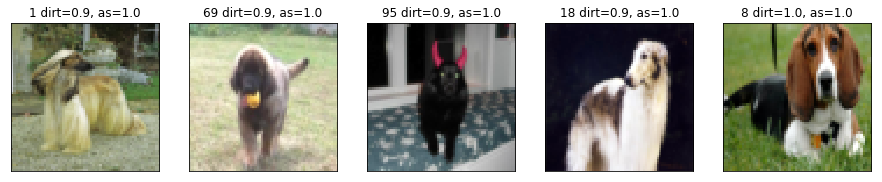

In [17]:
# dirtf,aspfもそれぞれ1なら正常という判断、ちがければ異常判断
show_real_img(5)

In [18]:
#モデルをどのくらい回すかのメソッド
def time_calc(h,m):
    s = h * 60 * 60 + m * 60
    return s
run_time = time_calc(8,0)

In [19]:
nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_calc = 'bce' # 'rals'
lr_g = 0.0002
lr_d = 0.0002
beta1 = 0.5
epochs = 200
use_label =True
use_attention = True

netG = Generator(nz, 32, 3).to(device)
netD = Discriminator(3, 48,loss_calc=loss_calc).to(device)
criterion = nn.BCELoss()
#criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG,
                                                                     T_0=8, eta_min=0.00005)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD,T_mult=2,
                                                                     T_0=8, eta_min=0.00005)

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0
real_uniform = 0.1
fake_uniform = 0.1
batch_size = train_loader.batch_size
num_train_G = 2
cls_info = True
aspect_info = True
fid_each_epoch = 50
### training here
errg_list = []
errd_list = []
dout_real = []
dout_fake1 = []
dout_fake2 = []

epoch_errg_list = []
epoch_errd_list = []
epoch_dout_real = []
epoch_dout_fake1 = []
epoch_dout_fake2 = []
fid_list = []

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[1/200]
    Loss_D: 1.2950 D(x): 0.5491 D(G(z))1: 0.4869
    Loss_G: 0.6241              D(G(z))2: 0.5525 gtr[1/2]
    Loss_G: 0.7803              D(G(z))2: 0.4757 gtr[2/2]
    epoch_mean:
    Loss_D: 1.3244 Loss_G: 0.9559 
    D(x): 0.5408 D(G(z))1: 0.4791  D(G(z))2: 0.3923


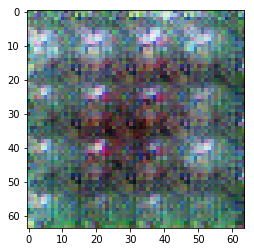


[2/200]
    Loss_D: 1.4105 D(x): 0.5095 D(G(z))1: 0.5179
    Loss_G: 0.7330              D(G(z))2: 0.4793 gtr[1/2]
    Loss_G: 0.7401              D(G(z))2: 0.4730 gtr[2/2]
    epoch_mean:
    Loss_D: 1.3643 Loss_G: 0.7543 
    D(x): 0.5211 D(G(z))1: 0.4991  D(G(z))2: 0.4728



[3/200]
    Loss_D: 1.3914 D(x): 0.5377 D(G(z))1: 0.5353
    Loss_G: 0.7397              D(G(z))2: 0.4743 gtr[1/2]
    Loss_G: 0.7478              D(G(z))2: 0.4708 gtr[2/2]
    epoch_mean:
    Loss_D: 1.3705 Loss_G: 0.7338 
    D(x): 0.5172 D(G(z))1: 0.5034  D(G(z))2: 0.4809



[4/200]
    Loss_D: 1.4232 D(x): 0.4443 D(G(z))1: 0.4537
    Loss_G: 0.8566              D(G(z))2: 0.4261 gtr[1/2]
    Loss_G: 0.9446              D(G(z))2: 0.3879 gtr[2/2]
    epoch_mean:
    Loss_D: 1.3512 Loss_G: 0.7638 
    D(x): 0.5239 D(G(z))1: 0.4969  D(G(z))2: 0.4670



[5/200]
    Loss_D: 1.1599 D(x): 0.5225 D(G(z))1: 0.3726
    Loss_G: 0.8978              D(G(z))2: 0.4043 gtr[1/2]
    Loss_G: 1.0617              D(G(z))2: 0.3333 gtr[2/2]
    epoch_mean:
    Loss_D: 1.2922 Loss_G: 0.8204 
    D(x): 0.5444 D(G(z))1: 0.4795  D(G(z))2: 0.4425



[6/200]
    Loss_D: 1.0698 D(x): 0.5508 D(G(z))1: 0.3581
    Loss_G: 1.0824              D(G(z))2: 0.3324 gtr[1/2]
    Loss_G: 0.8944              D(G(z))2: 0.4107 gtr[2/2]
    epoch_mean:
    Loss_D: 1.1928 Loss_G: 0.8929 
    D(x): 0.5758 D(G(z))1: 0.4471  D(G(z))2: 0.4136


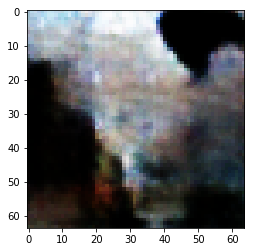


[7/200]
    Loss_D: 1.2380 D(x): 0.5077 D(G(z))1: 0.4014
    Loss_G: 1.0885              D(G(z))2: 0.3424 gtr[1/2]
    Loss_G: 0.9555              D(G(z))2: 0.3784 gtr[2/2]
    epoch_mean:
    Loss_D: 1.0903 Loss_G: 0.9762 
    D(x): 0.6091 D(G(z))1: 0.4110  D(G(z))2: 0.3835



[8/200]
    Loss_D: 1.2217 D(x): 0.5157 D(G(z))1: 0.4017
    Loss_G: 0.6073              D(G(z))2: 0.5514 gtr[1/2]
    Loss_G: 0.6321              D(G(z))2: 0.5431 gtr[2/2]
    epoch_mean:
    Loss_D: 1.0253 Loss_G: 0.9916 
    D(x): 0.6307 D(G(z))1: 0.3911  D(G(z))2: 0.3783


In [20]:
step = 0
for epoch in range(epochs):
    end = time()
    if (end -start) > run_time:
        break    
    for ii, (real_images, classes, aspect_flags, dog_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label) + np.random.uniform(0, real_uniform)
        if cls_info:
            labels = labels * (classes.reshape(-1,1).float())
        if aspect_info:
            labels = labels * (aspect_flags.reshape(-1,1).float())
        real_labels = labels.to(device)
        
        if use_label:
            dog_labels = torch.tensor(dog_labels, device=device)
            outputR = netD((real_images,dog_labels))
        else:
            outputR = netD(real_images)
        if loss_calc == 'bce':
            errD_real = criterion(outputR, real_labels)
            errD_real.backward()
        D_x = outputR.mean().item()
        
        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        if use_label:
            fake = netG((noise, dog_labels))
            outputF1 = netD((fake.detach(), dog_labels))
        else:
            fake = netG(noise)
            outputF1 = netD(fake.detach())
        
        if loss_calc == 'bce':
            fake_labels = torch.full((batch_size, 1), fake_label) + np.random.uniform(0, fake_uniform)
            fake_labels = fake_labels.to(device)
            errD_fake = criterion(outputF1, fake_labels)
            errD_fake.backward()
            errD = errD_real + errD_fake
        elif loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF1) - real_labels) ** 2) + 
                    torch.mean((outputF1 - torch.mean(outputR) + real_labels) ** 2))/2
            errD.backward(retain_graph=True)
            
        D_G_z1 = outputF1.mean().item()
        optimizerD.step()
        
        for g_iter in range(num_train_G):
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            if use_label:
                fake = netG((noise, dog_labels))
                outputF2 = netD((fake, dog_labels))
            else:
                fake = netG(noise) 
                outputF2 = netD(fake)
            if loss_calc == 'bce':
                errG = criterion(outputF2, real_labels)
                errG.backward(retain_graph=True)
            elif loss_calc == 'rals':
                errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) +
                        torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2)) / 2
                errG.backward(retain_graph=True)
                
            D_G_z2 = outputF2.mean().item()
            optimizerG.step()
            
            ############################
            # (3) 記録ゾーン
            ###########################
            dout_fake2.append(D_G_z2) 
            errg_list.append(errG.item())
            errd_list.append(errD.item())

        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        dout_real.append(D_x)
        dout_fake1.append(D_G_z1)
        
    epoch_errg_list.append(np.mean(errg_list[epoch*len(train_loader)*num_train_G:]))
    epoch_errd_list.append(np.mean(errd_list[epoch*len(train_loader)*num_train_G:]))
    epoch_dout_real.append(np.mean(dout_real[epoch*len(train_loader):]))
    epoch_dout_fake1.append(np.mean(dout_fake1[epoch*len(train_loader):]))
    epoch_dout_fake2.append(np.mean(dout_fake2[epoch*len(train_loader)*num_train_G:]))
    
    print('[%d/%d]\n    Loss_D: %.4f D(x): %.4f D(G(z))1: %.4f'
          % (epoch + 1, epochs,errd_list[-1], D_x,  D_G_z1,))
    for i in range(num_train_G):
        print('    Loss_G: %.4f              D(G(z))2: %.4f gtr[%d/%d]' 
              % (errg_list[-(num_train_G-i)],dout_fake2[-(num_train_G-i)],i+1, num_train_G))
    print('    epoch_mean:\n    Loss_D: %.4f Loss_G: %.4f \n    D(x): %.4f D(G(z))1: %.4f  D(G(z))2: %.4f'
          % (epoch_errd_list[-1], epoch_errg_list[-1], epoch_dout_real[-1],epoch_dout_fake1[-1],epoch_dout_fake2[-1]))
    if epoch < 100 and epoch % 5 == 0: # 最初の方のエポックは頻繁に画像出力する。
        show_generated_img()        
    if epoch % fid_each_epoch == fid_each_epoch-1: # fid_each_epoch回数分、画像出力、loss、d_outプロット、画像を10000枚作成、FID計算まで行う。
        show_generated_img()
        loss_plot(epoch_errd_list,epoch_errg_list,xlabel='epoch',ylabel=loss_calc+'_loss')
        dout_plot(epoch_dout_real, epoch_dout_fake1, xlabel='epoch', ylabel='dout(linear)')
#         create_image(netG,nz=nz,threshold=1,fold_name='../output_images'+str(epoch),n_images=10000, im_batch_size=100)
#         fid = fid_calc('../output_images'+str(epoch))
#         fid_list.append(fid)

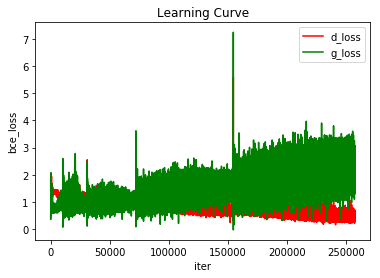

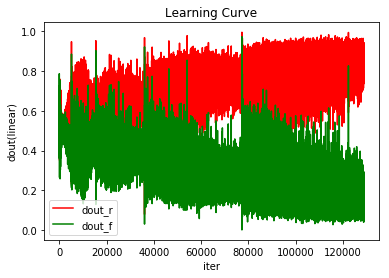

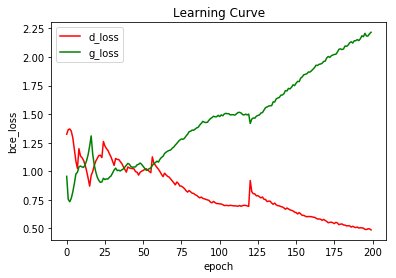

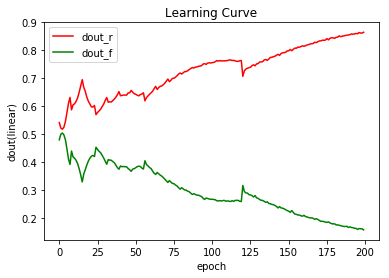

In [21]:
loss_plot(errd_list,errg_list,xlabel='iter',ylabel=loss_calc+'_loss')
dout_plot(dout_real, dout_fake1, xlabel='iter', ylabel='dout(linear)')
loss_plot(epoch_errd_list,epoch_errg_list,xlabel='epoch',ylabel=loss_calc+'_loss')
dout_plot(epoch_dout_real, epoch_dout_fake1, xlabel='epoch', ylabel='dout(linear)')

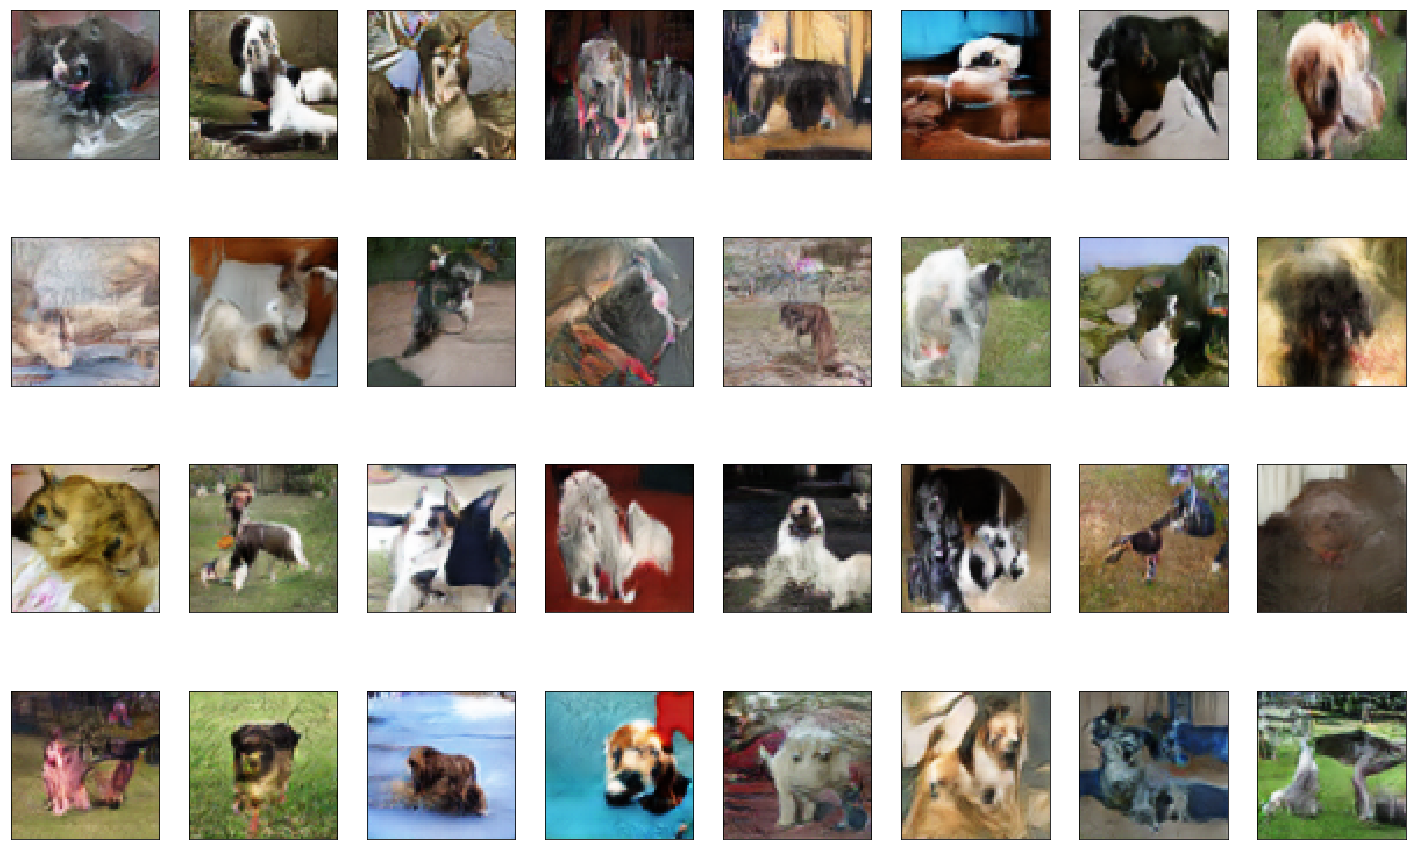

In [22]:
show_generated_img_all()

In [23]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err
    
    
def analyse_generated_by_class(n_images=5, d_thre=1):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        if d < d_thre: 
            print('d={},mode_colapse!'.format(d))
            continue  # had mode colapse(discard)
        good_breeds.append(l)           
        
        if l % 10 == 0:            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
    print('good_breeds_n={}'.format(len(good_breeds)))
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 100
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
    
    print('created!!')
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')


In [24]:
# import matplotlib.pyplot as plt
# plt.figure()
# plt.title("fid Curve")
# plt.xlabel(str(fid_each_epoch)+'epoch')
# plt.ylabel("fid")
# plt.plot(fid_list,   color="r", label="fid")
# plt.legend(loc="best")
# plt.show()

Generated breed(1.4):  affenpinscher


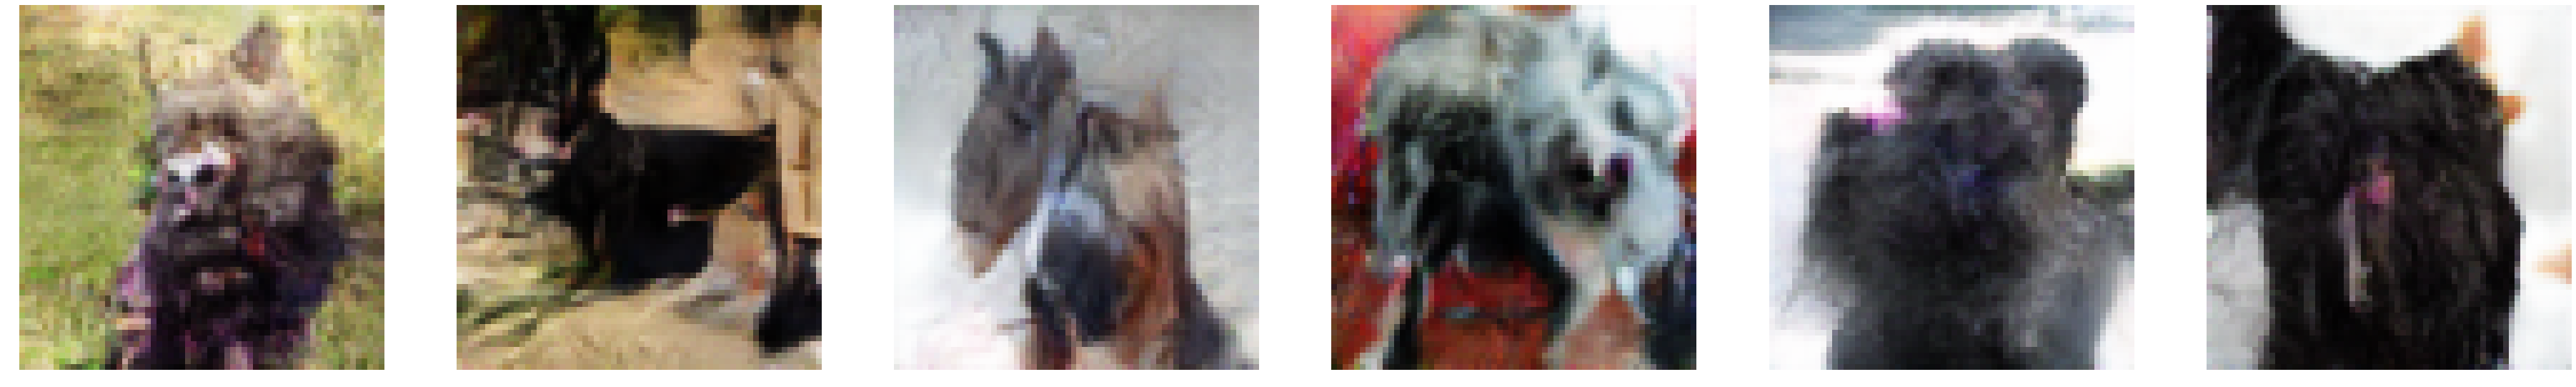

d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
Generated breed(1.2):  bedlington_terrier


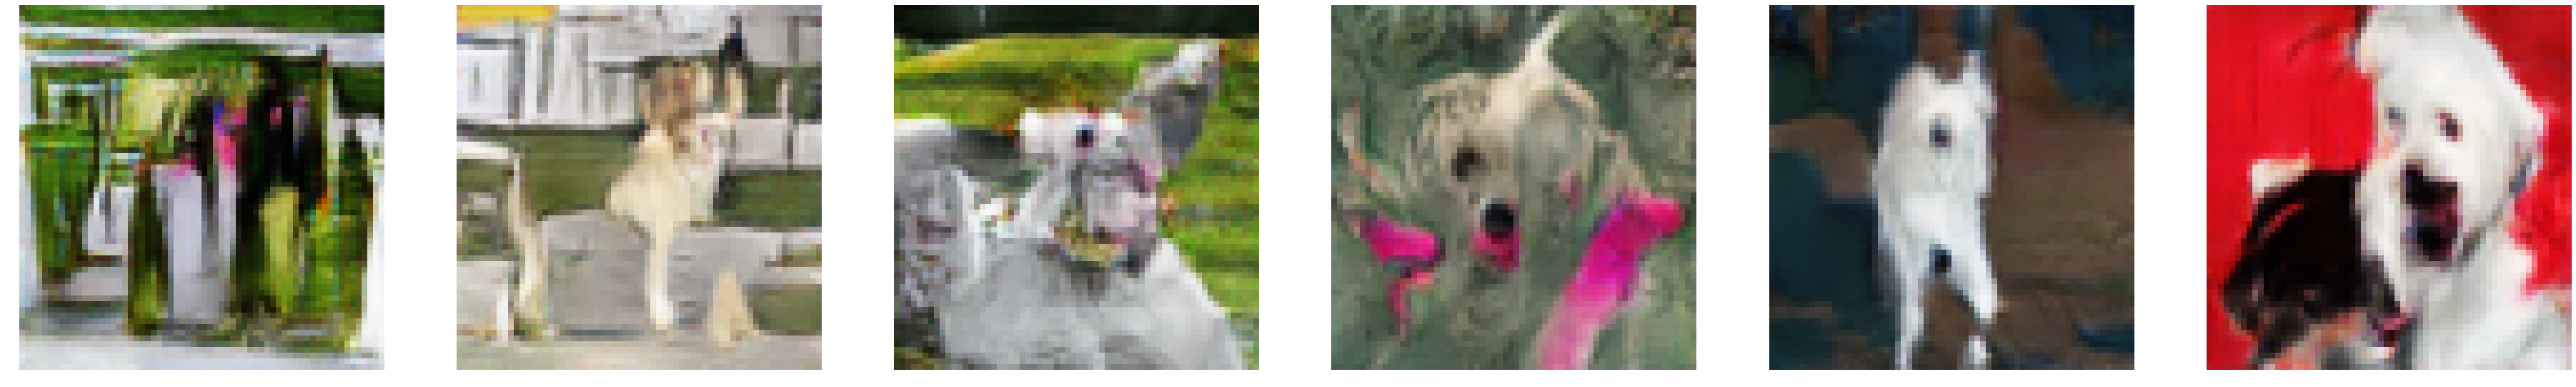

d=0.9,mode_colapse!
Generated breed(1.1):  bouvier_des_flandres


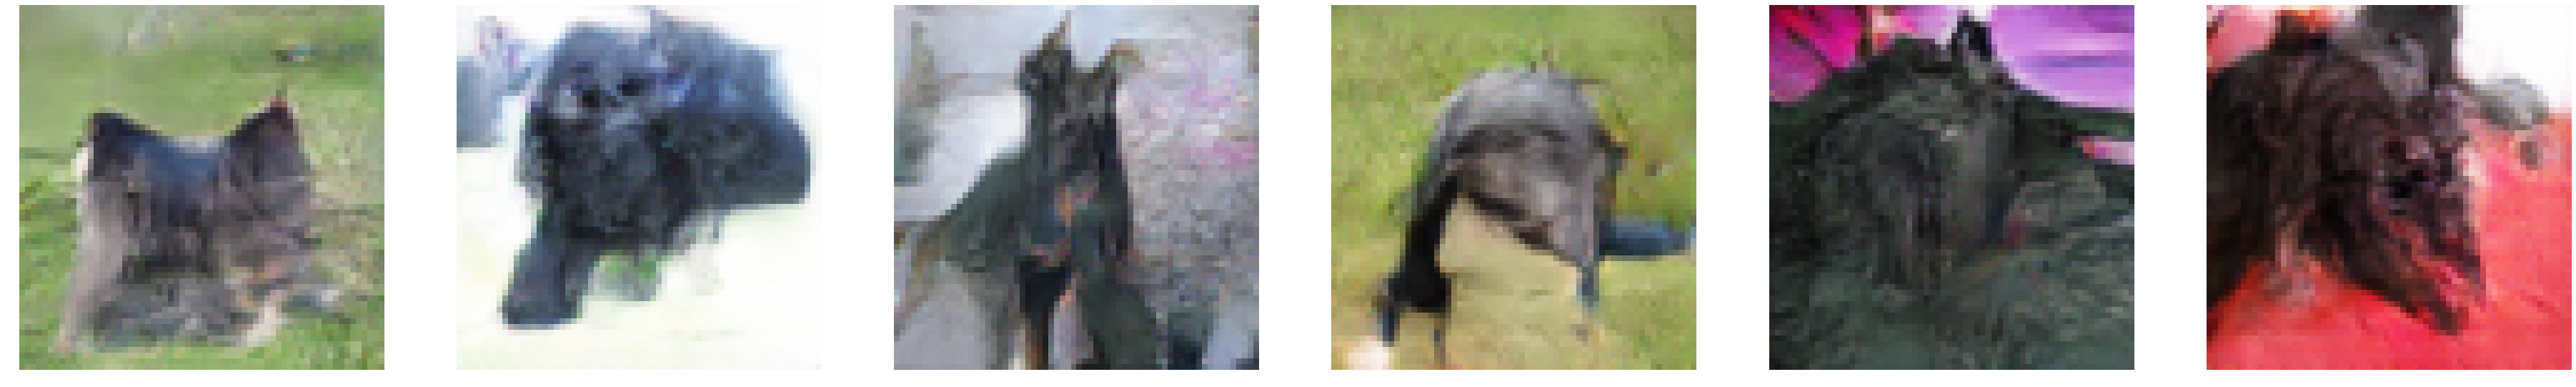

d=0.7,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.8,mode_colapse!
d=0.8,mode_colapse!
d=0.7,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.8,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.8,mode_colapse!
d=0.8,mode_colapse!
d=0.7,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
Generated breed(1.3):  lhasa


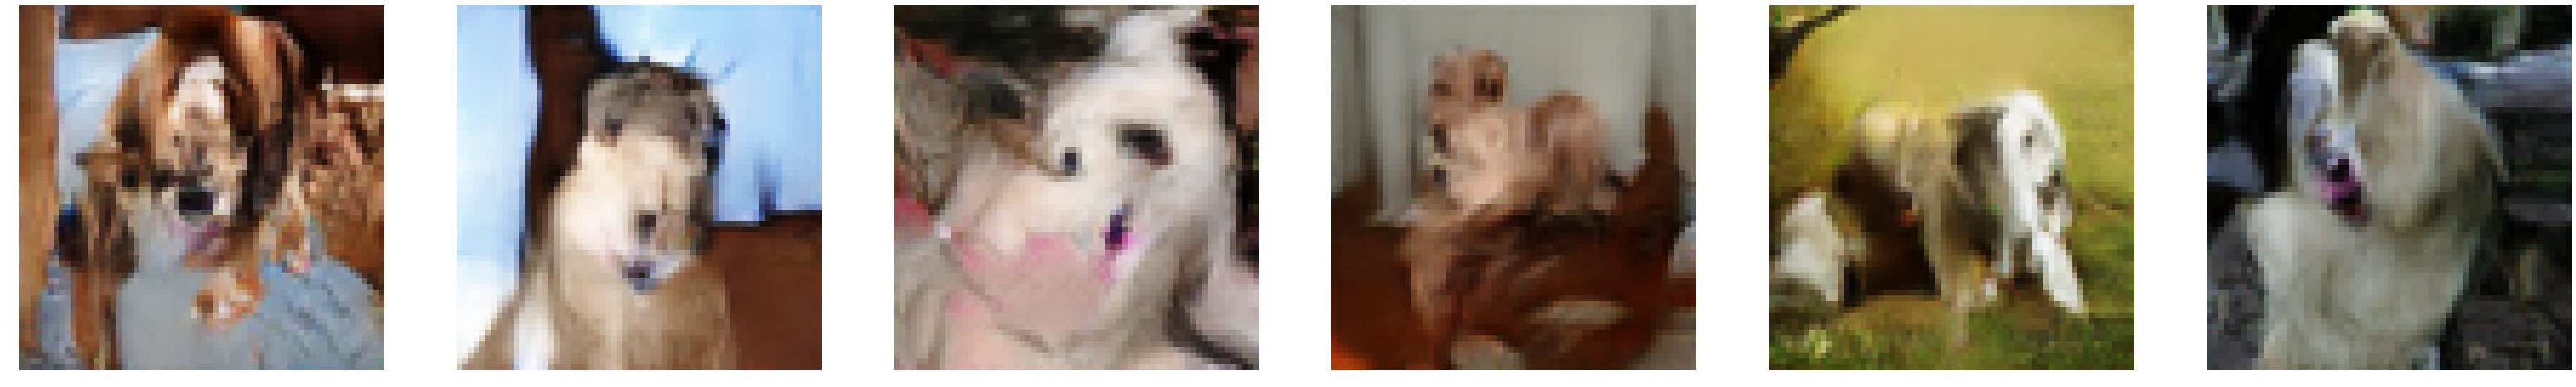

d=0.8,mode_colapse!
d=0.9,mode_colapse!
Generated breed(1.3):  norwegian_elkhound


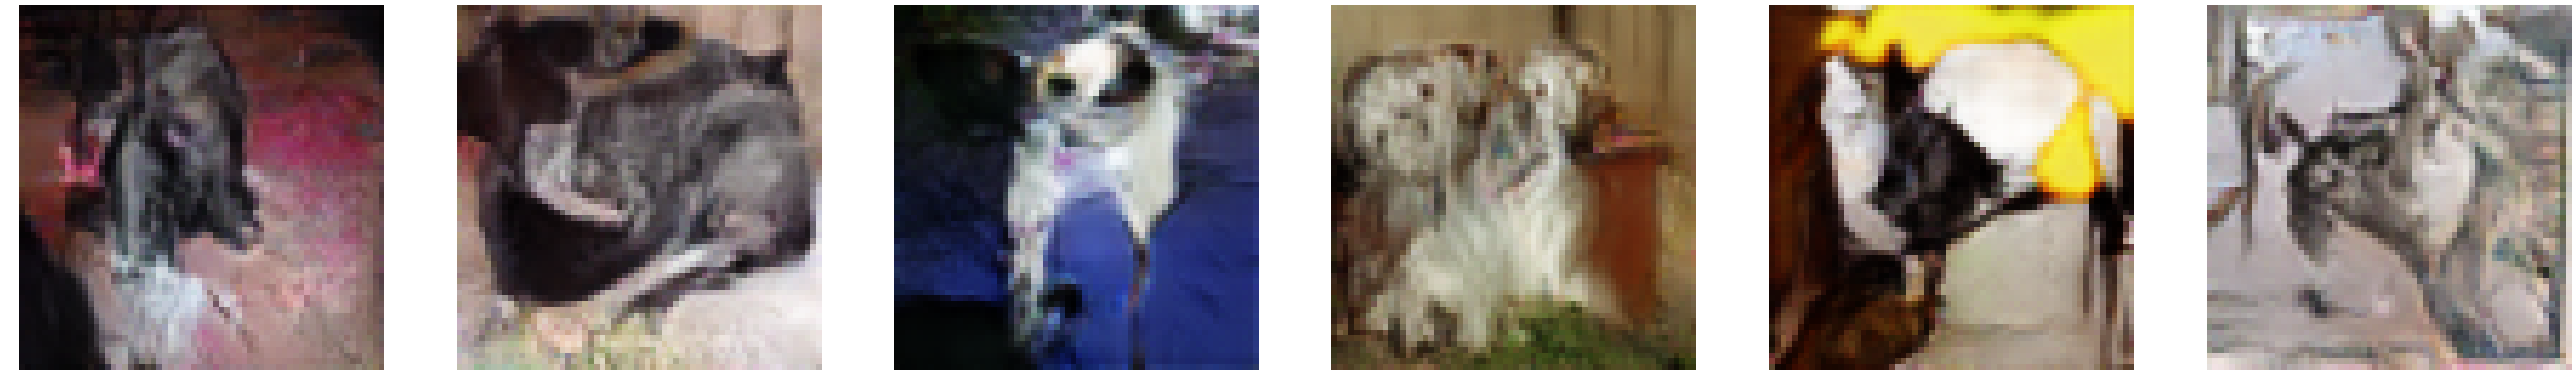

d=0.7,mode_colapse!
d=0.8,mode_colapse!
d=0.9,mode_colapse!
d=0.8,mode_colapse!
d=0.7,mode_colapse!
d=0.7,mode_colapse!
d=0.9,mode_colapse!
Generated breed(1.2):  shih


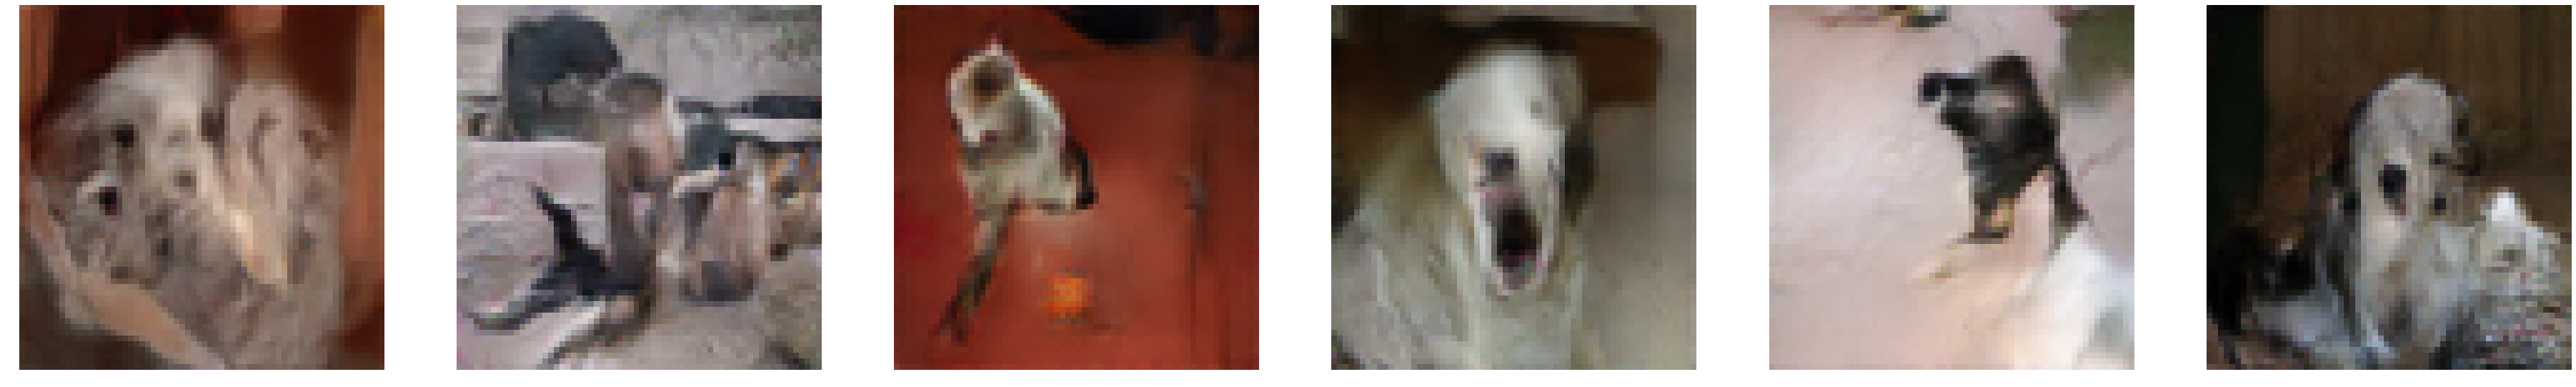

d=0.9,mode_colapse!
d=0.9,mode_colapse!
d=0.8,mode_colapse!
Generated breed(1.3):  toy_poodle


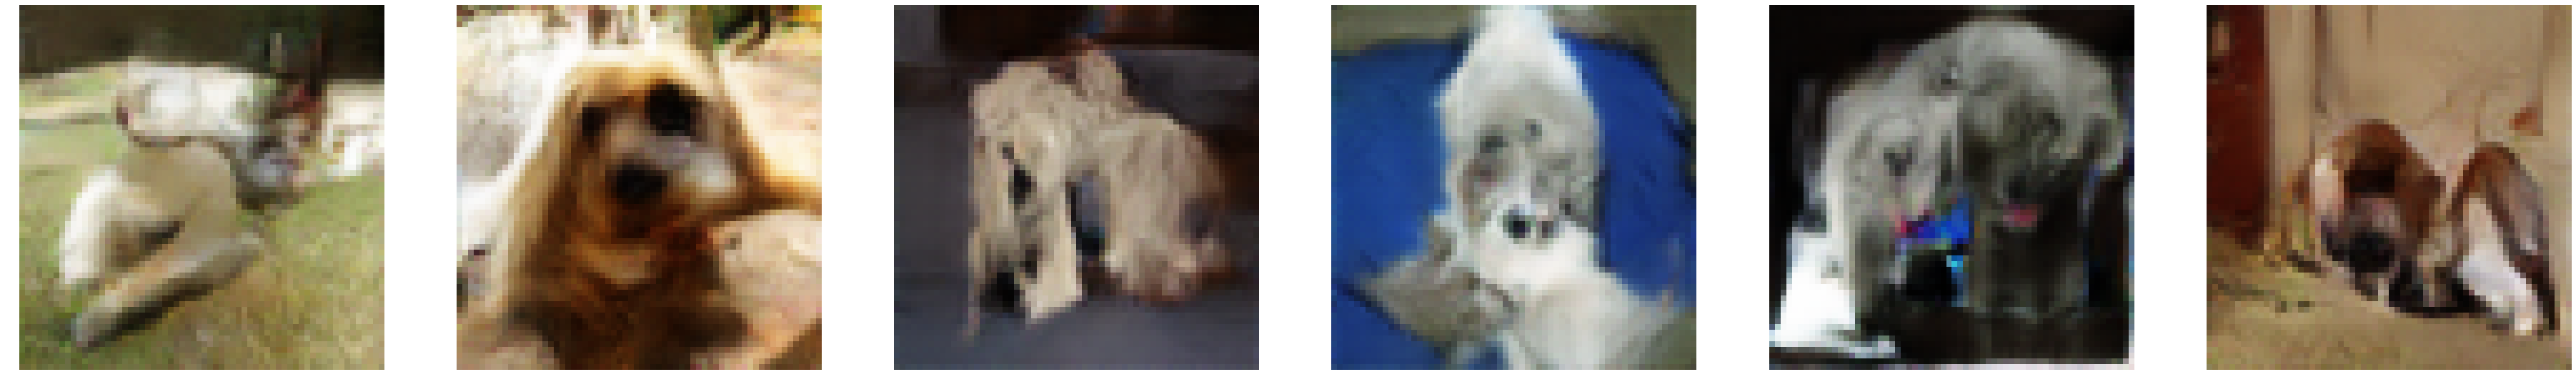

d=0.7,mode_colapse!
d=0.9,mode_colapse!
d=0.9,mode_colapse!
good_breeds_n=84
Creating submit
created!!


In [25]:
good_breeds = analyse_generated_by_class(6)
create_submit(good_breeds)
# fid = fid_calc('../output_images')
# print(fid_list)
# print('final_fid=',fid)